## Analysis of models robustness to JPG compression

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

## Set the seed for reproducibility

In [2]:
SEED = 44
np.random.seed(SEED)
random.seed(SEED)

## Load the data

In [3]:
import os

# the name of the base dataset models trained on this data are tested using other datasets
# (e.g. "standard" for the standard dataset)
base_perturbed_name = "standardAugmented"

perturbed_paths = [
                   "data/features/synthbuster_jpg/jpg_quality_50",
                   "data/features/synthbuster_jpg/jpg_quality_70",
                   "data/features/synthbuster_jpg/jpg_quality_90",
                   "data/features/synthbuster_jpg/jpg_quality_80",
                   "data/features/synthbuster_jpg/jpg_quality_95",
                   "data/features/synthbuster/standard",]
perturbed_data = {}
for data_path in perturbed_paths:
    suffix = "features/extraction_params/train_test/features_RGB.csv"
    dalle2 = pd.read_csv(os.path.join(data_path, "dalle2", suffix), index_col=0)
    dalle3 = pd.read_csv(os.path.join(data_path, "dalle3", suffix), index_col=0)
    firefly = pd.read_csv(os.path.join(data_path, "firefly", suffix), index_col=0)
    glide = pd.read_csv(os.path.join(data_path, "glide", suffix), index_col=0)
    img = pd.read_csv(os.path.join(data_path, "img", suffix), index_col=0)
    midjourney = pd.read_csv(os.path.join(data_path, "midjourney-v5", suffix), index_col=0)
    sd_1_3 = pd.read_csv(os.path.join(data_path, "stable-diffusion-1-3", suffix), index_col=0)
    sd_1_4 = pd.read_csv(os.path.join(data_path, "stable-diffusion-1-4", suffix), index_col=0)
    sd_2 = pd.read_csv(os.path.join(data_path, "stable-diffusion-2", suffix), index_col=0)
    sd_xl = pd.read_csv(os.path.join(data_path, "stable-diffusion-xl", suffix), index_col=0)

    datasets_train = {
        "dalle2": dalle2,
        "dalle3": dalle3,
        "firefly": firefly,
        "glide": glide,
        "midjourney": midjourney,
        "sd_1_3": sd_1_3,
        "sd_1_4": sd_1_4,
        "sd_2": sd_2,
        "sd_xl": sd_xl,
    }
    
    for dataset_name, dataset in datasets_train.items():
        datasets_train[dataset_name] = pd.concat([datasets_train[dataset_name], img])
        
    perturbed_data[data_path.split("/")[-1]] = datasets_train

## Data preparation

In [4]:
def drop_columns(df, drop_only_diagnostic=False):
    to_drop = list()
    for column in df.columns:
        if df[column].min() == df[column].max() and not drop_only_diagnostic:
            to_drop.append(column)
        elif 'diagnostics' in column:
            to_drop.append(column)
        elif 'Mask' in column:
            to_drop.append(column)
        elif 'Image' in column:
            to_drop.append(column)
    df.drop(to_drop, axis=1, inplace=True)
            
def preprocess_dataset(df, **kwargs):
    # print indexes and image names of rows with NaN values
    nans = df[df.isnull().any(axis=1)]['Image'].apply(lambda x : x.split('/')[-1])
    if not nans.empty:
        print(f"Rows with NaN values:")
        print(nans)
    df.dropna(inplace=True)  
    drop_columns(df, **kwargs)
    
def unify_columns(base_columns, df):
    # drop columns that are not in base_columns
    for column in df.columns:
        if column not in base_columns:
            df.drop(column, axis=1, inplace=True)

### Drop unimportant columns

In [5]:
# We drop only columns from train set
for key, datasets_train in perturbed_data.items():
    for key, df in datasets_train.items():
        preprocess_dataset(df, drop_only_diagnostic=True)

### Split into train and test set

In [6]:
from sklearn.model_selection import train_test_split

perturbed_X_train = {}
perturbed_X_val = {}
perturbed_X_test = {}

perturbed_y_train = {}
perturbed_y_val = {}
perturbed_y_test = {}

for perturbed_name, datasets_train in perturbed_data.items():
    X_train = {}
    X_val = {}
    X_test = {}

    y_train = {}
    y_val = {}
    y_test = {}

    for key, df in datasets_train.items():
        X = df.drop('Category', axis=1)
        y = df['Category']
        
        # get train, val and test sets
        X_train[key], X_test[key], y_train[key], y_test[key] = train_test_split(X, y, test_size=0.2, random_state=SEED)
        X_train[key], X_val[key], y_train[key], y_val[key] = train_test_split(X_train[key], y_train[key], test_size=0.2, random_state=SEED)
        
    # create dataset combining all train sets
    X_train_all = pd.concat([X_train[key] for key in datasets_train.keys()])
    y_train_all = pd.concat([y_train[key] for key in datasets_train.keys()])

    # create dataset combining all val sets
    X_val_all = pd.concat([X_val[key] for key in datasets_train.keys()])
    y_val_all = pd.concat([y_val[key] for key in datasets_train.keys()])

    # create dataset combining all test sets
    X_test_all = pd.concat([X_test[key] for key in datasets_train.keys()])
    y_test_all = pd.concat([y_test[key] for key in datasets_train.keys()])

    X_train['combined'] = X_train_all
    y_train['combined'] = y_train_all

    X_val['combined'] = X_val_all
    y_val['combined'] = y_val_all

    X_test['combined'] = X_test_all
    y_test['combined'] = y_test_all
    
    perturbed_X_train[perturbed_name] = X_train
    perturbed_X_val[perturbed_name] = X_val
    perturbed_X_test[perturbed_name] = X_test
    
    perturbed_y_train[perturbed_name] = y_train
    perturbed_y_val[perturbed_name] = y_val
    perturbed_y_test[perturbed_name] = y_test
    

### Scale the data using loaded scaler

In [7]:
import joblib

scalers = {}
X_train_scaled = {}
for key in X_train.keys():
    # Load scaler (MinMaxScaler) the suffix with model name is redundant since scaler is fitted to the data and is not model specific
    scalers[key] = joblib.load(f"scalers/synthbuster/{base_perturbed_name}/{key}/{key}_HistGradientBoostingClassifier.joblib")
    X_train_scaled[key] = scalers[key].transform(X_train[key])
    X_train_scaled[key] = pd.DataFrame(X_train_scaled[key], columns=X_train[key].columns)

## Loading trained models

In [8]:
models = {}
for dataset_name in X_train.keys():
    print(f"\n\nTraining set: {dataset_name}\n")

    models_temp = [
        joblib.load(f"models/synthbuster/{base_perturbed_name}/{dataset_name}/{dataset_name}_HistGradientBoostingClassifier.joblib"),
        joblib.load(f"models/synthbuster/{base_perturbed_name}/{dataset_name}/{dataset_name}_LinearDiscriminantAnalysis.joblib"),
        joblib.load(f"models/synthbuster/{base_perturbed_name}/{dataset_name}/{dataset_name}_RandomForestClassifier.joblib"),
        joblib.load(f"models/synthbuster/{base_perturbed_name}/{dataset_name}/{dataset_name}_LinearSVC.joblib"),
    ]

    model_temp_dict = { model.__class__.__name__: model for model in models_temp }

    for name, model in model_temp_dict.items():
        print(f"Loaded model: {name}")
        print(f"Train score: {model.score(X_train_scaled[dataset_name], y_train[dataset_name])}")
        
    models[dataset_name] = model_temp_dict



Training set: dalle2

Loaded model: HistGradientBoostingClassifier
Train score: 0.9984375
Loaded model: LinearDiscriminantAnalysis
Train score: 0.9953125
Loaded model: RandomForestClassifier
Train score: 0.99609375
Loaded model: LinearSVC
Train score: 0.996875


Training set: dalle3

Loaded model: HistGradientBoostingClassifier
Train score: 0.99765625
Loaded model: LinearDiscriminantAnalysis
Train score: 0.99765625
Loaded model: RandomForestClassifier
Train score: 0.99296875
Loaded model: LinearSVC
Train score: 1.0


Training set: firefly

Loaded model: HistGradientBoostingClassifier
Train score: 0.99375
Loaded model: LinearDiscriminantAnalysis
Train score: 0.99296875
Loaded model: RandomForestClassifier
Train score: 0.9875
Loaded model: LinearSVC
Train score: 0.99453125


Training set: glide

Loaded model: HistGradientBoostingClassifier
Train score: 1.0
Loaded model: LinearDiscriminantAnalysis
Train score: 0.9953125
Loaded model: RandomForestClassifier
Train score: 0.9953125
Loaded 

## Evaluation

In [9]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
    confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef

def evaluate_model(model, X_test, y_test, print_results=True, name=None):
    if name is not None:
        name = model.__class__.__name__
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    
    if print_results:
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1: {f1:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"MCC: {mcc:.4f}")
    
    return accuracy, f1, precision, recall, mcc

def plot_confusion_matrix(model, X_test, y_test, name=None):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.title(name)
    plt.show()

In [10]:
def present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name="Validation", metric="accuracy", perturbed_name="standard"):
    # Get only for the LDA model
    model_df = df[df["model"] == name]
    # Leave only the accuracy, train_dataset, and val_dataset columns
    val_dataset_name = "val_dataset" if evaluation_data_name == "Validation" else "test_dataset"
    model_df = model_df[["train_dataset", val_dataset_name, metric]]
    # Pivot the table
    df_pivot = model_df.pivot(index="train_dataset", columns=val_dataset_name, values=metric)
    # reorganize columns and indexes
    df_pivot = df_pivot.reindex(index=X_train.keys())
    df_pivot = df_pivot.reindex(columns=X_train.keys())

    plt.figure(figsize=(10, 7))
    plt.imshow(df_pivot, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.xticks(np.arange(len(df_pivot.columns)), df_pivot.columns, rotation=45)
    plt.yticks(np.arange(len(df_pivot.index)), df_pivot.index)
    plt.xlabel(f"{evaluation_data_name} dataset")
    plt.ylabel("Train dataset")
    plt.title(f"{name} - {metric} - {perturbed_name}")
    plt.show()
    
    display(df_pivot)
    
    # exclude combined val_dataset
    df_avg = df_pivot.drop("combined", axis=1)
    # calculate average accuracy for each train dataset (don't include combined)
    df_avg["average"] = df_avg.mean(axis=1)
    display(df_avg)

    return df_pivot, df_avg


## Validation data

In [11]:
perturbed_results = {}   

for perturbed_name, X_val, y_val in zip(perturbed_X_val.keys(), perturbed_X_val.values(), perturbed_y_val.values()):
    results = {}
    X_train = perturbed_X_train["standard"]
    print(f"\n\n\n\n\n\n\n\n ################ Evaluating models trained on {base_perturbed_name} and tested on {perturbed_name}. ################")
    for dataset_name in models.keys():
        print(f"\n\n\n\n *** Evaluating models trained on {dataset_name}. ***")
        for val_dataset_name in X_val.keys():
            print(f"\n\nValidation set: {val_dataset_name}")
            for model_name, model in models[dataset_name].items():
                print()  
                X_val_scaled = scalers[dataset_name].transform(X_val[val_dataset_name][X_train[dataset_name].columns])
                X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train[dataset_name].columns)
                accuracy, f1, precision, recall, mcc = evaluate_model(model, X_val_scaled, y_val[val_dataset_name], name=model_name)
                model_results = {
                    "accuracy": accuracy,
                    "f1": f1,
                    "precision": precision,
                    "recall": recall,
                    "mcc": mcc
                }
                results[(dataset_name, val_dataset_name, model_name)] = model_results
    
    perturbed_results[perturbed_name] = results
            









 ################ Evaluating models trained on standardAugmented and tested on jpg_quality_50. ################




 *** Evaluating models trained on dalle2. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9719
F1: 0.9719
Precision: 0.9734
Recall: 0.9719
MCC: 0.9453

Model: LinearDiscriminantAnalysis
Accuracy: 0.9531
F1: 0.9531
Precision: 0.9531
Recall: 0.9531
MCC: 0.9062

Model: RandomForestClassifier
Accuracy: 0.9875
F1: 0.9875
Precision: 0.9876
Recall: 0.9875
MCC: 0.9751

Model: LinearSVC
Accuracy: 0.9594
F1: 0.9594
Precision: 0.9616
Recall: 0.9594
MCC: 0.9210


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.8313
F1: 0.8269
Precision: 0.8744
Recall: 0.8313
MCC: 0.7054

Model: LinearDiscriminantAnalysis
Accuracy: 0.7937
F1: 0.7888
Precision: 0.8294
Recall: 0.7937
MCC: 0.6233

Model: RandomForestClassifier
Accuracy: 0.7625
F1: 0.7503
Precision: 0.8350
Recall: 0.7625
MCC: 0.5952

Model: LinearSVC
Accuracy: 0.9125
F1: 0.

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4781
F1: 0.3174
Precision: 0.2375
Recall: 0.4781
MCC: -0.1146

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4844
F1: 0.3202
Precision: 0.2391
Recall: 0.4844
MCC: -0.0808


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4781
F1: 0.3174
Precision: 0.2375
Recall: 0.4781
MCC: -0.1146

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4844
F1: 0.3202
Precision: 0.2391
Recall: 0.4844
MCC: -0.0808


Validation set: glide



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.9531
F1: 0.9531
Precision: 0.9572
Recall: 0.9531
MCC: 0.9104

Model: LinearDiscriminantAnalysis
Accuracy: 0.9812
F1: 0.9812
Precision: 0.9813
Recall: 0.9812
MCC: 0.9626

Model: RandomForestClassifier
Accuracy: 0.9500
F1: 0.9499
Precision: 0.9546
Recall: 0.9500
MCC: 0.9047

Model: LinearSVC
Accuracy: 0.9469
F1: 0.9468
Precision: 0.9499
Recall: 0.9469
MCC: 0.8968


Validation set: midjourney



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4875
F1: 0.3374
Precision: 0.4581
Recall: 0.4875
MCC: -0.0242



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4844
F1: 0.3202
Precision: 0.2391
Recall: 0.4844
MCC: -0.0808


Validation set: sd_1_3



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5219
F1: 0.4059
Precision: 0.6447
Recall: 0.5219
MCC: 0.1311



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4969
F1: 0.3470
Precision: 0.5818
Recall: 0.4969
MCC: 0.0435


Validation set: sd_1_4



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5062
F1: 0.3757
Precision: 0.5972
Recall: 0.5062
MCC: 0.0753



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4969
F1: 0.3470
Precision: 0.5818
Recall: 0.4969
MCC: 0.0435


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5469
F1: 0.4515
Precision: 0.6863
Recall: 0.5469
MCC: 0.2003

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5125
F1: 0.3791
Precision: 0.6629
Recall: 0.5125
MCC: 0.1165


Validation set: sd_xl



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5094
F1: 0.3818
Precision: 0.6092
Recall: 0.5094
MCC: 0.0877



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4844
F1: 0.3202
Precision: 0.2391
Recall: 0.4844
MCC: -0.0808


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5424
F1: 0.4285
Precision: 0.7632
Recall: 0.5424
MCC: 0.2292

Model: LinearDiscriminantAnalysis
Accuracy: 0.5594
F1: 0.4731
Precision: 0.7003
Recall: 0.5594
MCC: 0.2299

Model: RandomForestClassifier
Accuracy: 0.5424
F1: 0.4285
Precision: 0.7632
Recall: 0.5424
MCC: 0.2292

Model: LinearSVC
Accuracy: 0.5431
F1: 0.4375
Precision: 0.7145
Recall: 0.5431
MCC: 0.2079




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.7188
F1: 0.7006
Precision: 0.7983
Recall: 0.7188
MCC: 0.5138

Model: LinearDiscriminantAnalysis
Accuracy: 0.7937
F1: 0.7896
Precision: 0.8237
Recall: 0.7937
MCC: 0.6178

Model: RandomForestClassifier
Accuracy: 0.7219
F1: 0.7080
Preci

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5062
F1: 0.3616
Precision: 0.6811
Recall: 0.5062
MCC: 0.1040



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4844
F1: 0.3202
Precision: 0.2391
Recall: 0.4844
MCC: -0.0808


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4875
F1: 0.3216
Precision: 0.2399
Recall: 0.4875
MCC: -0.0570

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4844
F1: 0.3202
Precision: 0.2391
Recall: 0.4844
MCC: -0.0808


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9656
F1: 0.9656
Precision: 0.9679
Recall: 0.9656
MCC: 0.9335

Model: LinearDiscriminantAnalysis
Accuracy: 0.9844
F1: 0.9844
Precision: 0.9846
Recall: 0.9844
MCC: 0.9689

Model: RandomForestClassifier
Accuracy: 0.9531
F1: 0.9531
Precision: 0.9572
Recall: 0.9531
MCC: 0.9104

Model: LinearSVC
Accuracy: 0.9594
F1: 0.9594
Precision: 0.9609
Recall: 0.9594
MCC: 0.9203


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4969
F1: 0.3419
Precision: 0.6242
Recall: 0.4969
MCC: 0.0542

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4844
F1: 0.3202
Precision: 0.2391
Recall: 0.4844
MCC: -0.0808


Validation set: sd_1_3



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5312
F1: 0.4115
Precision: 0.7264
Recall: 0.5312
MCC: 0.1881



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4875
F1: 0.3270
Precision: 0.4097
Recall: 0.4875
MCC: -0.0343


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5563
F1: 0.4577
Precision: 0.7449
Recall: 0.5563
MCC: 0.2489

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4875
F1: 0.3270
Precision: 0.4097
Recall: 0.4875
MCC: -0.0343


Validation set: sd_2



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.6094
F1: 0.5460
Precision: 0.7700
Recall: 0.6094
MCC: 0.3520



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5281
F1: 0.4096
Precision: 0.6959
Recall: 0.5281
MCC: 0.1678


Validation set: sd_xl



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5531
F1: 0.4521
Precision: 0.7431
Recall: 0.5531
MCC: 0.2420



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4844
F1: 0.3202
Precision: 0.2391
Recall: 0.4844
MCC: -0.0808


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5437
F1: 0.4311
Precision: 0.7636
Recall: 0.5437
MCC: 0.2325

Model: LinearDiscriminantAnalysis
Accuracy: 0.5844
F1: 0.5059
Precision: 0.7592
Recall: 0.5844
MCC: 0.3063

Model: RandomForestClassifier
Accuracy: 0.5424
F1: 0.4285
Precision: 0.7632
Recall: 0.5424
MCC: 0.2292

Model: LinearSVC
Accuracy: 0.5437
F1: 0.4387
Precision: 0.7152
Recall: 0.5437
MCC: 0.2096




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.8406
F1: 0.8384
Precision: 0.8651
Recall: 0.8406
MCC: 0.7060

Model: LinearDiscriminantAnalysis
Accuracy: 0.8750
F1: 0.8737
Precision: 0.8954
Recall: 0.8750
MCC: 0.7706

Model: RandomForestClassifier
Accuracy: 0.8094
F1: 0.8046
Preci

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5062
F1: 0.3616
Precision: 0.6811
Recall: 0.5062
MCC: 0.1040



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4844
F1: 0.3202
Precision: 0.2391
Recall: 0.4844
MCC: -0.0808


Validation set: firefly



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4875
F1: 0.3216
Precision: 0.2399
Recall: 0.4875
MCC: -0.0570



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4844
F1: 0.3202
Precision: 0.2391
Recall: 0.4844
MCC: -0.0808


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9781
F1: 0.9781
Precision: 0.9791
Recall: 0.9781
MCC: 0.9572

Model: LinearDiscriminantAnalysis
Accuracy: 0.9875
F1: 0.9875
Precision: 0.9876
Recall: 0.9875
MCC: 0.9751

Model: RandomForestClassifier
Accuracy: 0.9750
F1: 0.9750
Precision: 0.9762
Recall: 0.9750
MCC: 0.9512

Model: LinearSVC
Accuracy: 0.9719
F1: 0.9719
Precision: 0.9724
Recall: 0.9719
MCC: 0.9442


Validation set: midjourney



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5156
F1: 0.3808
Precision: 0.7053
Recall: 0.5156
MCC: 0.1403



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4844
F1: 0.3202
Precision: 0.2391
Recall: 0.4844
MCC: -0.0808


Validation set: sd_1_3

Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5563
F1: 0.4577
Precision: 0.7449
Recall: 0.5563
MCC: 0.2489



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3338
Precision: 0.4953
Recall: 0.4906
MCC: -0.0021


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5656
F1: 0.4742
Precision: 0.7501
Recall: 0.5656
MCC: 0.2690

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4906
F1: 0.3338
Precision: 0.4953
Recall: 0.4906
MCC: -0.0021


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.6406
F1: 0.5928
Precision: 0.7827
Recall: 0.6406
MCC: 0.4051

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5437
F1: 0.4387
Precision: 0.7152
Recall: 0.5437
MCC: 0.2096


Validation set: sd_xl

Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5844
F1: 0.5059
Precision: 0.7592
Recall: 0.5844
MCC: 0.3063

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4844
F1: 0.3202
Precision: 0.2391
Recall: 0.4844
MCC: -0.0808


Validation set: combined



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5451
F1: 0.4337
Precision: 0.7640
Recall: 0.5451
MCC: 0.2357

Model: LinearDiscriminantAnalysis
Accuracy: 0.5979
F1: 0.5280
Precision: 0.7652
Recall: 0.5979
MCC: 0.3315

Model: RandomForestClassifier
Accuracy: 0.5448
F1: 0.4331
Precision: 0.7639
Recall: 0.5448
MCC: 0.2349

Model: LinearSVC
Accuracy: 0.5469
F1: 0.4444
Precision: 0.7183
Recall: 0.5469
MCC: 0.2173




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9219
F1: 0.9217
Precision: 0.9281
Recall: 0.9219
MCC: 0.8500

Model: LinearDiscriminantAnalysis
Accuracy: 0.8500
F1: 0.8475
Precision: 0.8792
Recall: 0.8500
MCC: 0.7293

Model: RandomForestClassifier
Accuracy: 0.8219
F1: 0.8185
Precision: 0.8530
Recall: 0.8219
MCC: 0.6750

Model: LinearSVC
Accuracy: 0.7750
F1: 0.7666
Precision: 0.8285
Recall: 0.7750
MCC: 0.6028


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.9688
F1: 0.9688


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5437
F1: 0.4350
Precision: 0.7368
Recall: 0.5437
MCC: 0.2201

Model: RandomForestClassifier
Accuracy: 0.4969
F1: 0.3367
Precision: 0.7516
Recall: 0.4969
MCC: 0.0778

Model: LinearSVC
Accuracy: 0.4938
F1: 0.3299
Precision: 0.7508
Recall: 0.4938
MCC: 0.0549


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5031
F1: 0.3551
Precision: 0.6682
Recall: 0.5031
MCC: 0.0896



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: firefly



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3284
Precision: 0.4954
Recall: 0.4906
MCC: -0.0015



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9906
F1: 0.9906
Precision: 0.9908
Recall: 0.9906
MCC: 0.9814

Model: LinearDiscriminantAnalysis
Accuracy: 0.9938
F1: 0.9938
Precision: 0.9938
Recall: 0.9938
MCC: 0.9875

Model: RandomForestClassifier
Accuracy: 0.9906
F1: 0.9906
Precision: 0.9908
Recall: 0.9906
MCC: 0.9814

Model: LinearSVC
Accuracy: 0.9844
F1: 0.9844
Precision: 0.9849
Recall: 0.9844
MCC: 0.9692


Validation set: midjourney



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5031
F1: 0.3551
Precision: 0.6682
Recall: 0.5031
MCC: 0.0896



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: sd_1_3



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5563
F1: 0.4577
Precision: 0.7449
Recall: 0.5563
MCC: 0.2489

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4938
F1: 0.3299
Precision: 0.7508
Recall: 0.4938
MCC: 0.0549


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5437
F1: 0.4350
Precision: 0.7368
Recall: 0.5437
MCC: 0.2201

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4938
F1: 0.3299
Precision: 0.7508
Recall: 0.4938
MCC: 0.0549


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.6344
F1: 0.5837
Precision: 0.7802
Recall: 0.6344
MCC: 0.3948

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5469
F1: 0.4369
Precision: 0.7644
Recall: 0.5469
MCC: 0.2396


Validation set: sd_xl

Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5875
F1: 0.5111
Precision: 0.7606
Recall: 0.5875
MCC: 0.3122

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5462
F1: 0.4357
Precision: 0.7642
Recall: 0.5462
MCC: 0.2380

Model: LinearDiscriminantAnalysis
Accuracy: 0.5951
F1: 0.5235
Precision: 0.7640
Recall: 0.5951
MCC: 0.3265

Model: RandomForestClassifier
Accuracy: 0.5469
F1: 0.4369
Precision: 0.7644
Recall: 0.5469
MCC: 0.2396

Model: LinearSVC
Accuracy: 0.5528
F1: 0.4478
Precision: 0.7660
Recall: 0.5528
MCC: 0.2527




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.8812
F1: 0.8800
Precision: 0.9019
Recall: 0.8812
MCC: 0.7833

Model: LinearDiscriminantAnalysis
Accuracy: 0.8875
F1: 0.8864
Precision: 0.9061
Recall: 0.8875
MCC: 0.7938

Model: RandomForestClassifier
Accuracy: 0.7875
F1: 0.7795
Precision: 0.8432
Recall: 0.7875
MCC: 0.6298

Model: LinearSVC
Accuracy: 0.7937
F1: 0.7860
Precision: 0.8506
R

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5156
F1: 0.3853
Precision: 0.6714
Recall: 0.5156
MCC: 0.1279

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4844
F1: 0.3256
Precision: 0.3664
Recall: 0.4844
MCC: -0.0584


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5125
F1: 0.3791
Precision: 0.6629
Recall: 0.5125
MCC: 0.1165

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4813
F1: 0.3188
Precision: 0.2383
Recall: 0.4813
MCC: -0.0991


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4875
F1: 0.3270
Precision: 0.4097
Recall: 0.4875
MCC: -0.0343

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4844
F1: 0.3256
Precision: 0.3664
Recall: 0.4844
MCC: -0.0584


Validation set: glide



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.9625
F1: 0.9625
Precision: 0.9652
Recall: 0.9625
MCC: 0.9277

Model: LinearDiscriminantAnalysis
Accuracy: 0.9781
F1: 0.9781
Precision: 0.9783
Recall: 0.9781
MCC: 0.9564

Model: RandomForestClassifier
Accuracy: 0.9781
F1: 0.9781
Precision: 0.9791
Recall: 0.9781
MCC: 0.9572

Model: LinearSVC
Accuracy: 0.9688
F1: 0.9688
Precision: 0.9691
Recall: 0.9688
MCC: 0.9378


Validation set: midjourney



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4938
F1: 0.3404
Precision: 0.5470
Recall: 0.4938
MCC: 0.0228



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4813
F1: 0.3188
Precision: 0.2383
Recall: 0.4813
MCC: -0.0991


Validation set: sd_1_3



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5687
F1: 0.4828
Precision: 0.7356
Recall: 0.5687
MCC: 0.2663



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4875
F1: 0.3323
Precision: 0.4436
Recall: 0.4875
MCC: -0.0276


Validation set: sd_1_4



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5469
F1: 0.4444
Precision: 0.7183
Recall: 0.5469
MCC: 0.2173



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3389
Precision: 0.4953
Recall: 0.4906
MCC: -0.0026


Validation set: sd_2



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.6219
F1: 0.5674
Precision: 0.7648
Recall: 0.6219
MCC: 0.3665



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5563
F1: 0.4645
Precision: 0.7106
Recall: 0.5563
MCC: 0.2305


Validation set: sd_xl

Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5719
F1: 0.4881
Precision: 0.7376
Recall: 0.5719
MCC: 0.2728



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4813
F1: 0.3188
Precision: 0.2383
Recall: 0.4813
MCC: -0.0991


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5431
F1: 0.4298
Precision: 0.7634
Recall: 0.5431
MCC: 0.2309

Model: LinearDiscriminantAnalysis
Accuracy: 0.5885
F1: 0.5156
Precision: 0.7477
Recall: 0.5885
MCC: 0.3059

Model: RandomForestClassifier
Accuracy: 0.5448
F1: 0.4331
Precision: 0.7639
Recall: 0.5448
MCC: 0.2349

Model: LinearSVC
Accuracy: 0.5462
F1: 0.4467
Precision: 0.7002
Recall: 0.5462
MCC: 0.2066




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9688
F1: 0.9687
Precision: 0.9700
Recall: 0.9688
MCC: 0.9387

Model: LinearDiscriminantAnalysis
Accuracy: 0.8219
F1: 0.8174
Precision: 0.8622
Recall: 0.8219
MCC: 0.6840

Model: RandomForestClassifier
Accuracy: 0.8438
F1: 0.8414
Preci

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5406
F1: 0.4330
Precision: 0.7119
Recall: 0.5406
MCC: 0.2018

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4844
F1: 0.3202
Precision: 0.2391
Recall: 0.4844
MCC: -0.0808


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5125
F1: 0.3791
Precision: 0.6629
Recall: 0.5125
MCC: 0.1165

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4844
F1: 0.3202
Precision: 0.2391
Recall: 0.4844
MCC: -0.0808


Validation set: firefly



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4844
F1: 0.3202
Precision: 0.2391
Recall: 0.4844
MCC: -0.0808



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4844
F1: 0.3202
Precision: 0.2391
Recall: 0.4844
MCC: -0.0808


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.9938
F1: 0.9937
Precision: 0.9938
Recall: 0.9938
MCC: 0.9876

Model: RandomForestClassifier
Accuracy: 0.9969
F1: 0.9969
Precision: 0.9969
Recall: 0.9969
MCC: 0.9938

Model: LinearSVC
Accuracy: 0.9938
F1: 0.9937
Precision: 0.9938
Recall: 0.9938
MCC: 0.9876


Validation set: midjourney



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4938
F1: 0.3404
Precision: 0.5470
Recall: 0.4938
MCC: 0.0228



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4844
F1: 0.3202
Precision: 0.2391
Recall: 0.4844
MCC: -0.0808


Validation set: sd_1_3



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5563
F1: 0.4611
Precision: 0.7264
Recall: 0.5563
MCC: 0.2391



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4875
F1: 0.3270
Precision: 0.4097
Recall: 0.4875
MCC: -0.0343


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5656
F1: 0.4774
Precision: 0.7334
Recall: 0.5656
MCC: 0.2597

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4938
F1: 0.3404
Precision: 0.5470
Recall: 0.4938
MCC: 0.0228


Validation set: sd_2



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.6625
F1: 0.6254
Precision: 0.7835
Recall: 0.6625
MCC: 0.4344



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5406
F1: 0.4330
Precision: 0.7119
Recall: 0.5406
MCC: 0.2018


Validation set: sd_xl



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5625
F1: 0.4720
Precision: 0.7312
Recall: 0.5625
MCC: 0.2529



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4844
F1: 0.3202
Precision: 0.2391
Recall: 0.4844
MCC: -0.0808


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5472
F1: 0.4376
Precision: 0.7645
Recall: 0.5472
MCC: 0.2404

Model: LinearDiscriminantAnalysis
Accuracy: 0.5969
F1: 0.5289
Precision: 0.7522
Recall: 0.5969
MCC: 0.3216

Model: RandomForestClassifier
Accuracy: 0.5469
F1: 0.4369
Precision: 0.7644
Recall: 0.5469
MCC: 0.2396

Model: LinearSVC
Accuracy: 0.5486
F1: 0.4475
Precision: 0.7199
Recall: 0.5486
MCC: 0.2214




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9719
F1: 0.9719
Precision: 0.9728
Recall: 0.9719
MCC: 0.9447

Model: LinearDiscriminantAnalysis
Accuracy: 0.7719
F1: 0.7605
Precision: 0.8443
Recall: 0.7719
MCC: 0.6139

Model: RandomForestClassifier
Accuracy: 0.8500
F1: 0.8473
Preci

### Accuracy - Validation

########################### Accuracy ###########################








 ################ Evaluating models trained on standardAugmented and tested on jpg_quality_50. ################


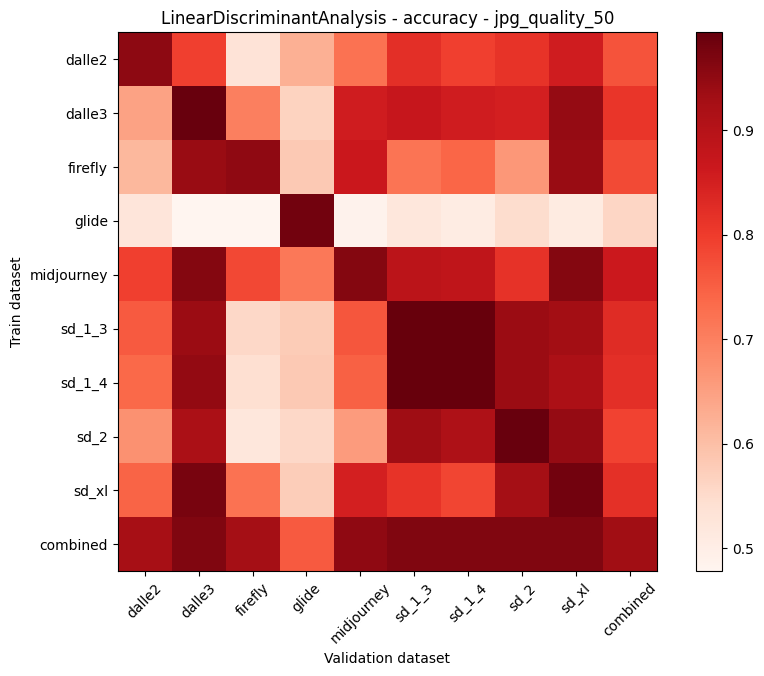

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.953125  0.793750  0.531250  0.625000    0.721875  0.821875   
dalle3         0.646875  0.990625  0.700000  0.565625    0.856250  0.871875   
firefly        0.612500  0.940625  0.950000  0.581250    0.865625  0.718750   
glide          0.525000  0.478125  0.478125  0.981250    0.487500  0.521875   
midjourney     0.793750  0.962500  0.781250  0.712500    0.962500  0.890625   
sd_1_3         0.756250  0.937500  0.556250  0.578125    0.762500  0.993750   
sd_1_4         0.737500  0.946875  0.540625  0.581250    0.746875  0.993750   
sd_2           0.671875  0.918750  0.521875  0.556250    0.656250  0.934375   
sd_xl          0.743750  0.975000  0.721875  0.575000    0.850000  0.812500   
combined       0.925000  0.965625  0.928125  0.756250    0.950000  0.965625   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.793750  0.812500  0.856250  0.767708  
dalle3         0.856250  0.850000  0.943750  0.809028  
firefly        0.740625  0.662500  0.940625  0.779167  
glide          0.506250  0.546875  0.509375  0.559375  
midjourney     0.884375  0.815625  0.962500  0.862847  
sd_1_3         0.993750  0.937500  0.931250  0.827431  
sd_1_4         0.993750  0.937500  0.915625  0.821528  
sd_2           0.912500  0.990625  0.943750  0.789583  
sd_xl          0.784375  0.928125  0.981250  0.819097  
combined       0.965625  0.965625  0.965625  0.931944

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.953125  0.793750  0.531250  0.625000    0.721875  0.821875   
dalle3         0.646875  0.990625  0.700000  0.565625    0.856250  0.871875   
firefly        0.612500  0.940625  0.950000  0.581250    0.865625  0.718750   
glide          0.525000  0.478125  0.478125  0.981250    0.487500  0.521875   
midjourney     0.793750  0.962500  0.781250  0.712500    0.962500  0.890625   
sd_1_3         0.756250  0.937500  0.556250  0.578125    0.762500  0.993750   
sd_1_4         0.737500  0.946875  0.540625  0.581250    0.746875  0.993750   
sd_2           0.671875  0.918750  0.521875  0.556250    0.656250  0.934375   
sd_xl          0.743750  0.975000  0.721875  0.575000    0.850000  0.812500   
combined       0.925000  0.965625  0.928125  0.756250    0.950000  0.965625   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.793750  0.812500  0.856250  0.767708  
dalle3         0.856250  0.850000  0.943750  0.809028  
firefly        0.740625  0.662500  0.940625  0.779167  
glide          0.506250  0.546875  0.509375  0.559375  
midjourney     0.884375  0.815625  0.962500  0.862847  
sd_1_3         0.993750  0.937500  0.931250  0.827431  
sd_1_4         0.993750  0.937500  0.915625  0.821528  
sd_2           0.912500  0.990625  0.943750  0.789583  
sd_xl          0.784375  0.928125  0.981250  0.819097  
combined       0.965625  0.965625  0.965625  0.931944

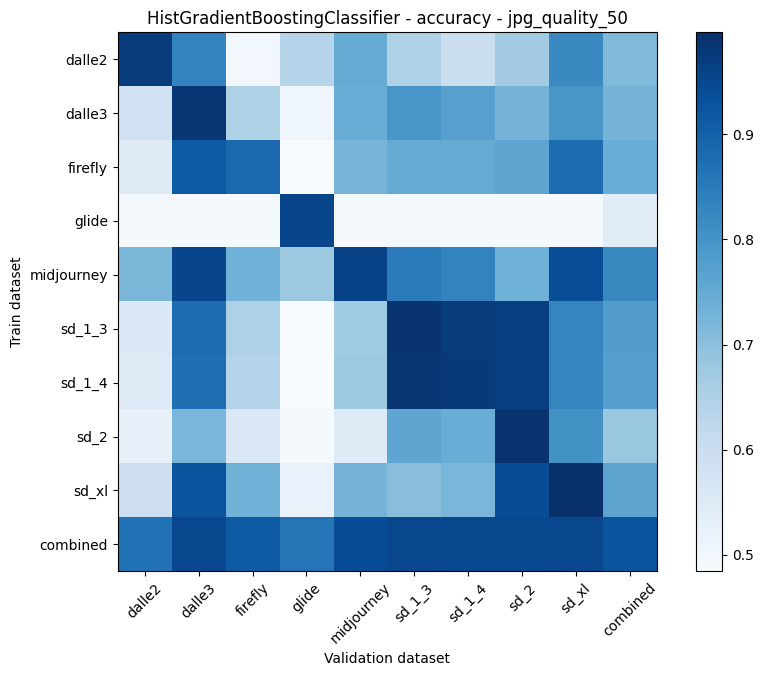

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.971875  0.831250  0.496875  0.637500    0.750000  0.650000   
dalle3         0.584375  0.981250  0.650000  0.506250    0.743750  0.793750   
firefly        0.546875  0.912500  0.884375  0.484375    0.725000  0.750000   
glide          0.493750  0.490625  0.490625  0.953125    0.490625  0.490625   
midjourney     0.718750  0.953125  0.734375  0.678125    0.959375  0.846875   
sd_1_3         0.556250  0.878125  0.650000  0.487500    0.671875  0.987500   
sd_1_4         0.546875  0.871875  0.637500  0.484375    0.678125  0.984375   
sd_2           0.521875  0.721875  0.559375  0.490625    0.546875  0.759375   
sd_xl          0.593750  0.925000  0.734375  0.518750    0.728125  0.703125   
combined       0.868750  0.950000  0.912500  0.862500    0.940625  0.950000   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.600000  0.668750  0.818750  0.713889  
dalle3         0.771875  0.728125  0.793750  0.728125  
firefly        0.750000  0.762500  0.878125  0.743750  
glide          0.490625  0.490625  0.490625  0.542361  
midjourney     0.831250  0.734375  0.937500  0.821528  
sd_1_3         0.971875  0.965625  0.828125  0.777431  
sd_1_4         0.975000  0.965625  0.828125  0.774653  
sd_2           0.743750  0.990625  0.803125  0.681944  
sd_xl          0.721875  0.940625  0.996875  0.762500  
combined       0.946875  0.946875  0.950000  0.925347

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.971875  0.831250  0.496875  0.637500    0.750000  0.650000   
dalle3         0.584375  0.981250  0.650000  0.506250    0.743750  0.793750   
firefly        0.546875  0.912500  0.884375  0.484375    0.725000  0.750000   
glide          0.493750  0.490625  0.490625  0.953125    0.490625  0.490625   
midjourney     0.718750  0.953125  0.734375  0.678125    0.959375  0.846875   
sd_1_3         0.556250  0.878125  0.650000  0.487500    0.671875  0.987500   
sd_1_4         0.546875  0.871875  0.637500  0.484375    0.678125  0.984375   
sd_2           0.521875  0.721875  0.559375  0.490625    0.546875  0.759375   
sd_xl          0.593750  0.925000  0.734375  0.518750    0.728125  0.703125   
combined       0.868750  0.950000  0.912500  0.862500    0.940625  0.950000   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.600000  0.668750  0.818750  0.713889  
dalle3         0.771875  0.728125  0.793750  0.728125  
firefly        0.750000  0.762500  0.878125  0.743750  
glide          0.490625  0.490625  0.490625  0.542361  
midjourney     0.831250  0.734375  0.937500  0.821528  
sd_1_3         0.971875  0.965625  0.828125  0.777431  
sd_1_4         0.975000  0.965625  0.828125  0.774653  
sd_2           0.743750  0.990625  0.803125  0.681944  
sd_xl          0.721875  0.940625  0.996875  0.762500  
combined       0.946875  0.946875  0.950000  0.925347

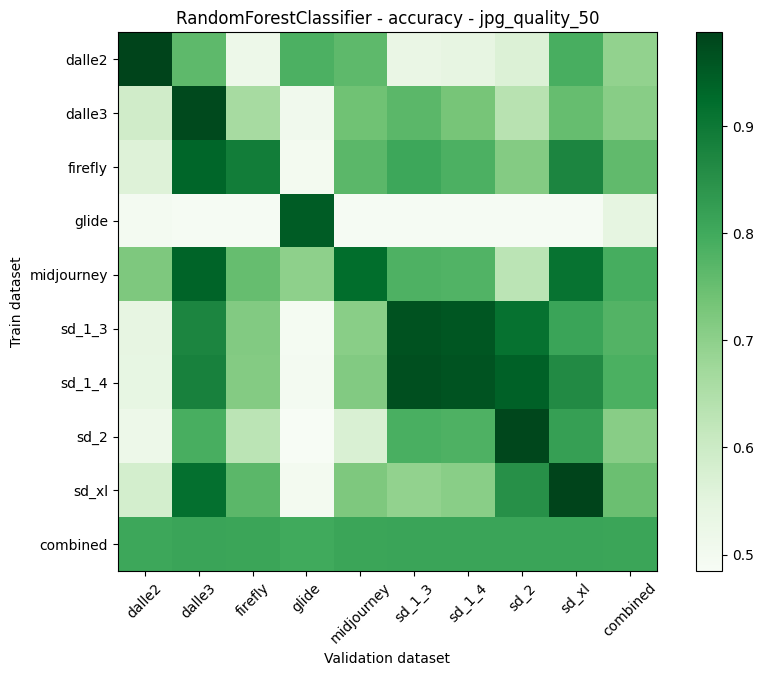

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.987500  0.762500  0.518750  0.784375    0.762500  0.531250   
dalle3         0.590625  0.978125  0.662500  0.509375    0.740625  0.765625   
firefly        0.562500  0.934375  0.890625  0.500000    0.765625  0.806250   
glide          0.496875  0.490625  0.490625  0.950000    0.490625  0.490625   
midjourney     0.721875  0.937500  0.753125  0.700000    0.921875  0.781250   
sd_1_3         0.540625  0.871875  0.715625  0.493750    0.706250  0.965625   
sd_1_4         0.537500  0.881250  0.712500  0.496875    0.715625  0.968750   
sd_2           0.518750  0.790625  0.628125  0.484375    0.571875  0.787500   
sd_xl          0.584375  0.915625  0.765625  0.500000    0.721875  0.693750   
combined       0.806250  0.812500  0.809375  0.800000    0.809375  0.812500   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.540625  0.565625  0.790625  0.693750  
dalle3         0.731250  0.634375  0.753125  0.707292  
firefly        0.784375  0.712500  0.871875  0.758681  
glide          0.490625  0.490625  0.490625  0.542361  
midjourney     0.778125  0.628125  0.909375  0.792361  
sd_1_3         0.959375  0.912500  0.812500  0.775347  
sd_1_4         0.962500  0.940625  0.862500  0.786458  
sd_2           0.781250  0.981250  0.821875  0.707292  
sd_xl          0.706250  0.850000  0.987500  0.747222  
combined       0.812500  0.812500  0.812500  0.809722

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.987500  0.762500  0.518750  0.784375    0.762500  0.531250   
dalle3         0.590625  0.978125  0.662500  0.509375    0.740625  0.765625   
firefly        0.562500  0.934375  0.890625  0.500000    0.765625  0.806250   
glide          0.496875  0.490625  0.490625  0.950000    0.490625  0.490625   
midjourney     0.721875  0.937500  0.753125  0.700000    0.921875  0.781250   
sd_1_3         0.540625  0.871875  0.715625  0.493750    0.706250  0.965625   
sd_1_4         0.537500  0.881250  0.712500  0.496875    0.715625  0.968750   
sd_2           0.518750  0.790625  0.628125  0.484375    0.571875  0.787500   
sd_xl          0.584375  0.915625  0.765625  0.500000    0.721875  0.693750   
combined       0.806250  0.812500  0.809375  0.800000    0.809375  0.812500   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.540625  0.565625  0.790625  0.693750  
dalle3         0.731250  0.634375  0.753125  0.707292  
firefly        0.784375  0.712500  0.871875  0.758681  
glide          0.490625  0.490625  0.490625  0.542361  
midjourney     0.778125  0.628125  0.909375  0.792361  
sd_1_3         0.959375  0.912500  0.812500  0.775347  
sd_1_4         0.962500  0.940625  0.862500  0.786458  
sd_2           0.781250  0.981250  0.821875  0.707292  
sd_xl          0.706250  0.850000  0.987500  0.747222  
combined       0.812500  0.812500  0.812500  0.809722

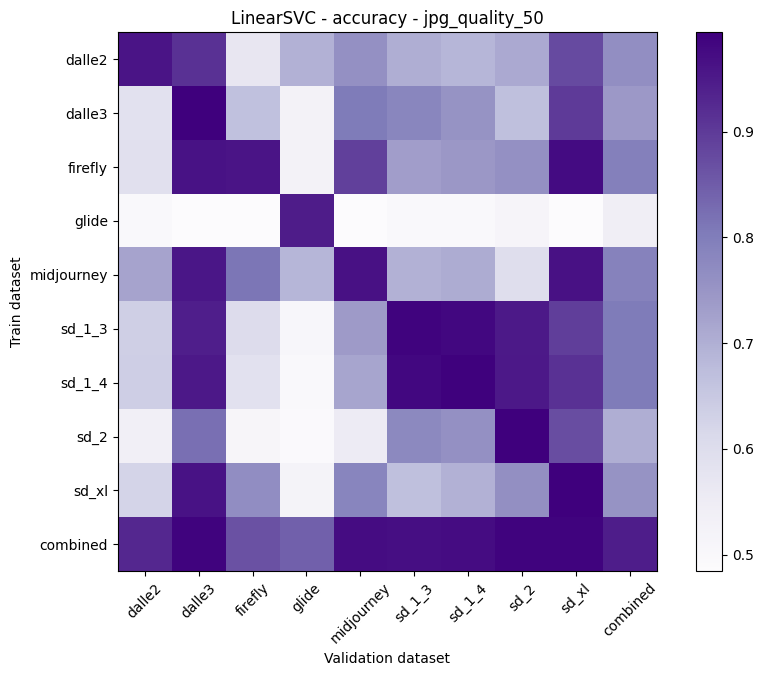

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.959375  0.912500  0.568750  0.696875    0.759375  0.703125   
dalle3         0.587500  0.993750  0.665625  0.525000    0.803125  0.781250   
firefly        0.590625  0.962500  0.959375  0.525000    0.890625  0.731250   
glide          0.496875  0.484375  0.484375  0.946875    0.484375  0.496875   
midjourney     0.721875  0.956250  0.812500  0.687500    0.965625  0.696875   
sd_1_3         0.634375  0.943750  0.603125  0.506250    0.737500  0.987500   
sd_1_4         0.637500  0.953125  0.587500  0.496875    0.718750  0.981250   
sd_2           0.537500  0.821875  0.509375  0.490625    0.553125  0.775000   
sd_xl          0.625000  0.962500  0.765625  0.521875    0.784375  0.668750   
combined       0.928125  0.987500  0.865625  0.843750    0.971875  0.968750   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.687500  0.709375  0.875000  0.763542  
dalle3         0.753125  0.668750  0.900000  0.742014  
firefly        0.743750  0.759375  0.975000  0.793056  
glide          0.496875  0.512500  0.484375  0.543056  
midjourney     0.706250  0.596875  0.965625  0.789931  
sd_1_3         0.981250  0.950000  0.893750  0.804167  
sd_1_4         0.990625  0.953125  0.912500  0.803472  
sd_2           0.759375  0.993750  0.871875  0.701389  
sd_xl          0.696875  0.762500  0.993750  0.753472  
combined       0.971875  0.987500  0.987500  0.945833

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.959375  0.912500  0.568750  0.696875    0.759375  0.703125   
dalle3         0.587500  0.993750  0.665625  0.525000    0.803125  0.781250   
firefly        0.590625  0.962500  0.959375  0.525000    0.890625  0.731250   
glide          0.496875  0.484375  0.484375  0.946875    0.484375  0.496875   
midjourney     0.721875  0.956250  0.812500  0.687500    0.965625  0.696875   
sd_1_3         0.634375  0.943750  0.603125  0.506250    0.737500  0.987500   
sd_1_4         0.637500  0.953125  0.587500  0.496875    0.718750  0.981250   
sd_2           0.537500  0.821875  0.509375  0.490625    0.553125  0.775000   
sd_xl          0.625000  0.962500  0.765625  0.521875    0.784375  0.668750   
combined       0.928125  0.987500  0.865625  0.843750    0.971875  0.968750   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.687500  0.709375  0.875000  0.763542  
dalle3         0.753125  0.668750  0.900000  0.742014  
firefly        0.743750  0.759375  0.975000  0.793056  
glide          0.496875  0.512500  0.484375  0.543056  
midjourney     0.706250  0.596875  0.965625  0.789931  
sd_1_3         0.981250  0.950000  0.893750  0.804167  
sd_1_4         0.990625  0.953125  0.912500  0.803472  
sd_2           0.759375  0.993750  0.871875  0.701389  
sd_xl          0.696875  0.762500  0.993750  0.753472  
combined       0.971875  0.987500  0.987500  0.945833









 ################ Evaluating models trained on standardAugmented and tested on jpg_quality_70. ################


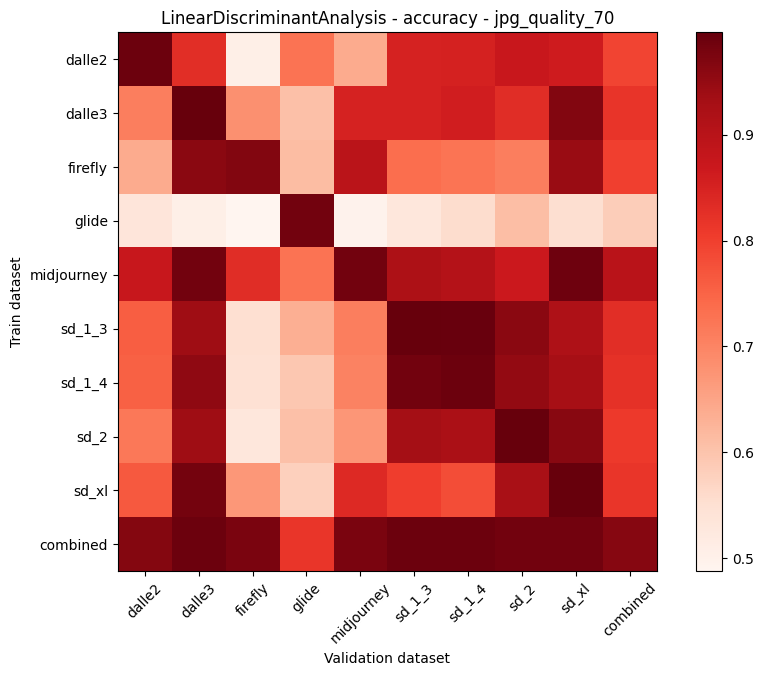

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.990625  0.828125  0.506250  0.728125    0.640625  0.850000   
dalle3         0.709375  0.996875  0.681250  0.606250    0.850000  0.850000   
firefly        0.640625  0.959375  0.968750  0.612500    0.896875  0.734375   
glide          0.534375  0.506250  0.487500  0.984375    0.496875  0.531250   
midjourney     0.875000  0.984375  0.831250  0.728125    0.984375  0.918750   
sd_1_3         0.756250  0.937500  0.550000  0.634375    0.709375  0.996875   
sd_1_4         0.753125  0.953125  0.546875  0.593750    0.703125  0.984375   
sd_2           0.718750  0.937500  0.531250  0.606250    0.671875  0.931250   
sd_xl          0.765625  0.981250  0.668750  0.578125    0.837500  0.803125   
combined       0.965625  0.990625  0.975000  0.815625    0.975000  0.990625   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.853125  0.871875  0.862500  0.792361  
dalle3         0.859375  0.831250  0.968750  0.817014  
firefly        0.725000  0.709375  0.943750  0.798958  
glide          0.556250  0.609375  0.553125  0.584375  
midjourney     0.906250  0.868750  0.987500  0.898264  
sd_1_3         0.993750  0.959375  0.915625  0.828125  
sd_1_4         0.990625  0.950000  0.928125  0.822569  
sd_2           0.921875  0.996875  0.962500  0.808681  
sd_xl          0.781250  0.925000  0.996875  0.815278  
combined       0.990625  0.984375  0.984375  0.963542

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.990625  0.828125  0.506250  0.728125    0.640625  0.850000   
dalle3         0.709375  0.996875  0.681250  0.606250    0.850000  0.850000   
firefly        0.640625  0.959375  0.968750  0.612500    0.896875  0.734375   
glide          0.534375  0.506250  0.487500  0.984375    0.496875  0.531250   
midjourney     0.875000  0.984375  0.831250  0.728125    0.984375  0.918750   
sd_1_3         0.756250  0.937500  0.550000  0.634375    0.709375  0.996875   
sd_1_4         0.753125  0.953125  0.546875  0.593750    0.703125  0.984375   
sd_2           0.718750  0.937500  0.531250  0.606250    0.671875  0.931250   
sd_xl          0.765625  0.981250  0.668750  0.578125    0.837500  0.803125   
combined       0.965625  0.990625  0.975000  0.815625    0.975000  0.990625   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.853125  0.871875  0.862500  0.792361  
dalle3         0.859375  0.831250  0.968750  0.817014  
firefly        0.725000  0.709375  0.943750  0.798958  
glide          0.556250  0.609375  0.553125  0.584375  
midjourney     0.906250  0.868750  0.987500  0.898264  
sd_1_3         0.993750  0.959375  0.915625  0.828125  
sd_1_4         0.990625  0.950000  0.928125  0.822569  
sd_2           0.921875  0.996875  0.962500  0.808681  
sd_xl          0.781250  0.925000  0.996875  0.815278  
combined       0.990625  0.984375  0.984375  0.963542

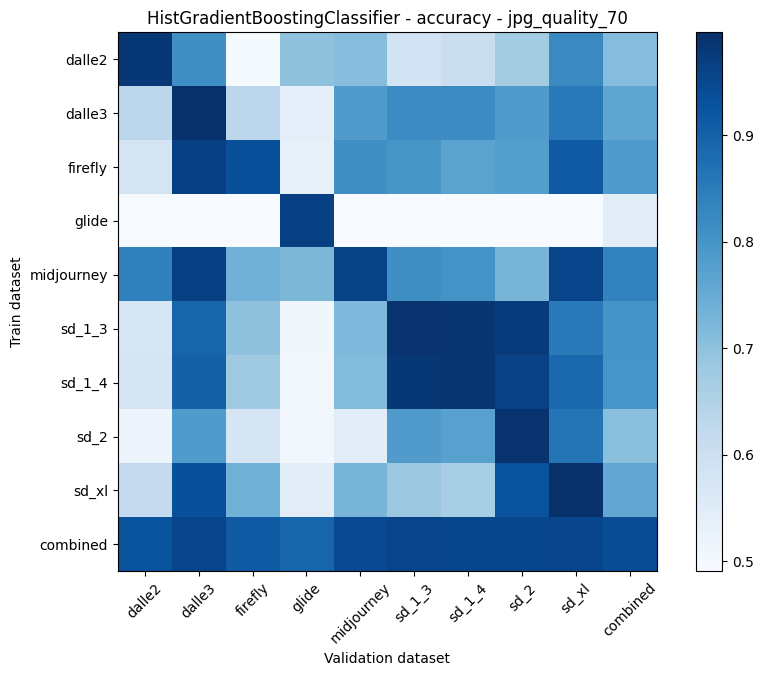

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.981250  0.812500  0.496875  0.700000    0.709375  0.584375   
dalle3         0.631250  0.996875  0.631250  0.540625    0.784375  0.818750   
firefly        0.581250  0.965625  0.934375  0.531250    0.812500  0.796875   
glide          0.493750  0.490625  0.490625  0.965625    0.490625  0.490625   
midjourney     0.840625  0.965625  0.734375  0.721875    0.959375  0.812500   
sd_1_3         0.571875  0.893750  0.700000  0.509375    0.718750  0.990625   
sd_1_4         0.575000  0.900000  0.678125  0.506250    0.712500  0.981250   
sd_2           0.515625  0.784375  0.575000  0.503125    0.543750  0.784375   
sd_xl          0.618750  0.934375  0.737500  0.543750    0.728125  0.684375   
combined       0.928125  0.956250  0.915625  0.893750    0.946875  0.956250   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.603125  0.671875  0.821875  0.709028  
dalle3         0.818750  0.784375  0.853125  0.762153  
firefly        0.768750  0.778125  0.915625  0.787153  
glide          0.490625  0.490625  0.490625  0.543750  
midjourney     0.803125  0.728125  0.956250  0.835764  
sd_1_3         0.987500  0.975000  0.853125  0.800000  
sd_1_4         0.987500  0.962500  0.884375  0.798611  
sd_2           0.771875  0.990625  0.862500  0.703472  
sd_xl          0.665625  0.928125  0.993750  0.759375  
combined       0.953125  0.953125  0.956250  0.939931

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.981250  0.812500  0.496875  0.700000    0.709375  0.584375   
dalle3         0.631250  0.996875  0.631250  0.540625    0.784375  0.818750   
firefly        0.581250  0.965625  0.934375  0.531250    0.812500  0.796875   
glide          0.493750  0.490625  0.490625  0.965625    0.490625  0.490625   
midjourney     0.840625  0.965625  0.734375  0.721875    0.959375  0.812500   
sd_1_3         0.571875  0.893750  0.700000  0.509375    0.718750  0.990625   
sd_1_4         0.575000  0.900000  0.678125  0.506250    0.712500  0.981250   
sd_2           0.515625  0.784375  0.575000  0.503125    0.543750  0.784375   
sd_xl          0.618750  0.934375  0.737500  0.543750    0.728125  0.684375   
combined       0.928125  0.956250  0.915625  0.893750    0.946875  0.956250   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.603125  0.671875  0.821875  0.709028  
dalle3         0.818750  0.784375  0.853125  0.762153  
firefly        0.768750  0.778125  0.915625  0.787153  
glide          0.490625  0.490625  0.490625  0.543750  
midjourney     0.803125  0.728125  0.956250  0.835764  
sd_1_3         0.987500  0.975000  0.853125  0.800000  
sd_1_4         0.987500  0.962500  0.884375  0.798611  
sd_2           0.771875  0.990625  0.862500  0.703472  
sd_xl          0.665625  0.928125  0.993750  0.759375  
combined       0.953125  0.953125  0.956250  0.939931

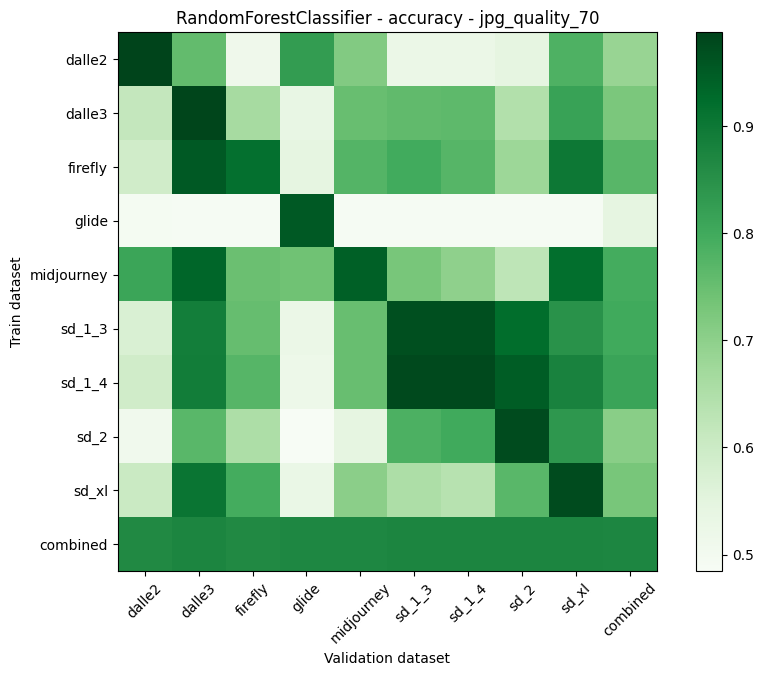

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.987500  0.756250  0.512500  0.828125    0.715625  0.525000   
dalle3         0.615625  0.984375  0.662500  0.534375    0.750000  0.759375   
firefly        0.590625  0.953125  0.915625  0.543750    0.775000  0.796875   
glide          0.493750  0.490625  0.490625  0.953125    0.490625  0.490625   
midjourney     0.809375  0.934375  0.746875  0.740625    0.943750  0.728125   
sd_1_3         0.571875  0.887500  0.753125  0.525000    0.750000  0.968750   
sd_1_4         0.590625  0.890625  0.771875  0.518750    0.750000  0.978125   
sd_2           0.506250  0.768750  0.653125  0.484375    0.543750  0.784375   
sd_xl          0.603125  0.906250  0.793750  0.528125    0.703125  0.653125   
combined       0.865625  0.871875  0.865625  0.868750    0.868750  0.871875   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.525000  0.543750  0.781250  0.686111  
dalle3         0.762500  0.643750  0.815625  0.725347  
firefly        0.771875  0.678125  0.900000  0.769444  
glide          0.490625  0.490625  0.490625  0.542361  
midjourney     0.696875  0.625000  0.918750  0.793750  
sd_1_3         0.968750  0.921875  0.846875  0.799306  
sd_1_4         0.978125  0.946875  0.878125  0.811458  
sd_2           0.800000  0.975000  0.837500  0.705903  
sd_xl          0.637500  0.768750  0.975000  0.729861  
combined       0.871875  0.871875  0.871875  0.869792

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.987500  0.756250  0.512500  0.828125    0.715625  0.525000   
dalle3         0.615625  0.984375  0.662500  0.534375    0.750000  0.759375   
firefly        0.590625  0.953125  0.915625  0.543750    0.775000  0.796875   
glide          0.493750  0.490625  0.490625  0.953125    0.490625  0.490625   
midjourney     0.809375  0.934375  0.746875  0.740625    0.943750  0.728125   
sd_1_3         0.571875  0.887500  0.753125  0.525000    0.750000  0.968750   
sd_1_4         0.590625  0.890625  0.771875  0.518750    0.750000  0.978125   
sd_2           0.506250  0.768750  0.653125  0.484375    0.543750  0.784375   
sd_xl          0.603125  0.906250  0.793750  0.528125    0.703125  0.653125   
combined       0.865625  0.871875  0.865625  0.868750    0.868750  0.871875   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.525000  0.543750  0.781250  0.686111  
dalle3         0.762500  0.643750  0.815625  0.725347  
firefly        0.771875  0.678125  0.900000  0.769444  
glide          0.490625  0.490625  0.490625  0.542361  
midjourney     0.696875  0.625000  0.918750  0.793750  
sd_1_3         0.968750  0.921875  0.846875  0.799306  
sd_1_4         0.978125  0.946875  0.878125  0.811458  
sd_2           0.800000  0.975000  0.837500  0.705903  
sd_xl          0.637500  0.768750  0.975000  0.729861  
combined       0.871875  0.871875  0.871875  0.869792

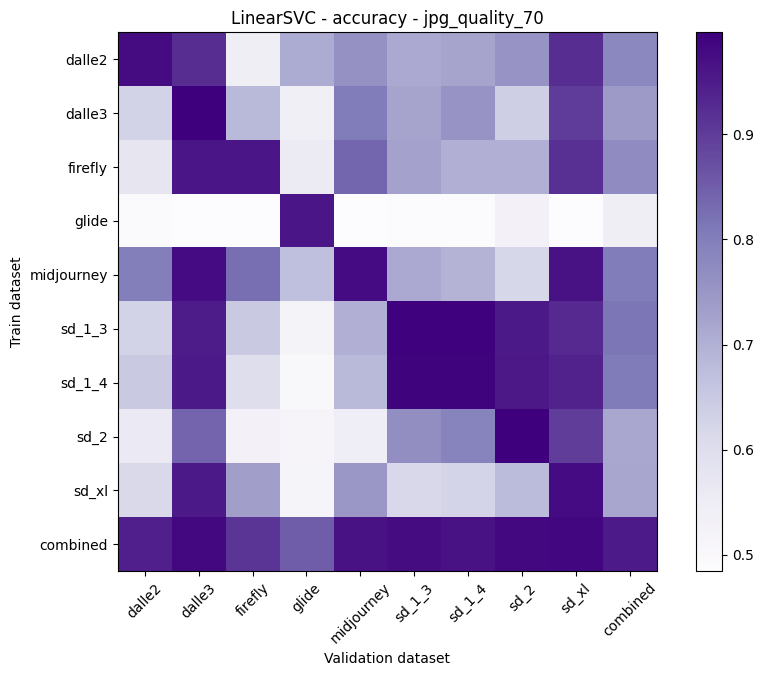

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.975000  0.921875  0.543750  0.709375    0.759375  0.712500   
dalle3         0.628125  0.996875  0.681250  0.537500    0.803125  0.721875   
firefly        0.575000  0.959375  0.959375  0.556250    0.837500  0.728125   
glide          0.493750  0.484375  0.484375  0.959375    0.484375  0.487500   
midjourney     0.800000  0.978125  0.825000  0.668750    0.978125  0.712500   
sd_1_3         0.628125  0.950000  0.646875  0.521875    0.700000  0.993750   
sd_1_4         0.646875  0.953125  0.596875  0.503125    0.681250  0.990625   
sd_2           0.559375  0.840625  0.528125  0.512500    0.546875  0.765625   
sd_xl          0.612500  0.953125  0.731250  0.515625    0.746875  0.615625   
combined       0.943750  0.981250  0.909375  0.850000    0.968750  0.975000   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.721875  0.753125  0.921875  0.779861  
dalle3         0.753125  0.637500  0.900000  0.739931  
firefly        0.700000  0.700000  0.918750  0.770486  
glide          0.487500  0.528125  0.484375  0.543750  
midjourney     0.693750  0.618750  0.965625  0.804514  
sd_1_3         0.993750  0.953125  0.928125  0.812847  
sd_1_4         0.990625  0.956250  0.940625  0.806597  
sd_2           0.787500  0.996875  0.896875  0.714931  
sd_xl          0.625000  0.678125  0.978125  0.717361  
combined       0.968750  0.981250  0.984375  0.951389

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.975000  0.921875  0.543750  0.709375    0.759375  0.712500   
dalle3         0.628125  0.996875  0.681250  0.537500    0.803125  0.721875   
firefly        0.575000  0.959375  0.959375  0.556250    0.837500  0.728125   
glide          0.493750  0.484375  0.484375  0.959375    0.484375  0.487500   
midjourney     0.800000  0.978125  0.825000  0.668750    0.978125  0.712500   
sd_1_3         0.628125  0.950000  0.646875  0.521875    0.700000  0.993750   
sd_1_4         0.646875  0.953125  0.596875  0.503125    0.681250  0.990625   
sd_2           0.559375  0.840625  0.528125  0.512500    0.546875  0.765625   
sd_xl          0.612500  0.953125  0.731250  0.515625    0.746875  0.615625   
combined       0.943750  0.981250  0.909375  0.850000    0.968750  0.975000   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.721875  0.753125  0.921875  0.779861  
dalle3         0.753125  0.637500  0.900000  0.739931  
firefly        0.700000  0.700000  0.918750  0.770486  
glide          0.487500  0.528125  0.484375  0.543750  
midjourney     0.693750  0.618750  0.965625  0.804514  
sd_1_3         0.993750  0.953125  0.928125  0.812847  
sd_1_4         0.990625  0.956250  0.940625  0.806597  
sd_2           0.787500  0.996875  0.896875  0.714931  
sd_xl          0.625000  0.678125  0.978125  0.717361  
combined       0.968750  0.981250  0.984375  0.951389









 ################ Evaluating models trained on standardAugmented and tested on jpg_quality_90. ################


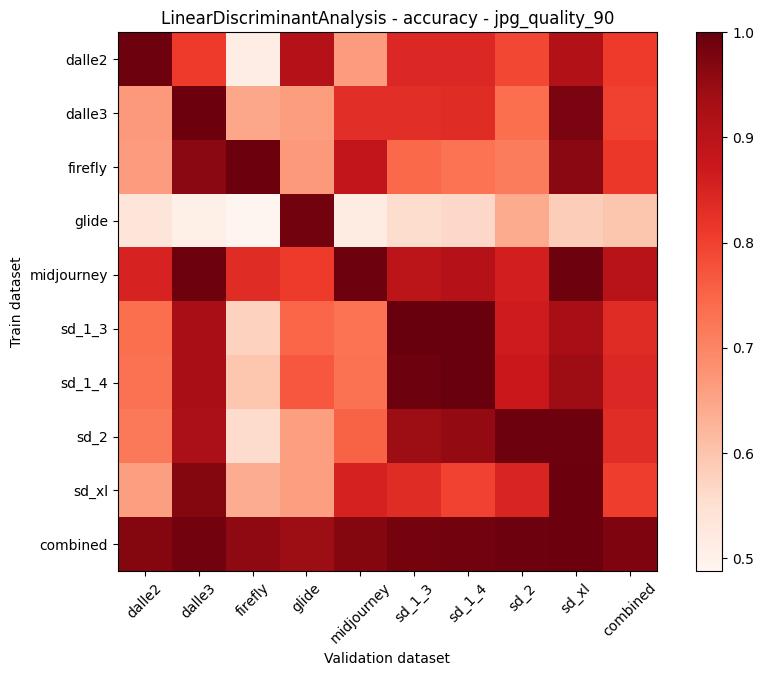

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.990625  0.809375  0.512500  0.909375    0.665625  0.840625   
dalle3         0.668750  0.993750  0.646875  0.662500    0.831250  0.831250   
firefly        0.665625  0.962500  0.993750  0.668750    0.887500  0.743750   
glide          0.537500  0.506250  0.487500  0.987500    0.515625  0.556250   
midjourney     0.850000  0.990625  0.834375  0.809375    0.990625  0.896875   
sd_1_3         0.737500  0.931250  0.575000  0.746875    0.728125  1.000000   
sd_1_4         0.731250  0.931250  0.596875  0.768750    0.731250  0.990625   
sd_2           0.718750  0.925000  0.559375  0.659375    0.753125  0.943750   
sd_xl          0.659375  0.968750  0.637500  0.659375    0.853125  0.834375   
combined       0.968750  0.987500  0.956250  0.943750    0.968750  0.984375   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.840625  0.790625  0.912500  0.807986  
dalle3         0.834375  0.734375  0.978125  0.797917  
firefly        0.728125  0.715625  0.962500  0.814236  
glide          0.565625  0.640625  0.584375  0.597917  
midjourney     0.909375  0.859375  0.990625  0.903472  
sd_1_3         0.996875  0.865625  0.928125  0.834375  
sd_1_4         0.996875  0.871875  0.940625  0.839931  
sd_2           0.953125  0.990625  0.990625  0.832639  
sd_xl          0.796875  0.846875  0.993750  0.805556  
combined       0.987500  0.990625  0.993750  0.975694

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.990625  0.809375  0.512500  0.909375    0.665625  0.840625   
dalle3         0.668750  0.993750  0.646875  0.662500    0.831250  0.831250   
firefly        0.665625  0.962500  0.993750  0.668750    0.887500  0.743750   
glide          0.537500  0.506250  0.487500  0.987500    0.515625  0.556250   
midjourney     0.850000  0.990625  0.834375  0.809375    0.990625  0.896875   
sd_1_3         0.737500  0.931250  0.575000  0.746875    0.728125  1.000000   
sd_1_4         0.731250  0.931250  0.596875  0.768750    0.731250  0.990625   
sd_2           0.718750  0.925000  0.559375  0.659375    0.753125  0.943750   
sd_xl          0.659375  0.968750  0.637500  0.659375    0.853125  0.834375   
combined       0.968750  0.987500  0.956250  0.943750    0.968750  0.984375   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.840625  0.790625  0.912500  0.807986  
dalle3         0.834375  0.734375  0.978125  0.797917  
firefly        0.728125  0.715625  0.962500  0.814236  
glide          0.565625  0.640625  0.584375  0.597917  
midjourney     0.909375  0.859375  0.990625  0.903472  
sd_1_3         0.996875  0.865625  0.928125  0.834375  
sd_1_4         0.996875  0.871875  0.940625  0.839931  
sd_2           0.953125  0.990625  0.990625  0.832639  
sd_xl          0.796875  0.846875  0.993750  0.805556  
combined       0.987500  0.990625  0.993750  0.975694

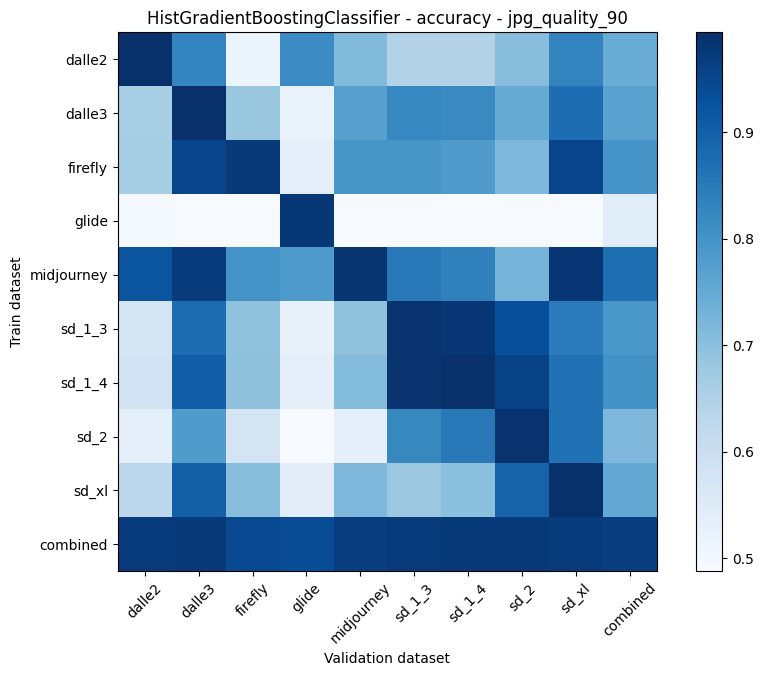

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.993750  0.828125  0.518750  0.815625    0.712500  0.646875   
dalle3         0.662500  0.990625  0.684375  0.521875    0.771875  0.825000   
firefly        0.665625  0.953125  0.975000  0.537500    0.793750  0.793750   
glide          0.493750  0.490625  0.490625  0.978125    0.490625  0.490625   
midjourney     0.921875  0.968750  0.800000  0.784375    0.984375  0.853125   
sd_1_3         0.575000  0.875000  0.693750  0.525000    0.693750  0.987500   
sd_1_4         0.581250  0.903125  0.696875  0.531250    0.709375  0.987500   
sd_2           0.531250  0.781250  0.578125  0.487500    0.534375  0.821875   
sd_xl          0.628125  0.900000  0.703125  0.540625    0.715625  0.681250   
combined       0.971875  0.975000  0.943750  0.937500    0.965625  0.971875   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.646875  0.703125  0.831250  0.744097  
dalle3         0.818750  0.750000  0.875000  0.766667  
firefly        0.781250  0.715625  0.953125  0.796528  
glide          0.490625  0.490625  0.490625  0.545139  
midjourney     0.834375  0.728125  0.981250  0.872917  
sd_1_3         0.981250  0.934375  0.846875  0.790278  
sd_1_4         0.993750  0.956250  0.865625  0.802778  
sd_2           0.853125  0.987500  0.865625  0.715625  
sd_xl          0.700000  0.893750  0.993750  0.750694  
combined       0.975000  0.975000  0.971875  0.965278

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.993750  0.828125  0.518750  0.815625    0.712500  0.646875   
dalle3         0.662500  0.990625  0.684375  0.521875    0.771875  0.825000   
firefly        0.665625  0.953125  0.975000  0.537500    0.793750  0.793750   
glide          0.493750  0.490625  0.490625  0.978125    0.490625  0.490625   
midjourney     0.921875  0.968750  0.800000  0.784375    0.984375  0.853125   
sd_1_3         0.575000  0.875000  0.693750  0.525000    0.693750  0.987500   
sd_1_4         0.581250  0.903125  0.696875  0.531250    0.709375  0.987500   
sd_2           0.531250  0.781250  0.578125  0.487500    0.534375  0.821875   
sd_xl          0.628125  0.900000  0.703125  0.540625    0.715625  0.681250   
combined       0.971875  0.975000  0.943750  0.937500    0.965625  0.971875   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.646875  0.703125  0.831250  0.744097  
dalle3         0.818750  0.750000  0.875000  0.766667  
firefly        0.781250  0.715625  0.953125  0.796528  
glide          0.490625  0.490625  0.490625  0.545139  
midjourney     0.834375  0.728125  0.981250  0.872917  
sd_1_3         0.981250  0.934375  0.846875  0.790278  
sd_1_4         0.993750  0.956250  0.865625  0.802778  
sd_2           0.853125  0.987500  0.865625  0.715625  
sd_xl          0.700000  0.893750  0.993750  0.750694  
combined       0.975000  0.975000  0.971875  0.965278

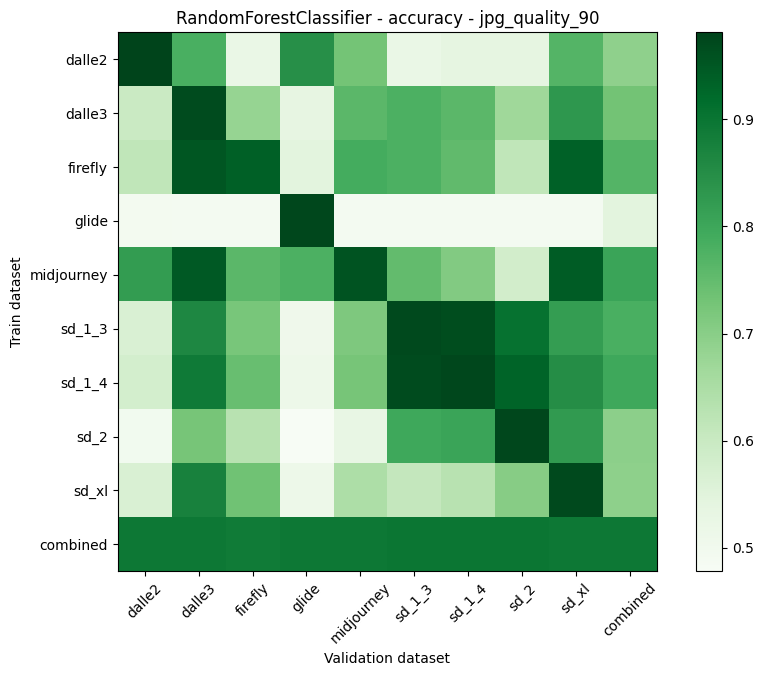

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.981250  0.781250  0.521875  0.846875    0.728125  0.521875   
dalle3         0.596875  0.968750  0.681250  0.534375    0.759375  0.778125   
firefly        0.615625  0.953125  0.937500  0.543750    0.787500  0.778125   
glide          0.493750  0.490625  0.490625  0.975000    0.490625  0.490625   
midjourney     0.821875  0.946875  0.759375  0.778125    0.956250  0.750000   
sd_1_3         0.565625  0.862500  0.721875  0.506250    0.715625  0.971875   
sd_1_4         0.578125  0.890625  0.743750  0.512500    0.725000  0.968750   
sd_2           0.496875  0.725000  0.628125  0.478125    0.528125  0.796875   
sd_xl          0.565625  0.875000  0.734375  0.512500    0.646875  0.609375   
combined       0.893750  0.893750  0.887500  0.893750    0.893750  0.896875   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.537500  0.537500  0.768750  0.691667  
dalle3         0.759375  0.668750  0.831250  0.730903  
firefly        0.753125  0.615625  0.934375  0.768750  
glide          0.490625  0.490625  0.490625  0.544792  
midjourney     0.709375  0.581250  0.943750  0.805208  
sd_1_3         0.965625  0.906250  0.818750  0.781597  
sd_1_4         0.975000  0.931250  0.850000  0.797222  
sd_2           0.806250  0.975000  0.825000  0.695486  
sd_xl          0.628125  0.703125  0.971875  0.694097  
combined       0.896875  0.896875  0.893750  0.894097

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.981250  0.781250  0.521875  0.846875    0.728125  0.521875   
dalle3         0.596875  0.968750  0.681250  0.534375    0.759375  0.778125   
firefly        0.615625  0.953125  0.937500  0.543750    0.787500  0.778125   
glide          0.493750  0.490625  0.490625  0.975000    0.490625  0.490625   
midjourney     0.821875  0.946875  0.759375  0.778125    0.956250  0.750000   
sd_1_3         0.565625  0.862500  0.721875  0.506250    0.715625  0.971875   
sd_1_4         0.578125  0.890625  0.743750  0.512500    0.725000  0.968750   
sd_2           0.496875  0.725000  0.628125  0.478125    0.528125  0.796875   
sd_xl          0.565625  0.875000  0.734375  0.512500    0.646875  0.609375   
combined       0.893750  0.893750  0.887500  0.893750    0.893750  0.896875   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.537500  0.537500  0.768750  0.691667  
dalle3         0.759375  0.668750  0.831250  0.730903  
firefly        0.753125  0.615625  0.934375  0.768750  
glide          0.490625  0.490625  0.490625  0.544792  
midjourney     0.709375  0.581250  0.943750  0.805208  
sd_1_3         0.965625  0.906250  0.818750  0.781597  
sd_1_4         0.975000  0.931250  0.850000  0.797222  
sd_2           0.806250  0.975000  0.825000  0.695486  
sd_xl          0.628125  0.703125  0.971875  0.694097  
combined       0.896875  0.896875  0.893750  0.894097

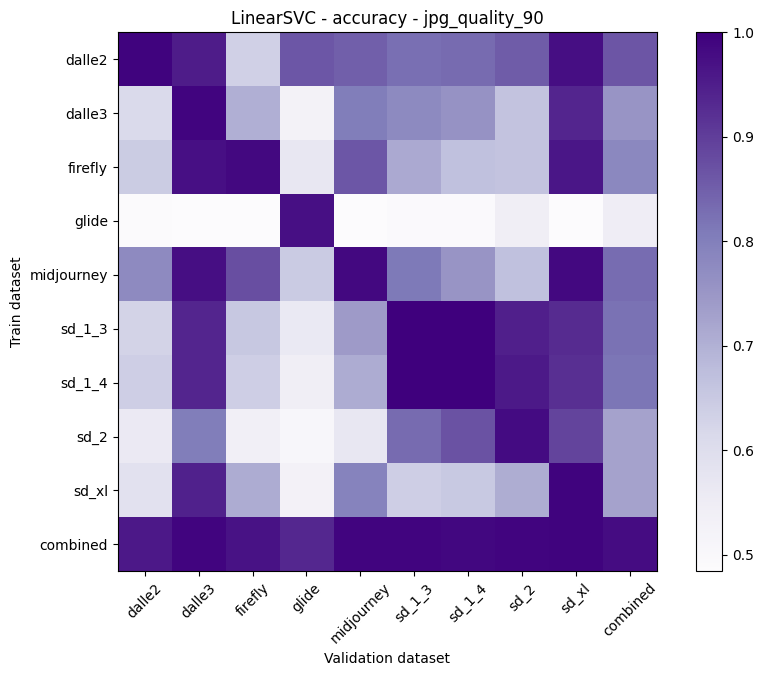

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.993750  0.953125  0.634375  0.862500    0.850000  0.825000   
dalle3         0.612500  0.990625  0.703125  0.525000    0.803125  0.778125   
firefly        0.643750  0.971875  0.984375  0.568750    0.862500  0.712500   
glide          0.487500  0.484375  0.484375  0.971875    0.484375  0.490625   
midjourney     0.775000  0.975000  0.875000  0.646875    0.984375  0.809375   
sd_1_3         0.628125  0.937500  0.653125  0.562500    0.740625  1.000000   
sd_1_4         0.637500  0.937500  0.637500  0.543750    0.709375  1.000000   
sd_2           0.559375  0.803125  0.537500  0.506250    0.568750  0.831250   
sd_xl          0.587500  0.943750  0.709375  0.528125    0.790625  0.637500   
combined       0.959375  0.990625  0.968750  0.934375    0.990625  0.990625   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.831250  0.853125  0.975000  0.864236  
dalle3         0.759375  0.662500  0.937500  0.752431  
firefly        0.668750  0.662500  0.962500  0.781944  
glide          0.490625  0.543750  0.484375  0.546875  
midjourney     0.753125  0.668750  0.984375  0.830208  
sd_1_3         1.000000  0.946875  0.928125  0.821875  
sd_1_4         1.000000  0.956250  0.921875  0.815972  
sd_2           0.868750  0.981250  0.890625  0.727431  
sd_xl          0.650000  0.706250  0.993750  0.727431  
combined       0.987500  0.990625  0.993750  0.978472

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.993750  0.953125  0.634375  0.862500    0.850000  0.825000   
dalle3         0.612500  0.990625  0.703125  0.525000    0.803125  0.778125   
firefly        0.643750  0.971875  0.984375  0.568750    0.862500  0.712500   
glide          0.487500  0.484375  0.484375  0.971875    0.484375  0.490625   
midjourney     0.775000  0.975000  0.875000  0.646875    0.984375  0.809375   
sd_1_3         0.628125  0.937500  0.653125  0.562500    0.740625  1.000000   
sd_1_4         0.637500  0.937500  0.637500  0.543750    0.709375  1.000000   
sd_2           0.559375  0.803125  0.537500  0.506250    0.568750  0.831250   
sd_xl          0.587500  0.943750  0.709375  0.528125    0.790625  0.637500   
combined       0.959375  0.990625  0.968750  0.934375    0.990625  0.990625   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.831250  0.853125  0.975000  0.864236  
dalle3         0.759375  0.662500  0.937500  0.752431  
firefly        0.668750  0.662500  0.962500  0.781944  
glide          0.490625  0.543750  0.484375  0.546875  
midjourney     0.753125  0.668750  0.984375  0.830208  
sd_1_3         1.000000  0.946875  0.928125  0.821875  
sd_1_4         1.000000  0.956250  0.921875  0.815972  
sd_2           0.868750  0.981250  0.890625  0.727431  
sd_xl          0.650000  0.706250  0.993750  0.727431  
combined       0.987500  0.990625  0.993750  0.978472









 ################ Evaluating models trained on standardAugmented and tested on jpg_quality_80. ################


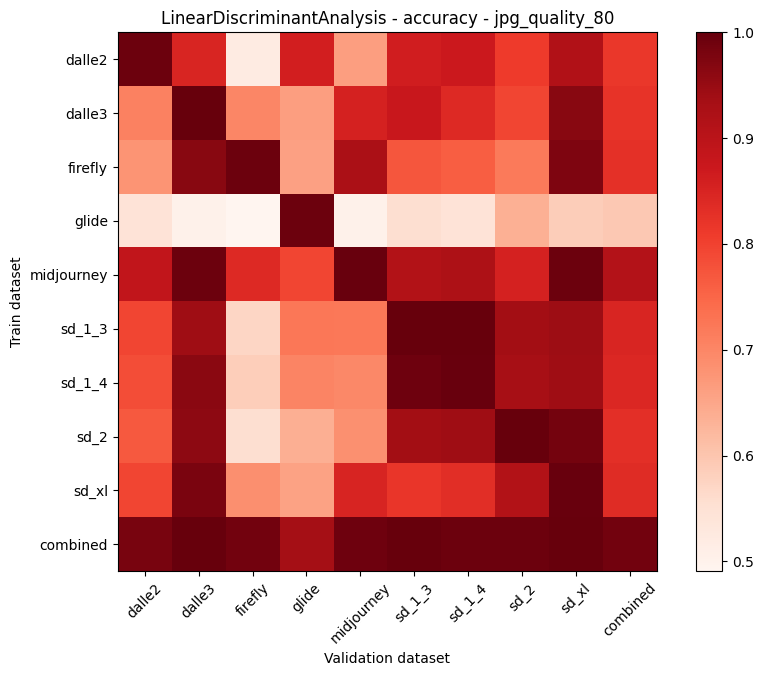

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.993750  0.846875  0.518750  0.859375    0.662500  0.862500   
dalle3         0.709375  1.000000  0.700000  0.662500    0.856250  0.875000   
firefly        0.678125  0.965625  0.993750  0.659375    0.925000  0.771875   
glide          0.543750  0.503125  0.490625  0.993750    0.503125  0.556250   
midjourney     0.887500  0.993750  0.840625  0.793750    0.996875  0.912500   
sd_1_3         0.793750  0.940625  0.571875  0.725000    0.721875  1.000000   
sd_1_4         0.784375  0.962500  0.584375  0.703125    0.696875  0.990625   
sd_2           0.768750  0.959375  0.556250  0.637500    0.684375  0.937500   
sd_xl          0.793750  0.978125  0.687500  0.656250    0.850000  0.818750   
combined       0.981250  1.000000  0.987500  0.934375    0.990625  1.000000   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.871875  0.809375  0.915625  0.815625  
dalle3         0.840625  0.793750  0.965625  0.822569  
firefly        0.759375  0.718750  0.975000  0.827431  
glide          0.543750  0.634375  0.587500  0.595139  
midjourney     0.921875  0.856250  0.993750  0.910764  
sd_1_3         1.000000  0.937500  0.943750  0.848264  
sd_1_4         0.996875  0.931250  0.940625  0.843403  
sd_2           0.940625  1.000000  0.984375  0.829861  
sd_xl          0.831250  0.912500  0.996875  0.836111  
combined       0.993750  0.993750  1.000000  0.986806

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.993750  0.846875  0.518750  0.859375    0.662500  0.862500   
dalle3         0.709375  1.000000  0.700000  0.662500    0.856250  0.875000   
firefly        0.678125  0.965625  0.993750  0.659375    0.925000  0.771875   
glide          0.543750  0.503125  0.490625  0.993750    0.503125  0.556250   
midjourney     0.887500  0.993750  0.840625  0.793750    0.996875  0.912500   
sd_1_3         0.793750  0.940625  0.571875  0.725000    0.721875  1.000000   
sd_1_4         0.784375  0.962500  0.584375  0.703125    0.696875  0.990625   
sd_2           0.768750  0.959375  0.556250  0.637500    0.684375  0.937500   
sd_xl          0.793750  0.978125  0.687500  0.656250    0.850000  0.818750   
combined       0.981250  1.000000  0.987500  0.934375    0.990625  1.000000   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.871875  0.809375  0.915625  0.815625  
dalle3         0.840625  0.793750  0.965625  0.822569  
firefly        0.759375  0.718750  0.975000  0.827431  
glide          0.543750  0.634375  0.587500  0.595139  
midjourney     0.921875  0.856250  0.993750  0.910764  
sd_1_3         1.000000  0.937500  0.943750  0.848264  
sd_1_4         0.996875  0.931250  0.940625  0.843403  
sd_2           0.940625  1.000000  0.984375  0.829861  
sd_xl          0.831250  0.912500  0.996875  0.836111  
combined       0.993750  0.993750  1.000000  0.986806

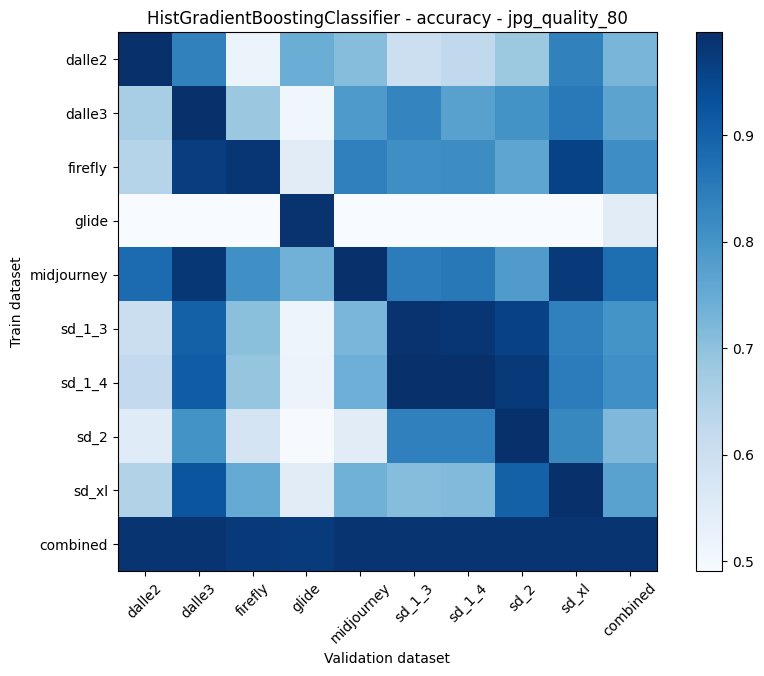

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.993750  0.837500  0.521875  0.743750    0.709375  0.600000   
dalle3         0.665625  0.996875  0.684375  0.509375    0.787500  0.831250   
firefly        0.643750  0.968750  0.984375  0.546875    0.840625  0.812500   
glide          0.490625  0.490625  0.490625  0.990625    0.490625  0.490625   
midjourney     0.881250  0.981250  0.809375  0.734375    0.996875  0.846875   
sd_1_3         0.603125  0.900000  0.703125  0.515625    0.725000  0.990625   
sd_1_4         0.621875  0.909375  0.690625  0.518750    0.740625  0.993750   
sd_2           0.550000  0.803125  0.581250  0.493750    0.546875  0.840625   
sd_xl          0.650000  0.925000  0.753125  0.546875    0.737500  0.709375   
combined       0.987500  0.987500  0.978125  0.975000    0.987500  0.987500   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.625000  0.681250  0.837500  0.727778  
dalle3         0.771875  0.803125  0.853125  0.767014  
firefly        0.815625  0.762500  0.959375  0.814931  
glide          0.490625  0.490625  0.490625  0.546181  
midjourney     0.856250  0.784375  0.978125  0.874306  
sd_1_3         0.984375  0.962500  0.840625  0.802778  
sd_1_4         0.993750  0.978125  0.846875  0.810417  
sd_2           0.840625  0.996875  0.825000  0.719792  
sd_xl          0.715625  0.900000  0.996875  0.770486  
combined       0.987500  0.987500  0.987500  0.985069

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.993750  0.837500  0.521875  0.743750    0.709375  0.600000   
dalle3         0.665625  0.996875  0.684375  0.509375    0.787500  0.831250   
firefly        0.643750  0.968750  0.984375  0.546875    0.840625  0.812500   
glide          0.490625  0.490625  0.490625  0.990625    0.490625  0.490625   
midjourney     0.881250  0.981250  0.809375  0.734375    0.996875  0.846875   
sd_1_3         0.603125  0.900000  0.703125  0.515625    0.725000  0.990625   
sd_1_4         0.621875  0.909375  0.690625  0.518750    0.740625  0.993750   
sd_2           0.550000  0.803125  0.581250  0.493750    0.546875  0.840625   
sd_xl          0.650000  0.925000  0.753125  0.546875    0.737500  0.709375   
combined       0.987500  0.987500  0.978125  0.975000    0.987500  0.987500   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.625000  0.681250  0.837500  0.727778  
dalle3         0.771875  0.803125  0.853125  0.767014  
firefly        0.815625  0.762500  0.959375  0.814931  
glide          0.490625  0.490625  0.490625  0.546181  
midjourney     0.856250  0.784375  0.978125  0.874306  
sd_1_3         0.984375  0.962500  0.840625  0.802778  
sd_1_4         0.993750  0.978125  0.846875  0.810417  
sd_2           0.840625  0.996875  0.825000  0.719792  
sd_xl          0.715625  0.900000  0.996875  0.770486  
combined       0.987500  0.987500  0.987500  0.985069

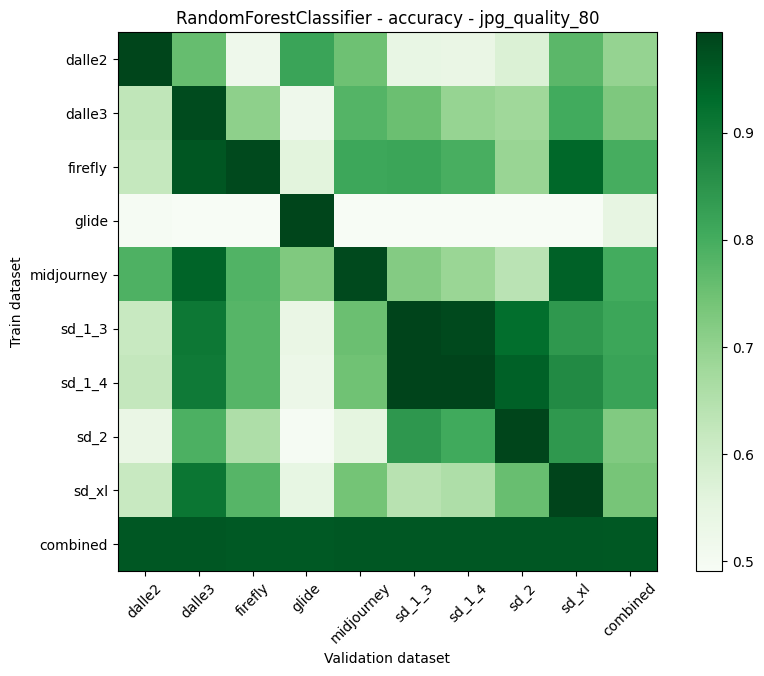

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.990625  0.759375  0.521875  0.818750    0.750000  0.540625   
dalle3         0.628125  0.981250  0.706250  0.521875    0.781250  0.753125   
firefly        0.618750  0.965625  0.984375  0.559375    0.812500  0.815625   
glide          0.496875  0.490625  0.490625  0.990625    0.490625  0.490625   
midjourney     0.787500  0.943750  0.784375  0.725000    0.984375  0.718750   
sd_1_3         0.612500  0.906250  0.778125  0.537500    0.753125  0.993750   
sd_1_4         0.621875  0.903125  0.778125  0.528125    0.746875  0.993750   
sd_2           0.537500  0.790625  0.656250  0.496875    0.553125  0.843750   
sd_xl          0.612500  0.909375  0.778125  0.543750    0.740625  0.640625   
combined       0.962500  0.962500  0.959375  0.959375    0.962500  0.962500   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.537500  0.575000  0.771875  0.696181  
dalle3         0.693750  0.681250  0.803125  0.727778  
firefly        0.796875  0.690625  0.937500  0.797917  
glide          0.490625  0.490625  0.490625  0.546875  
midjourney     0.687500  0.637500  0.946875  0.801736  
sd_1_3         0.984375  0.925000  0.840625  0.814583  
sd_1_4         0.993750  0.946875  0.868750  0.820139  
sd_2           0.806250  0.990625  0.840625  0.723958  
sd_xl          0.656250  0.756250  0.993750  0.736806  
combined       0.962500  0.962500  0.962500  0.961806

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.990625  0.759375  0.521875  0.818750    0.750000  0.540625   
dalle3         0.628125  0.981250  0.706250  0.521875    0.781250  0.753125   
firefly        0.618750  0.965625  0.984375  0.559375    0.812500  0.815625   
glide          0.496875  0.490625  0.490625  0.990625    0.490625  0.490625   
midjourney     0.787500  0.943750  0.784375  0.725000    0.984375  0.718750   
sd_1_3         0.612500  0.906250  0.778125  0.537500    0.753125  0.993750   
sd_1_4         0.621875  0.903125  0.778125  0.528125    0.746875  0.993750   
sd_2           0.537500  0.790625  0.656250  0.496875    0.553125  0.843750   
sd_xl          0.612500  0.909375  0.778125  0.543750    0.740625  0.640625   
combined       0.962500  0.962500  0.959375  0.959375    0.962500  0.962500   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.537500  0.575000  0.771875  0.696181  
dalle3         0.693750  0.681250  0.803125  0.727778  
firefly        0.796875  0.690625  0.937500  0.797917  
glide          0.490625  0.490625  0.490625  0.546875  
midjourney     0.687500  0.637500  0.946875  0.801736  
sd_1_3         0.984375  0.925000  0.840625  0.814583  
sd_1_4         0.993750  0.946875  0.868750  0.820139  
sd_2           0.806250  0.990625  0.840625  0.723958  
sd_xl          0.656250  0.756250  0.993750  0.736806  
combined       0.962500  0.962500  0.962500  0.961806

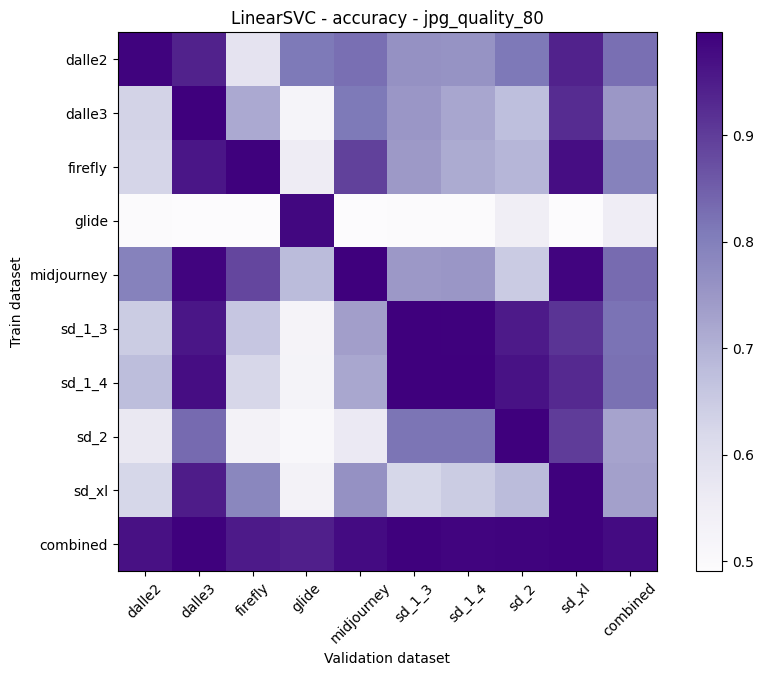

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.990625  0.940625  0.584375  0.809375    0.825000  0.762500   
dalle3         0.631250  0.996875  0.715625  0.521875    0.809375  0.750000   
firefly        0.628125  0.959375  0.993750  0.556250    0.893750  0.743750   
glide          0.493750  0.490625  0.490625  0.984375    0.490625  0.493750   
midjourney     0.793750  0.987500  0.884375  0.681250    0.996875  0.746875   
sd_1_3         0.646875  0.959375  0.659375  0.525000    0.734375  0.996875   
sd_1_4         0.678125  0.975000  0.621875  0.528125    0.718750  0.996875   
sd_2           0.568750  0.834375  0.531250  0.509375    0.565625  0.818750   
sd_xl          0.625000  0.950000  0.784375  0.531250    0.762500  0.625000   
combined       0.968750  0.993750  0.953125  0.943750    0.978125  0.993750   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.759375  0.812500  0.940625  0.825000  
dalle3         0.721875  0.675000  0.925000  0.749653  
firefly        0.712500  0.693750  0.975000  0.795139  
glide          0.493750  0.546875  0.490625  0.552778  
midjourney     0.750000  0.650000  0.987500  0.830903  
sd_1_3         0.993750  0.953125  0.912500  0.820139  
sd_1_4         0.996875  0.965625  0.928125  0.823264  
sd_2           0.818750  0.996875  0.900000  0.727083  
sd_xl          0.646875  0.681250  0.993750  0.733333  
combined       0.987500  0.990625  0.993750  0.978125

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.990625  0.940625  0.584375  0.809375    0.825000  0.762500   
dalle3         0.631250  0.996875  0.715625  0.521875    0.809375  0.750000   
firefly        0.628125  0.959375  0.993750  0.556250    0.893750  0.743750   
glide          0.493750  0.490625  0.490625  0.984375    0.490625  0.493750   
midjourney     0.793750  0.987500  0.884375  0.681250    0.996875  0.746875   
sd_1_3         0.646875  0.959375  0.659375  0.525000    0.734375  0.996875   
sd_1_4         0.678125  0.975000  0.621875  0.528125    0.718750  0.996875   
sd_2           0.568750  0.834375  0.531250  0.509375    0.565625  0.818750   
sd_xl          0.625000  0.950000  0.784375  0.531250    0.762500  0.625000   
combined       0.968750  0.993750  0.953125  0.943750    0.978125  0.993750   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.759375  0.812500  0.940625  0.825000  
dalle3         0.721875  0.675000  0.925000  0.749653  
firefly        0.712500  0.693750  0.975000  0.795139  
glide          0.493750  0.546875  0.490625  0.552778  
midjourney     0.750000  0.650000  0.987500  0.830903  
sd_1_3         0.993750  0.953125  0.912500  0.820139  
sd_1_4         0.996875  0.965625  0.928125  0.823264  
sd_2           0.818750  0.996875  0.900000  0.727083  
sd_xl          0.646875  0.681250  0.993750  0.733333  
combined       0.987500  0.990625  0.993750  0.978125









 ################ Evaluating models trained on standardAugmented and tested on jpg_quality_95. ################


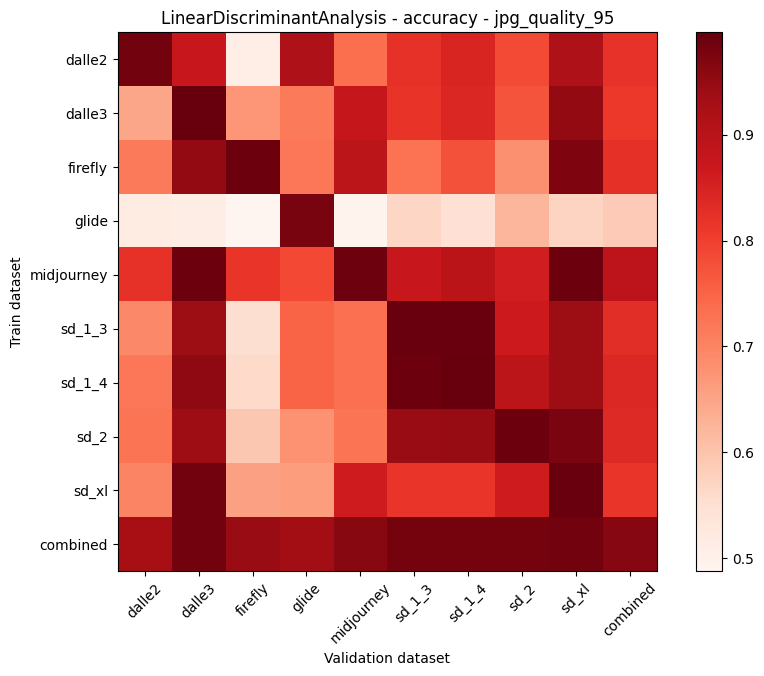

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.984375  0.875000  0.509375  0.915625    0.734375  0.821875   
dalle3         0.646875  0.996875  0.671875  0.715625    0.878125  0.818750   
firefly        0.715625  0.950000  0.990625  0.721875    0.893750  0.728125   
glide          0.515625  0.512500  0.487500  0.978125    0.493750  0.568750   
midjourney     0.821875  0.990625  0.815625  0.787500    0.987500  0.875000   
sd_1_3         0.693750  0.940625  0.553125  0.750000    0.731250  0.993750   
sd_1_4         0.721875  0.953125  0.562500  0.750000    0.731250  0.990625   
sd_2           0.725000  0.937500  0.593750  0.678125    0.725000  0.943750   
sd_xl          0.700000  0.984375  0.656250  0.662500    0.862500  0.815625   
combined       0.928125  0.984375  0.943750  0.934375    0.962500  0.981250   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.843750  0.784375  0.915625  0.820486  
dalle3         0.840625  0.771875  0.950000  0.810069  
firefly        0.775000  0.681250  0.971875  0.825347  
glide          0.546875  0.621875  0.571875  0.588542  
midjourney     0.896875  0.859375  0.990625  0.891667  
sd_1_3         0.993750  0.865625  0.940625  0.829167  
sd_1_4         0.996875  0.893750  0.940625  0.837847  
sd_2           0.946875  0.990625  0.975000  0.835069  
sd_xl          0.815625  0.862500  0.993750  0.817014  
combined       0.981250  0.981250  0.984375  0.964583

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.984375  0.875000  0.509375  0.915625    0.734375  0.821875   
dalle3         0.646875  0.996875  0.671875  0.715625    0.878125  0.818750   
firefly        0.715625  0.950000  0.990625  0.721875    0.893750  0.728125   
glide          0.515625  0.512500  0.487500  0.978125    0.493750  0.568750   
midjourney     0.821875  0.990625  0.815625  0.787500    0.987500  0.875000   
sd_1_3         0.693750  0.940625  0.553125  0.750000    0.731250  0.993750   
sd_1_4         0.721875  0.953125  0.562500  0.750000    0.731250  0.990625   
sd_2           0.725000  0.937500  0.593750  0.678125    0.725000  0.943750   
sd_xl          0.700000  0.984375  0.656250  0.662500    0.862500  0.815625   
combined       0.928125  0.984375  0.943750  0.934375    0.962500  0.981250   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.843750  0.784375  0.915625  0.820486  
dalle3         0.840625  0.771875  0.950000  0.810069  
firefly        0.775000  0.681250  0.971875  0.825347  
glide          0.546875  0.621875  0.571875  0.588542  
midjourney     0.896875  0.859375  0.990625  0.891667  
sd_1_3         0.993750  0.865625  0.940625  0.829167  
sd_1_4         0.996875  0.893750  0.940625  0.837847  
sd_2           0.946875  0.990625  0.975000  0.835069  
sd_xl          0.815625  0.862500  0.993750  0.817014  
combined       0.981250  0.981250  0.984375  0.964583

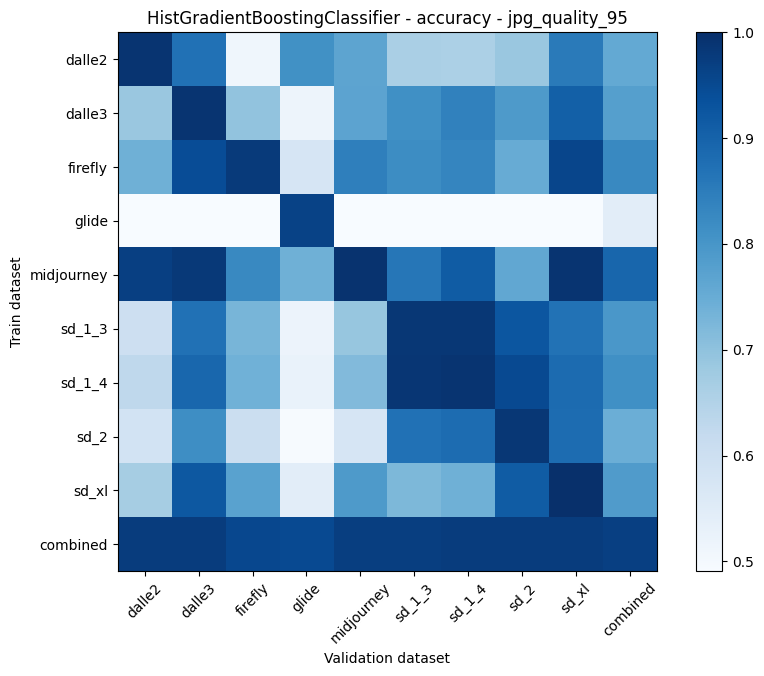

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.990625  0.871875  0.509375  0.809375    0.765625  0.662500   
dalle3         0.687500  0.990625  0.696875  0.515625    0.768750  0.812500   
firefly        0.740625  0.943750  0.978125  0.575000    0.843750  0.818750   
glide          0.490625  0.490625  0.490625  0.962500    0.490625  0.490625   
midjourney     0.968750  0.981250  0.825000  0.740625    0.993750  0.862500   
sd_1_3         0.600000  0.871875  0.728125  0.518750    0.690625  0.984375   
sd_1_4         0.628125  0.890625  0.737500  0.525000    0.715625  0.987500   
sd_2           0.584375  0.815625  0.603125  0.493750    0.575000  0.871875   
sd_xl          0.668750  0.921875  0.771875  0.543750    0.790625  0.721875   
combined       0.975000  0.975000  0.953125  0.950000    0.971875  0.971875   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.659375  0.687500  0.853125  0.756597  
dalle3         0.840625  0.790625  0.906250  0.778819  
firefly        0.831250  0.750000  0.956250  0.826389  
glide          0.490625  0.490625  0.490625  0.543056  
midjourney     0.912500  0.759375  0.990625  0.892708  
sd_1_3         0.984375  0.925000  0.868750  0.796875  
sd_1_4         0.990625  0.950000  0.884375  0.812153  
sd_2           0.881250  0.984375  0.881250  0.743403  
sd_xl          0.740625  0.912500  1.000000  0.785764  
combined       0.975000  0.975000  0.975000  0.969097

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.990625  0.871875  0.509375  0.809375    0.765625  0.662500   
dalle3         0.687500  0.990625  0.696875  0.515625    0.768750  0.812500   
firefly        0.740625  0.943750  0.978125  0.575000    0.843750  0.818750   
glide          0.490625  0.490625  0.490625  0.962500    0.490625  0.490625   
midjourney     0.968750  0.981250  0.825000  0.740625    0.993750  0.862500   
sd_1_3         0.600000  0.871875  0.728125  0.518750    0.690625  0.984375   
sd_1_4         0.628125  0.890625  0.737500  0.525000    0.715625  0.987500   
sd_2           0.584375  0.815625  0.603125  0.493750    0.575000  0.871875   
sd_xl          0.668750  0.921875  0.771875  0.543750    0.790625  0.721875   
combined       0.975000  0.975000  0.953125  0.950000    0.971875  0.971875   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.659375  0.687500  0.853125  0.756597  
dalle3         0.840625  0.790625  0.906250  0.778819  
firefly        0.831250  0.750000  0.956250  0.826389  
glide          0.490625  0.490625  0.490625  0.543056  
midjourney     0.912500  0.759375  0.990625  0.892708  
sd_1_3         0.984375  0.925000  0.868750  0.796875  
sd_1_4         0.990625  0.950000  0.884375  0.812153  
sd_2           0.881250  0.984375  0.881250  0.743403  
sd_xl          0.740625  0.912500  1.000000  0.785764  
combined       0.975000  0.975000  0.975000  0.969097

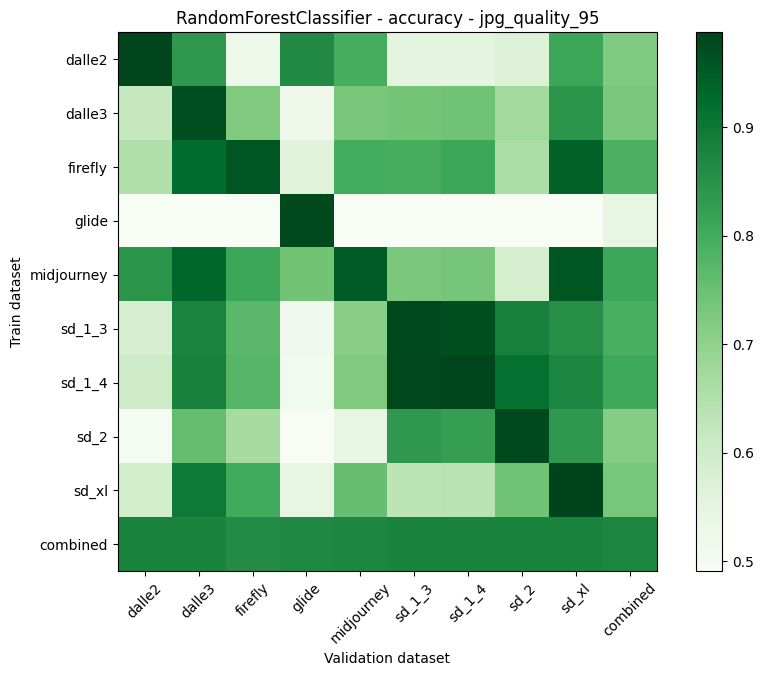

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.984375  0.837500  0.521875  0.865625    0.793750  0.553125   
dalle3         0.615625  0.971875  0.721875  0.518750    0.731250  0.737500   
firefly        0.653125  0.925000  0.959375  0.562500    0.796875  0.793750   
glide          0.490625  0.490625  0.490625  0.978125    0.490625  0.490625   
midjourney     0.843750  0.934375  0.809375  0.740625    0.950000  0.728125   
sd_1_3         0.581250  0.875000  0.768750  0.512500    0.709375  0.978125   
sd_1_4         0.603125  0.881250  0.775000  0.509375    0.721875  0.981250   
sd_2           0.500000  0.756250  0.665625  0.490625    0.546875  0.837500   
sd_xl          0.593750  0.896875  0.800000  0.546875    0.753125  0.631250   
combined       0.878125  0.878125  0.862500  0.868750    0.871875  0.878125   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.553125  0.571875  0.809375  0.721181  
dalle3         0.743750  0.675000  0.843750  0.728819  
firefly        0.809375  0.659375  0.940625  0.788889  
glide          0.490625  0.490625  0.490625  0.544792  
midjourney     0.734375  0.587500  0.959375  0.809722  
sd_1_3         0.968750  0.884375  0.856250  0.792708  
sd_1_4         0.984375  0.915625  0.871875  0.804861  
sd_2           0.825000  0.978125  0.837500  0.715278  
sd_xl          0.637500  0.743750  0.987500  0.732292  
combined       0.878125  0.878125  0.878125  0.874653

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.984375  0.837500  0.521875  0.865625    0.793750  0.553125   
dalle3         0.615625  0.971875  0.721875  0.518750    0.731250  0.737500   
firefly        0.653125  0.925000  0.959375  0.562500    0.796875  0.793750   
glide          0.490625  0.490625  0.490625  0.978125    0.490625  0.490625   
midjourney     0.843750  0.934375  0.809375  0.740625    0.950000  0.728125   
sd_1_3         0.581250  0.875000  0.768750  0.512500    0.709375  0.978125   
sd_1_4         0.603125  0.881250  0.775000  0.509375    0.721875  0.981250   
sd_2           0.500000  0.756250  0.665625  0.490625    0.546875  0.837500   
sd_xl          0.593750  0.896875  0.800000  0.546875    0.753125  0.631250   
combined       0.878125  0.878125  0.862500  0.868750    0.871875  0.878125   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.553125  0.571875  0.809375  0.721181  
dalle3         0.743750  0.675000  0.843750  0.728819  
firefly        0.809375  0.659375  0.940625  0.788889  
glide          0.490625  0.490625  0.490625  0.544792  
midjourney     0.734375  0.587500  0.959375  0.809722  
sd_1_3         0.968750  0.884375  0.856250  0.792708  
sd_1_4         0.984375  0.915625  0.871875  0.804861  
sd_2           0.825000  0.978125  0.837500  0.715278  
sd_xl          0.637500  0.743750  0.987500  0.732292  
combined       0.878125  0.878125  0.878125  0.874653

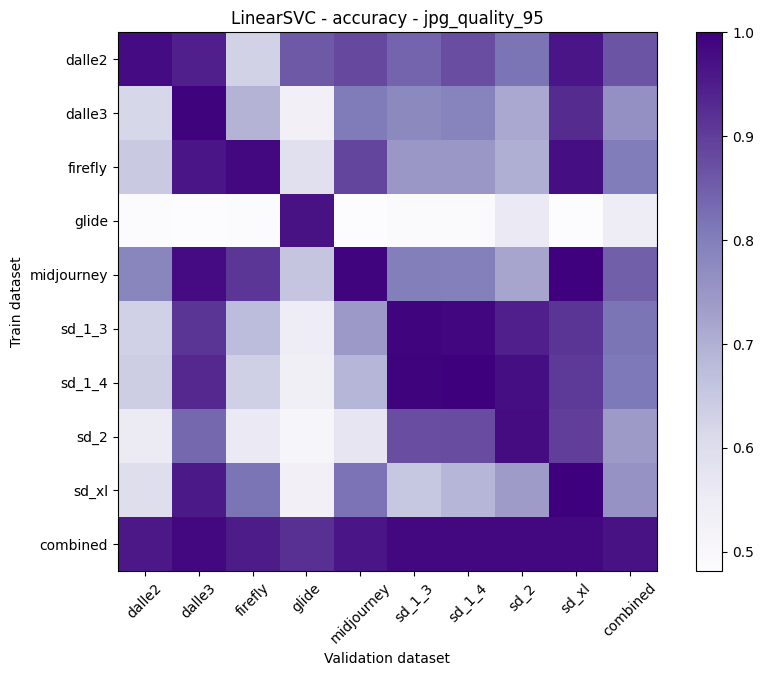

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.981250  0.946875  0.628125  0.856250    0.881250  0.840625   
dalle3         0.618750  0.993750  0.693750  0.531250    0.806250  0.778125   
firefly        0.646875  0.962500  0.984375  0.590625    0.887500  0.746875   
glide          0.484375  0.481250  0.484375  0.968750    0.481250  0.487500   
midjourney     0.784375  0.981250  0.909375  0.656250    0.990625  0.800000   
sd_1_3         0.631250  0.912500  0.675000  0.546875    0.743750  0.990625   
sd_1_4         0.637500  0.931250  0.634375  0.534375    0.687500  0.993750   
sd_2           0.553125  0.834375  0.556250  0.509375    0.571875  0.875000   
sd_xl          0.596875  0.956250  0.815625  0.531250    0.818750  0.653125   
combined       0.959375  0.984375  0.953125  0.921875    0.962500  0.984375   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.875000  0.815625  0.962500  0.865278  
dalle3         0.787500  0.712500  0.928125  0.761111  
firefly        0.746875  0.703125  0.975000  0.804861  
glide          0.490625  0.556250  0.481250  0.546181  
midjourney     0.796875  0.718750  0.996875  0.848264  
sd_1_3         0.987500  0.946875  0.912500  0.816319  
sd_1_4         1.000000  0.975000  0.903125  0.810764  
sd_2           0.878125  0.978125  0.896875  0.739236  
sd_xl          0.687500  0.737500  1.000000  0.755208  
combined       0.984375  0.984375  0.984375  0.968750

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.981250  0.946875  0.628125  0.856250    0.881250  0.840625   
dalle3         0.618750  0.993750  0.693750  0.531250    0.806250  0.778125   
firefly        0.646875  0.962500  0.984375  0.590625    0.887500  0.746875   
glide          0.484375  0.481250  0.484375  0.968750    0.481250  0.487500   
midjourney     0.784375  0.981250  0.909375  0.656250    0.990625  0.800000   
sd_1_3         0.631250  0.912500  0.675000  0.546875    0.743750  0.990625   
sd_1_4         0.637500  0.931250  0.634375  0.534375    0.687500  0.993750   
sd_2           0.553125  0.834375  0.556250  0.509375    0.571875  0.875000   
sd_xl          0.596875  0.956250  0.815625  0.531250    0.818750  0.653125   
combined       0.959375  0.984375  0.953125  0.921875    0.962500  0.984375   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.875000  0.815625  0.962500  0.865278  
dalle3         0.787500  0.712500  0.928125  0.761111  
firefly        0.746875  0.703125  0.975000  0.804861  
glide          0.490625  0.556250  0.481250  0.546181  
midjourney     0.796875  0.718750  0.996875  0.848264  
sd_1_3         0.987500  0.946875  0.912500  0.816319  
sd_1_4         1.000000  0.975000  0.903125  0.810764  
sd_2           0.878125  0.978125  0.896875  0.739236  
sd_xl          0.687500  0.737500  1.000000  0.755208  
combined       0.984375  0.984375  0.984375  0.968750









 ################ Evaluating models trained on standardAugmented and tested on standard. ################


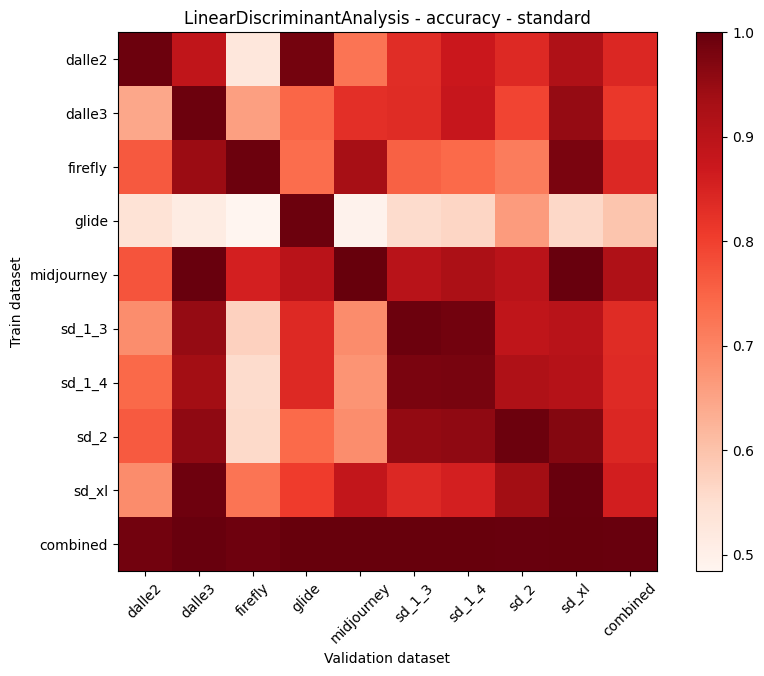

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.993750  0.887500  0.528125  0.984375    0.725000  0.831250   
dalle3         0.643750  0.993750  0.656250  0.746875    0.828125  0.834375   
firefly        0.765625  0.943750  0.993750  0.737500    0.931250  0.753125   
glide          0.540625  0.512500  0.484375  0.993750    0.493750  0.556250   
midjourney     0.771875  0.996875  0.856250  0.900000    1.000000  0.903125   
sd_1_3         0.684375  0.950000  0.575000  0.837500    0.687500  0.993750   
sd_1_4         0.743750  0.937500  0.556250  0.837500    0.675000  0.978125   
sd_2           0.762500  0.956250  0.559375  0.740625    0.684375  0.953125   
sd_xl          0.687500  0.990625  0.725000  0.806250    0.884375  0.840625   
combined       0.987500  0.996875  0.990625  1.000000    1.000000  1.000000   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.871875  0.837500  0.915625  0.841667  
dalle3         0.878125  0.793750  0.950000  0.813889  
firefly        0.740625  0.712500  0.978125  0.839583  
glide          0.565625  0.662500  0.562500  0.596875  
midjourney     0.921875  0.900000  0.996875  0.916319  
sd_1_3         0.987500  0.890625  0.903125  0.834375  
sd_1_4         0.981250  0.915625  0.906250  0.836806  
sd_2           0.956250  0.993750  0.968750  0.841667  
sd_xl          0.856250  0.937500  0.996875  0.858333  
combined       1.000000  0.996875  1.000000  0.996875

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.993750  0.887500  0.528125  0.984375    0.725000  0.831250   
dalle3         0.643750  0.993750  0.656250  0.746875    0.828125  0.834375   
firefly        0.765625  0.943750  0.993750  0.737500    0.931250  0.753125   
glide          0.540625  0.512500  0.484375  0.993750    0.493750  0.556250   
midjourney     0.771875  0.996875  0.856250  0.900000    1.000000  0.903125   
sd_1_3         0.684375  0.950000  0.575000  0.837500    0.687500  0.993750   
sd_1_4         0.743750  0.937500  0.556250  0.837500    0.675000  0.978125   
sd_2           0.762500  0.956250  0.559375  0.740625    0.684375  0.953125   
sd_xl          0.687500  0.990625  0.725000  0.806250    0.884375  0.840625   
combined       0.987500  0.996875  0.990625  1.000000    1.000000  1.000000   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.871875  0.837500  0.915625  0.841667  
dalle3         0.878125  0.793750  0.950000  0.813889  
firefly        0.740625  0.712500  0.978125  0.839583  
glide          0.565625  0.662500  0.562500  0.596875  
midjourney     0.921875  0.900000  0.996875  0.916319  
sd_1_3         0.987500  0.890625  0.903125  0.834375  
sd_1_4         0.981250  0.915625  0.906250  0.836806  
sd_2           0.956250  0.993750  0.968750  0.841667  
sd_xl          0.856250  0.937500  0.996875  0.858333  
combined       1.000000  0.996875  1.000000  0.996875

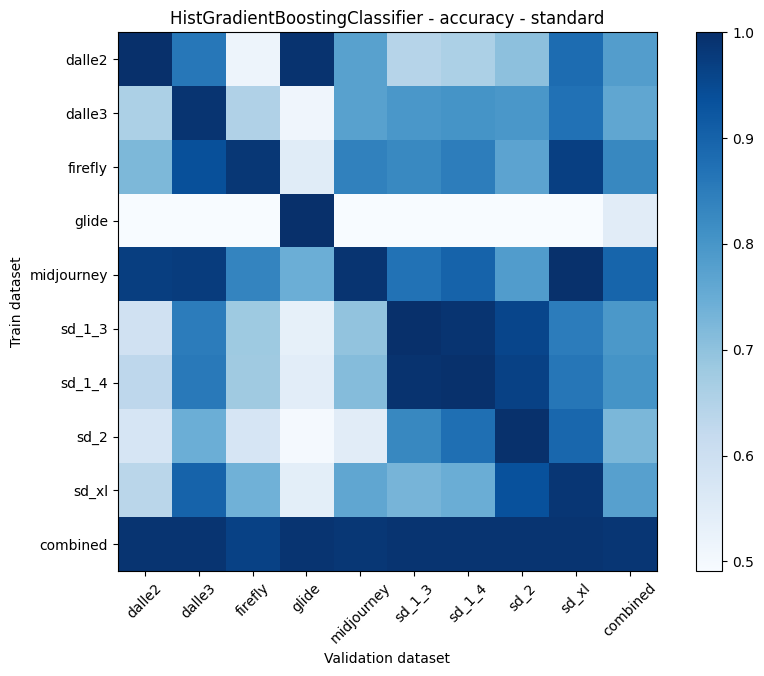

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.859375  0.515625  0.993750    0.775000  0.643750   
dalle3         0.659375  0.990625  0.653125  0.512500    0.775000  0.796875   
firefly        0.721875  0.937500  0.984375  0.550000    0.840625  0.825000   
glide          0.490625  0.490625  0.490625  1.000000    0.490625  0.490625   
midjourney     0.971875  0.975000  0.834375  0.743750    0.990625  0.868750   
sd_1_3         0.590625  0.850000  0.681250  0.534375    0.696875  1.000000   
sd_1_4         0.631250  0.856250  0.678125  0.543750    0.712500  0.993750   
sd_2           0.575000  0.743750  0.575000  0.496875    0.546875  0.828125   
sd_xl          0.637500  0.900000  0.737500  0.540625    0.762500  0.731250   
combined       0.990625  0.990625  0.965625  0.990625    0.984375  0.990625   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.659375  0.703125  0.881250  0.781250  
dalle3         0.803125  0.796875  0.871875  0.762153  
firefly        0.846875  0.768750  0.968750  0.827083  
glide          0.490625  0.490625  0.490625  0.547222  
midjourney     0.900000  0.784375  0.996875  0.896181  
sd_1_3         0.990625  0.956250  0.850000  0.794444  
sd_1_4         0.996875  0.965625  0.862500  0.804514  
sd_2           0.875000  0.996875  0.890625  0.725347  
sd_xl          0.746875  0.934375  0.987500  0.775347  
combined       0.990625  0.990625  0.990625  0.987153

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.859375  0.515625  0.993750    0.775000  0.643750   
dalle3         0.659375  0.990625  0.653125  0.512500    0.775000  0.796875   
firefly        0.721875  0.937500  0.984375  0.550000    0.840625  0.825000   
glide          0.490625  0.490625  0.490625  1.000000    0.490625  0.490625   
midjourney     0.971875  0.975000  0.834375  0.743750    0.990625  0.868750   
sd_1_3         0.590625  0.850000  0.681250  0.534375    0.696875  1.000000   
sd_1_4         0.631250  0.856250  0.678125  0.543750    0.712500  0.993750   
sd_2           0.575000  0.743750  0.575000  0.496875    0.546875  0.828125   
sd_xl          0.637500  0.900000  0.737500  0.540625    0.762500  0.731250   
combined       0.990625  0.990625  0.965625  0.990625    0.984375  0.990625   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.659375  0.703125  0.881250  0.781250  
dalle3         0.803125  0.796875  0.871875  0.762153  
firefly        0.846875  0.768750  0.968750  0.827083  
glide          0.490625  0.490625  0.490625  0.547222  
midjourney     0.900000  0.784375  0.996875  0.896181  
sd_1_3         0.990625  0.956250  0.850000  0.794444  
sd_1_4         0.996875  0.965625  0.862500  0.804514  
sd_2           0.875000  0.996875  0.890625  0.725347  
sd_xl          0.746875  0.934375  0.987500  0.775347  
combined       0.990625  0.990625  0.990625  0.987153

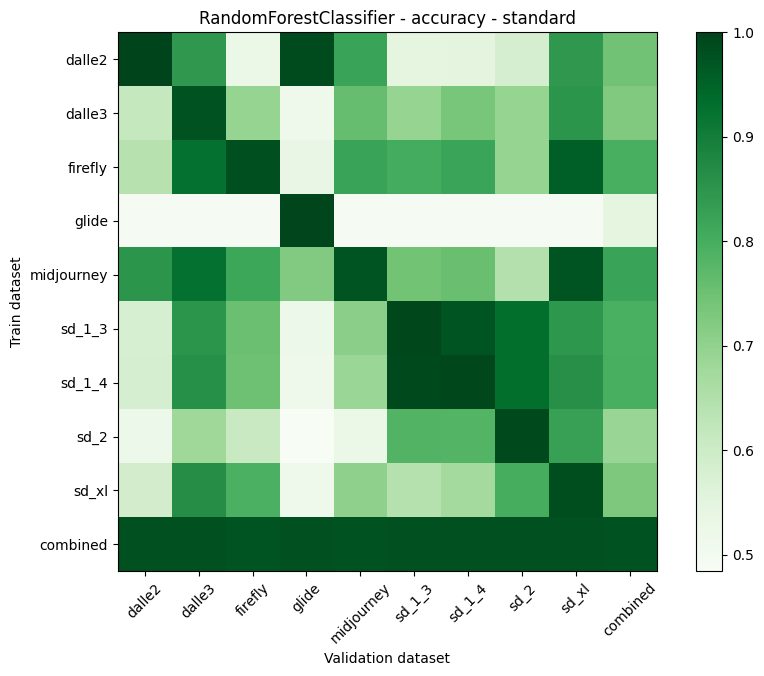

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.843750  0.525000  0.987500    0.821875  0.546875   
dalle3         0.615625  0.975000  0.693750  0.515625    0.759375  0.693750   
firefly        0.640625  0.925000  0.981250  0.534375    0.821875  0.803125   
glide          0.490625  0.490625  0.490625  0.996875    0.490625  0.490625   
midjourney     0.850000  0.925000  0.815625  0.721875    0.971875  0.743750   
sd_1_3         0.578125  0.850000  0.753125  0.521875    0.709375  0.993750   
sd_1_4         0.581250  0.859375  0.750000  0.515625    0.687500  0.990625   
sd_2           0.521875  0.678125  0.609375  0.484375    0.528125  0.784375   
sd_xl          0.587500  0.865625  0.790625  0.515625    0.703125  0.643750   
combined       0.978125  0.978125  0.971875  0.978125    0.975000  0.978125   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.550000  0.581250  0.843750  0.744444  
dalle3         0.734375  0.693750  0.850000  0.725694  
firefly        0.818750  0.693750  0.956250  0.797222  
glide          0.490625  0.490625  0.490625  0.546875  
midjourney     0.756250  0.646875  0.971875  0.822569  
sd_1_3         0.971875  0.931250  0.846875  0.795139  
sd_1_4         0.993750  0.931250  0.862500  0.796875  
sd_2           0.781250  0.990625  0.828125  0.689583  
sd_xl          0.671875  0.800000  0.984375  0.729167  
combined       0.978125  0.978125  0.978125  0.977083

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.843750  0.525000  0.987500    0.821875  0.546875   
dalle3         0.615625  0.975000  0.693750  0.515625    0.759375  0.693750   
firefly        0.640625  0.925000  0.981250  0.534375    0.821875  0.803125   
glide          0.490625  0.490625  0.490625  0.996875    0.490625  0.490625   
midjourney     0.850000  0.925000  0.815625  0.721875    0.971875  0.743750   
sd_1_3         0.578125  0.850000  0.753125  0.521875    0.709375  0.993750   
sd_1_4         0.581250  0.859375  0.750000  0.515625    0.687500  0.990625   
sd_2           0.521875  0.678125  0.609375  0.484375    0.528125  0.784375   
sd_xl          0.587500  0.865625  0.790625  0.515625    0.703125  0.643750   
combined       0.978125  0.978125  0.971875  0.978125    0.975000  0.978125   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.550000  0.581250  0.843750  0.744444  
dalle3         0.734375  0.693750  0.850000  0.725694  
firefly        0.818750  0.693750  0.956250  0.797222  
glide          0.490625  0.490625  0.490625  0.546875  
midjourney     0.756250  0.646875  0.971875  0.822569  
sd_1_3         0.971875  0.931250  0.846875  0.795139  
sd_1_4         0.993750  0.931250  0.862500  0.796875  
sd_2           0.781250  0.990625  0.828125  0.689583  
sd_xl          0.671875  0.800000  0.984375  0.729167  
combined       0.978125  0.978125  0.978125  0.977083

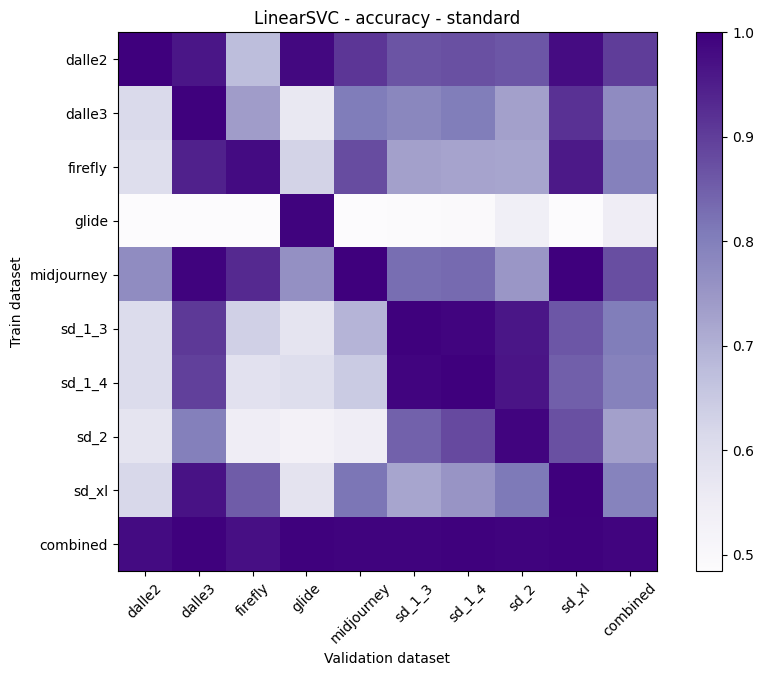

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.962500  0.675000  0.984375    0.909375  0.865625   
dalle3         0.612500  0.996875  0.737500  0.565625    0.806250  0.784375   
firefly        0.600000  0.943750  0.981250  0.628125    0.878125  0.731250   
glide          0.484375  0.484375  0.484375  0.993750    0.484375  0.487500   
midjourney     0.771875  0.993750  0.931250  0.762500    1.000000  0.828125   
sd_1_3         0.606250  0.906250  0.634375  0.578125    0.693750  0.996875   
sd_1_4         0.606250  0.896875  0.587500  0.600000    0.646875  0.990625   
sd_2           0.578125  0.796875  0.546875  0.528125    0.546875  0.846875   
sd_xl          0.615625  0.968750  0.853125  0.581250    0.815625  0.721875   
combined       0.981250  0.996875  0.971875  0.996875    0.993750  0.993750   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.871875  0.862500  0.978125  0.901042  
dalle3         0.803125  0.731250  0.918750  0.772917  
firefly        0.725000  0.721875  0.956250  0.796181  
glide          0.493750  0.540625  0.484375  0.548611  
midjourney     0.834375  0.750000  1.000000  0.874653  
sd_1_3         0.990625  0.962500  0.862500  0.803472  
sd_1_4         1.000000  0.965625  0.850000  0.793750  
sd_2           0.881250  0.990625  0.871875  0.731944  
sd_xl          0.753125  0.809375  1.000000  0.790972  
combined       0.996875  0.993750  0.996875  0.991319

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.962500  0.675000  0.984375    0.909375  0.865625   
dalle3         0.612500  0.996875  0.737500  0.565625    0.806250  0.784375   
firefly        0.600000  0.943750  0.981250  0.628125    0.878125  0.731250   
glide          0.484375  0.484375  0.484375  0.993750    0.484375  0.487500   
midjourney     0.771875  0.993750  0.931250  0.762500    1.000000  0.828125   
sd_1_3         0.606250  0.906250  0.634375  0.578125    0.693750  0.996875   
sd_1_4         0.606250  0.896875  0.587500  0.600000    0.646875  0.990625   
sd_2           0.578125  0.796875  0.546875  0.528125    0.546875  0.846875   
sd_xl          0.615625  0.968750  0.853125  0.581250    0.815625  0.721875   
combined       0.981250  0.996875  0.971875  0.996875    0.993750  0.993750   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.871875  0.862500  0.978125  0.901042  
dalle3         0.803125  0.731250  0.918750  0.772917  
firefly        0.725000  0.721875  0.956250  0.796181  
glide          0.493750  0.540625  0.484375  0.548611  
midjourney     0.834375  0.750000  1.000000  0.874653  
sd_1_3         0.990625  0.962500  0.862500  0.803472  
sd_1_4         1.000000  0.965625  0.850000  0.793750  
sd_2           0.881250  0.990625  0.871875  0.731944  
sd_xl          0.753125  0.809375  1.000000  0.790972  
combined       0.996875  0.993750  0.996875  0.991319

In [12]:
print("########################### Accuracy ###########################")
for perturbed_name, results in perturbed_results.items():
    print(f"\n\n\n\n\n\n\n\n ################ Evaluating models trained on {base_perturbed_name} and tested on {perturbed_name}. ################")
    
    # Create a heatmap of results
    df = pd.DataFrame(results).T
    df.reset_index(inplace=True)
    df.columns = ["train_dataset", "val_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

    metric = "accuracy"
    evaluation_data_name = "Validation"
    df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)

### MCC - Validation

########################### MCC ###########################








 ################ Evaluating models trained on standardAugmented and tested on jpg_quality_50. ################


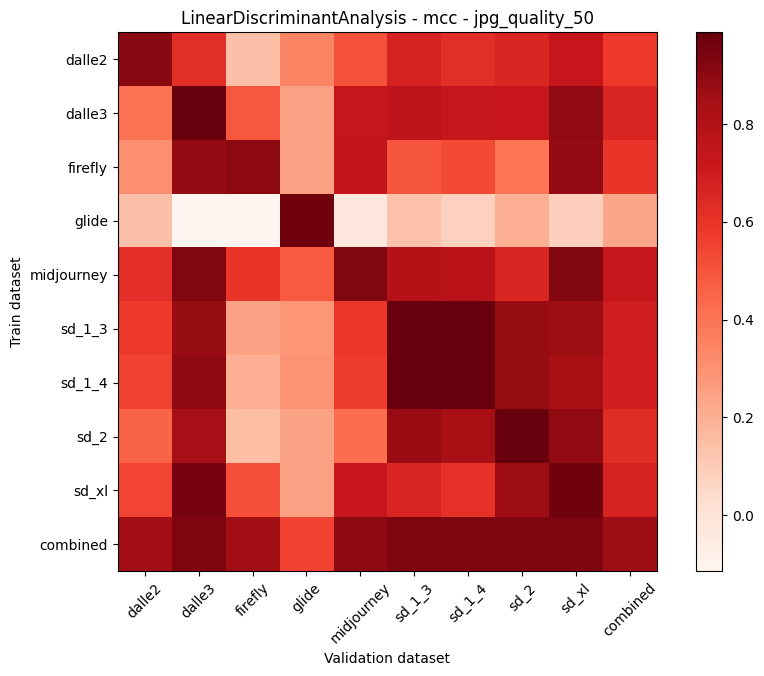

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.906246  0.623295  0.140493  0.342530    0.506442  0.669821   
dalle3         0.402655  0.981410  0.488852  0.251321    0.736937  0.763048   
firefly        0.309855  0.881239  0.900012  0.248280    0.740995  0.493957   
glide          0.140770 -0.114638 -0.114638  0.962553   -0.024172  0.131077   
midjourney     0.617816  0.925573  0.597029  0.483620    0.925573  0.786043   
sd_1_3         0.581277  0.879586  0.239117  0.285467    0.590956  0.987570   
sd_1_4         0.552268  0.896833  0.201753  0.291682    0.566771  0.987570   
sd_2           0.449475  0.845859  0.148799  0.239117    0.424219  0.873895   
sd_xl          0.545576  0.950256  0.510367  0.250975    0.719460  0.656900   
combined       0.850049  0.933353  0.856233  0.549845    0.900529  0.933353   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.623295  0.654219  0.728084  0.580799  
dalle3         0.736937  0.726610  0.890120  0.660273  
firefly        0.530011  0.399470  0.881239  0.593575  
glide          0.075301  0.200338  0.087675  0.229875  
midjourney     0.774643  0.654543  0.925573  0.736076  
sd_1_3         0.987570  0.879586  0.868234  0.692845  
sd_1_4         0.987570  0.879586  0.840331  0.683426  
sd_2           0.834828  0.981260  0.891054  0.633074  
sd_xl          0.611031  0.858412  0.963139  0.667772  
combined       0.933353  0.933353  0.933353  0.863838

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.906246  0.623295  0.140493  0.342530    0.506442  0.669821   
dalle3         0.402655  0.981410  0.488852  0.251321    0.736937  0.763048   
firefly        0.309855  0.881239  0.900012  0.248280    0.740995  0.493957   
glide          0.140770 -0.114638 -0.114638  0.962553   -0.024172  0.131077   
midjourney     0.617816  0.925573  0.597029  0.483620    0.925573  0.786043   
sd_1_3         0.581277  0.879586  0.239117  0.285467    0.590956  0.987570   
sd_1_4         0.552268  0.896833  0.201753  0.291682    0.566771  0.987570   
sd_2           0.449475  0.845859  0.148799  0.239117    0.424219  0.873895   
sd_xl          0.545576  0.950256  0.510367  0.250975    0.719460  0.656900   
combined       0.850049  0.933353  0.856233  0.549845    0.900529  0.933353   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.623295  0.654219  0.728084  0.577158  
dalle3         0.736937  0.726610  0.890120  0.664210  
firefly        0.530011  0.399470  0.881239  0.598340  
glide          0.075301  0.200338  0.087675  0.149363  
midjourney     0.774643  0.654543  0.925573  0.743379  
sd_1_3         0.987570  0.879586  0.868234  0.699929  
sd_1_4         0.987570  0.879586  0.840331  0.689374  
sd_2           0.834828  0.981260  0.891054  0.632056  
sd_xl          0.611031  0.858412  0.963139  0.674013  
combined       0.933353  0.933353  0.933353  0.869269

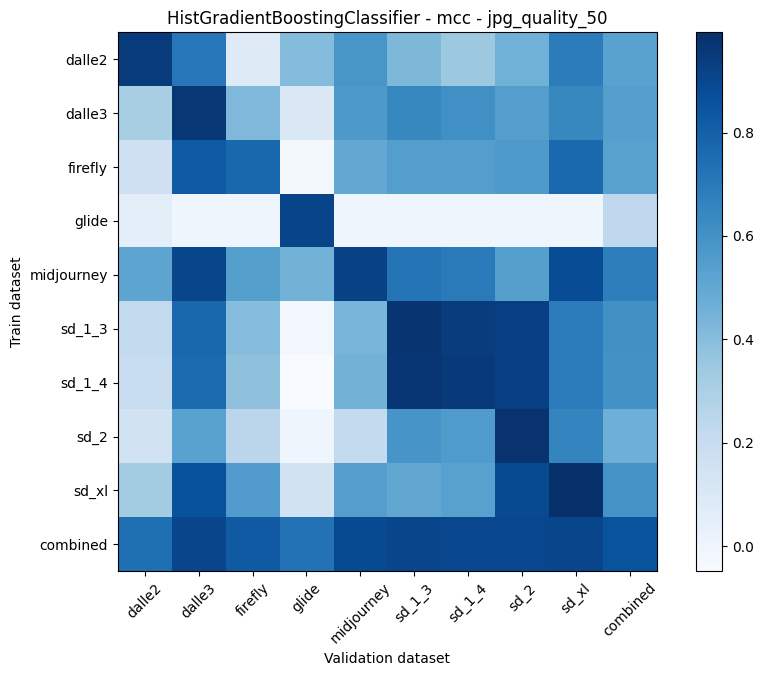

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.945284  0.705388  0.077832  0.407215    0.580792  0.427332   
dalle3         0.306304  0.962805  0.420443  0.104033    0.566530  0.643343   
firefly        0.167029  0.826135  0.773493 -0.031709    0.500894  0.542352   
glide          0.054949  0.000000  0.000000  0.910380    0.000000  0.000000   
midjourney     0.513839  0.907162  0.538569  0.448688    0.919218  0.718895   
sd_1_3         0.222719  0.771571  0.402139 -0.024172    0.438479  0.975285   
sd_1_4         0.200338  0.760892  0.380833 -0.048678    0.448688  0.968899   
sd_2           0.148799  0.528061  0.246097 -0.002110    0.217251  0.586115   
sd_xl          0.323899  0.858451  0.552188  0.150860    0.542620  0.504199   
combined       0.739158  0.904330  0.825115  0.727334    0.883961  0.904330   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.343928  0.456894  0.685854  0.526173  
dalle3         0.609611  0.542620  0.643343  0.542620  
firefly        0.542352  0.563095  0.762078  0.531991  
glide          0.000000  0.000000  0.000000  0.229239  
midjourney     0.693158  0.538569  0.877598  0.677310  
sd_1_3         0.943755  0.931414  0.688051  0.606628  
sd_1_4         0.949982  0.931414  0.688051  0.602222  
sd_2           0.561937  0.981260  0.654305  0.465526  
sd_xl          0.533042  0.886446  0.993766  0.595228  
combined       0.897495  0.897495  0.904330  0.851598

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.945284  0.705388  0.077832  0.407215    0.580792  0.427332   
dalle3         0.306304  0.962805  0.420443  0.104033    0.566530  0.643343   
firefly        0.167029  0.826135  0.773493 -0.031709    0.500894  0.542352   
glide          0.054949  0.000000  0.000000  0.910380    0.000000  0.000000   
midjourney     0.513839  0.907162  0.538569  0.448688    0.919218  0.718895   
sd_1_3         0.222719  0.771571  0.402139 -0.024172    0.438479  0.975285   
sd_1_4         0.200338  0.760892  0.380833 -0.048678    0.448688  0.968899   
sd_2           0.148799  0.528061  0.246097 -0.002110    0.217251  0.586115   
sd_xl          0.323899  0.858451  0.552188  0.150860    0.542620  0.504199   
combined       0.739158  0.904330  0.825115  0.727334    0.883961  0.904330   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.343928  0.456894  0.685854  0.514502  
dalle3         0.609611  0.542620  0.643343  0.533226  
firefly        0.542352  0.563095  0.762078  0.516191  
glide          0.000000  0.000000  0.000000  0.107259  
midjourney     0.693158  0.538569  0.877598  0.683966  
sd_1_3         0.943755  0.931414  0.688051  0.594360  
sd_1_4         0.949982  0.931414  0.688051  0.586713  
sd_2           0.561937  0.981260  0.654305  0.435746  
sd_xl          0.533042  0.886446  0.993766  0.593941  
combined       0.897495  0.897495  0.904330  0.853727

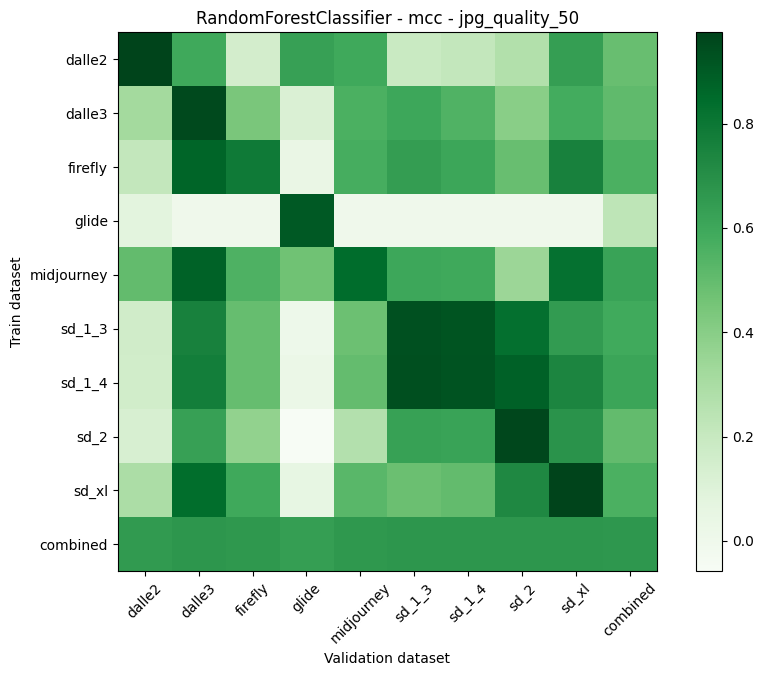

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.975073  0.595228  0.150860  0.628851    0.595228  0.188072   
dalle3         0.318101  0.956727  0.440556  0.117114    0.561750  0.600019   
firefly        0.212758  0.869205  0.787209  0.034965    0.574227  0.641239   
glide          0.077832  0.000000  0.000000  0.904673    0.000000  0.000000   
midjourney     0.502695  0.875288  0.553784  0.466693    0.845196  0.599866   
sd_1_3         0.160445  0.753617  0.492442  0.009494    0.477016  0.931641   
sd_1_4         0.157393  0.771772  0.491170  0.024380    0.496266  0.937742   
sd_2           0.128924  0.631074  0.370688 -0.058374    0.264630  0.626141   
sd_xl          0.290071  0.838831  0.591772  0.053525    0.523316  0.478932   
combined       0.654923  0.672013  0.663426  0.638162    0.663426  0.672013   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.212470  0.268977  0.638506  0.489684  
dalle3         0.547405  0.394773  0.580872  0.510627  
firefly        0.605011  0.487307  0.753617  0.562865  
glide          0.000000  0.000000  0.000000  0.229239  
midjourney     0.594728  0.343335  0.821672  0.618189  
sd_1_3         0.918855  0.827510  0.651674  0.590166  
sd_1_4         0.925028  0.881708  0.738889  0.611353  
sd_2           0.616296  0.962487  0.680850  0.500378  
sd_xl          0.498734  0.726610  0.975062  0.562984  
combined       0.672013  0.672013  0.672013  0.664375

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.975073  0.595228  0.150860  0.628851    0.595228  0.188072   
dalle3         0.318101  0.956727  0.440556  0.117114    0.561750  0.600019   
firefly        0.212758  0.869205  0.787209  0.034965    0.574227  0.641239   
glide          0.077832  0.000000  0.000000  0.904673    0.000000  0.000000   
midjourney     0.502695  0.875288  0.553784  0.466693    0.845196  0.599866   
sd_1_3         0.160445  0.753617  0.492442  0.009494    0.477016  0.931641   
sd_1_4         0.157393  0.771772  0.491170  0.024380    0.496266  0.937742   
sd_2           0.128924  0.631074  0.370688 -0.058374    0.264630  0.626141   
sd_xl          0.290071  0.838831  0.591772  0.053525    0.523316  0.478932   
combined       0.654923  0.672013  0.663426  0.638162    0.663426  0.672013   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.212470  0.268977  0.638506  0.472585  
dalle3         0.547405  0.394773  0.580872  0.501924  
firefly        0.605011  0.487307  0.753617  0.551726  
glide          0.000000  0.000000  0.000000  0.109167  
midjourney     0.594728  0.343335  0.821672  0.622584  
sd_1_3         0.918855  0.827510  0.651674  0.580299  
sd_1_4         0.925028  0.881708  0.738889  0.602705  
sd_2           0.616296  0.962487  0.680850  0.469191  
sd_xl          0.498734  0.726610  0.975062  0.552984  
combined       0.672013  0.672013  0.672013  0.664444

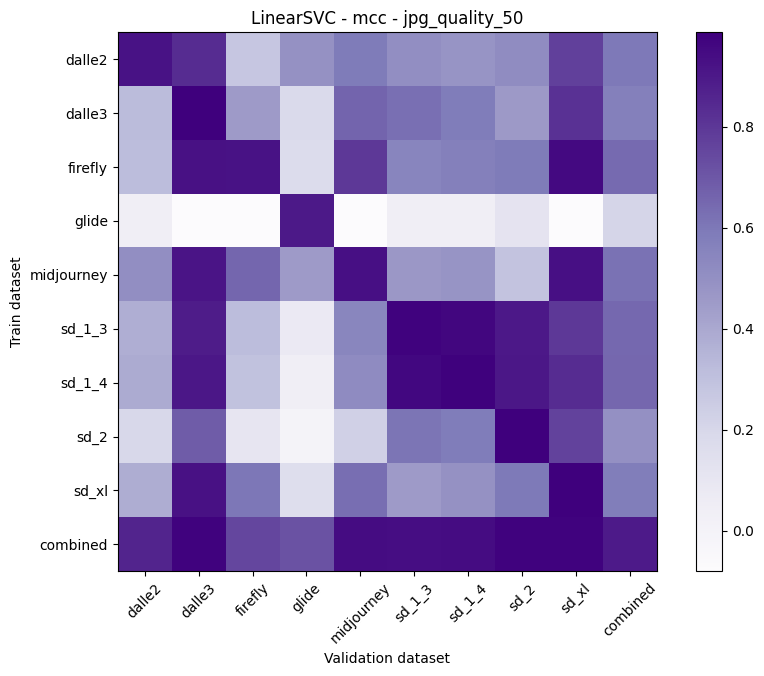

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.921001  0.836529  0.275433  0.494531    0.590440  0.504199   
dalle3         0.321431  0.987576  0.452010  0.185171    0.661675  0.628181   
firefly        0.318101  0.926871  0.921001  0.170293    0.799076  0.547405   
glide          0.043493 -0.080806 -0.080806  0.896833   -0.080806  0.043493   
midjourney     0.506442  0.912469  0.654219  0.450091    0.931366  0.465571   
sd_1_3         0.375431  0.889328  0.319249  0.075301    0.543506  0.975285   
sd_1_4         0.386812  0.907751  0.296220  0.037036    0.518411  0.962487   
sd_2           0.193673  0.683979  0.104414 -0.002110    0.231991  0.610351   
sd_xl          0.379023  0.926871  0.600019  0.160815    0.628851  0.450498   
combined       0.860230  0.975285  0.750288  0.713719    0.943755  0.937566   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.479961  0.513836  0.772954  0.596825  
dalle3         0.585517  0.456894  0.817073  0.568723  
firefly        0.566530  0.590440  0.950686  0.642268  
glide          0.043493  0.116549 -0.080806  0.207879  
midjourney     0.480955  0.289734  0.931366  0.617035  
sd_1_3         0.962553  0.901184  0.798629  0.649280  
sd_1_4         0.981410  0.907751  0.833268  0.651428  
sd_2           0.586115  0.987570  0.765346  0.496151  
sd_xl          0.494531  0.595228  0.987496  0.581403  
combined       0.943755  0.975285  0.975285  0.893266

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.921001  0.836529  0.275433  0.494531    0.590440  0.504199   
dalle3         0.321431  0.987576  0.452010  0.185171    0.661675  0.628181   
firefly        0.318101  0.926871  0.921001  0.170293    0.799076  0.547405   
glide          0.043493 -0.080806 -0.080806  0.896833   -0.080806  0.043493   
midjourney     0.506442  0.912469  0.654219  0.450091    0.931366  0.465571   
sd_1_3         0.375431  0.889328  0.319249  0.075301    0.543506  0.975285   
sd_1_4         0.386812  0.907751  0.296220  0.037036    0.518411  0.962487   
sd_2           0.193673  0.683979  0.104414 -0.002110    0.231991  0.610351   
sd_xl          0.379023  0.926871  0.600019  0.160815    0.628851  0.450498   
combined       0.860230  0.975285  0.750288  0.713719    0.943755  0.937566   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.479961  0.513836  0.772954  0.598765  
dalle3         0.585517  0.456894  0.817073  0.566170  
firefly        0.566530  0.590440  0.950686  0.643378  
glide          0.043493  0.116549 -0.080806  0.091182  
midjourney     0.480955  0.289734  0.931366  0.624690  
sd_1_3         0.962553  0.901184  0.798629  0.648941  
sd_1_4         0.981410  0.907751  0.833268  0.647905  
sd_2           0.586115  0.987570  0.765346  0.462370  
sd_xl          0.494531  0.595228  0.987496  0.580370  
combined       0.943755  0.975285  0.975285  0.897241









 ################ Evaluating models trained on standardAugmented and tested on jpg_quality_70. ################


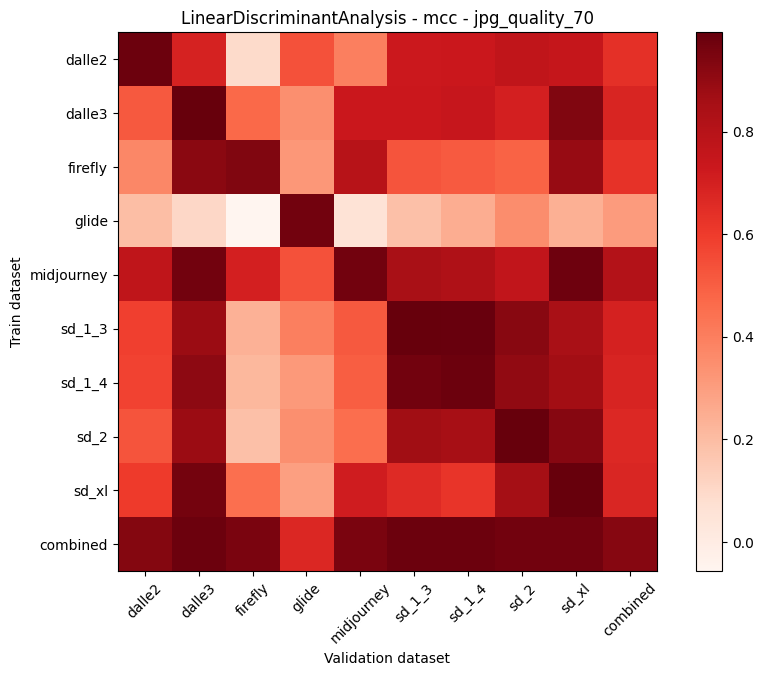

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.981260  0.693956  0.091334  0.537752    0.398415  0.729279   
dalle3         0.513836  0.993766  0.470194  0.346516    0.732097  0.732097   
firefly        0.370394  0.918730  0.937742  0.319549    0.799774  0.526741   
glide          0.196472  0.104033 -0.057049  0.968920    0.054154  0.188072   
midjourney     0.770567  0.968762  0.698962  0.537752    0.968762  0.845859   
sd_1_3         0.585655  0.880791  0.234850  0.394773    0.513836  0.993766   
sd_1_4         0.576441  0.908483  0.217251  0.315769    0.498867  0.968762   
sd_2           0.528248  0.880791  0.188072  0.346516    0.455445  0.869566   
sd_xl          0.600019  0.962805  0.450498  0.294213    0.712041  0.657903   
combined       0.931721  0.981410  0.950068  0.670817    0.950068  0.981410   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.734382  0.765346  0.749788  0.637418  
dalle3         0.747294  0.702095  0.938709  0.679619  
firefly        0.511522  0.486066  0.887791  0.631852  
glide          0.248910  0.352041  0.241956  0.306304  
midjourney     0.823896  0.760142  0.974991  0.810063  
sd_1_3         0.987496  0.921001  0.841972  0.697140  
sd_1_4         0.981260  0.902642  0.862600  0.685085  
sd_2           0.852932  0.993766  0.926871  0.666567  
sd_xl          0.624033  0.858451  0.993766  0.676894  
combined       0.981410  0.968754  0.968754  0.927688

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.981260  0.693956  0.091334  0.537752    0.398415  0.729279   
dalle3         0.513836  0.993766  0.470194  0.346516    0.732097  0.732097   
firefly        0.370394  0.918730  0.937742  0.319549    0.799774  0.526741   
glide          0.196472  0.104033 -0.057049  0.968920    0.054154  0.188072   
midjourney     0.770567  0.968762  0.698962  0.537752    0.968762  0.845859   
sd_1_3         0.585655  0.880791  0.234850  0.394773    0.513836  0.993766   
sd_1_4         0.576441  0.908483  0.217251  0.315769    0.498867  0.968762   
sd_2           0.528248  0.880791  0.188072  0.346516    0.455445  0.869566   
sd_xl          0.600019  0.962805  0.450498  0.294213    0.712041  0.657903   
combined       0.931721  0.981410  0.950068  0.670817    0.950068  0.981410   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.734382  0.765346  0.749788  0.631279  
dalle3         0.747294  0.702095  0.938709  0.686289  
firefly        0.511522  0.486066  0.887791  0.639812  
glide          0.248910  0.352041  0.241956  0.255279  
midjourney     0.823896  0.760142  0.974991  0.816633  
sd_1_3         0.987496  0.921001  0.841972  0.706016  
sd_1_4         0.981260  0.902642  0.862600  0.692453  
sd_2           0.852932  0.993766  0.926871  0.671356  
sd_xl          0.624033  0.858451  0.993766  0.683748  
combined       0.981410  0.968754  0.968754  0.931601

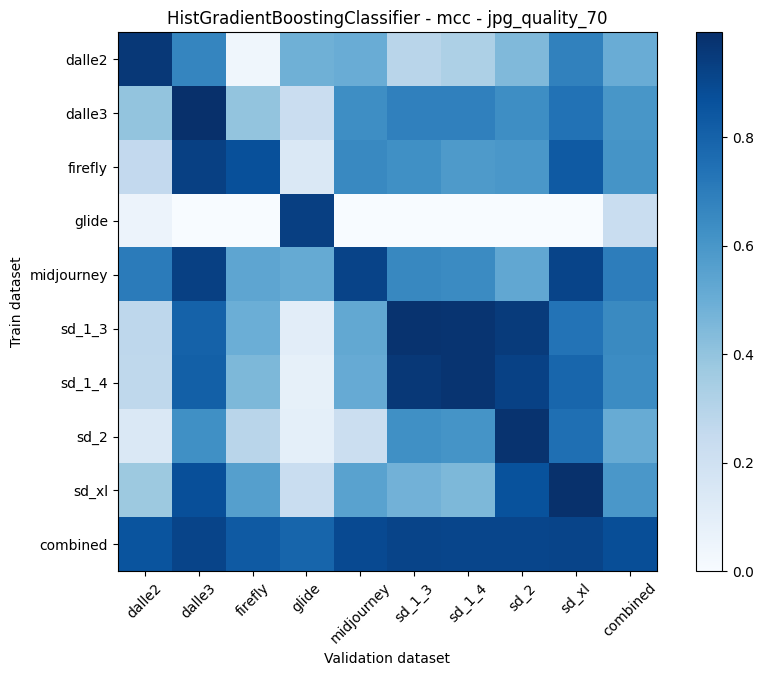

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.962487  0.665817  0.037036  0.488852    0.503663  0.290071   
dalle3         0.397005  0.993768  0.397005  0.225154    0.632945  0.685854   
firefly        0.258378  0.931366  0.869643  0.140493    0.654219  0.628426   
glide          0.054949  0.000000  0.000000  0.933519    0.000000  0.000000   
midjourney     0.706025  0.931252  0.534441  0.514481    0.918912  0.659724   
sd_1_3         0.272767  0.802309  0.493976  0.104414    0.523209  0.981260   
sd_1_4         0.271128  0.811262  0.453929  0.082239    0.508586  0.962487   
sd_2           0.140341  0.628851  0.288044  0.089579    0.220124  0.628851   
sd_xl          0.376223  0.876577  0.561903  0.232466    0.547732  0.481107   
combined       0.856534  0.915852  0.831187  0.788129    0.895702  0.915852   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.325931  0.443828  0.680850  0.503116  
dalle3         0.685854  0.632945  0.740065  0.599179  
firefly        0.582492  0.597750  0.834199  0.612489  
glide          0.000000  0.000000  0.000000  0.232466  
midjourney     0.644495  0.524468  0.912795  0.697947  
sd_1_3         0.974991  0.950303  0.734382  0.649393  
sd_1_4         0.975062  0.925677  0.784270  0.643710  
sd_2           0.609611  0.981265  0.752392  0.504735  
sd_xl          0.452010  0.865533  0.987576  0.594973  
combined       0.909091  0.909091  0.915852  0.881026

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.962487  0.665817  0.037036  0.488852    0.503663  0.290071   
dalle3         0.397005  0.993768  0.397005  0.225154    0.632945  0.685854   
firefly        0.258378  0.931366  0.869643  0.140493    0.654219  0.628426   
glide          0.054949  0.000000  0.000000  0.933519    0.000000  0.000000   
midjourney     0.706025  0.931252  0.534441  0.514481    0.918912  0.659724   
sd_1_3         0.272767  0.802309  0.493976  0.104414    0.523209  0.981260   
sd_1_4         0.271128  0.811262  0.453929  0.082239    0.508586  0.962487   
sd_2           0.140341  0.628851  0.288044  0.089579    0.220124  0.628851   
sd_xl          0.376223  0.876577  0.561903  0.232466    0.547732  0.481107   
combined       0.856534  0.915852  0.831187  0.788129    0.895702  0.915852   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.325931  0.443828  0.680850  0.488726  
dalle3         0.685854  0.632945  0.740065  0.598955  
firefly        0.582492  0.597750  0.834199  0.610774  
glide          0.000000  0.000000  0.000000  0.109830  
midjourney     0.644495  0.524468  0.912795  0.705177  
sd_1_3         0.974991  0.950303  0.734382  0.648624  
sd_1_4         0.975062  0.925677  0.784270  0.641626  
sd_2           0.609611  0.981265  0.752392  0.482118  
sd_xl          0.452010  0.865533  0.987576  0.597903  
combined       0.909091  0.909091  0.915852  0.881921

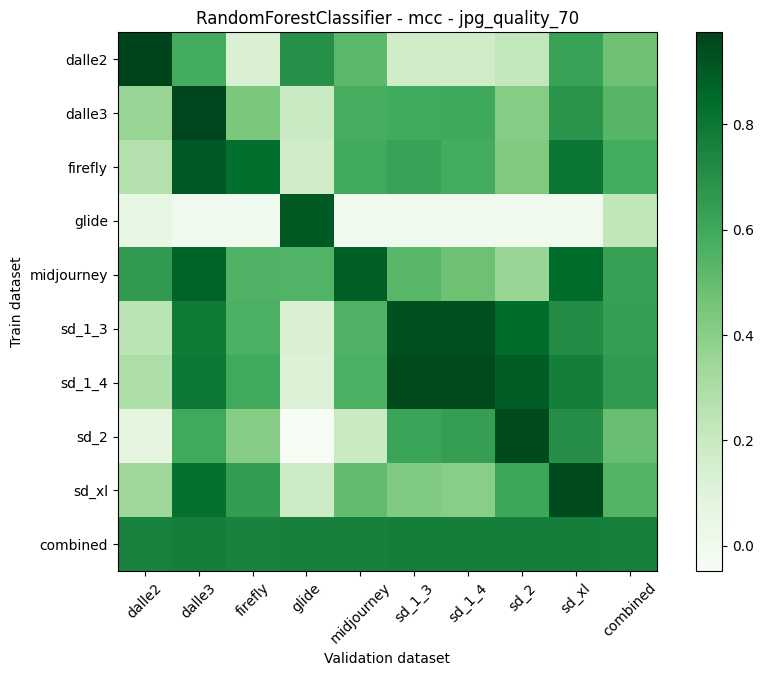

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.975073  0.585655  0.129144  0.697140    0.523449  0.170293   
dalle3         0.362956  0.968920  0.440556  0.196472    0.576090  0.590440   
firefly        0.272227  0.906224  0.833376  0.168355    0.589596  0.625661   
glide          0.054949  0.000000  0.000000  0.910380    0.000000  0.000000   
midjourney     0.657656  0.871779  0.558309  0.548441    0.889328  0.528688   
sd_1_3         0.244324  0.784383  0.560646  0.127896    0.555622  0.937537   
sd_1_4         0.288907  0.791484  0.594243  0.114319    0.559344  0.956388   
sd_2           0.075301  0.592872  0.407398 -0.048678    0.192531  0.617659   
sd_xl          0.340942  0.825715  0.643343  0.179361    0.504199  0.425503   
combined       0.752857  0.768348  0.752857  0.760571    0.760571  0.768348   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.170293  0.220124  0.624033  0.477795  
dalle3         0.595228  0.410253  0.677439  0.538365  
firefly        0.584468  0.430216  0.804324  0.580484  
glide          0.000000  0.000000  0.000000  0.229239  
midjourney     0.478971  0.359018  0.843119  0.632600  
sd_1_3         0.937537  0.846726  0.714168  0.635295  
sd_1_4         0.956388  0.894656  0.769660  0.658028  
sd_2           0.642597  0.949982  0.703411  0.493408  
sd_xl          0.399961  0.604813  0.950686  0.545279  
combined       0.768348  0.768348  0.768348  0.763156

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.975073  0.585655  0.129144  0.697140    0.523449  0.170293   
dalle3         0.362956  0.968920  0.440556  0.196472    0.576090  0.590440   
firefly        0.272227  0.906224  0.833376  0.168355    0.589596  0.625661   
glide          0.054949  0.000000  0.000000  0.910380    0.000000  0.000000   
midjourney     0.657656  0.871779  0.558309  0.548441    0.889328  0.528688   
sd_1_3         0.244324  0.784383  0.560646  0.127896    0.555622  0.937537   
sd_1_4         0.288907  0.791484  0.594243  0.114319    0.559344  0.956388   
sd_2           0.075301  0.592872  0.407398 -0.048678    0.192531  0.617659   
sd_xl          0.340942  0.825715  0.643343  0.179361    0.504199  0.425503   
combined       0.752857  0.768348  0.752857  0.760571    0.760571  0.768348   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.170293  0.220124  0.624033  0.455023  
dalle3         0.595228  0.410253  0.677439  0.535373  
firefly        0.584468  0.430216  0.804324  0.579383  
glide          0.000000  0.000000  0.000000  0.107259  
midjourney     0.478971  0.359018  0.843119  0.637257  
sd_1_3         0.937537  0.846726  0.714168  0.634315  
sd_1_4         0.956388  0.894656  0.769660  0.658376  
sd_2           0.642597  0.949982  0.703411  0.459230  
sd_xl          0.399961  0.604813  0.950686  0.541614  
combined       0.768348  0.768348  0.768348  0.763177

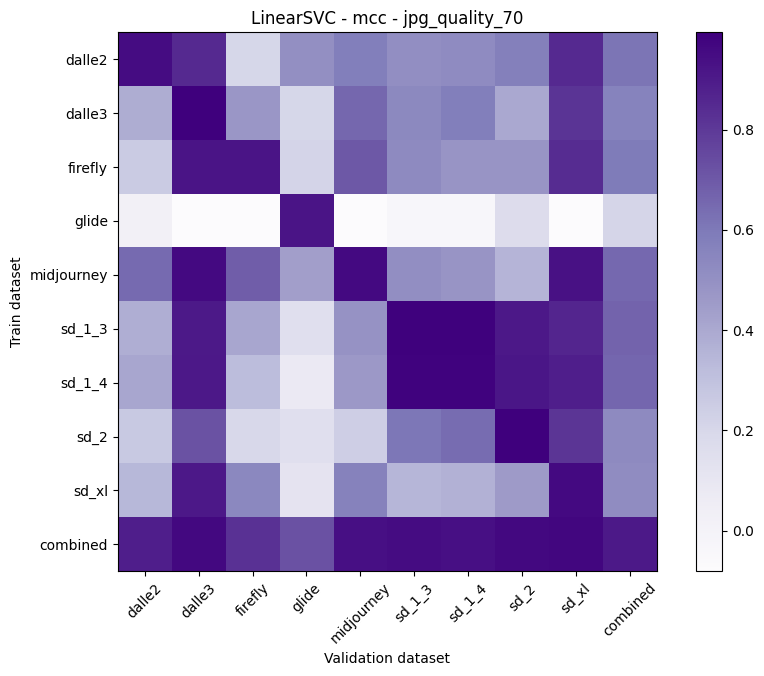

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.950068  0.850035  0.200504  0.503663    0.581988  0.508586   
dalle3         0.384306  0.993766  0.470194  0.204594    0.657903  0.533042   
firefly        0.257123  0.918912  0.918912  0.215762    0.700828  0.524468   
glide          0.022839 -0.080806 -0.080806  0.920262   -0.080806 -0.034257   
midjourney     0.645913  0.956258  0.685883  0.438753    0.956258  0.508586   
sd_1_3         0.377267  0.902642  0.408812  0.148799    0.493976  0.987570   
sd_1_4         0.408812  0.908483  0.321619  0.077075    0.464424  0.981260   
sd_2           0.266661  0.720167  0.193719  0.146769    0.239601  0.604440   
sd_xl          0.343059  0.907751  0.538005  0.118237    0.562441  0.348671   
combined       0.888676  0.962771  0.824904  0.721704    0.937478  0.950045   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.523316  0.572212  0.850035  0.614112  
dalle3         0.580872  0.399961  0.814993  0.560688  
firefly        0.479338  0.479338  0.841955  0.592023  
glide         -0.034257  0.167790 -0.080806  0.209606  
midjourney     0.478932  0.354237  0.931721  0.653084  
sd_1_3         0.987570  0.908483  0.862600  0.669647  
sd_1_4         0.981260  0.914356  0.885305  0.659774  
sd_2           0.637715  0.993768  0.811803  0.527753  
sd_xl          0.365243  0.453929  0.956258  0.516230  
combined       0.937478  0.962771  0.969195  0.903351

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.950068  0.850035  0.200504  0.503663    0.581988  0.508586   
dalle3         0.384306  0.993766  0.470194  0.204594    0.657903  0.533042   
firefly        0.257123  0.918912  0.918912  0.215762    0.700828  0.524468   
glide          0.022839 -0.080806 -0.080806  0.920262   -0.080806 -0.034257   
midjourney     0.645913  0.956258  0.685883  0.438753    0.956258  0.508586   
sd_1_3         0.377267  0.902642  0.408812  0.148799    0.493976  0.987570   
sd_1_4         0.408812  0.908483  0.321619  0.077075    0.464424  0.981260   
sd_2           0.266661  0.720167  0.193719  0.146769    0.239601  0.604440   
sd_xl          0.343059  0.907751  0.538005  0.118237    0.562441  0.348671   
combined       0.888676  0.962771  0.824904  0.721704    0.937478  0.950045   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.523316  0.572212  0.850035  0.615601  
dalle3         0.580872  0.399961  0.814993  0.559959  
firefly        0.479338  0.479338  0.841955  0.592960  
glide         -0.034257  0.167790 -0.080806  0.079906  
midjourney     0.478932  0.354237  0.931721  0.661838  
sd_1_3         0.987570  0.908483  0.862600  0.675302  
sd_1_4         0.981260  0.914356  0.885305  0.660288  
sd_2           0.637715  0.993768  0.811803  0.512738  
sd_xl          0.365243  0.453929  0.956258  0.510399  
combined       0.937478  0.962771  0.969195  0.906114









 ################ Evaluating models trained on standardAugmented and tested on jpg_quality_90. ################


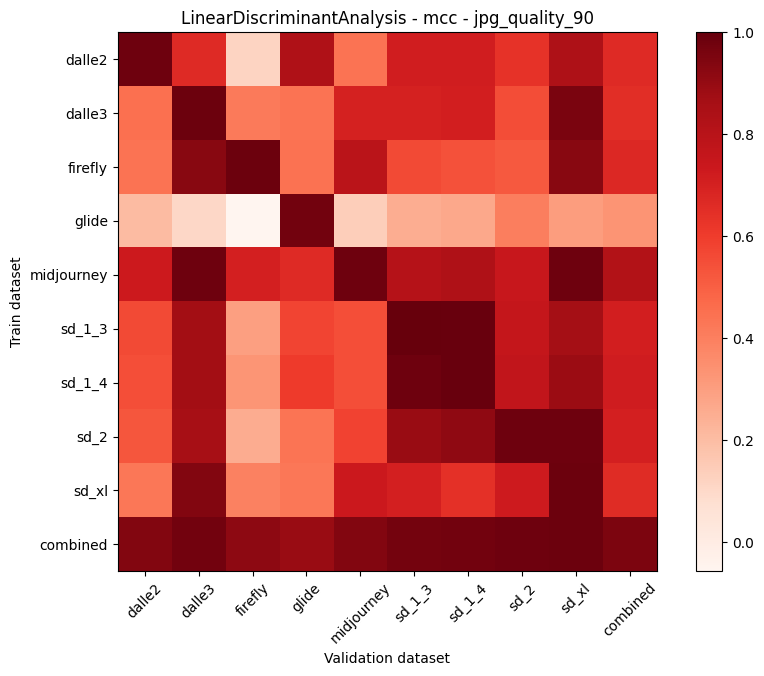

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.981260  0.664157  0.116549  0.829350    0.439429  0.714058   
dalle3         0.450498  0.987496  0.415360  0.440556    0.702095  0.702095   
firefly        0.439429  0.926201  0.987570  0.444461    0.791647  0.561937   
glide          0.204594  0.104033 -0.057049  0.975073    0.140341  0.248910   
midjourney     0.729279  0.981260  0.703981  0.664157    0.981260  0.807672   
sd_1_3         0.561903  0.871042  0.297923  0.576069    0.547732  1.000000   
sd_1_4         0.547405  0.869566  0.329637  0.604813    0.547405  0.981265   
sd_2           0.528248  0.858451  0.255724  0.435558    0.580872  0.892129   
sd_xl          0.429309  0.938181  0.393175  0.429309    0.734382  0.703981   
combined       0.938181  0.974991  0.914356  0.891054    0.938181  0.968762   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.714058  0.634702  0.834828  0.661965  
dalle3         0.707061  0.552188  0.956727  0.649805  
firefly        0.537752  0.518353  0.926201  0.671846  
glide          0.268977  0.405121  0.306304  0.331537  
midjourney     0.829350  0.744636  0.981260  0.819067  
sd_1_3         0.993768  0.760207  0.865533  0.710301  
sd_1_4         0.993766  0.767787  0.886446  0.715923  
sd_2           0.909359  0.981265  0.981265  0.704300  
sd_xl          0.644488  0.724191  0.987570  0.658132  
combined       0.974991  0.981260  0.987570  0.951659

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.981260  0.664157  0.116549  0.829350    0.439429  0.714058   
dalle3         0.450498  0.987496  0.415360  0.440556    0.702095  0.702095   
firefly        0.439429  0.926201  0.987570  0.444461    0.791647  0.561937   
glide          0.204594  0.104033 -0.057049  0.975073    0.140341  0.248910   
midjourney     0.729279  0.981260  0.703981  0.664157    0.981260  0.807672   
sd_1_3         0.561903  0.871042  0.297923  0.576069    0.547732  1.000000   
sd_1_4         0.547405  0.869566  0.329637  0.604813    0.547405  0.981265   
sd_2           0.528248  0.858451  0.255724  0.435558    0.580872  0.892129   
sd_xl          0.429309  0.938181  0.393175  0.429309    0.734382  0.703981   
combined       0.938181  0.974991  0.914356  0.891054    0.938181  0.968762   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.714058  0.634702  0.834828  0.658710  
dalle3         0.707061  0.552188  0.956727  0.657120  
firefly        0.537752  0.518353  0.926201  0.681506  
glide          0.268977  0.405121  0.306304  0.288478  
midjourney     0.829350  0.744636  0.981260  0.824762  
sd_1_3         0.993768  0.760207  0.865533  0.719353  
sd_1_4         0.993766  0.767787  0.886446  0.725344  
sd_2           0.909359  0.981265  0.981265  0.713652  
sd_xl          0.644488  0.724191  0.987570  0.664954  
combined       0.974991  0.981260  0.987570  0.952150

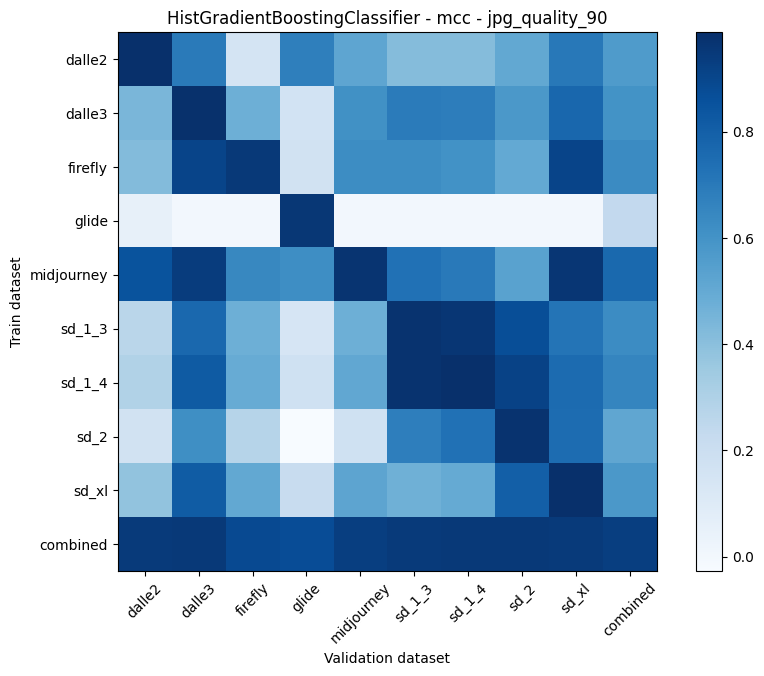

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.987496  0.697140  0.150860  0.677439    0.518646  0.415360   
dalle3         0.440556  0.981265  0.475084  0.160815    0.609611  0.692198   
firefly        0.418126  0.906409  0.950256  0.162983    0.626247  0.626247   
glide          0.054949  0.000000  0.000000  0.957186    0.000000  0.000000   
midjourney     0.850035  0.937800  0.645913  0.621216    0.968754  0.731766   
sd_1_3         0.263814  0.766222  0.473955  0.140770    0.473955  0.975285   
sd_1_4         0.291682  0.818465  0.489078  0.176723    0.508623  0.974991   
sd_2           0.167222  0.616296  0.277530 -0.027565    0.175929  0.680850   
sd_xl          0.384306  0.814993  0.504199  0.212470    0.523449  0.470194   
combined       0.944591  0.951128  0.887556  0.875288    0.931641  0.944591   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.415360  0.504199  0.702095  0.567061  
dalle3         0.682347  0.576090  0.772954  0.601616  
firefly        0.605973  0.500274  0.906409  0.630768  
glide          0.000000  0.000000  0.000000  0.235658  
midjourney     0.701054  0.533112  0.962487  0.764805  
sd_1_3         0.962553  0.871779  0.718895  0.627059  
sd_1_4         0.987570  0.914356  0.754956  0.653759  
sd_2           0.731766  0.975062  0.752551  0.513501  
sd_xl          0.499369  0.804360  0.987496  0.577153  
combined       0.951128  0.951128  0.944591  0.930927

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.987496  0.697140  0.150860  0.677439    0.518646  0.415360   
dalle3         0.440556  0.981265  0.475084  0.160815    0.609611  0.692198   
firefly        0.418126  0.906409  0.950256  0.162983    0.626247  0.626247   
glide          0.054949  0.000000  0.000000  0.957186    0.000000  0.000000   
midjourney     0.850035  0.937800  0.645913  0.621216    0.968754  0.731766   
sd_1_3         0.263814  0.766222  0.473955  0.140770    0.473955  0.975285   
sd_1_4         0.291682  0.818465  0.489078  0.176723    0.508623  0.974991   
sd_2           0.167222  0.616296  0.277530 -0.027565    0.175929  0.680850   
sd_xl          0.384306  0.814993  0.504199  0.212470    0.523449  0.470194   
combined       0.944591  0.951128  0.887556  0.875288    0.931641  0.944591   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.415360  0.504199  0.702095  0.563177  
dalle3         0.682347  0.576090  0.772954  0.598991  
firefly        0.605973  0.500274  0.906409  0.633658  
glide          0.000000  0.000000  0.000000  0.112459  
midjourney     0.701054  0.533112  0.962487  0.772460  
sd_1_3         0.962553  0.871779  0.718895  0.627470  
sd_1_4         0.987570  0.914356  0.754956  0.657383  
sd_2           0.731766  0.975062  0.752551  0.483293  
sd_xl          0.499369  0.804360  0.987496  0.577871  
combined       0.951128  0.951128  0.944591  0.931294

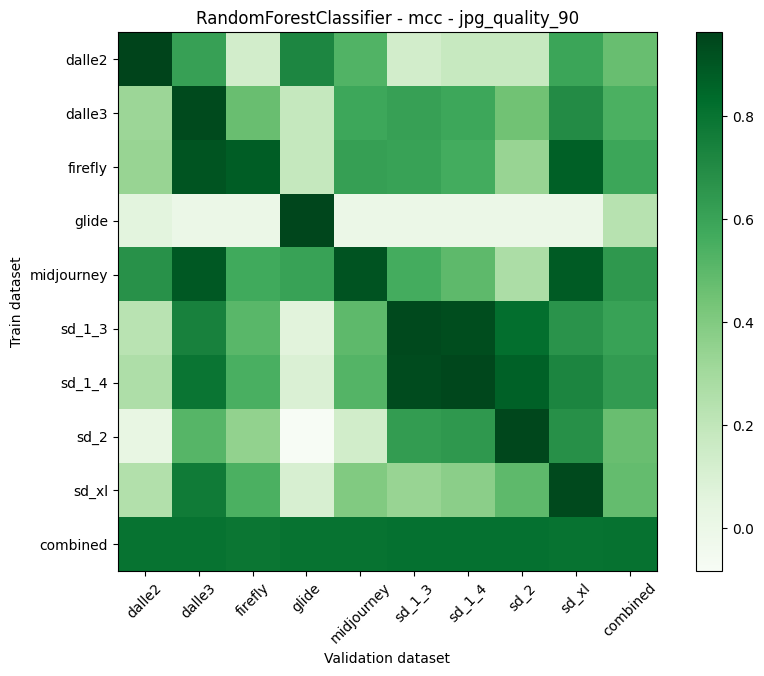

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.962553  0.612691  0.131077  0.718895    0.528688  0.131077   
dalle3         0.321619  0.938181  0.464424  0.185339    0.586115  0.615210   
firefly        0.336256  0.906715  0.876814  0.185473    0.619286  0.604244   
glide          0.054949  0.000000  0.000000  0.951218    0.000000  0.000000   
midjourney     0.675047  0.894656  0.574287  0.604244    0.912795  0.559344   
sd_1_3         0.225000  0.738889  0.506442  0.061417    0.496266  0.944159   
sd_1_4         0.263648  0.791484  0.549385  0.093108    0.519477  0.937478   
sd_2           0.026551  0.515406  0.353300 -0.083081    0.137059  0.631333   
sd_xl          0.251321  0.768324  0.542895  0.106965    0.402655  0.337401   
combined       0.802984  0.802984  0.788216  0.802984    0.802984  0.810451   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.176302  0.176302  0.592872  0.470604  
dalle3         0.586115  0.444461  0.698962  0.542055  
firefly        0.564323  0.336256  0.870930  0.589249  
glide          0.000000  0.000000  0.000000  0.234863  
midjourney     0.494443  0.270083  0.888676  0.647872  
sd_1_3         0.931366  0.816867  0.664609  0.603412  
sd_1_4         0.950045  0.865076  0.721704  0.634948  
sd_2           0.646645  0.950256  0.677543  0.467553  
sd_xl          0.370688  0.493797  0.943916  0.479484  
combined       0.810451  0.810451  0.802984  0.803811

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.962553  0.612691  0.131077  0.718895    0.528688  0.131077   
dalle3         0.321619  0.938181  0.464424  0.185339    0.586115  0.615210   
firefly        0.336256  0.906715  0.876814  0.185473    0.619286  0.604244   
glide          0.054949  0.000000  0.000000  0.951218    0.000000  0.000000   
midjourney     0.675047  0.894656  0.574287  0.604244    0.912795  0.559344   
sd_1_3         0.225000  0.738889  0.506442  0.061417    0.496266  0.944159   
sd_1_4         0.263648  0.791484  0.549385  0.093108    0.519477  0.937478   
sd_2           0.026551  0.515406  0.353300 -0.083081    0.137059  0.631333   
sd_xl          0.251321  0.768324  0.542895  0.106965    0.402655  0.337401   
combined       0.802984  0.802984  0.788216  0.802984    0.802984  0.810451   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.176302  0.176302  0.592872  0.447829  
dalle3         0.586115  0.444461  0.698962  0.537825  
firefly        0.564323  0.336256  0.870930  0.588922  
glide          0.000000  0.000000  0.000000  0.111796  
midjourney     0.494443  0.270083  0.888676  0.652620  
sd_1_3         0.931366  0.816867  0.664609  0.598335  
sd_1_4         0.950045  0.865076  0.721704  0.632378  
sd_2           0.646645  0.950256  0.677543  0.428335  
sd_xl          0.370688  0.493797  0.943916  0.468663  
combined       0.810451  0.810451  0.802984  0.803832

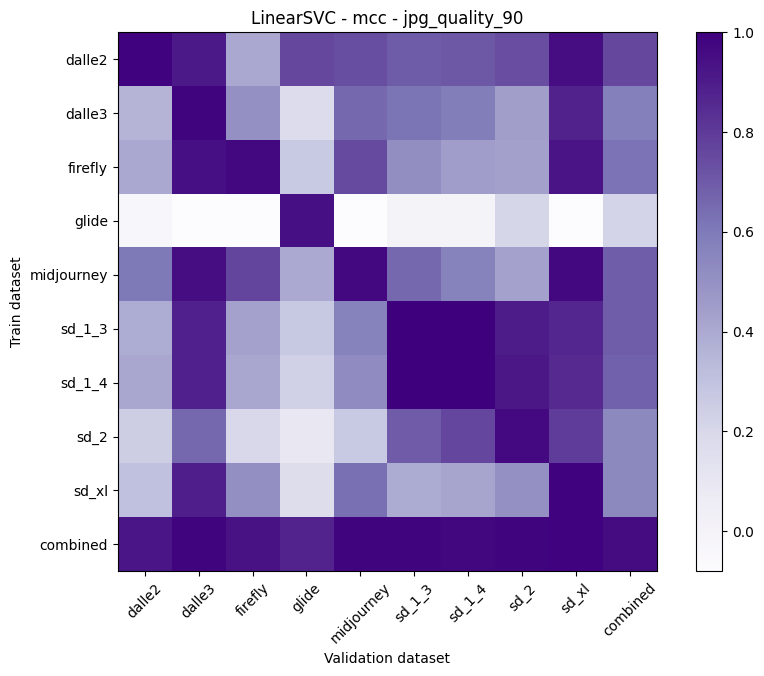

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.987576  0.910380  0.402124  0.755147    0.735069  0.695598   
dalle3         0.357520  0.981265  0.504199  0.170293    0.657903  0.619220   
firefly        0.403627  0.944224  0.968762  0.266269    0.749788  0.513491   
glide         -0.034257 -0.080806 -0.080806  0.944224   -0.080806 -0.002110   
midjourney     0.602773  0.949982  0.766222  0.396855    0.968899  0.657656   
sd_1_3         0.391857  0.882140  0.432305  0.273113    0.566625  1.000000   
sd_1_4         0.407215  0.882140  0.407215  0.232466    0.519320  1.000000   
sd_2           0.246097  0.654305  0.193673  0.091334    0.266269  0.698962   
sd_xl          0.303871  0.891054  0.508623  0.167790    0.634702  0.393175   
combined       0.920262  0.981260  0.938181  0.873895    0.981260  0.981260   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.705388  0.740065  0.951218  0.757956  
dalle3         0.590440  0.440556  0.880791  0.579809  
firefly        0.444461  0.434379  0.926201  0.621156  
glide         -0.002110  0.209606 -0.080806  0.217251  
midjourney     0.568176  0.433349  0.968899  0.691454  
sd_1_3         1.000000  0.898996  0.865533  0.690720  
sd_1_4         1.000000  0.916117  0.854594  0.681537  
sd_2           0.760142  0.962571  0.796968  0.536676  
sd_xl          0.413972  0.503749  0.987570  0.536676  
combined       0.974991  0.981260  0.987570  0.957100

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.987576  0.910380  0.402124  0.755147    0.735069  0.695598   
dalle3         0.357520  0.981265  0.504199  0.170293    0.657903  0.619220   
firefly        0.403627  0.944224  0.968762  0.266269    0.749788  0.513491   
glide         -0.034257 -0.080806 -0.080806  0.944224   -0.080806 -0.002110   
midjourney     0.602773  0.949982  0.766222  0.396855    0.968899  0.657656   
sd_1_3         0.391857  0.882140  0.432305  0.273113    0.566625  1.000000   
sd_1_4         0.407215  0.882140  0.407215  0.232466    0.519320  1.000000   
sd_2           0.246097  0.654305  0.193673  0.091334    0.266269  0.698962   
sd_xl          0.303871  0.891054  0.508623  0.167790    0.634702  0.393175   
combined       0.920262  0.981260  0.938181  0.873895    0.981260  0.981260   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.705388  0.740065  0.951218  0.764729  
dalle3         0.590440  0.440556  0.880791  0.578021  
firefly        0.444461  0.434379  0.926201  0.627911  
glide         -0.002110  0.209606 -0.080806  0.088014  
midjourney     0.568176  0.433349  0.968899  0.701423  
sd_1_3         1.000000  0.898996  0.865533  0.701174  
sd_1_4         1.000000  0.916117  0.854594  0.691007  
sd_2           0.760142  0.962571  0.796968  0.518925  
sd_xl          0.413972  0.503749  0.987570  0.533834  
combined       0.974991  0.981260  0.987570  0.957771









 ################ Evaluating models trained on standardAugmented and tested on jpg_quality_80. ################


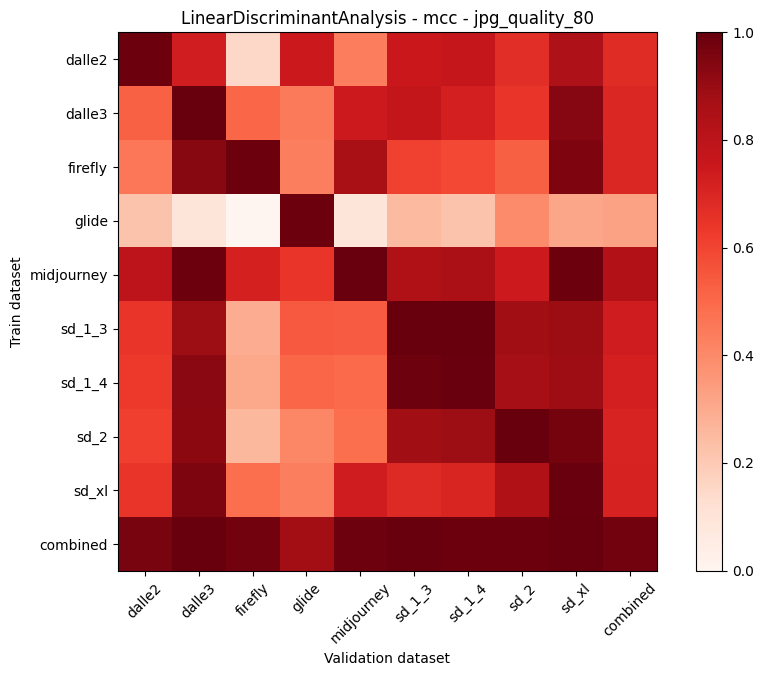

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.987496  0.727062  0.150860  0.747294    0.440556  0.752392   
dalle3         0.519320  1.000000  0.505049  0.447110    0.745077  0.775489   
firefly        0.459456  0.932174  0.987570  0.429309    0.856993  0.605496   
glide          0.220124  0.089579 -0.001487  0.987496    0.089579  0.248910   
midjourney     0.793812  0.987496  0.717034  0.643343    0.993766  0.836529   
sd_1_3         0.647276  0.887730  0.291856  0.543005    0.538275  1.000000   
sd_1_4         0.628851  0.926871  0.306304  0.504199    0.494531  0.981265   
sd_2           0.609179  0.921886  0.260094  0.407215    0.481107  0.882140   
sd_xl          0.643343  0.956727  0.479961  0.430541    0.732097  0.682347   
combined       0.963190  1.000000  0.975308  0.876577    0.981423  1.000000   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.767787  0.667652  0.841972  0.677439  
dalle3         0.720167  0.647276  0.933519  0.691803  
firefly        0.586115  0.523209  0.950303  0.692845  
glide          0.220124  0.394773  0.312237  0.326457  
midjourney     0.852932  0.742213  0.987496  0.833516  
sd_1_3         1.000000  0.882140  0.893349  0.732300  
sd_1_4         0.993766  0.869566  0.886446  0.721484  
sd_2           0.887730  1.000000  0.969230  0.703208  
sd_xl          0.702095  0.836529  0.993766  0.709826  
combined       0.987576  0.987576  1.000000  0.973954

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.987496  0.727062  0.150860  0.747294    0.440556  0.752392   
dalle3         0.519320  1.000000  0.505049  0.447110    0.745077  0.775489   
firefly        0.459456  0.932174  0.987570  0.429309    0.856993  0.605496   
glide          0.220124  0.089579 -0.001487  0.987496    0.089579  0.248910   
midjourney     0.793812  0.987496  0.717034  0.643343    0.993766  0.836529   
sd_1_3         0.647276  0.887730  0.291856  0.543005    0.538275  1.000000   
sd_1_4         0.628851  0.926871  0.306304  0.504199    0.494531  0.981265   
sd_2           0.609179  0.921886  0.260094  0.407215    0.481107  0.882140   
sd_xl          0.643343  0.956727  0.479961  0.430541    0.732097  0.682347   
combined       0.963190  1.000000  0.975308  0.876577    0.981423  1.000000   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.767787  0.667652  0.841972  0.675897  
dalle3         0.720167  0.647276  0.933519  0.699223  
firefly        0.586115  0.523209  0.950303  0.703403  
glide          0.220124  0.394773  0.312237  0.284593  
midjourney     0.852932  0.742213  0.987496  0.839402  
sd_1_3         1.000000  0.882140  0.893349  0.742626  
sd_1_4         0.993766  0.869566  0.886446  0.732422  
sd_2           0.887730  1.000000  0.969230  0.713176  
sd_xl          0.702095  0.836529  0.993766  0.717490  
combined       0.987576  0.987576  1.000000  0.974628

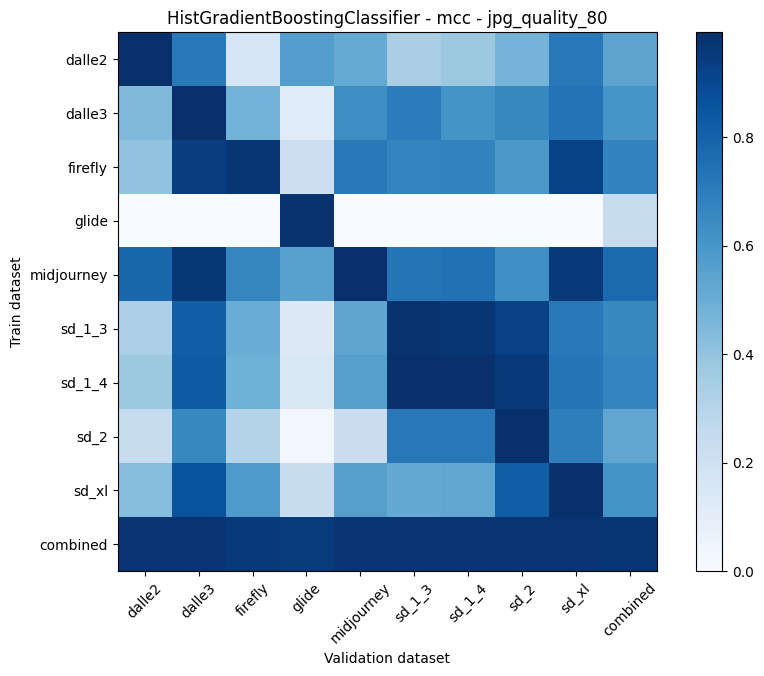

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.987496  0.712041  0.160815  0.566530    0.513836  0.335317   
dalle3         0.445536  0.993766  0.475084  0.117114    0.633675  0.702095   
firefly        0.403627  0.938181  0.968762  0.217251    0.714058  0.669097   
glide          0.000000  0.000000  0.000000  0.981423    0.000000  0.000000   
midjourney     0.783344  0.962805  0.667652  0.552188    0.993766  0.727062   
sd_1_3         0.333140  0.813057  0.498867  0.127912    0.532908  0.981260   
sd_1_4         0.373705  0.831110  0.484828  0.150860    0.561750  0.987496   
sd_2           0.234850  0.657903  0.300297  0.030609    0.227578  0.717034   
sd_xl          0.427332  0.860051  0.585517  0.239601    0.561903  0.519320   
combined       0.975285  0.975285  0.956248  0.949982    0.975285  0.975285   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.379023  0.470194  0.712041  0.542089  
dalle3         0.609611  0.657903  0.737147  0.602149  
firefly        0.674047  0.590956  0.920262  0.672946  
glide          0.000000  0.000000  0.000000  0.238030  
midjourney     0.742213  0.628851  0.956727  0.771805  
sd_1_3         0.968762  0.926201  0.714058  0.653759  
sd_1_4         0.987496  0.956727  0.727062  0.669280  
sd_2           0.717034  0.993766  0.692198  0.529847  
sd_xl          0.528806  0.817073  0.993768  0.611814  
combined       0.975285  0.975285  0.975285  0.970314

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.987496  0.712041  0.160815  0.566530    0.513836  0.335317   
dalle3         0.445536  0.993766  0.475084  0.117114    0.633675  0.702095   
firefly        0.403627  0.938181  0.968762  0.217251    0.714058  0.669097   
glide          0.000000  0.000000  0.000000  0.981423    0.000000  0.000000   
midjourney     0.783344  0.962805  0.667652  0.552188    0.993766  0.727062   
sd_1_3         0.333140  0.813057  0.498867  0.127912    0.532908  0.981260   
sd_1_4         0.373705  0.831110  0.484828  0.150860    0.561750  0.987496   
sd_2           0.234850  0.657903  0.300297  0.030609    0.227578  0.717034   
sd_xl          0.427332  0.860051  0.585517  0.239601    0.561903  0.519320   
combined       0.975285  0.975285  0.956248  0.949982    0.975285  0.975285   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.379023  0.470194  0.712041  0.537477  
dalle3         0.609611  0.657903  0.737147  0.596881  
firefly        0.674047  0.590956  0.920262  0.677360  
glide          0.000000  0.000000  0.000000  0.109047  
midjourney     0.742213  0.628851  0.956727  0.779401  
sd_1_3         0.968762  0.926201  0.714058  0.655129  
sd_1_4         0.987496  0.956727  0.727062  0.673448  
sd_2           0.717034  0.993766  0.692198  0.507919  
sd_xl          0.528806  0.817073  0.993768  0.614819  
combined       0.975285  0.975285  0.975285  0.970358

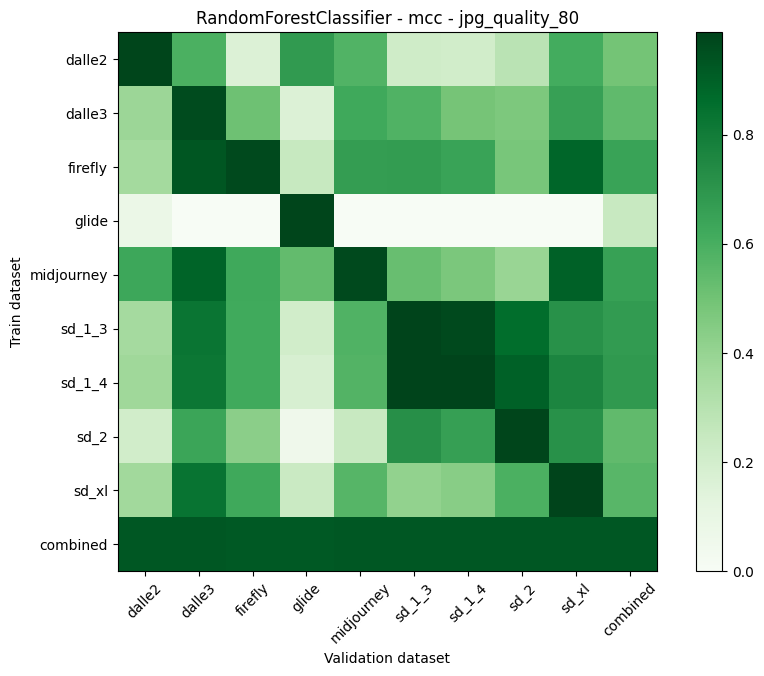

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.981265  0.590440  0.160815  0.682347    0.576090  0.212470   
dalle3         0.384306  0.962805  0.509021  0.160815    0.624033  0.580872   
firefly        0.361041  0.932174  0.968762  0.246097    0.669097  0.674047   
glide          0.077832  0.000000  0.000000  0.981423    0.000000  0.000000   
midjourney     0.629820  0.891054  0.624944  0.532908    0.968762  0.523209   
sd_1_3         0.357520  0.825715  0.619220  0.204594    0.580872  0.987496   
sd_1_4         0.373705  0.820343  0.619220  0.179361    0.571310  0.987496   
sd_2           0.204594  0.638506  0.430541  0.054154    0.241956  0.722041   
sd_xl          0.365624  0.833013  0.623423  0.232466    0.566625  0.412280   
combined       0.927489  0.927489  0.920802  0.920802    0.927489  0.927489   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.204594  0.288044  0.609611  0.493455  
dalle3         0.489684  0.470194  0.657903  0.542089  
firefly        0.644488  0.479250  0.879586  0.646122  
glide          0.000000  0.000000  0.000000  0.239601  
midjourney     0.474320  0.393175  0.896833  0.652121  
sd_1_3         0.968920  0.858451  0.717034  0.675805  
sd_1_4         0.987496  0.897842  0.762638  0.684533  
sd_2           0.662773  0.981265  0.717034  0.536236  
sd_xl          0.437259  0.590244  0.987576  0.560853  
combined       0.927489  0.927489  0.927489  0.926000

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.981265  0.590440  0.160815  0.682347    0.576090  0.212470   
dalle3         0.384306  0.962805  0.509021  0.160815    0.624033  0.580872   
firefly        0.361041  0.932174  0.968762  0.246097    0.669097  0.674047   
glide          0.077832  0.000000  0.000000  0.981423    0.000000  0.000000   
midjourney     0.629820  0.891054  0.624944  0.532908    0.968762  0.523209   
sd_1_3         0.357520  0.825715  0.619220  0.204594    0.580872  0.987496   
sd_1_4         0.373705  0.820343  0.619220  0.179361    0.571310  0.987496   
sd_2           0.204594  0.638506  0.430541  0.054154    0.241956  0.722041   
sd_xl          0.365624  0.833013  0.623423  0.232466    0.566625  0.412280   
combined       0.927489  0.927489  0.920802  0.920802    0.927489  0.927489   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.204594  0.288044  0.609611  0.478409  
dalle3         0.489684  0.470194  0.657903  0.537737  
firefly        0.644488  0.479250  0.879586  0.650505  
glide          0.000000  0.000000  0.000000  0.117695  
midjourney     0.474320  0.393175  0.896833  0.659447  
sd_1_3         0.968920  0.858451  0.717034  0.679980  
sd_1_4         0.987496  0.897842  0.762638  0.688823  
sd_2           0.662773  0.981265  0.717034  0.516985  
sd_xl          0.437259  0.590244  0.987576  0.560945  
combined       0.927489  0.927489  0.927489  0.926003

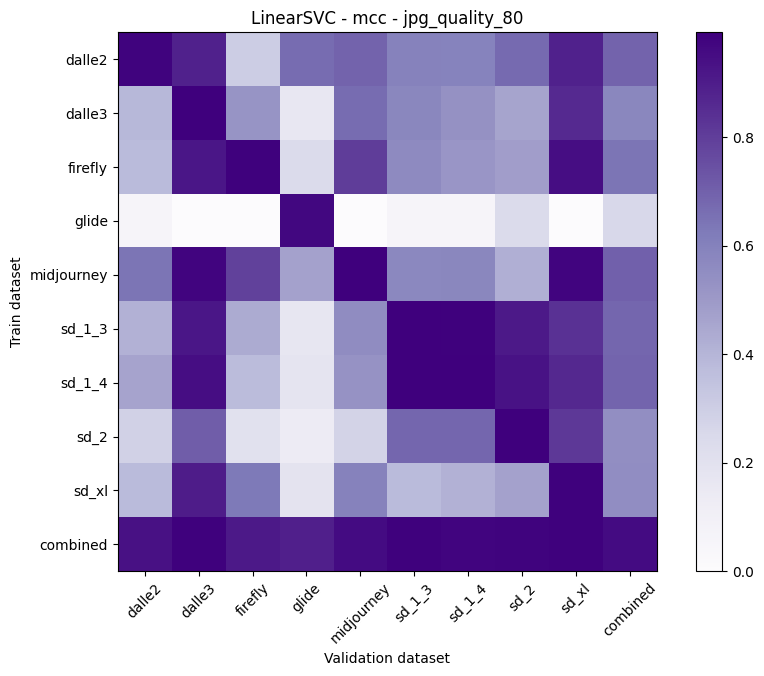

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.981265  0.886446  0.306304  0.667652    0.692198  0.595228   
dalle3         0.389555  0.993766  0.523449  0.160815    0.667652  0.576090   
firefly        0.377267  0.920262  0.987570  0.239117    0.802309  0.561937   
glide          0.054949  0.000000  0.000000  0.969230    0.000000  0.054949   
midjourney     0.643343  0.975073  0.788568  0.470194    0.993766  0.571310   
sd_1_3         0.415360  0.921001  0.435558  0.170293    0.552188  0.993766   
sd_1_4         0.465291  0.950686  0.373705  0.179361    0.528248  0.993766   
sd_2           0.285703  0.710301  0.201957  0.135665    0.279458  0.685854   
sd_xl          0.379023  0.903585  0.628851  0.188072    0.595228  0.379023   
combined       0.938181  0.987570  0.908483  0.891054    0.956418  0.987570   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.590440  0.672540  0.886446  0.692198  
dalle3         0.533042  0.460375  0.858451  0.575559  
firefly        0.513491  0.484169  0.950303  0.641767  
glide          0.054949  0.239601  0.000000  0.252651  
midjourney     0.576090  0.420443  0.975073  0.701543  
sd_1_3         0.987496  0.909359  0.836529  0.684533  
sd_1_4         0.993766  0.932773  0.863995  0.689457  
sd_2           0.685854  0.993768  0.817073  0.546156  
sd_xl          0.415360  0.470194  0.987496  0.550594  
combined       0.974991  0.981260  0.987570  0.956418

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.981265  0.886446  0.306304  0.667652    0.692198  0.595228   
dalle3         0.389555  0.993766  0.523449  0.160815    0.667652  0.576090   
firefly        0.377267  0.920262  0.987570  0.239117    0.802309  0.561937   
glide          0.054949  0.000000  0.000000  0.969230    0.000000  0.054949   
midjourney     0.643343  0.975073  0.788568  0.470194    0.993766  0.571310   
sd_1_3         0.415360  0.921001  0.435558  0.170293    0.552188  0.993766   
sd_1_4         0.465291  0.950686  0.373705  0.179361    0.528248  0.993766   
sd_2           0.285703  0.710301  0.201957  0.135665    0.279458  0.685854   
sd_xl          0.379023  0.903585  0.628851  0.188072    0.595228  0.379023   
combined       0.938181  0.987570  0.908483  0.891054    0.956418  0.987570   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.590440  0.672540  0.886446  0.697613  
dalle3         0.533042  0.460375  0.858451  0.573689  
firefly        0.513491  0.484169  0.950303  0.648492  
glide          0.054949  0.239601  0.000000  0.152631  
midjourney     0.576090  0.420443  0.975073  0.712651  
sd_1_3         0.987496  0.909359  0.836529  0.691283  
sd_1_4         0.993766  0.932773  0.863995  0.697955  
sd_2           0.685854  0.993768  0.817073  0.532848  
sd_xl          0.415360  0.470194  0.987496  0.549648  
combined       0.974991  0.981260  0.987570  0.957011









 ################ Evaluating models trained on standardAugmented and tested on jpg_quality_95. ################


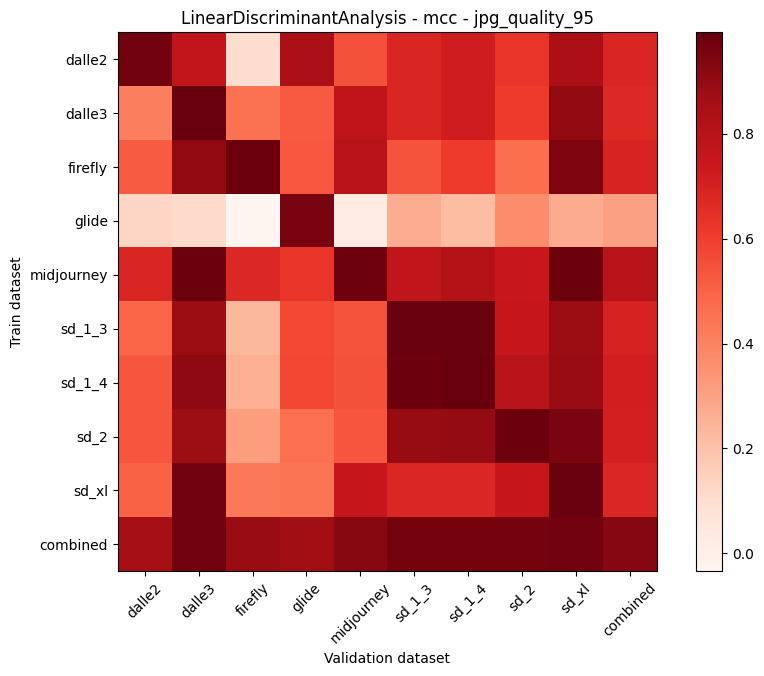

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.968762  0.770567  0.104414  0.840331    0.547431  0.683979   
dalle3         0.415360  0.993766  0.455445  0.523449    0.778140  0.682347   
firefly        0.518353  0.902642  0.981260  0.528061    0.802309  0.537752   
glide          0.127912  0.116549 -0.034257  0.956418    0.022839  0.266269   
midjourney     0.683979  0.981260  0.674047  0.629820    0.974991  0.770567   
sd_1_3         0.484169  0.885305  0.231991  0.571606    0.542593  0.987570   
sd_1_4         0.533042  0.909359  0.262410  0.576090    0.547405  0.981265   
sd_2           0.532908  0.879586  0.315769  0.459456    0.532908  0.891054   
sd_xl          0.499369  0.968920  0.430541  0.440556    0.752392  0.677439   
combined       0.859253  0.969195  0.888676  0.870930    0.925064  0.962771   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.719117  0.624944  0.840331  0.681768  
dalle3         0.717034  0.609611  0.903585  0.668737  
firefly        0.610351  0.464424  0.944224  0.689516  
glide          0.217251  0.366488  0.272767  0.305873  
midjourney     0.807672  0.744636  0.981260  0.798746  
sd_1_3         0.987570  0.754956  0.885305  0.695623  
sd_1_4         0.993766  0.804360  0.886446  0.712595  
sd_2           0.896833  0.981260  0.950303  0.705098  
sd_xl          0.677439  0.752392  0.987496  0.679619  
combined       0.962771  0.962771  0.969195  0.929185

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.968762  0.770567  0.104414  0.840331    0.547431  0.683979   
dalle3         0.415360  0.993766  0.455445  0.523449    0.778140  0.682347   
firefly        0.518353  0.902642  0.981260  0.528061    0.802309  0.537752   
glide          0.127912  0.116549 -0.034257  0.956418    0.022839  0.266269   
midjourney     0.683979  0.981260  0.674047  0.629820    0.974991  0.770567   
sd_1_3         0.484169  0.885305  0.231991  0.571606    0.542593  0.987570   
sd_1_4         0.533042  0.909359  0.262410  0.576090    0.547405  0.981265   
sd_2           0.532908  0.879586  0.315769  0.459456    0.532908  0.891054   
sd_xl          0.499369  0.968920  0.430541  0.440556    0.752392  0.677439   
combined       0.859253  0.969195  0.888676  0.870930    0.925064  0.962771   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.719117  0.624944  0.840331  0.677764  
dalle3         0.717034  0.609611  0.903585  0.675415  
firefly        0.610351  0.464424  0.944224  0.698820  
glide          0.217251  0.366488  0.272767  0.256915  
midjourney     0.807672  0.744636  0.981260  0.805359  
sd_1_3         0.987570  0.754956  0.885305  0.703452  
sd_1_4         0.993766  0.804360  0.886446  0.721572  
sd_2           0.896833  0.981260  0.950303  0.715564  
sd_xl          0.677439  0.752392  0.987496  0.687394  
combined       0.962771  0.962771  0.969195  0.930069

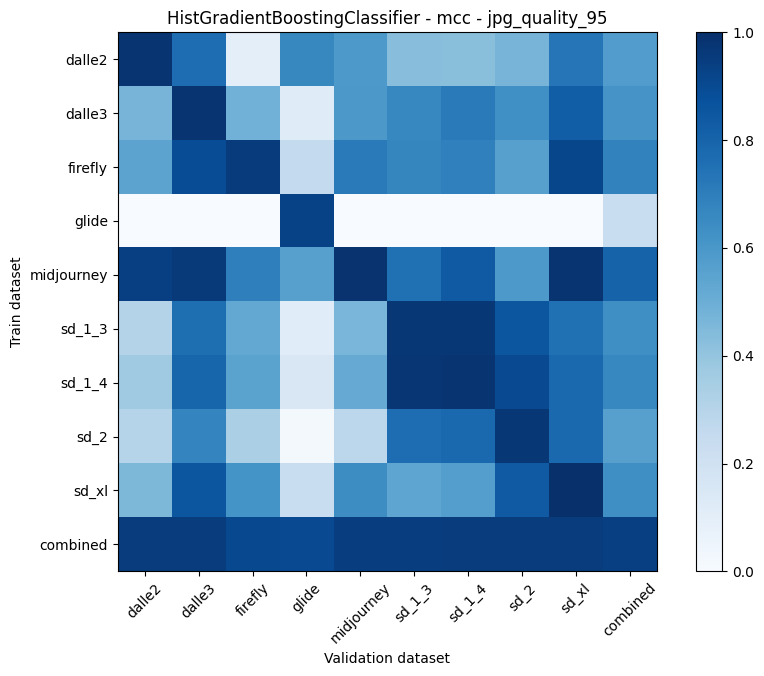

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.981410  0.763048  0.095008  0.660827    0.591772  0.428546   
dalle3         0.468969  0.981410  0.483897  0.118237    0.596669  0.665817   
firefly        0.544405  0.888676  0.956388  0.257123    0.711236  0.669928   
glide          0.000000  0.000000  0.000000  0.927686    0.000000  0.000000   
midjourney     0.938709  0.962805  0.692198  0.561750    0.987496  0.752392   
sd_1_3         0.307096  0.758873  0.524468  0.114319    0.464145  0.969195   
sd_1_4         0.370688  0.795002  0.547784  0.148851    0.513501  0.975062   
sd_2           0.297815  0.674047  0.333140  0.022839    0.279164  0.765346   
sd_xl          0.456894  0.854594  0.613922  0.232466    0.642492  0.538275   
combined       0.951128  0.951128  0.906224  0.899965    0.944591  0.944591   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.423413  0.468969  0.731766  0.577642  
dalle3         0.711234  0.631074  0.822217  0.612474  
firefly        0.690477  0.559344  0.912795  0.682462  
glide          0.000000  0.000000  0.000000  0.230857  
midjourney     0.836529  0.590440  0.981265  0.802596  
sd_1_3         0.969195  0.853458  0.753509  0.634388  
sd_1_4         0.981410  0.901842  0.784270  0.665262  
sd_2           0.781068  0.968762  0.781068  0.561400  
sd_xl          0.566625  0.838373  1.000000  0.635064  
combined       0.951128  0.951128  0.951128  0.938815

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.981410  0.763048  0.095008  0.660827    0.591772  0.428546   
dalle3         0.468969  0.981410  0.483897  0.118237    0.596669  0.665817   
firefly        0.544405  0.888676  0.956388  0.257123    0.711236  0.669928   
glide          0.000000  0.000000  0.000000  0.927686    0.000000  0.000000   
midjourney     0.938709  0.962805  0.692198  0.561750    0.987496  0.752392   
sd_1_3         0.307096  0.758873  0.524468  0.114319    0.464145  0.969195   
sd_1_4         0.370688  0.795002  0.547784  0.148851    0.513501  0.975062   
sd_2           0.297815  0.674047  0.333140  0.022839    0.279164  0.765346   
sd_xl          0.456894  0.854594  0.613922  0.232466    0.642492  0.538275   
combined       0.951128  0.951128  0.906224  0.899965    0.944591  0.944591   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.423413  0.468969  0.731766  0.571640  
dalle3         0.711234  0.631074  0.822217  0.608836  
firefly        0.690477  0.559344  0.912795  0.687819  
glide          0.000000  0.000000  0.000000  0.103076  
midjourney     0.836529  0.590440  0.981265  0.811509  
sd_1_3         0.969195  0.853458  0.753509  0.634918  
sd_1_4         0.981410  0.901842  0.784270  0.668712  
sd_2           0.781068  0.968762  0.781068  0.544805  
sd_xl          0.566625  0.838373  1.000000  0.638182  
combined       0.951128  0.951128  0.951128  0.939001

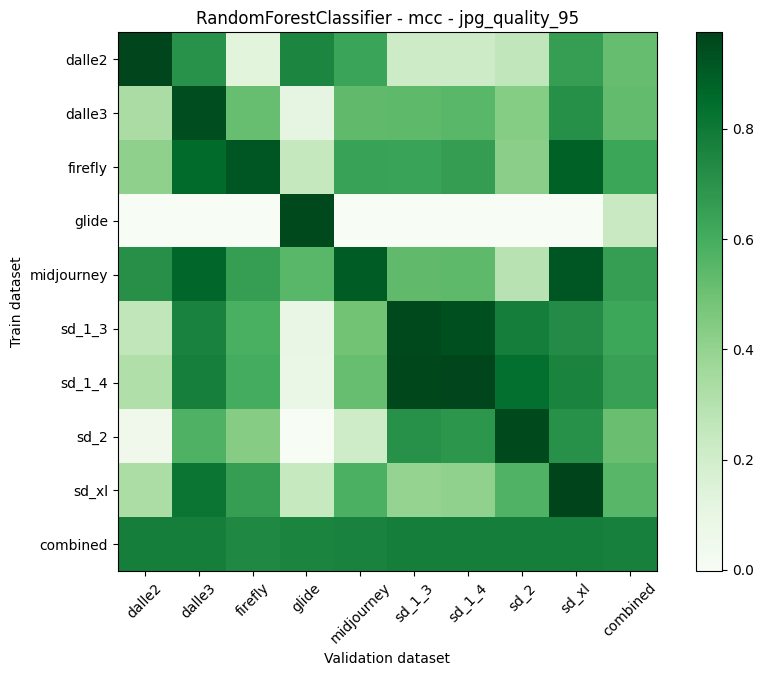

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.968899  0.703411  0.131077  0.750288    0.632600  0.215419   
dalle3         0.336256  0.943742  0.514481  0.114319    0.529456  0.539424   
firefly        0.413082  0.855676  0.919668  0.244494    0.640959  0.636013   
glide          0.000000  0.000000  0.000000  0.957186    0.000000  0.000000   
midjourney     0.713719  0.871779  0.657656  0.548441    0.901184  0.528688   
sd_1_3         0.264005  0.762427  0.585791  0.087868    0.490155  0.956677   
sd_1_4         0.313035  0.775084  0.599241  0.081744    0.514481  0.962771   
sd_2           0.053525  0.577099  0.433659 -0.002592    0.208258  0.706137   
sd_xl          0.332791  0.811803  0.656867  0.239601    0.585517  0.397005   
combined       0.778770  0.778770  0.740873  0.755857    0.763435  0.778770   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.215419  0.257244  0.657656  0.517693  
dalle3         0.549385  0.438569  0.711236  0.525577  
firefly        0.660827  0.423413  0.884306  0.628333  
glide          0.000000  0.000000  0.000000  0.234863  
midjourney     0.538569  0.289191  0.919218  0.658215  
sd_1_3         0.937537  0.778862  0.730093  0.624553  
sd_1_4         0.969195  0.836244  0.758873  0.647309  
sd_2           0.685883  0.956258  0.706137  0.512955  
sd_xl          0.407215  0.571347  0.975308  0.554031  
combined       0.778770  0.778770  0.778770  0.770220

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.968899  0.703411  0.131077  0.750288    0.632600  0.215419   
dalle3         0.336256  0.943742  0.514481  0.114319    0.529456  0.539424   
firefly        0.413082  0.855676  0.919668  0.244494    0.640959  0.636013   
glide          0.000000  0.000000  0.000000  0.957186    0.000000  0.000000   
midjourney     0.713719  0.871779  0.657656  0.548441    0.901184  0.528688   
sd_1_3         0.264005  0.762427  0.585791  0.087868    0.490155  0.956677   
sd_1_4         0.313035  0.775084  0.599241  0.081744    0.514481  0.962771   
sd_2           0.053525  0.577099  0.433659 -0.002592    0.208258  0.706137   
sd_xl          0.332791  0.811803  0.656867  0.239601    0.585517  0.397005   
combined       0.778770  0.778770  0.740873  0.755857    0.763435  0.778770   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.215419  0.257244  0.657656  0.503557  
dalle3         0.549385  0.438569  0.711236  0.519652  
firefly        0.660827  0.423413  0.884306  0.630938  
glide          0.000000  0.000000  0.000000  0.106354  
midjourney     0.538569  0.289191  0.919218  0.663161  
sd_1_3         0.937537  0.778862  0.730093  0.621491  
sd_1_4         0.969195  0.836244  0.758873  0.645630  
sd_2           0.685883  0.956258  0.706137  0.480485  
sd_xl          0.407215  0.571347  0.975308  0.553050  
combined       0.778770  0.778770  0.778770  0.770309

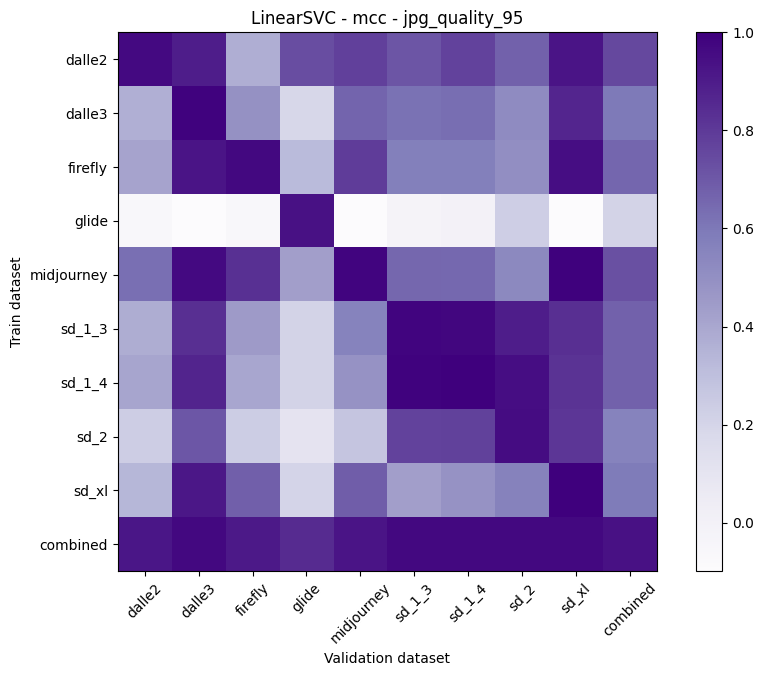

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.962487  0.895965  0.370688  0.736937    0.778935  0.711234   
dalle3         0.368350  0.987496  0.489684  0.188072    0.662773  0.619220   
firefly        0.415360  0.926871  0.968920  0.318101    0.793812  0.571310   
glide         -0.058374 -0.099123 -0.058374  0.937800   -0.099123 -0.027565   
midjourney     0.628851  0.962805  0.831110  0.430541    0.981265  0.653042   
sd_1_3         0.376097  0.833268  0.448886  0.208258    0.557556  0.981410   
sd_1_4         0.407215  0.871042  0.402124  0.209923    0.485914  0.987576   
sd_2           0.231991  0.703981  0.239117  0.104414    0.272767  0.770567   
sd_xl          0.338386  0.916117  0.680998  0.201957    0.685854  0.432305   
combined       0.918912  0.969195  0.906715  0.847692    0.925064  0.969195   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.768324  0.670817  0.925677  0.751970  
dalle3         0.633675  0.518646  0.863995  0.593100  
firefly        0.571310  0.504199  0.950686  0.660607  
glide         -0.002592  0.230453 -0.099123  0.206552  
midjourney     0.648189  0.528248  0.993766  0.729298  
sd_1_3         0.975062  0.895965  0.833268  0.671930  
sd_1_4         1.000000  0.951218  0.822364  0.673465  
sd_2           0.775808  0.956418  0.807672  0.554954  
sd_xl          0.485914  0.561903  1.000000  0.588668  
combined       0.969195  0.969195  0.969195  0.937478

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.962487  0.895965  0.370688  0.736937    0.778935  0.711234   
dalle3         0.368350  0.987496  0.489684  0.188072    0.662773  0.619220   
firefly        0.415360  0.926871  0.968920  0.318101    0.793812  0.571310   
glide         -0.058374 -0.099123 -0.058374  0.937800   -0.099123 -0.027565   
midjourney     0.628851  0.962805  0.831110  0.430541    0.981265  0.653042   
sd_1_3         0.376097  0.833268  0.448886  0.208258    0.557556  0.981410   
sd_1_4         0.407215  0.871042  0.402124  0.209923    0.485914  0.987576   
sd_2           0.231991  0.703981  0.239117  0.104414    0.272767  0.770567   
sd_xl          0.338386  0.916117  0.680998  0.201957    0.685854  0.432305   
combined       0.918912  0.969195  0.906715  0.847692    0.925064  0.969195   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.768324  0.670817  0.925677  0.757896  
dalle3         0.633675  0.518646  0.863995  0.592435  
firefly        0.571310  0.504199  0.950686  0.668952  
glide         -0.002592  0.230453 -0.099123  0.080442  
midjourney     0.648189  0.528248  0.993766  0.739757  
sd_1_3         0.975062  0.895965  0.833268  0.678863  
sd_1_4         1.000000  0.951218  0.822364  0.681931  
sd_2           0.775808  0.956418  0.807672  0.540304  
sd_xl          0.485914  0.561903  1.000000  0.589270  
combined       0.969195  0.969195  0.969195  0.938262









 ################ Evaluating models trained on standardAugmented and tested on standard. ################


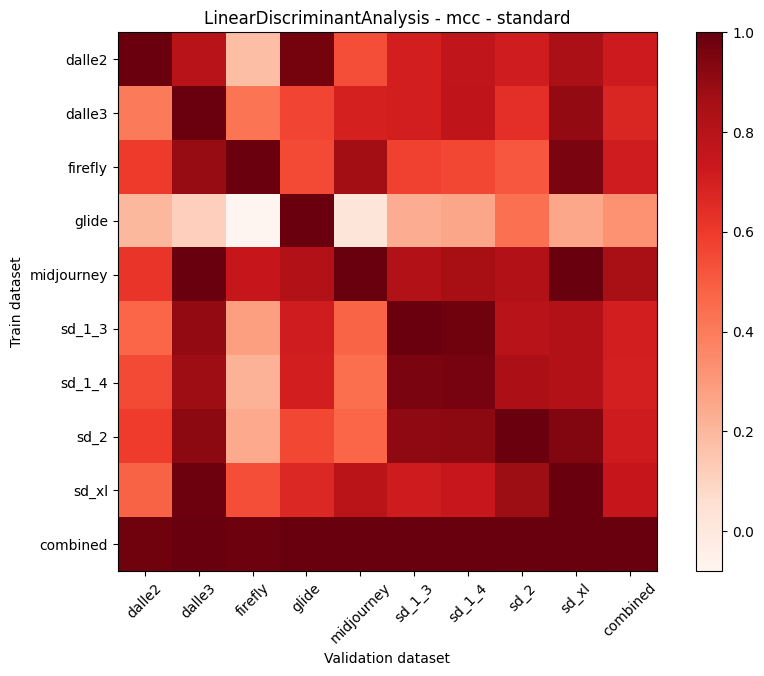

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.987496  0.793812  0.179361  0.968920    0.537833  0.702095   
dalle3         0.403627  0.987570  0.424219  0.566771    0.693956  0.703981   
firefly        0.595799  0.891054  0.987570  0.552268    0.868234  0.576441   
glide          0.201753  0.116549 -0.080806  0.987570    0.022839  0.239117   
midjourney     0.613922  0.993768  0.745077  0.817073    1.000000  0.822364   
sd_1_3         0.469378  0.902642  0.279164  0.709013    0.474320  0.987570   
sd_1_4         0.549385  0.876814  0.215762  0.700828    0.438569  0.956388   
sd_2           0.590956  0.914356  0.246097  0.557103    0.469378  0.908483   
sd_xl          0.479961  0.981265  0.537833  0.662773    0.788568  0.717034   
combined       0.975308  0.993768  0.981423  1.000000    1.000000  1.000000   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.767787  0.712041  0.841972  0.718701  
dalle3         0.775808  0.639591  0.902642  0.671296  
firefly        0.557103  0.513491  0.956418  0.712375  
glide          0.259664  0.434379  0.252943  0.321619  
midjourney     0.854594  0.817073  0.993768  0.844955  
sd_1_3         0.974991  0.796968  0.818465  0.703981  
sd_1_4         0.962771  0.836244  0.819273  0.699675  
sd_2           0.914356  0.987570  0.938181  0.715743  
sd_xl          0.742213  0.880791  0.993766  0.745599  
combined       1.000000  0.993768  1.000000  0.993768

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.987496  0.793812  0.179361  0.968920    0.537833  0.702095   
dalle3         0.403627  0.987570  0.424219  0.566771    0.693956  0.703981   
firefly        0.595799  0.891054  0.987570  0.552268    0.868234  0.576441   
glide          0.201753  0.116549 -0.080806  0.987570    0.022839  0.239117   
midjourney     0.613922  0.993768  0.745077  0.817073    1.000000  0.822364   
sd_1_3         0.469378  0.902642  0.279164  0.709013    0.474320  0.987570   
sd_1_4         0.549385  0.876814  0.215762  0.700828    0.438569  0.956388   
sd_2           0.590956  0.914356  0.246097  0.557103    0.469378  0.908483   
sd_xl          0.479961  0.981265  0.537833  0.662773    0.788568  0.717034   
combined       0.975308  0.993768  0.981423  1.000000    1.000000  1.000000   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.767787  0.712041  0.841972  0.721257  
dalle3         0.775808  0.639591  0.902642  0.677574  
firefly        0.557103  0.513491  0.956418  0.722042  
glide          0.259664  0.434379  0.252943  0.270445  
midjourney     0.854594  0.817073  0.993768  0.850849  
sd_1_3         0.974991  0.796968  0.818465  0.712501  
sd_1_4         0.962771  0.836244  0.819273  0.706226  
sd_2           0.914356  0.987570  0.938181  0.725165  
sd_xl          0.742213  0.880791  0.993766  0.753801  
combined       1.000000  0.993768  1.000000  0.993807

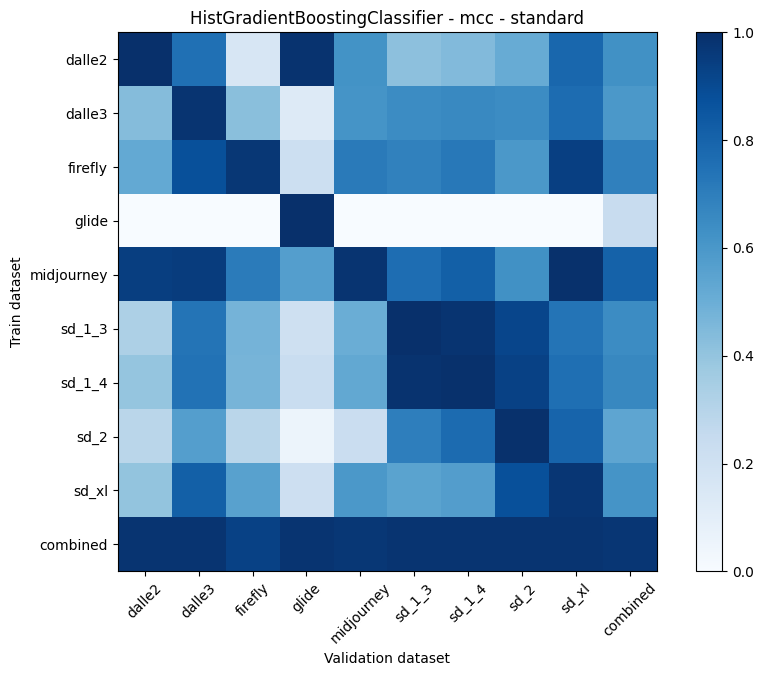

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.750104  0.157153  0.987576    0.618670  0.417320   
dalle3         0.435558  0.981265  0.425503  0.129144    0.614413  0.648189   
firefly        0.523316  0.878522  0.968754  0.215824    0.711234  0.685883   
glide          0.000000  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.944680  0.950686  0.707061  0.566530    0.981265  0.762638   
sd_1_3         0.327141  0.735069  0.476290  0.209923    0.500278  1.000000   
sd_1_4         0.397005  0.745077  0.471460  0.232466    0.524065  0.987576   
sd_2           0.288044  0.566530  0.288044  0.054154    0.227578  0.697140   
sd_xl          0.399961  0.814993  0.556970  0.212470    0.595228  0.547405   
combined       0.981410  0.981410  0.931721  0.981410    0.968754  0.981410   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.442193  0.509812  0.785767  0.628181  
dalle3         0.657903  0.648189  0.767787  0.594696  
firefly        0.721470  0.596669  0.937800  0.689245  
glide          0.000000  0.000000  0.000000  0.240384  
midjourney     0.814993  0.628851  0.993766  0.808485  
sd_1_3         0.981423  0.916117  0.735069  0.648340  
sd_1_4         0.993768  0.933519  0.755147  0.663815  
sd_2           0.772954  0.993766  0.799076  0.538365  
sd_xl          0.571310  0.875165  0.975073  0.614947  
combined       0.981410  0.981410  0.981410  0.974359

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.750104  0.157153  0.987576    0.618670  0.417320   
dalle3         0.435558  0.981265  0.425503  0.129144    0.614413  0.648189   
firefly        0.523316  0.878522  0.968754  0.215824    0.711234  0.685883   
glide          0.000000  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.944680  0.950686  0.707061  0.566530    0.981265  0.762638   
sd_1_3         0.327141  0.735069  0.476290  0.209923    0.500278  1.000000   
sd_1_4         0.397005  0.745077  0.471460  0.232466    0.524065  0.987576   
sd_2           0.288044  0.566530  0.288044  0.054154    0.227578  0.697140   
sd_xl          0.399961  0.814993  0.556970  0.212470    0.595228  0.547405   
combined       0.981410  0.981410  0.931721  0.981410    0.968754  0.981410   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.442193  0.509812  0.785767  0.629844  
dalle3         0.657903  0.648189  0.767787  0.589772  
firefly        0.721470  0.596669  0.937800  0.693275  
glide          0.000000  0.000000  0.000000  0.111111  
midjourney     0.814993  0.628851  0.993766  0.816719  
sd_1_3         0.981423  0.916117  0.735069  0.653479  
sd_1_4         0.993768  0.933519  0.755147  0.671120  
sd_2           0.772954  0.993766  0.799076  0.520810  
sd_xl          0.571310  0.875165  0.975073  0.616508  
combined       0.981410  0.981410  0.981410  0.974482

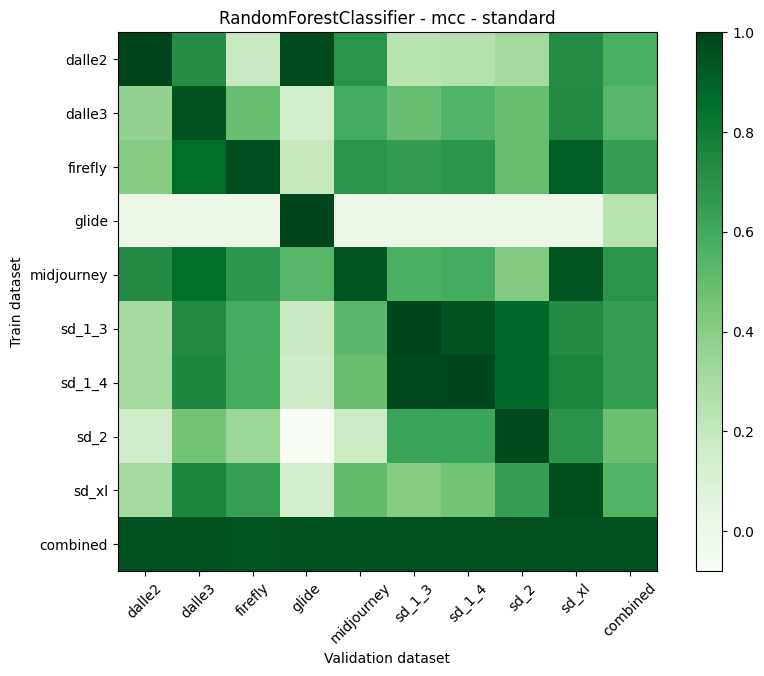

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.725120  0.185171  0.975308    0.690720  0.239601   
dalle3         0.362956  0.950686  0.489684  0.140341    0.590440  0.489684   
firefly        0.405121  0.858451  0.962805  0.196472    0.687267  0.657903   
glide          0.000000  0.000000  0.000000  0.993768    0.000000  0.000000   
midjourney     0.732097  0.858451  0.677439  0.533042    0.944680  0.566530   
sd_1_3         0.303909  0.735069  0.585517  0.176269    0.519320  0.987576   
sd_1_4         0.309819  0.750104  0.580792  0.157153    0.485914  0.981423   
sd_2           0.148799  0.459456  0.344444 -0.080806    0.167790  0.624944   
sd_xl          0.312237  0.757507  0.638506  0.140341    0.504199  0.410253   
combined       0.957117  0.957117  0.944159  0.957117    0.950617  0.957117   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.246575  0.309819  0.725120  0.572396  
dalle3         0.552188  0.489684  0.732097  0.538897  
firefly        0.682347  0.489684  0.915164  0.648727  
glide          0.000000  0.000000  0.000000  0.239601  
midjourney     0.585655  0.415360  0.944680  0.688362  
sd_1_3         0.945284  0.871042  0.730087  0.649405  
sd_1_4         0.987576  0.871042  0.755147  0.652068  
sd_2           0.620074  0.981260  0.693956  0.477608  
sd_xl          0.455445  0.653042  0.968920  0.544216  
combined       0.957117  0.957117  0.957117  0.954946

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.725120  0.185171  0.975308    0.690720  0.239601   
dalle3         0.362956  0.950686  0.489684  0.140341    0.590440  0.489684   
firefly        0.405121  0.858451  0.962805  0.196472    0.687267  0.657903   
glide          0.000000  0.000000  0.000000  0.993768    0.000000  0.000000   
midjourney     0.732097  0.858451  0.677439  0.533042    0.944680  0.566530   
sd_1_3         0.303909  0.735069  0.585517  0.176269    0.519320  0.987576   
sd_1_4         0.309819  0.750104  0.580792  0.157153    0.485914  0.981423   
sd_2           0.148799  0.459456  0.344444 -0.080806    0.167790  0.624944   
sd_xl          0.312237  0.757507  0.638506  0.140341    0.504199  0.410253   
combined       0.957117  0.957117  0.944159  0.957117    0.950617  0.957117   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.246575  0.309819  0.725120  0.566382  
dalle3         0.552188  0.489684  0.732097  0.533085  
firefly        0.682347  0.489684  0.915164  0.650579  
glide          0.000000  0.000000  0.000000  0.110419  
midjourney     0.585655  0.415360  0.944680  0.695326  
sd_1_3         0.945284  0.871042  0.730087  0.650453  
sd_1_4         0.987576  0.871042  0.755147  0.653219  
sd_2           0.620074  0.981260  0.693956  0.439991  
sd_xl          0.455445  0.653042  0.968920  0.537828  
combined       0.957117  0.957117  0.957117  0.954955

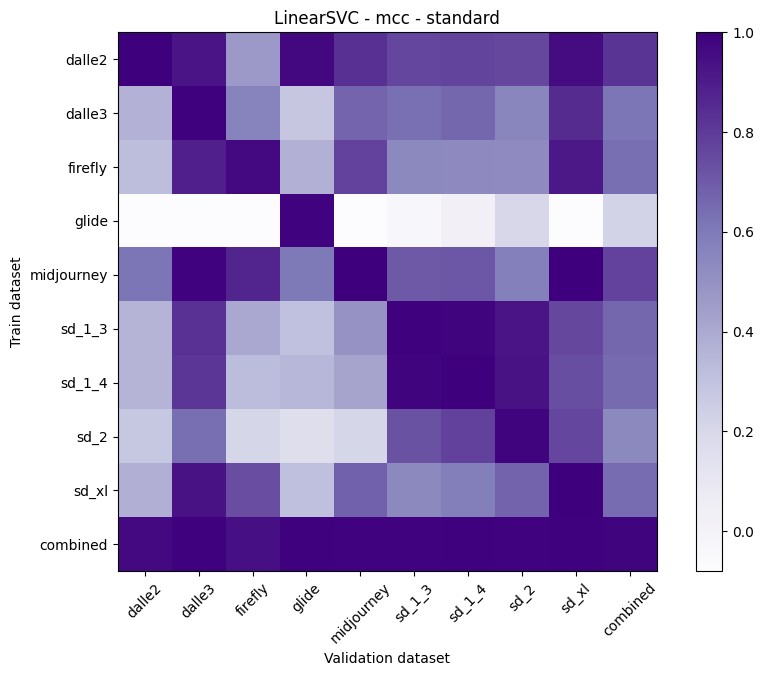

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.927686  0.466618  0.969230    0.833013  0.760207   
dalle3         0.365624  0.993768  0.561903  0.279458    0.666492  0.632945   
firefly        0.320114  0.890120  0.962487  0.370688    0.773620  0.538005   
glide         -0.080806 -0.080806 -0.080806  0.987570   -0.080806 -0.034257   
midjourney     0.613922  0.987576  0.871042  0.599705    1.000000  0.700487   
sd_1_3         0.354865  0.827677  0.402124  0.303909    0.495499  0.993768   
sd_1_4         0.354865  0.811803  0.321431  0.343928    0.422337  0.981423   
sd_2           0.277530  0.640959  0.208258  0.158208    0.208258  0.721470   
sd_xl          0.370943  0.939385  0.740065  0.309819    0.680998  0.538275   
combined       0.962805  0.993766  0.944680  0.993766    0.987496  0.987496   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.770377  0.755147  0.957186  0.818834  
dalle3         0.661675  0.552457  0.849162  0.615504  
firefly        0.528216  0.523316  0.913693  0.639859  
glide          0.022839  0.201753 -0.080806  0.221415  
midjourney     0.710301  0.580792  1.000000  0.774920  
sd_1_3         0.981423  0.927686  0.755147  0.662210  
sd_1_4         1.000000  0.933519  0.735069  0.647276  
sd_2           0.778935  0.981410  0.763048  0.539092  
sd_xl          0.585517  0.671317  1.000000  0.643023  
combined       0.993766  0.987496  0.993766  0.982646

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.927686  0.466618  0.969230    0.833013  0.760207   
dalle3         0.365624  0.993768  0.561903  0.279458    0.666492  0.632945   
firefly        0.320114  0.890120  0.962487  0.370688    0.773620  0.538005   
glide         -0.080806 -0.080806 -0.080806  0.987570   -0.080806 -0.034257   
midjourney     0.613922  0.987576  0.871042  0.599705    1.000000  0.700487   
sd_1_3         0.354865  0.827677  0.402124  0.303909    0.495499  0.993768   
sd_1_4         0.354865  0.811803  0.321431  0.343928    0.422337  0.981423   
sd_2           0.277530  0.640959  0.208258  0.158208    0.208258  0.721470   
sd_xl          0.370943  0.939385  0.740065  0.309819    0.680998  0.538275   
combined       0.962805  0.993766  0.944680  0.993766    0.987496  0.987496   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.770377  0.755147  0.957186  0.826607  
dalle3         0.661675  0.552457  0.849162  0.618165  
firefly        0.528216  0.523316  0.913693  0.646695  
glide          0.022839  0.201753 -0.080806  0.085986  
midjourney     0.710301  0.580792  1.000000  0.784870  
sd_1_3         0.981423  0.927686  0.755147  0.671344  
sd_1_4         1.000000  0.933519  0.735069  0.656042  
sd_2           0.778935  0.981410  0.763048  0.526453  
sd_xl          0.585517  0.671317  1.000000  0.648480  
combined       0.993766  0.987496  0.993766  0.982782

In [13]:
print("########################### MCC ###########################")
for perturbed_name, results in perturbed_results.items():
    print(f"\n\n\n\n\n\n\n\n ################ Evaluating models trained on {base_perturbed_name} and tested on {perturbed_name}. ################")
    
    # Create a heatmap of results
    df = pd.DataFrame(results).T
    df.reset_index(inplace=True)
    df.columns = ["train_dataset", "val_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

    metric = "mcc"
    evaluation_data_name = "Validation"
    df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)

## Test data

In [14]:
perturbed_results = {}   

for perturbed_name, X_test, y_test in zip(perturbed_X_test.keys(), perturbed_X_test.values(), perturbed_y_test.values()):
    results = {}
    X_train = perturbed_X_train["standard"]
    print(f"\n\n\n\n\n\n\n\n ################ Evaluating models trained on {base_perturbed_name} and tested on {perturbed_name}. ################")
    for dataset_name in models.keys():
        print(f"\n\n\n\n *** Evaluating models trained on {dataset_name}. ***")
        for test_dataset_name in X_test.keys():
            print(f"\n\nValidation set: {test_dataset_name}")
            for model_name, model in models[dataset_name].items():
                print()  
                X_test_scaled = scalers[dataset_name].transform(X_test[test_dataset_name][X_train[dataset_name].columns])
                X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train[dataset_name].columns)
                accuracy, f1, precision, recall, mcc = evaluate_model(model, X_test_scaled, y_test[test_dataset_name], name=model_name)
                model_results = {
                    "accuracy": accuracy,
                    "f1": f1,
                    "precision": precision,
                    "recall": recall,
                    "mcc": mcc
                }
                results[(dataset_name, test_dataset_name, model_name)] = model_results
                
    perturbed_results[perturbed_name] = results









 ################ Evaluating models trained on standardAugmented and tested on jpg_quality_50. ################




 *** Evaluating models trained on dalle2. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9625
F1: 0.9625
Precision: 0.9645
Recall: 0.9625
MCC: 0.9270

Model: LinearDiscriminantAnalysis
Accuracy: 0.9475
F1: 0.9475
Precision: 0.9489
Recall: 0.9475
MCC: 0.8964

Model: RandomForestClassifier
Accuracy: 0.9875
F1: 0.9875
Precision: 0.9875
Recall: 0.9875
MCC: 0.9750

Model: LinearSVC
Accuracy: 0.9700
F1: 0.9700
Precision: 0.9712
Recall: 0.9700
MCC: 0.9412


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.7875
F1: 0.7779
Precision: 0.8473
Recall: 0.7875
MCC: 0.6320

Model: LinearDiscriminantAnalysis
Accuracy: 0.7600
F1: 0.7537
Precision: 0.7897
Recall: 0.7600
MCC: 0.5489

Model: RandomForestClassifier
Accuracy: 0.7275
F1: 0.7073
Precision: 0.8141
Recall: 0.7275
MCC: 0.5346

Model: LinearSVC
Accuracy: 0.8825
F1: 0.

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4975
F1: 0.3819
Precision: 0.4901
Recall: 0.4975
MCC: -0.0100

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4975
F1: 0.3366
Precision: 0.4160
Recall: 0.4975
MCC: -0.0290


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4675
F1: 0.3226
Precision: 0.2749
Recall: 0.4675
MCC: -0.1711

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4950
F1: 0.3311
Precision: 0.2487
Recall: 0.4950
MCC: -0.0709


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4650
F1: 0.3174
Precision: 0.2409
Recall: 0.4650
MCC: -0.1904

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4950
F1: 0.3311
Precision: 0.2487
Recall: 0.4950
MCC: -0.0709


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9400
F1: 0.9398
Precision: 0.9464
Recall: 0.9400
MCC: 0.8864

Model: LinearDiscriminantAnalysis
Accuracy: 0.9600
F1: 0.9600
Precision: 0.9617
Recall: 0.9600
MCC: 0.9217

Model: RandomForestClassifier
Accuracy: 0.9300
F1: 0.9297
Precision: 0.9386
Recall: 0.9300
MCC: 0.8686

Model: LinearSVC
Accuracy: 0.9325
F1: 0.9323
Precision: 0.9383
Recall: 0.9325
MCC: 0.8708


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4650
F1: 0.3174
Precision: 0.2409
Recall: 0.4650
MCC: -0.1904

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4950
F1: 0.3311
Precision: 0.2487
Recall: 0.4950
MCC: -0.0709


Validation set: sd_1_3

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5025
F1: 0.3912
Precision: 0.5093
Recall: 0.5025
MCC: 0.0096

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3420
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5150
F1: 0.4141
Precision: 0.5482
Recall: 0.5150
MCC: 0.0538

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3420
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.5025
F1: 0.3389
Precision: 0.7506
Recall: 0.5025
MCC: 0.0501

Model: LinearDiscriminantAnalysis
Accuracy: 0.5325
F1: 0.4448
Precision: 0.5883
Recall: 0.5325
MCC: 0.1072

Model: RandomForestClassifier
Accuracy: 0.5025
F1: 0.3389
Precision: 0.7506
Recall: 0.5025
MCC: 0.0501

Model: LinearSVC
Accuracy: 0.5350
F1: 0.4136
Precision: 0.7036
Recall: 0.5350
MCC: 0.1688


Validation set: sd_xl

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5050
F1: 0.3959
Precision: 0.5180
Recall: 0.5050
MCC: 0.0190

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4950
F1: 0.3311
Precision: 0.2487
Recall: 0.4950
MCC: -0.0709


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5492
F1: 0.4342
Precision: 0.7629
Recall: 0.5492
MCC: 0.2274

Model: LinearDiscriminantAnalysis
Accuracy: 0.5456
F1: 0.4667
Precision: 0.6114
Recall: 0.5456
MCC: 0.1425

Model: RandomForestClassifier
Accuracy: 0.5481
F1: 0.4320
Precision: 0.7626
Recall: 0.5481
MCC: 0.2247

Model: LinearSVC
Accuracy: 0.5494
F1: 0.4409
Precision: 0.7211
Recall: 0.5494
MCC: 0.2091




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.7775
F1: 0.7665
Precision: 0.8423
Recall: 0.7775
MCC: 0.6164

Model: LinearDiscriminantAnalysis
Accuracy: 0.8350
F1: 0.8326
Precision: 0.8555
Recall: 0.8350
MCC: 0.6902

Model: RandomForestClassifier
Accuracy: 0.7500
F1: 0.7373
Precision: 0.8100
Recall: 0.7500
MCC: 0.5568

Model: LinearSVC
Accuracy: 0.7925
F1: 0.7841
Precision: 0.8466


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5325
F1: 0.4154
Precision: 0.6633
Recall: 0.5325
MCC: 0.1457

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5025
F1: 0.3474
Precision: 0.5506
Recall: 0.5025
MCC: 0.0225


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5050
F1: 0.3608
Precision: 0.5513
Recall: 0.5050
MCC: 0.0320



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4950
F1: 0.3311
Precision: 0.2487
Recall: 0.4950
MCC: -0.0709


Validation set: firefly



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4900
F1: 0.3289
Precision: 0.2475
Recall: 0.4900
MCC: -0.1005



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4950
F1: 0.3311
Precision: 0.2487
Recall: 0.4950
MCC: -0.0709


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9625
F1: 0.9624
Precision: 0.9651
Recall: 0.9625
MCC: 0.9276

Model: LinearDiscriminantAnalysis
Accuracy: 0.9750
F1: 0.9750
Precision: 0.9750
Recall: 0.9750
MCC: 0.9500

Model: RandomForestClassifier
Accuracy: 0.9575
F1: 0.9574
Precision: 0.9608
Recall: 0.9575
MCC: 0.9183

Model: LinearSVC
Accuracy: 0.9525
F1: 0.9524
Precision: 0.9551
Recall: 0.9525
MCC: 0.9076


Validation set: midjourney



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3503
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4950
F1: 0.3311
Precision: 0.2487
Recall: 0.4950
MCC: -0.0709


Validation set: sd_1_3



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5475
F1: 0.4434
Precision: 0.6887
Recall: 0.5475
MCC: 0.1893



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5075
F1: 0.3581
Precision: 0.6091
Recall: 0.5075
MCC: 0.0572


Validation set: sd_1_4



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5450
F1: 0.4388
Precision: 0.6851
Recall: 0.5450
MCC: 0.1825



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4950
F1: 0.3311
Precision: 0.2487
Recall: 0.4950
MCC: -0.0709


Validation set: sd_2



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5975
F1: 0.5285
Precision: 0.7351
Recall: 0.5975
MCC: 0.3028



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5450
F1: 0.4327
Precision: 0.7165
Recall: 0.5450
MCC: 0.1974


Validation set: sd_xl



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5425
F1: 0.4342
Precision: 0.6813
Recall: 0.5425
MCC: 0.1756



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4950
F1: 0.3311
Precision: 0.2487
Recall: 0.4950
MCC: -0.0709


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5514
F1: 0.4384
Precision: 0.7635
Recall: 0.5514
MCC: 0.2328

Model: LinearDiscriminantAnalysis
Accuracy: 0.5817
F1: 0.5028
Precision: 0.7235
Recall: 0.5817
MCC: 0.2702

Model: RandomForestClassifier
Accuracy: 0.5508
F1: 0.4373
Precision: 0.7634
Recall: 0.5508
MCC: 0.2314

Model: LinearSVC
Accuracy: 0.5536
F1: 0.4486
Precision: 0.7250
Recall: 0.5536
MCC: 0.2197




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.8350
F1: 0.8317
Precision: 0.8635
Recall: 0.8350
MCC: 0.6979

Model: LinearDiscriminantAnalysis
Accuracy: 0.8600
F1: 0.8583
Precision: 0.8783
Recall: 0.8600
MCC: 0.7381

Model: RandomForestClassifier
Accuracy: 0.8050
F1: 0.7999
Preci

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5025
F1: 0.3556
Precision: 0.5284
Recall: 0.5025
MCC: 0.0169

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4925
F1: 0.3343
Precision: 0.3481
Recall: 0.4925
MCC: -0.0675



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9725
F1: 0.9725
Precision: 0.9739
Recall: 0.9725
MCC: 0.9464

Model: LinearDiscriminantAnalysis
Accuracy: 0.9725
F1: 0.9725
Precision: 0.9726
Recall: 0.9725
MCC: 0.9451

Model: RandomForestClassifier
Accuracy: 0.9650
F1: 0.9650
Precision: 0.9673
Recall: 0.9650
MCC: 0.9323

Model: LinearSVC
Accuracy: 0.9800
F1: 0.9800
Precision: 0.9804
Recall: 0.9800
MCC: 0.9604


Validation set: midjourney



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5100
F1: 0.3711
Precision: 0.5859
Recall: 0.5100
MCC: 0.0586



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501


Validation set: sd_1_3

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5400
F1: 0.4296
Precision: 0.6773
Recall: 0.5400
MCC: 0.1684



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5150
F1: 0.3698
Precision: 0.6913
Recall: 0.5150
MCC: 0.1071


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5525
F1: 0.4524
Precision: 0.6952
Recall: 0.5525
MCC: 0.2025



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5100
F1: 0.3593
Precision: 0.6692
Recall: 0.5100
MCC: 0.0823


Validation set: sd_2



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.6325
F1: 0.5820
Precision: 0.7563
Recall: 0.6325
MCC: 0.3686



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5550
F1: 0.4482
Precision: 0.7438
Recall: 0.5550
MCC: 0.2316


Validation set: sd_xl

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5775
F1: 0.4958
Precision: 0.7202
Recall: 0.5775
MCC: 0.2613

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5528
F1: 0.4410
Precision: 0.7639
Recall: 0.5528
MCC: 0.2360

Model: LinearDiscriminantAnalysis
Accuracy: 0.5928
F1: 0.5209
Precision: 0.7318
Recall: 0.5928
MCC: 0.2933

Model: RandomForestClassifier
Accuracy: 0.5517
F1: 0.4389
Precision: 0.7636
Recall: 0.5517
MCC: 0.2334

Model: LinearSVC
Accuracy: 0.5619
F1: 0.4608
Precision: 0.7479
Recall: 0.5619
MCC: 0.2479




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9125
F1: 0.9120
Precision: 0.9214
Recall: 0.9125
MCC: 0.8338

Model: LinearDiscriminantAnalysis
Accuracy: 0.8550
F1: 0.8525
Precision: 0.8807
Recall: 0.8550
MCC: 0.7353

Model: RandomForestClassifier
Accuracy: 0.7975
F1: 0.7909
Precision: 0.8404
Recall: 0.7975
MCC: 0.6365

Model: LinearSVC
Accuracy: 0.7750
F1: 0.7651
Precision: 0.8306


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5450
F1: 0.4358
Precision: 0.6995
Recall: 0.5450
MCC: 0.1895

Model: RandomForestClassifier
Accuracy: 0.5025
F1: 0.3389
Precision: 0.7506
Recall: 0.5025
MCC: 0.0501

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3420
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5100
F1: 0.3672
Precision: 0.6026
Recall: 0.5100
MCC: 0.0641

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4950
F1: 0.3311
Precision: 0.2487
Recall: 0.4950
MCC: -0.0709


Validation set: firefly



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4950
F1: 0.3354
Precision: 0.3737
Recall: 0.4950
MCC: -0.0503



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4950
F1: 0.3311
Precision: 0.2487
Recall: 0.4950
MCC: -0.0709


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9900
F1: 0.9900
Precision: 0.9902
Recall: 0.9900
MCC: 0.9802

Model: LinearDiscriminantAnalysis
Accuracy: 0.9875
F1: 0.9875
Precision: 0.9875
Recall: 0.9875
MCC: 0.9750

Model: RandomForestClassifier
Accuracy: 0.9900
F1: 0.9900
Precision: 0.9902
Recall: 0.9900
MCC: 0.9802

Model: LinearSVC
Accuracy: 0.9900
F1: 0.9900
Precision: 0.9900
Recall: 0.9900
MCC: 0.9800


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5175
F1: 0.3826
Precision: 0.6391
Recall: 0.5175
MCC: 0.0987

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4975
F1: 0.3366
Precision: 0.4160
Recall: 0.4975
MCC: -0.0290


Validation set: sd_1_3

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5475
F1: 0.4404
Precision: 0.7027
Recall: 0.5475
MCC: 0.1962

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5050
F1: 0.3528
Precision: 0.5846
Recall: 0.5050
MCC: 0.0411


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5400
F1: 0.4264
Precision: 0.6924
Recall: 0.5400
MCC: 0.1755

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3420
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.6025
F1: 0.5344
Precision: 0.7471
Recall: 0.6025
MCC: 0.3183

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5450
F1: 0.4327
Precision: 0.7165
Recall: 0.5450
MCC: 0.1974


Validation set: sd_xl

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5725
F1: 0.4848
Precision: 0.7270
Recall: 0.5725
MCC: 0.2566

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4950
F1: 0.3311
Precision: 0.2487
Recall: 0.4950
MCC: -0.0709


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5544
F1: 0.4441
Precision: 0.7644
Recall: 0.5544
MCC: 0.2400

Model: LinearDiscriminantAnalysis
Accuracy: 0.5908
F1: 0.5156
Precision: 0.7400
Recall: 0.5908
MCC: 0.2953

Model: RandomForestClassifier
Accuracy: 0.5547
F1: 0.4446
Precision: 0.7645
Recall: 0.5547
MCC: 0.2406

Model: LinearSVC
Accuracy: 0.5581
F1: 0.4567
Precision: 0.7288
Recall: 0.5581
MCC: 0.2305




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.8750
F1: 0.8736
Precision: 0.8923
Recall: 0.8750
MCC: 0.7671

Model: LinearDiscriminantAnalysis
Accuracy: 0.8875
F1: 0.8863
Precision: 0.9045
Recall: 0.8875
MCC: 0.7918

Model: RandomForestClassifier
Accuracy: 0.8175
F1: 0.8122
Precision: 0.8576
Recall: 0.8175
MCC: 0.6739

Model: LinearSVC
Accuracy: 0.7825
F1: 0.7737
Precision: 0.8347


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5500
F1: 0.4357
Precision: 0.7632
Recall: 0.5500
MCC: 0.2294

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4975
F1: 0.3408
Precision: 0.4494
Recall: 0.4975
MCC: -0.0225


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5125
F1: 0.3605
Precision: 0.7532
Recall: 0.5125
MCC: 0.1125

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4925
F1: 0.3300
Precision: 0.2481
Recall: 0.4925
MCC: -0.0869


Validation set: firefly



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4925
F1: 0.3300
Precision: 0.2481
Recall: 0.4925
MCC: -0.0869


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9900
F1: 0.9900
Precision: 0.9902
Recall: 0.9900
MCC: 0.9802

Model: LinearDiscriminantAnalysis
Accuracy: 0.9925
F1: 0.9925
Precision: 0.9926
Recall: 0.9925
MCC: 0.9851

Model: RandomForestClassifier
Accuracy: 0.9750
F1: 0.9750
Precision: 0.9762
Recall: 0.9750
MCC: 0.9512

Model: LinearSVC
Accuracy: 0.9800
F1: 0.9800
Precision: 0.9800
Recall: 0.9800
MCC: 0.9600


Validation set: midjourney



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5150
F1: 0.3658
Precision: 0.7538
Recall: 0.5150
MCC: 0.1234



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4925
F1: 0.3300
Precision: 0.2481
Recall: 0.4925
MCC: -0.0869


Validation set: sd_1_3



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5925
F1: 0.5114
Precision: 0.7755
Recall: 0.5925
MCC: 0.3193



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3462
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000


Validation set: sd_1_4



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5875
F1: 0.5029
Precision: 0.7740
Recall: 0.5875
MCC: 0.3097



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4950
F1: 0.3354
Precision: 0.3737
Recall: 0.4950
MCC: -0.0503


Validation set: sd_2



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.6625
F1: 0.6191
Precision: 0.7985
Recall: 0.6625
MCC: 0.4405



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5425
F1: 0.4311
Precision: 0.6961
Recall: 0.5425
MCC: 0.1826


Validation set: sd_xl

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.6075
F1: 0.5360
Precision: 0.7801
Recall: 0.6075
MCC: 0.3471

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4925
F1: 0.3300
Precision: 0.2481
Recall: 0.4925
MCC: -0.0869


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5544
F1: 0.4441
Precision: 0.7644
Recall: 0.5544
MCC: 0.2400

Model: LinearDiscriminantAnalysis
Accuracy: 0.6133
F1: 0.5454
Precision: 0.7820
Recall: 0.6133
MCC: 0.3575

Model: RandomForestClassifier
Accuracy: 0.5528
F1: 0.4410
Precision: 0.7639
Recall: 0.5528
MCC: 0.2360

Model: LinearSVC
Accuracy: 0.5539
F1: 0.4520
Precision: 0.7100
Recall: 0.5539
MCC: 0.2128




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9675
F1: 0.9675
Precision: 0.9678
Recall: 0.9675
MCC: 0.9353

Model: LinearDiscriminantAnalysis
Accuracy: 0.8250
F1: 0.8198
Precision: 0.8675
Recall: 0.8250
MCC: 0.6912

Model: RandomForestClassifier
Accuracy: 0.8775
F1: 0.8768
Precision: 0.8868
Recall: 0.8775
MCC: 0.7642

Model: LinearSVC
Accuracy: 0.7900
F1: 0.7817
Precision: 0.8420


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5250
F1: 0.3903
Precision: 0.7148
Recall: 0.5250
MCC: 0.1466

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5150
F1: 0.3698
Precision: 0.6913
Recall: 0.5150
MCC: 0.1071

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3377
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.9975
F1: 0.9975
Precision: 0.9975
Recall: 0.9975
MCC: 0.9950

Model: RandomForestClassifier
Accuracy: 0.9950
F1: 0.9950
Precision: 0.9950
Recall: 0.9950
MCC: 0.9900

Model: LinearSVC
Accuracy: 0.9975
F1: 0.9975
Precision: 0.9975
Recall: 0.9975
MCC: 0.9950


Validation set: midjourney



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5175
F1: 0.3750
Precision: 0.6989
Recall: 0.5175
MCC: 0.1180



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501


Validation set: sd_1_3

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5800
F1: 0.4926
Precision: 0.7572
Recall: 0.5800
MCC: 0.2869



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3377
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5800
F1: 0.4926
Precision: 0.7572
Recall: 0.5800
MCC: 0.2869



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5050
F1: 0.3486
Precision: 0.6263
Recall: 0.5050
MCC: 0.0503


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.6325
F1: 0.5769
Precision: 0.7793
Recall: 0.6325
MCC: 0.3848



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5525
F1: 0.4435
Precision: 0.7422
Recall: 0.5525
MCC: 0.2255


Validation set: sd_xl



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5750
F1: 0.4840
Precision: 0.7548
Recall: 0.5750
MCC: 0.2765



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5556
F1: 0.4462
Precision: 0.7647
Recall: 0.5556
MCC: 0.2425

Model: LinearDiscriminantAnalysis
Accuracy: 0.6025
F1: 0.5301
Precision: 0.7671
Recall: 0.6025
MCC: 0.3309

Model: RandomForestClassifier
Accuracy: 0.5550
F1: 0.4451
Precision: 0.7646
Recall: 0.5550
MCC: 0.2412

Model: LinearSVC
Accuracy: 0.5603
F1: 0.4578
Precision: 0.7470
Recall: 0.5603
MCC: 0.2440




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9525
F1: 0.9525
Precision: 0.9534
Recall: 0.9525
MCC: 0.9059

Model: LinearDiscriminantAnalysis
Accuracy: 0.7525
F1: 0.7402
Precision: 0.8114
Recall: 0.7525
MCC: 0.5608

Model: RandomForestClassifier
Accuracy: 0.8950
F1: 0.8945
Preci

### Accuracy - Test

########################### Accuracy ###########################








 ################ Evaluating models trained on standardAugmented and tested on jpg_quality_50. ################


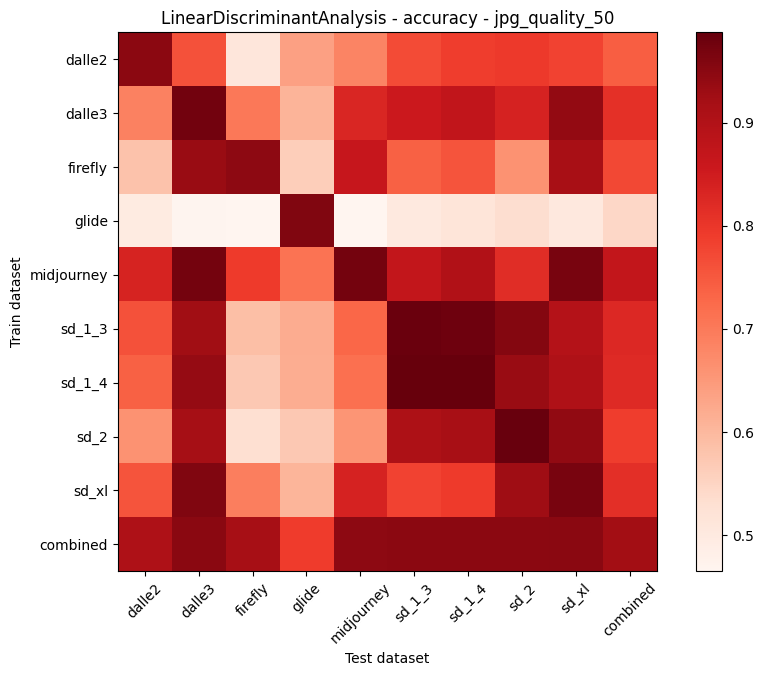

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9475  0.7600   0.5100  0.6375      0.6825  0.7675  0.7875   
dalle3         0.6875  0.9750   0.7025  0.6075      0.8300  0.8550  0.8725   
firefly        0.5825  0.9325   0.9450  0.5625      0.8650  0.7375  0.7550   
glide          0.4975  0.4675   0.4650  0.9600      0.4650  0.5025  0.5150   
midjourney     0.8350  0.9725   0.7925  0.7100      0.9725  0.8700  0.9000   
sd_1_3         0.7600  0.9250   0.5875  0.6200      0.7300  0.9825  0.9775   
sd_1_4         0.7375  0.9375   0.5725  0.6175      0.7150  0.9875  0.9875   
sd_2           0.6600  0.9200   0.5300  0.5725      0.6550  0.9075  0.9150   
sd_xl          0.7550  0.9600   0.6925  0.6050      0.8375  0.7800  0.7925   
combined       0.9050  0.9500   0.9175  0.7900      0.9450  0.9475  0.9475   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.7950  0.7800  0.740833  
dalle3         0.8375  0.9400  0.811944  
firefly        0.6600  0.9150  0.772778  
glide          0.5325  0.5050  0.545556  
midjourney     0.8175  0.9675  0.870833  
sd_1_3         0.9550  0.8950  0.825833  
sd_1_4         0.9325  0.9025  0.821111  
sd_2           0.9850  0.9425  0.787500  
sd_xl          0.9275  0.9675  0.813056  
combined       0.9475  0.9500  0.922222

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9475  0.7600   0.5100  0.6375      0.6825  0.7675  0.7875   
dalle3         0.6875  0.9750   0.7025  0.6075      0.8300  0.8550  0.8725   
firefly        0.5825  0.9325   0.9450  0.5625      0.8650  0.7375  0.7550   
glide          0.4975  0.4675   0.4650  0.9600      0.4650  0.5025  0.5150   
midjourney     0.8350  0.9725   0.7925  0.7100      0.9725  0.8700  0.9000   
sd_1_3         0.7600  0.9250   0.5875  0.6200      0.7300  0.9825  0.9775   
sd_1_4         0.7375  0.9375   0.5725  0.6175      0.7150  0.9875  0.9875   
sd_2           0.6600  0.9200   0.5300  0.5725      0.6550  0.9075  0.9150   
sd_xl          0.7550  0.9600   0.6925  0.6050      0.8375  0.7800  0.7925   
combined       0.9050  0.9500   0.9175  0.7900      0.9450  0.9475  0.9475   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.7950  0.7800  0.740833  
dalle3         0.8375  0.9400  0.811944  
firefly        0.6600  0.9150  0.772778  
glide          0.5325  0.5050  0.545556  
midjourney     0.8175  0.9675  0.870833  
sd_1_3         0.9550  0.8950  0.825833  
sd_1_4         0.9325  0.9025  0.821111  
sd_2           0.9850  0.9425  0.787500  
sd_xl          0.9275  0.9675  0.813056  
combined       0.9475  0.9500  0.922222

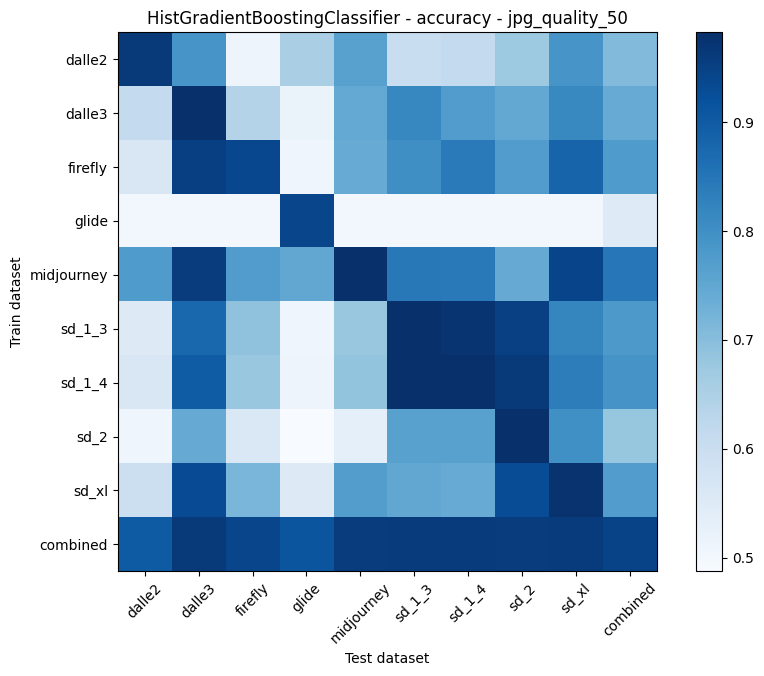

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9625  0.7875   0.5125  0.6550      0.7625  0.6025  0.6150   
dalle3         0.6150  0.9800   0.6400  0.5200      0.7450  0.8175  0.7725   
firefly        0.5625  0.9525   0.9375  0.5075      0.7400  0.8025  0.8400   
glide          0.5000  0.5000   0.5000  0.9400      0.5000  0.5000  0.5000   
midjourney     0.7775  0.9575   0.7725  0.7500      0.9825  0.8450  0.8425   
sd_1_3         0.5525  0.8775   0.6900  0.5075      0.6800  0.9800  0.9725   
sd_1_4         0.5625  0.8975   0.6800  0.5125      0.6850  0.9825  0.9825   
sd_2           0.5100  0.7425   0.5575  0.4875      0.5325  0.7625  0.7625   
sd_xl          0.5950  0.9300   0.7175  0.5525      0.7700  0.7500  0.7400   
combined       0.9000  0.9625   0.9400  0.9125      0.9575  0.9600  0.9600   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.6725  0.7875  0.706389  
dalle3         0.7475  0.8125  0.738889  
firefly        0.7725  0.8825  0.777500  
glide          0.5025  0.5000  0.549167  
midjourney     0.7425  0.9425  0.845833  
sd_1_3         0.9500  0.8200  0.781111  
sd_1_4         0.9650  0.8350  0.789167  
sd_2           0.9800  0.8000  0.681667  
sd_xl          0.9275  0.9750  0.773056  
combined       0.9575  0.9600  0.945556

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9625  0.7875   0.5125  0.6550      0.7625  0.6025  0.6150   
dalle3         0.6150  0.9800   0.6400  0.5200      0.7450  0.8175  0.7725   
firefly        0.5625  0.9525   0.9375  0.5075      0.7400  0.8025  0.8400   
glide          0.5000  0.5000   0.5000  0.9400      0.5000  0.5000  0.5000   
midjourney     0.7775  0.9575   0.7725  0.7500      0.9825  0.8450  0.8425   
sd_1_3         0.5525  0.8775   0.6900  0.5075      0.6800  0.9800  0.9725   
sd_1_4         0.5625  0.8975   0.6800  0.5125      0.6850  0.9825  0.9825   
sd_2           0.5100  0.7425   0.5575  0.4875      0.5325  0.7625  0.7625   
sd_xl          0.5950  0.9300   0.7175  0.5525      0.7700  0.7500  0.7400   
combined       0.9000  0.9625   0.9400  0.9125      0.9575  0.9600  0.9600   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.6725  0.7875  0.706389  
dalle3         0.7475  0.8125  0.738889  
firefly        0.7725  0.8825  0.777500  
glide          0.5025  0.5000  0.549167  
midjourney     0.7425  0.9425  0.845833  
sd_1_3         0.9500  0.8200  0.781111  
sd_1_4         0.9650  0.8350  0.789167  
sd_2           0.9800  0.8000  0.681667  
sd_xl          0.9275  0.9750  0.773056  
combined       0.9575  0.9600  0.945556

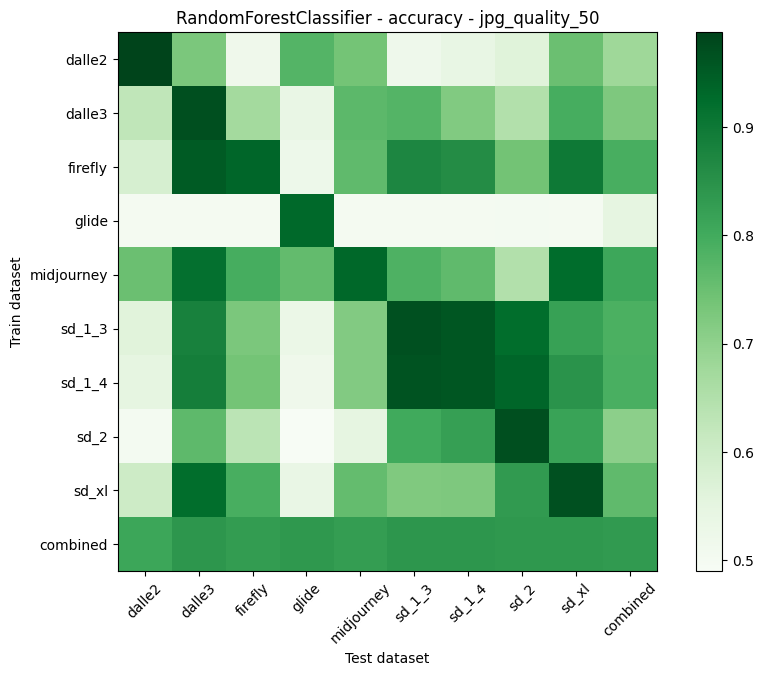

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9875  0.7275   0.5175  0.7775      0.7375  0.5200  0.5400   
dalle3         0.6250  0.9700   0.6725  0.5375      0.7675  0.7775  0.7200   
firefly        0.5825  0.9525   0.9350  0.5225      0.7625  0.8725  0.8600   
glide          0.5000  0.5000   0.5000  0.9300      0.5000  0.5000  0.5000   
midjourney     0.7500  0.9175   0.7950  0.7600      0.9325  0.7850  0.7625   
sd_1_3         0.5600  0.8825   0.7275  0.5300      0.7175  0.9675  0.9600   
sd_1_4         0.5500  0.8875   0.7375  0.5175      0.7175  0.9625  0.9600   
sd_2           0.5025  0.7650   0.6325  0.4900      0.5500  0.8025  0.8225   
sd_xl          0.6025  0.9225   0.7925  0.5375      0.7575  0.7225  0.7250   
combined       0.8100  0.8400   0.8300  0.8375      0.8275  0.8400  0.8400   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.5625  0.7500  0.680000  
dalle3         0.6475  0.7950  0.723611  
firefly        0.7400  0.9000  0.791944  
glide          0.5025  0.5000  0.548056  
midjourney     0.6475  0.9250  0.808333  
sd_1_3         0.9225  0.8200  0.787500  
sd_1_4         0.9350  0.8475  0.790556  
sd_2           0.9700  0.8150  0.705556  
sd_xl          0.8325  0.9675  0.762222  
combined       0.8375  0.8375  0.833333

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9875  0.7275   0.5175  0.7775      0.7375  0.5200  0.5400   
dalle3         0.6250  0.9700   0.6725  0.5375      0.7675  0.7775  0.7200   
firefly        0.5825  0.9525   0.9350  0.5225      0.7625  0.8725  0.8600   
glide          0.5000  0.5000   0.5000  0.9300      0.5000  0.5000  0.5000   
midjourney     0.7500  0.9175   0.7950  0.7600      0.9325  0.7850  0.7625   
sd_1_3         0.5600  0.8825   0.7275  0.5300      0.7175  0.9675  0.9600   
sd_1_4         0.5500  0.8875   0.7375  0.5175      0.7175  0.9625  0.9600   
sd_2           0.5025  0.7650   0.6325  0.4900      0.5500  0.8025  0.8225   
sd_xl          0.6025  0.9225   0.7925  0.5375      0.7575  0.7225  0.7250   
combined       0.8100  0.8400   0.8300  0.8375      0.8275  0.8400  0.8400   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.5625  0.7500  0.680000  
dalle3         0.6475  0.7950  0.723611  
firefly        0.7400  0.9000  0.791944  
glide          0.5025  0.5000  0.548056  
midjourney     0.6475  0.9250  0.808333  
sd_1_3         0.9225  0.8200  0.787500  
sd_1_4         0.9350  0.8475  0.790556  
sd_2           0.9700  0.8150  0.705556  
sd_xl          0.8325  0.9675  0.762222  
combined       0.8375  0.8375  0.833333

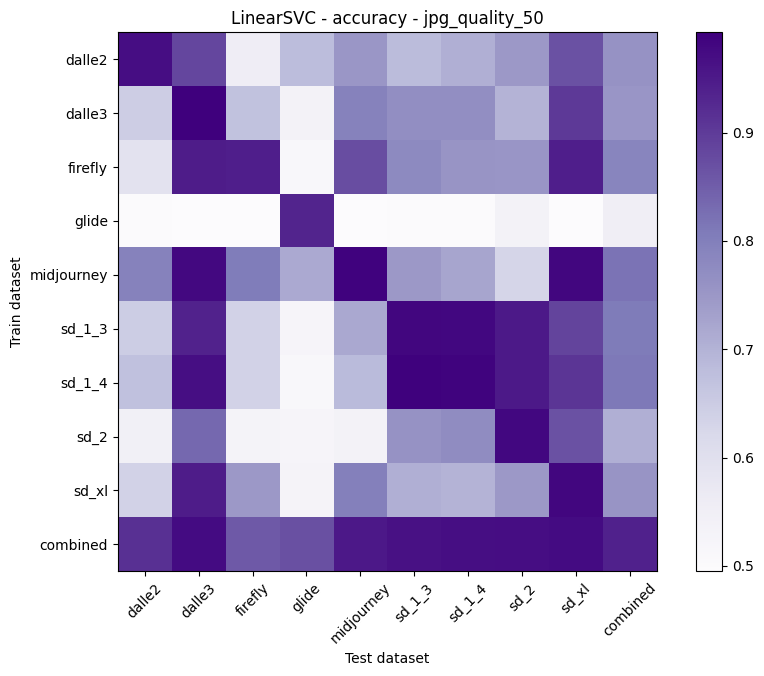

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9700  0.8825   0.5550  0.6800      0.7500  0.6825  0.7050   
dalle3         0.6450  0.9925   0.6700  0.5350      0.7925  0.7675  0.7675   
firefly        0.5925  0.9475   0.9425  0.5125      0.8725  0.7775  0.7550   
glide          0.4975  0.4950   0.4950  0.9325      0.4950  0.5000  0.5000   
midjourney     0.7925  0.9775   0.8050  0.7150      0.9875  0.7475  0.7225   
sd_1_3         0.6475  0.9375   0.6350  0.5225      0.7175  0.9825  0.9800   
sd_1_4         0.6725  0.9675   0.6350  0.5125      0.6850  0.9900  0.9850   
sd_2           0.5450  0.8350   0.5300  0.5225      0.5350  0.7600  0.7725   
sd_xl          0.6350  0.9475   0.7475  0.5275      0.7975  0.7050  0.6975   
combined       0.9150  0.9750   0.8550  0.8700      0.9525  0.9650  0.9675   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.7475  0.8675  0.760000  
dalle3         0.6975  0.9025  0.752222  
firefly        0.7525  0.9425  0.788333  
glide          0.5350  0.4950  0.549444  
midjourney     0.6300  0.9825  0.817778  
sd_1_3         0.9500  0.8875  0.806667  
sd_1_4         0.9500  0.9075  0.811667  
sd_2           0.9800  0.8675  0.705278  
sd_xl          0.7475  0.9825  0.754167  
combined       0.9700  0.9750  0.938333

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9700  0.8825   0.5550  0.6800      0.7500  0.6825  0.7050   
dalle3         0.6450  0.9925   0.6700  0.5350      0.7925  0.7675  0.7675   
firefly        0.5925  0.9475   0.9425  0.5125      0.8725  0.7775  0.7550   
glide          0.4975  0.4950   0.4950  0.9325      0.4950  0.5000  0.5000   
midjourney     0.7925  0.9775   0.8050  0.7150      0.9875  0.7475  0.7225   
sd_1_3         0.6475  0.9375   0.6350  0.5225      0.7175  0.9825  0.9800   
sd_1_4         0.6725  0.9675   0.6350  0.5125      0.6850  0.9900  0.9850   
sd_2           0.5450  0.8350   0.5300  0.5225      0.5350  0.7600  0.7725   
sd_xl          0.6350  0.9475   0.7475  0.5275      0.7975  0.7050  0.6975   
combined       0.9150  0.9750   0.8550  0.8700      0.9525  0.9650  0.9675   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.7475  0.8675  0.760000  
dalle3         0.6975  0.9025  0.752222  
firefly        0.7525  0.9425  0.788333  
glide          0.5350  0.4950  0.549444  
midjourney     0.6300  0.9825  0.817778  
sd_1_3         0.9500  0.8875  0.806667  
sd_1_4         0.9500  0.9075  0.811667  
sd_2           0.9800  0.8675  0.705278  
sd_xl          0.7475  0.9825  0.754167  
combined       0.9700  0.9750  0.938333









 ################ Evaluating models trained on standardAugmented and tested on jpg_quality_70. ################


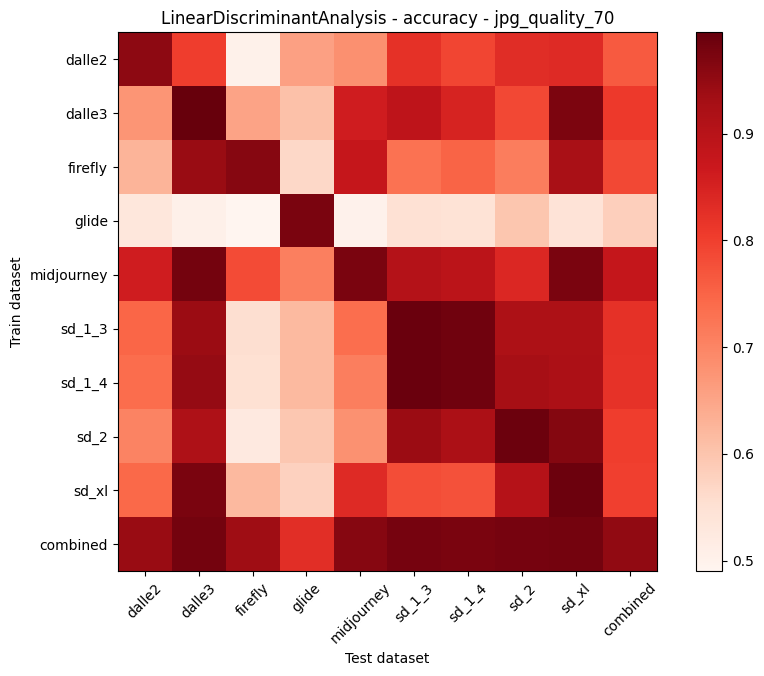

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9550  0.8025   0.5025  0.6575      0.6825  0.8225  0.7900   
dalle3         0.6750  0.9950   0.6525  0.6050      0.8600  0.8900  0.8475   
firefly        0.6275  0.9425   0.9625  0.5650      0.8775  0.7300  0.7500   
glide          0.5325  0.5050   0.4900  0.9750      0.5000  0.5475  0.5450   
midjourney     0.8600  0.9800   0.7825  0.7075      0.9750  0.9050  0.8925   
sd_1_3         0.7475  0.9400   0.5550  0.6175      0.7350  0.9900  0.9850   
sd_1_4         0.7375  0.9475   0.5500  0.6175      0.7100  0.9900  0.9850   
sd_2           0.7025  0.9150   0.5250  0.5950      0.6800  0.9400  0.9200   
sd_xl          0.7425  0.9750   0.6200  0.5775      0.8350  0.7800  0.7750   
combined       0.9425  0.9800   0.9375  0.8275      0.9625  0.9775  0.9750   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.8300  0.8350  0.764167  
dalle3         0.7875  0.9725  0.809444  
firefly        0.7125  0.9225  0.787778  
glide          0.5975  0.5425  0.581667  
midjourney     0.8400  0.9750  0.879722  
sd_1_3         0.9175  0.9175  0.822778  
sd_1_4         0.9275  0.9200  0.820556  
sd_2           0.9875  0.9650  0.803333  
sd_xl          0.9025  0.9875  0.799444  
combined       0.9775  0.9800  0.951111

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9550  0.8025   0.5025  0.6575      0.6825  0.8225  0.7900   
dalle3         0.6750  0.9950   0.6525  0.6050      0.8600  0.8900  0.8475   
firefly        0.6275  0.9425   0.9625  0.5650      0.8775  0.7300  0.7500   
glide          0.5325  0.5050   0.4900  0.9750      0.5000  0.5475  0.5450   
midjourney     0.8600  0.9800   0.7825  0.7075      0.9750  0.9050  0.8925   
sd_1_3         0.7475  0.9400   0.5550  0.6175      0.7350  0.9900  0.9850   
sd_1_4         0.7375  0.9475   0.5500  0.6175      0.7100  0.9900  0.9850   
sd_2           0.7025  0.9150   0.5250  0.5950      0.6800  0.9400  0.9200   
sd_xl          0.7425  0.9750   0.6200  0.5775      0.8350  0.7800  0.7750   
combined       0.9425  0.9800   0.9375  0.8275      0.9625  0.9775  0.9750   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.8300  0.8350  0.764167  
dalle3         0.7875  0.9725  0.809444  
firefly        0.7125  0.9225  0.787778  
glide          0.5975  0.5425  0.581667  
midjourney     0.8400  0.9750  0.879722  
sd_1_3         0.9175  0.9175  0.822778  
sd_1_4         0.9275  0.9200  0.820556  
sd_2           0.9875  0.9650  0.803333  
sd_xl          0.9025  0.9875  0.799444  
combined       0.9775  0.9800  0.951111

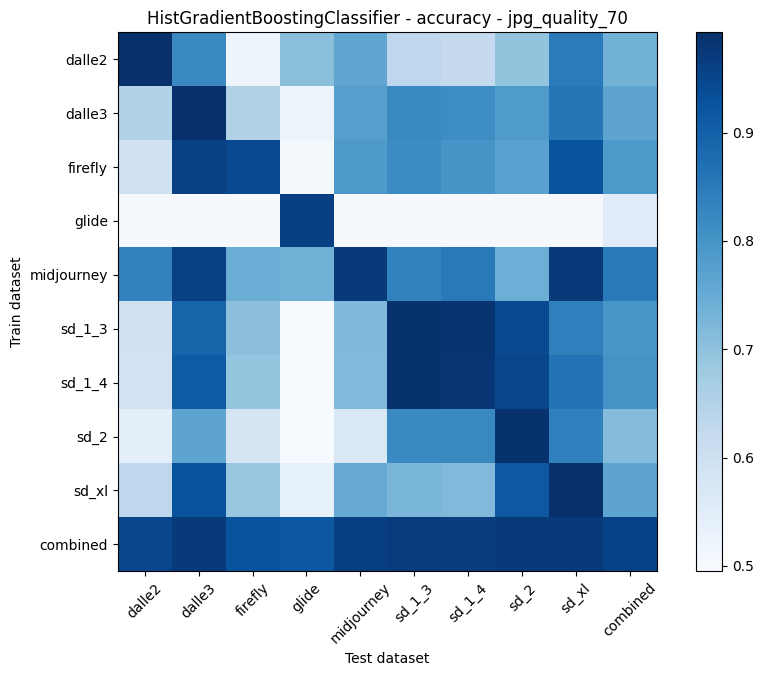

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9925  0.8200   0.5200  0.7050      0.7600  0.6325  0.6200   
dalle3         0.6500  0.9925   0.6500  0.5225      0.7750  0.8200  0.8150   
firefly        0.5925  0.9600   0.9425  0.5050      0.7875  0.8175  0.7975   
glide          0.5000  0.5000   0.5000  0.9625      0.5000  0.5000  0.5000   
midjourney     0.8350  0.9600   0.7450  0.7350      0.9725  0.8350  0.8525   
sd_1_3         0.5925  0.8925   0.7025  0.4975      0.7200  0.9875  0.9825   
sd_1_4         0.5900  0.9100   0.6925  0.4950      0.7175  0.9875  0.9800   
sd_2           0.5400  0.7650   0.5775  0.4975      0.5650  0.8200  0.8225   
sd_xl          0.6325  0.9250   0.6875  0.5375      0.7500  0.7250  0.7175   
combined       0.9475  0.9725   0.9250  0.9175      0.9625  0.9700  0.9675   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.6950  0.8475  0.732500  
dalle3         0.7850  0.8600  0.763333  
firefly        0.7700  0.9250  0.788611  
glide          0.5000  0.5000  0.551389  
midjourney     0.7425  0.9725  0.850000  
sd_1_3         0.9425  0.8400  0.795278  
sd_1_4         0.9500  0.8625  0.798333  
sd_2           0.9875  0.8375  0.712500  
sd_xl          0.9150  0.9925  0.764722  
combined       0.9725  0.9725  0.956389

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9925  0.8200   0.5200  0.7050      0.7600  0.6325  0.6200   
dalle3         0.6500  0.9925   0.6500  0.5225      0.7750  0.8200  0.8150   
firefly        0.5925  0.9600   0.9425  0.5050      0.7875  0.8175  0.7975   
glide          0.5000  0.5000   0.5000  0.9625      0.5000  0.5000  0.5000   
midjourney     0.8350  0.9600   0.7450  0.7350      0.9725  0.8350  0.8525   
sd_1_3         0.5925  0.8925   0.7025  0.4975      0.7200  0.9875  0.9825   
sd_1_4         0.5900  0.9100   0.6925  0.4950      0.7175  0.9875  0.9800   
sd_2           0.5400  0.7650   0.5775  0.4975      0.5650  0.8200  0.8225   
sd_xl          0.6325  0.9250   0.6875  0.5375      0.7500  0.7250  0.7175   
combined       0.9475  0.9725   0.9250  0.9175      0.9625  0.9700  0.9675   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.6950  0.8475  0.732500  
dalle3         0.7850  0.8600  0.763333  
firefly        0.7700  0.9250  0.788611  
glide          0.5000  0.5000  0.551389  
midjourney     0.7425  0.9725  0.850000  
sd_1_3         0.9425  0.8400  0.795278  
sd_1_4         0.9500  0.8625  0.798333  
sd_2           0.9875  0.8375  0.712500  
sd_xl          0.9150  0.9925  0.764722  
combined       0.9725  0.9725  0.956389

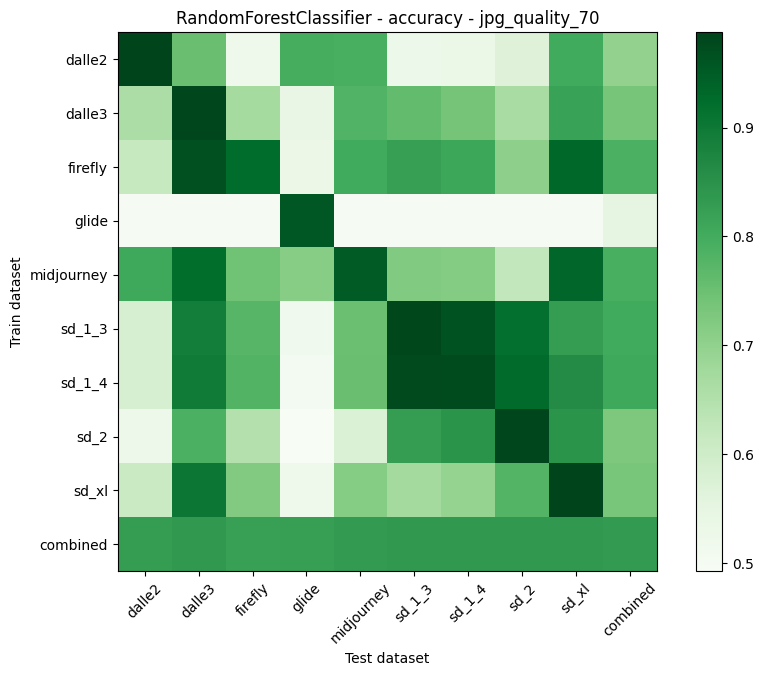

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9875  0.7525   0.5225  0.7950      0.7925  0.5275  0.5350   
dalle3         0.6600  0.9825   0.6700  0.5375      0.7825  0.7600  0.7375   
firefly        0.6150  0.9675   0.9250  0.5300      0.8000  0.8250  0.8100   
glide          0.5000  0.5000   0.5000  0.9575      0.5000  0.5000  0.5000   
midjourney     0.8050  0.9225   0.7450  0.7125      0.9525  0.7225  0.7175   
sd_1_3         0.5850  0.8900   0.7750  0.5150      0.7500  0.9800  0.9625   
sd_1_4         0.5825  0.8950   0.7800  0.5050      0.7525  0.9775  0.9750   
sd_2           0.5250  0.7900   0.6475  0.4925      0.5750  0.8275  0.8450   
sd_xl          0.6100  0.9025   0.7200  0.5225      0.7150  0.6725  0.6950   
combined       0.8275  0.8350   0.8225  0.8250      0.8325  0.8350  0.8350   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.5675  0.8000  0.697778  
dalle3         0.6650  0.8175  0.734722  
firefly        0.7050  0.9300  0.789722  
glide          0.5000  0.5000  0.550833  
midjourney     0.6225  0.9350  0.792778  
sd_1_3         0.9175  0.8275  0.800278  
sd_1_4         0.9275  0.8625  0.806389  
sd_2           0.9825  0.8450  0.725556  
sd_xl          0.7775  0.9875  0.733611  
combined       0.8350  0.8350  0.831389

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9875  0.7525   0.5225  0.7950      0.7925  0.5275  0.5350   
dalle3         0.6600  0.9825   0.6700  0.5375      0.7825  0.7600  0.7375   
firefly        0.6150  0.9675   0.9250  0.5300      0.8000  0.8250  0.8100   
glide          0.5000  0.5000   0.5000  0.9575      0.5000  0.5000  0.5000   
midjourney     0.8050  0.9225   0.7450  0.7125      0.9525  0.7225  0.7175   
sd_1_3         0.5850  0.8900   0.7750  0.5150      0.7500  0.9800  0.9625   
sd_1_4         0.5825  0.8950   0.7800  0.5050      0.7525  0.9775  0.9750   
sd_2           0.5250  0.7900   0.6475  0.4925      0.5750  0.8275  0.8450   
sd_xl          0.6100  0.9025   0.7200  0.5225      0.7150  0.6725  0.6950   
combined       0.8275  0.8350   0.8225  0.8250      0.8325  0.8350  0.8350   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.5675  0.8000  0.697778  
dalle3         0.6650  0.8175  0.734722  
firefly        0.7050  0.9300  0.789722  
glide          0.5000  0.5000  0.550833  
midjourney     0.6225  0.9350  0.792778  
sd_1_3         0.9175  0.8275  0.800278  
sd_1_4         0.9275  0.8625  0.806389  
sd_2           0.9825  0.8450  0.725556  
sd_xl          0.7775  0.9875  0.733611  
combined       0.8350  0.8350  0.831389

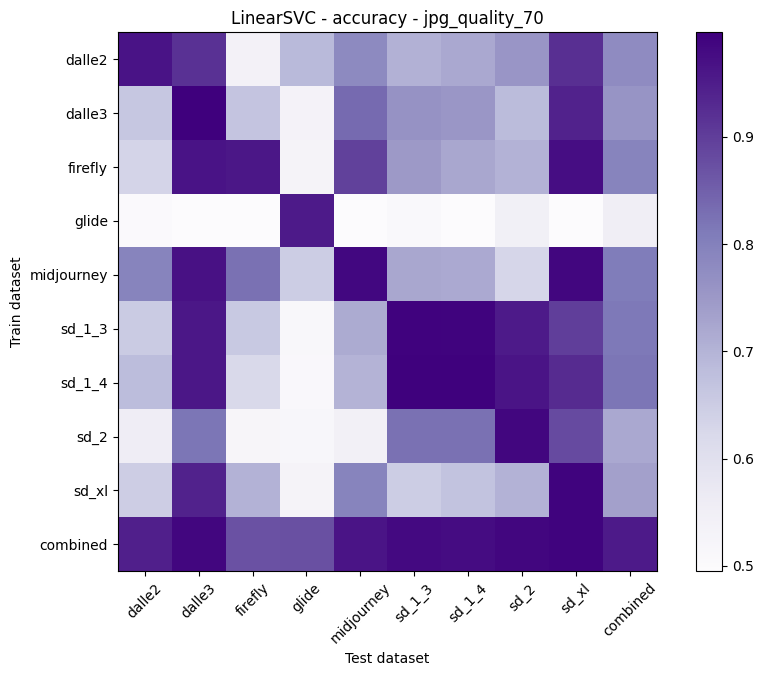

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9650  0.9175   0.5400  0.6875      0.7800  0.7050  0.7200   
dalle3         0.6600  0.9975   0.6675  0.5325      0.8350  0.7625  0.7525   
firefly        0.6325  0.9650   0.9600  0.5275      0.8950  0.7475  0.7225   
glide          0.5025  0.4950   0.4950  0.9525      0.4950  0.5075  0.4950   
midjourney     0.7925  0.9700   0.8250  0.6500      0.9850  0.7225  0.7175   
sd_1_3         0.6525  0.9600   0.6575  0.5125      0.7150  0.9925  0.9900   
sd_1_4         0.6825  0.9600   0.6225  0.5100      0.7000  0.9950  0.9950   
sd_2           0.5575  0.8175   0.5200  0.5175      0.5425  0.8250  0.8250   
sd_xl          0.6475  0.9425   0.7025  0.5300      0.7925  0.6500  0.6700   
combined       0.9450  0.9875   0.8700  0.8725      0.9625  0.9800  0.9775   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.7550  0.9225  0.776944  
dalle3         0.6850  0.9425  0.759444  
firefly        0.7025  0.9750  0.791944  
glide          0.5450  0.4950  0.553611  
midjourney     0.6300  0.9875  0.808889  
sd_1_3         0.9525  0.8975  0.814444  
sd_1_4         0.9625  0.9275  0.817222  
sd_2           0.9875  0.8800  0.719167  
sd_xl          0.7025  0.9900  0.736389  
combined       0.9875  0.9900  0.952500

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9650  0.9175   0.5400  0.6875      0.7800  0.7050  0.7200   
dalle3         0.6600  0.9975   0.6675  0.5325      0.8350  0.7625  0.7525   
firefly        0.6325  0.9650   0.9600  0.5275      0.8950  0.7475  0.7225   
glide          0.5025  0.4950   0.4950  0.9525      0.4950  0.5075  0.4950   
midjourney     0.7925  0.9700   0.8250  0.6500      0.9850  0.7225  0.7175   
sd_1_3         0.6525  0.9600   0.6575  0.5125      0.7150  0.9925  0.9900   
sd_1_4         0.6825  0.9600   0.6225  0.5100      0.7000  0.9950  0.9950   
sd_2           0.5575  0.8175   0.5200  0.5175      0.5425  0.8250  0.8250   
sd_xl          0.6475  0.9425   0.7025  0.5300      0.7925  0.6500  0.6700   
combined       0.9450  0.9875   0.8700  0.8725      0.9625  0.9800  0.9775   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.7550  0.9225  0.776944  
dalle3         0.6850  0.9425  0.759444  
firefly        0.7025  0.9750  0.791944  
glide          0.5450  0.4950  0.553611  
midjourney     0.6300  0.9875  0.808889  
sd_1_3         0.9525  0.8975  0.814444  
sd_1_4         0.9625  0.9275  0.817222  
sd_2           0.9875  0.8800  0.719167  
sd_xl          0.7025  0.9900  0.736389  
combined       0.9875  0.9900  0.952500









 ################ Evaluating models trained on standardAugmented and tested on jpg_quality_90. ################


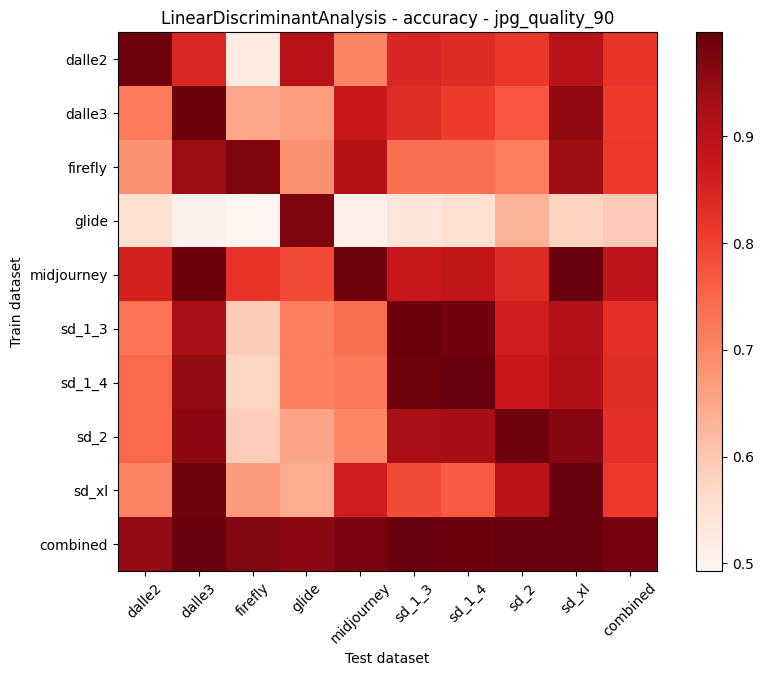

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9875  0.8425   0.5200  0.9025      0.7025  0.8450  0.8350   
dalle3         0.7175  0.9900   0.6500  0.6650      0.8725  0.8325  0.8075   
firefly        0.6800  0.9425   0.9725  0.6850      0.9050  0.7350  0.7350   
glide          0.5550  0.5025   0.4925  0.9725      0.5100  0.5400  0.5525   
midjourney     0.8550  0.9900   0.8200  0.7850      0.9875  0.8750  0.8850   
sd_1_3         0.7275  0.9250   0.5900  0.7125      0.7375  0.9900  0.9850   
sd_1_4         0.7450  0.9500   0.5750  0.7125      0.7225  0.9875  0.9950   
sd_2           0.7450  0.9575   0.5875  0.6525      0.7000  0.9250  0.9275   
sd_xl          0.7025  0.9875   0.6700  0.6400      0.8600  0.7875  0.7650   
combined       0.9500  0.9950   0.9700  0.9575      0.9775  0.9925  0.9900   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.8150  0.9025  0.816944  
dalle3         0.7725  0.9525  0.806667  
firefly        0.7150  0.9400  0.812222  
glide          0.6325  0.5775  0.592778  
midjourney     0.8375  0.9925  0.891944  
sd_1_3         0.8625  0.9125  0.826944  
sd_1_4         0.8725  0.9150  0.830556  
sd_2           0.9875  0.9650  0.827500  
sd_xl          0.9000  0.9925  0.811667  
combined       0.9975  0.9975  0.980833

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9875  0.8425   0.5200  0.9025      0.7025  0.8450  0.8350   
dalle3         0.7175  0.9900   0.6500  0.6650      0.8725  0.8325  0.8075   
firefly        0.6800  0.9425   0.9725  0.6850      0.9050  0.7350  0.7350   
glide          0.5550  0.5025   0.4925  0.9725      0.5100  0.5400  0.5525   
midjourney     0.8550  0.9900   0.8200  0.7850      0.9875  0.8750  0.8850   
sd_1_3         0.7275  0.9250   0.5900  0.7125      0.7375  0.9900  0.9850   
sd_1_4         0.7450  0.9500   0.5750  0.7125      0.7225  0.9875  0.9950   
sd_2           0.7450  0.9575   0.5875  0.6525      0.7000  0.9250  0.9275   
sd_xl          0.7025  0.9875   0.6700  0.6400      0.8600  0.7875  0.7650   
combined       0.9500  0.9950   0.9700  0.9575      0.9775  0.9925  0.9900   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.8150  0.9025  0.816944  
dalle3         0.7725  0.9525  0.806667  
firefly        0.7150  0.9400  0.812222  
glide          0.6325  0.5775  0.592778  
midjourney     0.8375  0.9925  0.891944  
sd_1_3         0.8625  0.9125  0.826944  
sd_1_4         0.8725  0.9150  0.830556  
sd_2           0.9875  0.9650  0.827500  
sd_xl          0.9000  0.9925  0.811667  
combined       0.9975  0.9975  0.980833

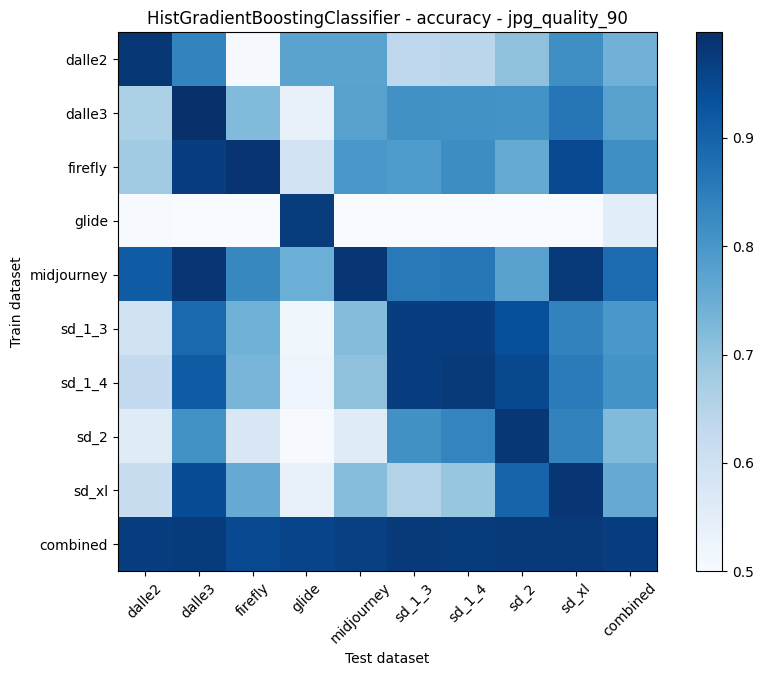

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9825  0.8375   0.5050  0.7725      0.7725  0.6375  0.6400   
dalle3         0.6650  0.9975   0.7200  0.5350      0.7775  0.8125  0.8100   
firefly        0.6825  0.9700   0.9875  0.5900      0.7975  0.7900  0.8200   
glide          0.5025  0.5000   0.5000  0.9725      0.5000  0.5000  0.5000   
midjourney     0.9125  0.9850   0.8300  0.7475      0.9850  0.8575  0.8600   
sd_1_3         0.5950  0.8900   0.7425  0.5175      0.7175  0.9700  0.9700   
sd_1_4         0.6275  0.9125   0.7325  0.5250      0.7050  0.9700  0.9775   
sd_2           0.5600  0.8100   0.5750  0.5025      0.5600  0.8125  0.8350   
sd_xl          0.6200  0.9425   0.7550  0.5350      0.7150  0.6550  0.6950   
combined       0.9700  0.9750   0.9475  0.9575      0.9650  0.9775  0.9750   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.7050  0.8150  0.740833  
dalle3         0.8075  0.8650  0.776667  
firefly        0.7575  0.9475  0.815833  
glide          0.5000  0.5000  0.552778  
midjourney     0.7750  0.9775  0.881111  
sd_1_3         0.9375  0.8400  0.797778  
sd_1_4         0.9500  0.8525  0.805833  
sd_2           0.9825  0.8400  0.719722  
sd_xl          0.8975  0.9850  0.755556  
combined       0.9775  0.9775  0.969167

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9825  0.8375   0.5050  0.7725      0.7725  0.6375  0.6400   
dalle3         0.6650  0.9975   0.7200  0.5350      0.7775  0.8125  0.8100   
firefly        0.6825  0.9700   0.9875  0.5900      0.7975  0.7900  0.8200   
glide          0.5025  0.5000   0.5000  0.9725      0.5000  0.5000  0.5000   
midjourney     0.9125  0.9850   0.8300  0.7475      0.9850  0.8575  0.8600   
sd_1_3         0.5950  0.8900   0.7425  0.5175      0.7175  0.9700  0.9700   
sd_1_4         0.6275  0.9125   0.7325  0.5250      0.7050  0.9700  0.9775   
sd_2           0.5600  0.8100   0.5750  0.5025      0.5600  0.8125  0.8350   
sd_xl          0.6200  0.9425   0.7550  0.5350      0.7150  0.6550  0.6950   
combined       0.9700  0.9750   0.9475  0.9575      0.9650  0.9775  0.9750   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.7050  0.8150  0.740833  
dalle3         0.8075  0.8650  0.776667  
firefly        0.7575  0.9475  0.815833  
glide          0.5000  0.5000  0.552778  
midjourney     0.7750  0.9775  0.881111  
sd_1_3         0.9375  0.8400  0.797778  
sd_1_4         0.9500  0.8525  0.805833  
sd_2           0.9825  0.8400  0.719722  
sd_xl          0.8975  0.9850  0.755556  
combined       0.9775  0.9775  0.969167

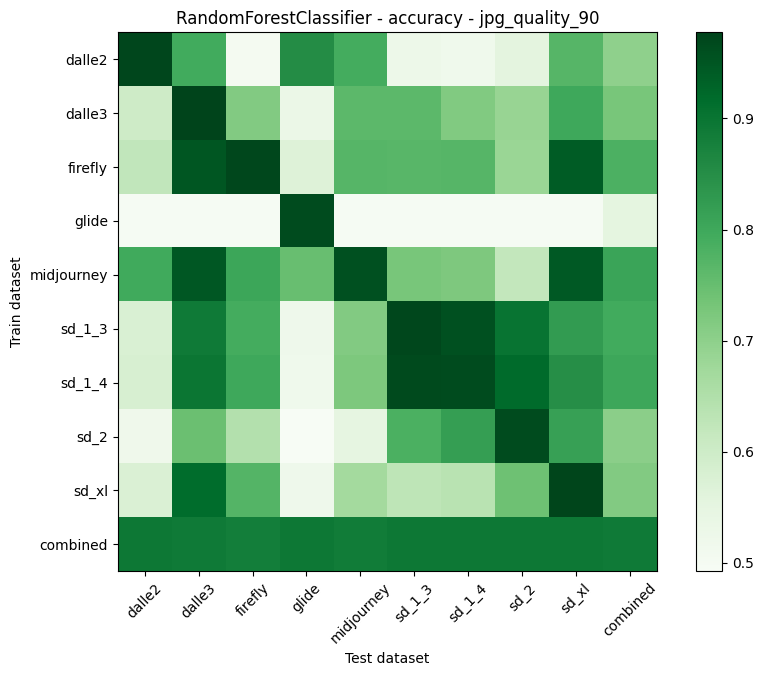

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9725  0.7950   0.5025  0.8525      0.7900  0.5250  0.5175   
dalle3         0.6000  0.9775   0.7150  0.5325      0.7625  0.7625  0.7175   
firefly        0.6225  0.9500   0.9700  0.5675      0.7700  0.7675  0.7700   
glide          0.5000  0.5000   0.5000  0.9650      0.5000  0.5000  0.5000   
midjourney     0.7975  0.9475   0.8050  0.7500      0.9575  0.7275  0.7200   
sd_1_3         0.5775  0.8900   0.7900  0.5225      0.7150  0.9700  0.9575   
sd_1_4         0.5800  0.8975   0.8000  0.5175      0.7225  0.9675  0.9650   
sd_2           0.5200  0.7450   0.6450  0.4925      0.5475  0.7825  0.8200   
sd_xl          0.5750  0.9150   0.7725  0.5225      0.6700  0.6275  0.6350   
combined       0.8925  0.8900   0.8825  0.8925      0.8850  0.8925  0.8925   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.5550  0.7700  0.697778  
dalle3         0.6875  0.8000  0.728333  
firefly        0.6825  0.9400  0.782222  
glide          0.5000  0.5000  0.551667  
midjourney     0.6200  0.9450  0.807778  
sd_1_3         0.9000  0.8250  0.794167  
sd_1_4         0.9175  0.8500  0.801944  
sd_2           0.9650  0.8150  0.703611  
sd_xl          0.7425  0.9750  0.715000  
combined       0.8925  0.8925  0.890278

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9725  0.7950   0.5025  0.8525      0.7900  0.5250  0.5175   
dalle3         0.6000  0.9775   0.7150  0.5325      0.7625  0.7625  0.7175   
firefly        0.6225  0.9500   0.9700  0.5675      0.7700  0.7675  0.7700   
glide          0.5000  0.5000   0.5000  0.9650      0.5000  0.5000  0.5000   
midjourney     0.7975  0.9475   0.8050  0.7500      0.9575  0.7275  0.7200   
sd_1_3         0.5775  0.8900   0.7900  0.5225      0.7150  0.9700  0.9575   
sd_1_4         0.5800  0.8975   0.8000  0.5175      0.7225  0.9675  0.9650   
sd_2           0.5200  0.7450   0.6450  0.4925      0.5475  0.7825  0.8200   
sd_xl          0.5750  0.9150   0.7725  0.5225      0.6700  0.6275  0.6350   
combined       0.8925  0.8900   0.8825  0.8925      0.8850  0.8925  0.8925   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.5550  0.7700  0.697778  
dalle3         0.6875  0.8000  0.728333  
firefly        0.6825  0.9400  0.782222  
glide          0.5000  0.5000  0.551667  
midjourney     0.6200  0.9450  0.807778  
sd_1_3         0.9000  0.8250  0.794167  
sd_1_4         0.9175  0.8500  0.801944  
sd_2           0.9650  0.8150  0.703611  
sd_xl          0.7425  0.9750  0.715000  
combined       0.8925  0.8925  0.890278

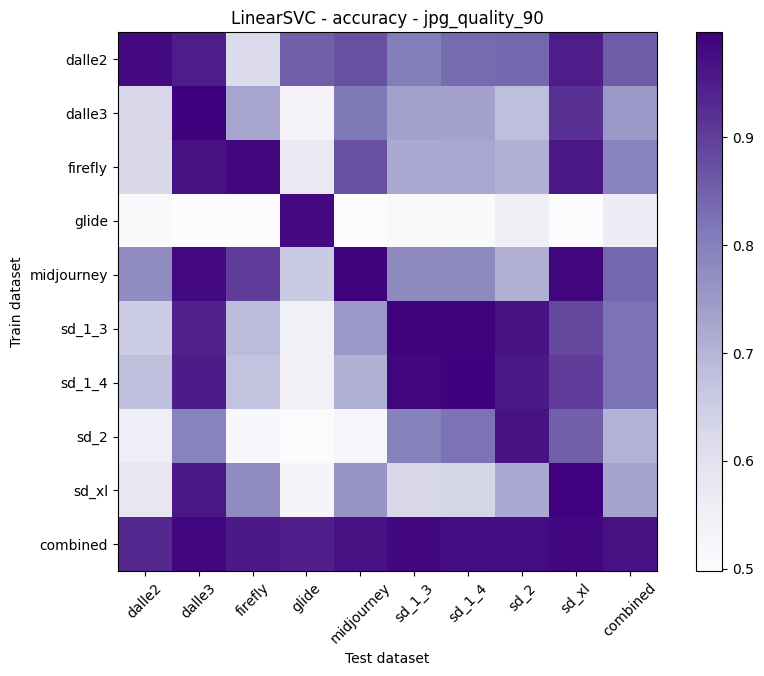

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9800  0.9500   0.6200  0.8525      0.8725  0.8075  0.8350   
dalle3         0.6275  0.9975   0.7275  0.5350      0.8125  0.7375  0.7350   
firefly        0.6225  0.9700   0.9875  0.5725      0.8725  0.7200  0.7225   
glide          0.5075  0.4975   0.4975  0.9800      0.4975  0.5150  0.5100   
midjourney     0.7750  0.9800   0.9025  0.6550      0.9900  0.7800  0.7825   
sd_1_3         0.6500  0.9425   0.6850  0.5475      0.7500  0.9900  0.9900   
sd_1_4         0.6775  0.9525   0.6725  0.5450      0.7100  0.9875  0.9950   
sd_2           0.5575  0.7925   0.5200  0.5025      0.5225  0.7975  0.8225   
sd_xl          0.5825  0.9600   0.7775  0.5250      0.7600  0.6275  0.6325   
combined       0.9325  0.9850   0.9550  0.9450      0.9700  0.9825  0.9750   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.8375  0.9500  0.856111  
dalle3         0.6800  0.9200  0.752500  
firefly        0.7075  0.9600  0.792778  
glide          0.5550  0.4975  0.561944  
midjourney     0.7075  0.9875  0.840000  
sd_1_3         0.9675  0.8825  0.822778  
sd_1_4         0.9550  0.9025  0.821944  
sd_2           0.9675  0.8525  0.703889  
sd_xl          0.7200  0.9925  0.730833  
combined       0.9775  0.9850  0.967500

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9800  0.9500   0.6200  0.8525      0.8725  0.8075  0.8350   
dalle3         0.6275  0.9975   0.7275  0.5350      0.8125  0.7375  0.7350   
firefly        0.6225  0.9700   0.9875  0.5725      0.8725  0.7200  0.7225   
glide          0.5075  0.4975   0.4975  0.9800      0.4975  0.5150  0.5100   
midjourney     0.7750  0.9800   0.9025  0.6550      0.9900  0.7800  0.7825   
sd_1_3         0.6500  0.9425   0.6850  0.5475      0.7500  0.9900  0.9900   
sd_1_4         0.6775  0.9525   0.6725  0.5450      0.7100  0.9875  0.9950   
sd_2           0.5575  0.7925   0.5200  0.5025      0.5225  0.7975  0.8225   
sd_xl          0.5825  0.9600   0.7775  0.5250      0.7600  0.6275  0.6325   
combined       0.9325  0.9850   0.9550  0.9450      0.9700  0.9825  0.9750   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.8375  0.9500  0.856111  
dalle3         0.6800  0.9200  0.752500  
firefly        0.7075  0.9600  0.792778  
glide          0.5550  0.4975  0.561944  
midjourney     0.7075  0.9875  0.840000  
sd_1_3         0.9675  0.8825  0.822778  
sd_1_4         0.9550  0.9025  0.821944  
sd_2           0.9675  0.8525  0.703889  
sd_xl          0.7200  0.9925  0.730833  
combined       0.9775  0.9850  0.967500









 ################ Evaluating models trained on standardAugmented and tested on jpg_quality_80. ################


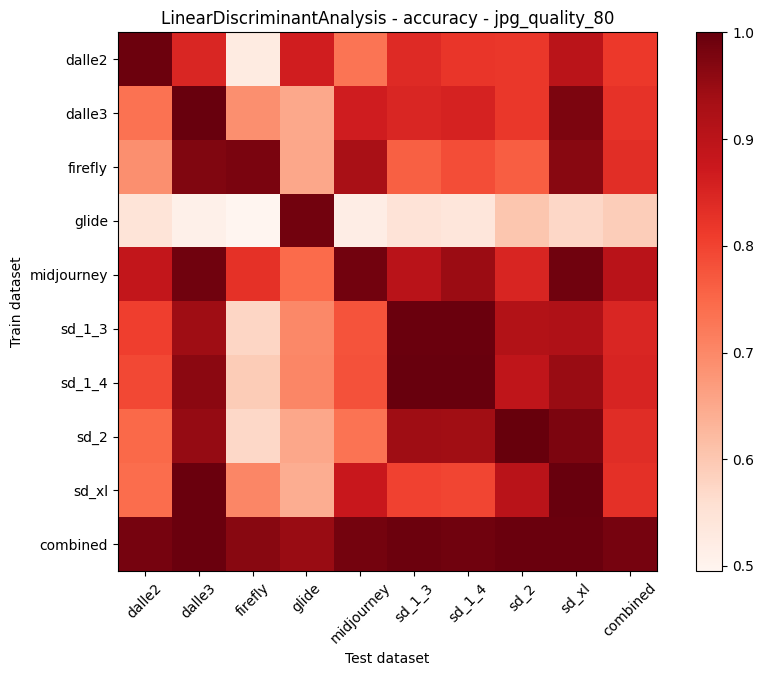

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9925  0.8475   0.5250  0.8625      0.7300  0.8400  0.8200   
dalle3         0.7350  0.9975   0.6900  0.6500      0.8650  0.8475  0.8550   
firefly        0.6900  0.9725   0.9800  0.6525      0.9275  0.7600  0.7850   
glide          0.5450  0.5100   0.4950  0.9875      0.5175  0.5475  0.5400   
midjourney     0.8875  0.9900   0.8275  0.7450      0.9875  0.9025  0.9450   
sd_1_3         0.8050  0.9425   0.5750  0.7000      0.7775  0.9950  0.9950   
sd_1_4         0.7925  0.9625   0.5925  0.7025      0.7800  0.9975  0.9975   
sd_2           0.7475  0.9525   0.5700  0.6525      0.7325  0.9425  0.9400   
sd_xl          0.7425  0.9950   0.7025  0.6425      0.8775  0.8025  0.7950   
combined       0.9825  0.9950   0.9650  0.9475      0.9850  0.9925  0.9900   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.8175  0.9000  0.815000  
dalle3         0.8175  0.9775  0.826111  
firefly        0.7625  0.9650  0.832778  
glide          0.6025  0.5725  0.590833  
midjourney     0.8500  0.9900  0.902778  
sd_1_3         0.9150  0.9175  0.846944  
sd_1_4         0.8925  0.9475  0.851667  
sd_2           1.0000  0.9775  0.835000  
sd_xl          0.9025  0.9975  0.828611  
combined       0.9950  0.9950  0.983056

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9925  0.8475   0.5250  0.8625      0.7300  0.8400  0.8200   
dalle3         0.7350  0.9975   0.6900  0.6500      0.8650  0.8475  0.8550   
firefly        0.6900  0.9725   0.9800  0.6525      0.9275  0.7600  0.7850   
glide          0.5450  0.5100   0.4950  0.9875      0.5175  0.5475  0.5400   
midjourney     0.8875  0.9900   0.8275  0.7450      0.9875  0.9025  0.9450   
sd_1_3         0.8050  0.9425   0.5750  0.7000      0.7775  0.9950  0.9950   
sd_1_4         0.7925  0.9625   0.5925  0.7025      0.7800  0.9975  0.9975   
sd_2           0.7475  0.9525   0.5700  0.6525      0.7325  0.9425  0.9400   
sd_xl          0.7425  0.9950   0.7025  0.6425      0.8775  0.8025  0.7950   
combined       0.9825  0.9950   0.9650  0.9475      0.9850  0.9925  0.9900   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.8175  0.9000  0.815000  
dalle3         0.8175  0.9775  0.826111  
firefly        0.7625  0.9650  0.832778  
glide          0.6025  0.5725  0.590833  
midjourney     0.8500  0.9900  0.902778  
sd_1_3         0.9150  0.9175  0.846944  
sd_1_4         0.8925  0.9475  0.851667  
sd_2           1.0000  0.9775  0.835000  
sd_xl          0.9025  0.9975  0.828611  
combined       0.9950  0.9950  0.983056

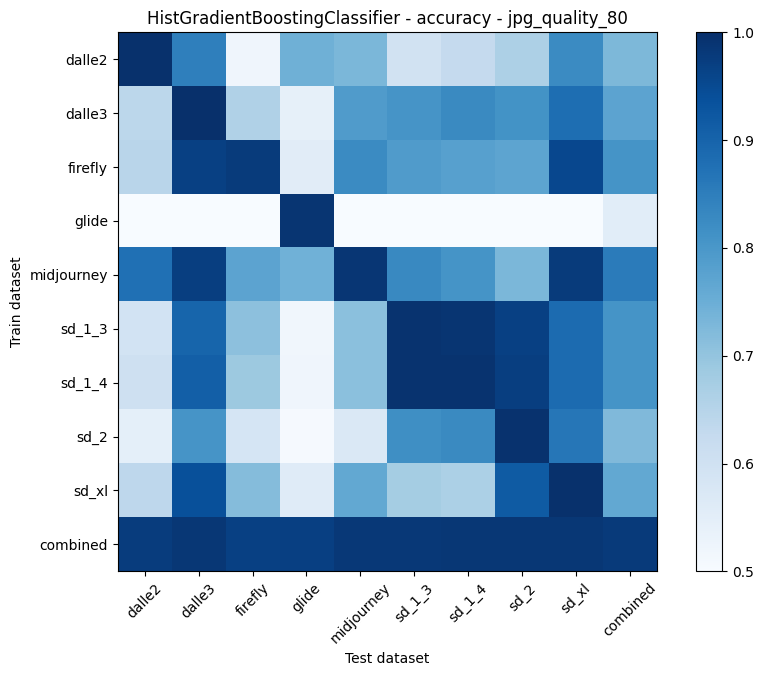

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9975  0.8475   0.5200  0.7450      0.7300  0.5950  0.6250   
dalle3         0.6400  1.0000   0.6600  0.5425      0.7900  0.8050  0.8275   
firefly        0.6450  0.9675   0.9775  0.5550      0.8250  0.7900  0.7800   
glide          0.5000  0.5000   0.5000  0.9900      0.5000  0.5000  0.5000   
midjourney     0.8750  0.9725   0.7725  0.7425      0.9875  0.8300  0.8075   
sd_1_3         0.5925  0.8975   0.7075  0.5175      0.7100  0.9925  0.9900   
sd_1_4         0.6025  0.9100   0.6875  0.5200      0.7100  0.9925  0.9925   
sd_2           0.5450  0.8050   0.5850  0.5050      0.5725  0.8175  0.8275   
sd_xl          0.6375  0.9375   0.7175  0.5600      0.7625  0.6775  0.6650   
combined       0.9750  0.9850   0.9675  0.9700      0.9825  0.9825  0.9850   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.6625  0.8250  0.727500  
dalle3         0.8100  0.8800  0.772778  
firefly        0.7700  0.9550  0.807222  
glide          0.5000  0.5000  0.554444  
midjourney     0.7300  0.9775  0.855000  
sd_1_3         0.9675  0.8850  0.806667  
sd_1_4         0.9725  0.8850  0.808056  
sd_2           0.9950  0.8650  0.724167  
sd_xl          0.9175  0.9975  0.763611  
combined       0.9850  0.9850  0.979722

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9975  0.8475   0.5200  0.7450      0.7300  0.5950  0.6250   
dalle3         0.6400  1.0000   0.6600  0.5425      0.7900  0.8050  0.8275   
firefly        0.6450  0.9675   0.9775  0.5550      0.8250  0.7900  0.7800   
glide          0.5000  0.5000   0.5000  0.9900      0.5000  0.5000  0.5000   
midjourney     0.8750  0.9725   0.7725  0.7425      0.9875  0.8300  0.8075   
sd_1_3         0.5925  0.8975   0.7075  0.5175      0.7100  0.9925  0.9900   
sd_1_4         0.6025  0.9100   0.6875  0.5200      0.7100  0.9925  0.9925   
sd_2           0.5450  0.8050   0.5850  0.5050      0.5725  0.8175  0.8275   
sd_xl          0.6375  0.9375   0.7175  0.5600      0.7625  0.6775  0.6650   
combined       0.9750  0.9850   0.9675  0.9700      0.9825  0.9825  0.9850   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.6625  0.8250  0.727500  
dalle3         0.8100  0.8800  0.772778  
firefly        0.7700  0.9550  0.807222  
glide          0.5000  0.5000  0.554444  
midjourney     0.7300  0.9775  0.855000  
sd_1_3         0.9675  0.8850  0.806667  
sd_1_4         0.9725  0.8850  0.808056  
sd_2           0.9950  0.8650  0.724167  
sd_xl          0.9175  0.9975  0.763611  
combined       0.9850  0.9850  0.979722

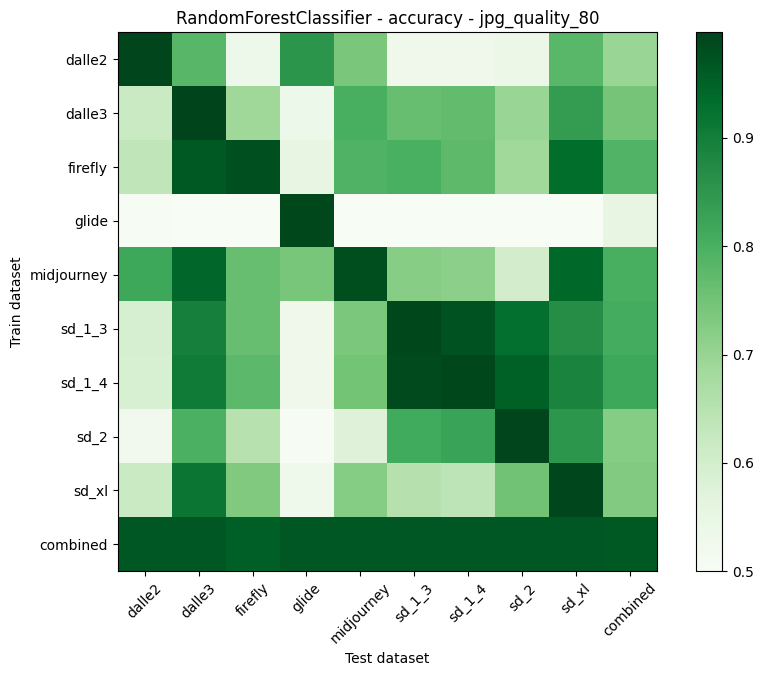

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9950  0.7825   0.5325  0.8525      0.7400  0.5275  0.5275   
dalle3         0.6200  0.9975   0.6875  0.5350      0.8025  0.7625  0.7700   
firefly        0.6375  0.9650   0.9800  0.5550      0.7925  0.8000  0.7750   
glide          0.5025  0.5000   0.5000  0.9900      0.5000  0.5000  0.5000   
midjourney     0.8175  0.9450   0.7625  0.7425      0.9825  0.7200  0.7150   
sd_1_3         0.5900  0.8950   0.7625  0.5275      0.7375  0.9900  0.9725   
sd_1_4         0.5875  0.9050   0.7775  0.5275      0.7475  0.9875  0.9900   
sd_2           0.5200  0.7975   0.6500  0.5025      0.5750  0.8100  0.8250   
sd_xl          0.6175  0.9150   0.7325  0.5300      0.7250  0.6525  0.6400   
combined       0.9675  0.9675   0.9550  0.9675      0.9675  0.9675  0.9675   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.5375  0.7800  0.697222  
dalle3         0.6975  0.8400  0.745833  
firefly        0.6850  0.9325  0.791389  
glide          0.5000  0.5000  0.554722  
midjourney     0.6000  0.9425  0.803056  
sd_1_3         0.9275  0.8675  0.807778  
sd_1_4         0.9525  0.8875  0.818056  
sd_2           0.9950  0.8500  0.725000  
sd_xl          0.7525  0.9925  0.728611  
combined       0.9675  0.9675  0.966111

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9950  0.7825   0.5325  0.8525      0.7400  0.5275  0.5275   
dalle3         0.6200  0.9975   0.6875  0.5350      0.8025  0.7625  0.7700   
firefly        0.6375  0.9650   0.9800  0.5550      0.7925  0.8000  0.7750   
glide          0.5025  0.5000   0.5000  0.9900      0.5000  0.5000  0.5000   
midjourney     0.8175  0.9450   0.7625  0.7425      0.9825  0.7200  0.7150   
sd_1_3         0.5900  0.8950   0.7625  0.5275      0.7375  0.9900  0.9725   
sd_1_4         0.5875  0.9050   0.7775  0.5275      0.7475  0.9875  0.9900   
sd_2           0.5200  0.7975   0.6500  0.5025      0.5750  0.8100  0.8250   
sd_xl          0.6175  0.9150   0.7325  0.5300      0.7250  0.6525  0.6400   
combined       0.9675  0.9675   0.9550  0.9675      0.9675  0.9675  0.9675   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.5375  0.7800  0.697222  
dalle3         0.6975  0.8400  0.745833  
firefly        0.6850  0.9325  0.791389  
glide          0.5000  0.5000  0.554722  
midjourney     0.6000  0.9425  0.803056  
sd_1_3         0.9275  0.8675  0.807778  
sd_1_4         0.9525  0.8875  0.818056  
sd_2           0.9950  0.8500  0.725000  
sd_xl          0.7525  0.9925  0.728611  
combined       0.9675  0.9675  0.966111

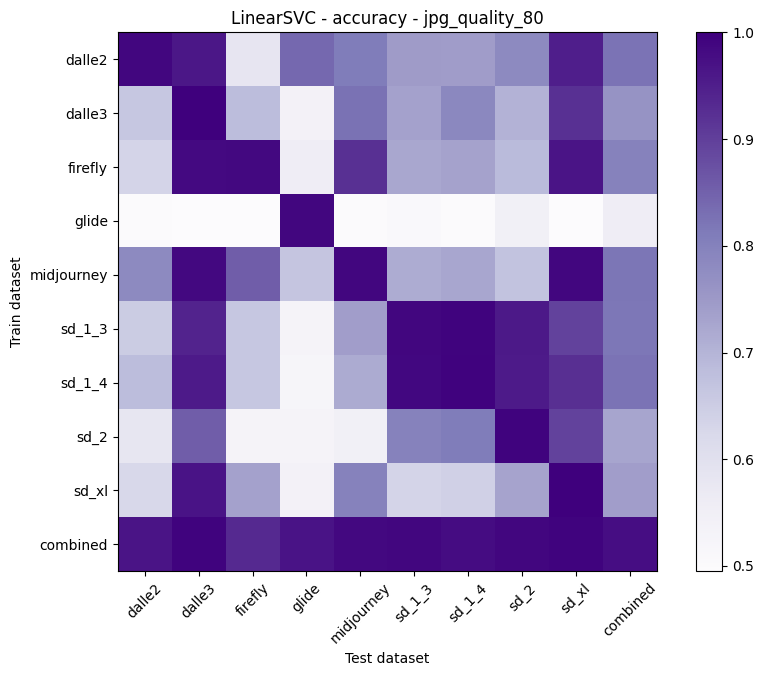

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9900  0.9625   0.5825  0.8400      0.8100  0.7450  0.7425   
dalle3         0.6625  1.0000   0.6825  0.5375      0.8250  0.7350  0.7850   
firefly        0.6350  0.9825   0.9850  0.5550      0.9225  0.7225  0.7325   
glide          0.5000  0.4950   0.4950  0.9900      0.4975  0.5050  0.5000   
midjourney     0.7825  0.9850   0.8550  0.6650      0.9900  0.7150  0.7250   
sd_1_3         0.6525  0.9425   0.6625  0.5275      0.7400  0.9900  0.9925   
sd_1_4         0.6825  0.9550   0.6625  0.5225      0.7175  0.9875  0.9950   
sd_2           0.5800  0.8550   0.5300  0.5275      0.5450  0.7975  0.8100   
sd_xl          0.6250  0.9675   0.7350  0.5375      0.7975  0.6350  0.6425   
combined       0.9650  0.9925   0.9325  0.9675      0.9850  0.9900  0.9800   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.7825  0.9500  0.822778  
dalle3         0.7025  0.9225  0.761389  
firefly        0.6875  0.9650  0.798611  
glide          0.5450  0.4950  0.558056  
midjourney     0.6725  0.9900  0.820000  
sd_1_3         0.9575  0.8950  0.817778  
sd_1_4         0.9550  0.9250  0.822500  
sd_2           0.9925  0.8950  0.725833  
sd_xl          0.7300  1.0000  0.741111  
combined       0.9900  0.9925  0.977222

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9900  0.9625   0.5825  0.8400      0.8100  0.7450  0.7425   
dalle3         0.6625  1.0000   0.6825  0.5375      0.8250  0.7350  0.7850   
firefly        0.6350  0.9825   0.9850  0.5550      0.9225  0.7225  0.7325   
glide          0.5000  0.4950   0.4950  0.9900      0.4975  0.5050  0.5000   
midjourney     0.7825  0.9850   0.8550  0.6650      0.9900  0.7150  0.7250   
sd_1_3         0.6525  0.9425   0.6625  0.5275      0.7400  0.9900  0.9925   
sd_1_4         0.6825  0.9550   0.6625  0.5225      0.7175  0.9875  0.9950   
sd_2           0.5800  0.8550   0.5300  0.5275      0.5450  0.7975  0.8100   
sd_xl          0.6250  0.9675   0.7350  0.5375      0.7975  0.6350  0.6425   
combined       0.9650  0.9925   0.9325  0.9675      0.9850  0.9900  0.9800   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.7825  0.9500  0.822778  
dalle3         0.7025  0.9225  0.761389  
firefly        0.6875  0.9650  0.798611  
glide          0.5450  0.4950  0.558056  
midjourney     0.6725  0.9900  0.820000  
sd_1_3         0.9575  0.8950  0.817778  
sd_1_4         0.9550  0.9250  0.822500  
sd_2           0.9925  0.8950  0.725833  
sd_xl          0.7300  1.0000  0.741111  
combined       0.9900  0.9925  0.977222









 ################ Evaluating models trained on standardAugmented and tested on jpg_quality_95. ################


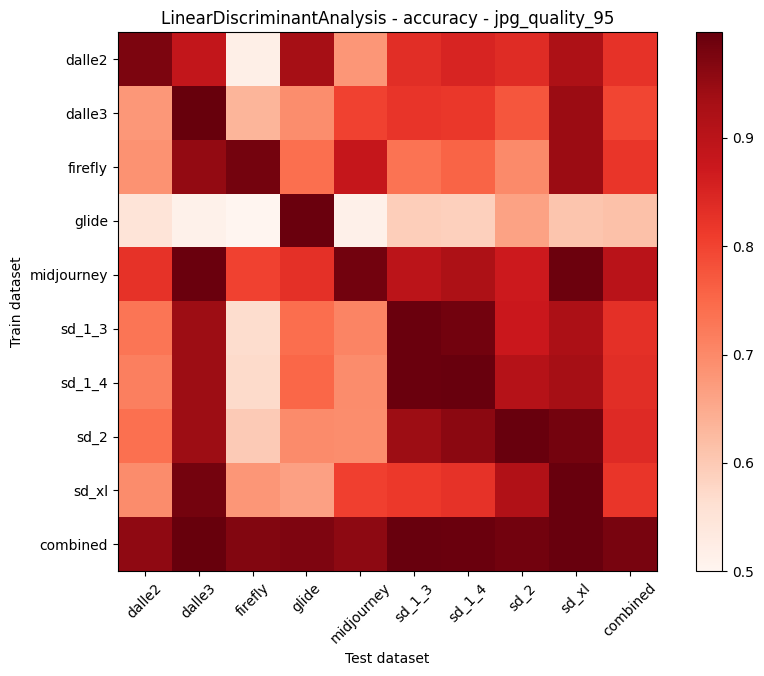

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9750  0.8850   0.5175  0.9325      0.6800  0.8325  0.8500   
dalle3         0.6775  0.9975   0.6325  0.6925      0.8025  0.8225  0.8175   
firefly        0.6850  0.9525   0.9825  0.7400      0.8825  0.7350  0.7550   
glide          0.5500  0.5125   0.5000  0.9925      0.5150  0.5925  0.5875   
midjourney     0.8250  0.9925   0.8025  0.8300      0.9850  0.8975  0.9200   
sd_1_3         0.7300  0.9425   0.5675  0.7425      0.7075  0.9925  0.9850   
sd_1_4         0.7150  0.9425   0.5700  0.7525      0.6950  0.9925  0.9950   
sd_2           0.7375  0.9425   0.5975  0.6975      0.6925  0.9425  0.9600   
sd_xl          0.6950  0.9825   0.6800  0.6650      0.8050  0.8150  0.8250   
combined       0.9550  0.9975   0.9700  0.9725      0.9575  0.9950  0.9925   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.8375  0.9200  0.825556  
dalle3         0.7750  0.9450  0.795833  
firefly        0.7000  0.9450  0.819722  
glide          0.6625  0.6075  0.613333  
midjourney     0.8700  0.9900  0.901389  
sd_1_3         0.8750  0.9225  0.829444  
sd_1_4         0.9075  0.9325  0.833611  
sd_2           0.9950  0.9825  0.838611  
sd_xl          0.9150  0.9950  0.819722  
combined       0.9850  0.9950  0.980000

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9750  0.8850   0.5175  0.9325      0.6800  0.8325  0.8500   
dalle3         0.6775  0.9975   0.6325  0.6925      0.8025  0.8225  0.8175   
firefly        0.6850  0.9525   0.9825  0.7400      0.8825  0.7350  0.7550   
glide          0.5500  0.5125   0.5000  0.9925      0.5150  0.5925  0.5875   
midjourney     0.8250  0.9925   0.8025  0.8300      0.9850  0.8975  0.9200   
sd_1_3         0.7300  0.9425   0.5675  0.7425      0.7075  0.9925  0.9850   
sd_1_4         0.7150  0.9425   0.5700  0.7525      0.6950  0.9925  0.9950   
sd_2           0.7375  0.9425   0.5975  0.6975      0.6925  0.9425  0.9600   
sd_xl          0.6950  0.9825   0.6800  0.6650      0.8050  0.8150  0.8250   
combined       0.9550  0.9975   0.9700  0.9725      0.9575  0.9950  0.9925   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.8375  0.9200  0.825556  
dalle3         0.7750  0.9450  0.795833  
firefly        0.7000  0.9450  0.819722  
glide          0.6625  0.6075  0.613333  
midjourney     0.8700  0.9900  0.901389  
sd_1_3         0.8750  0.9225  0.829444  
sd_1_4         0.9075  0.9325  0.833611  
sd_2           0.9950  0.9825  0.838611  
sd_xl          0.9150  0.9950  0.819722  
combined       0.9850  0.9950  0.980000

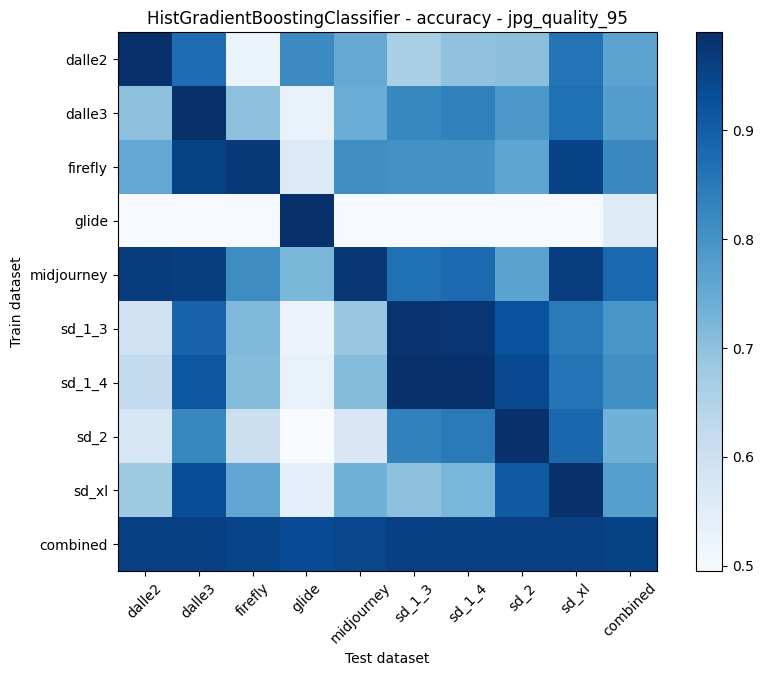

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9900  0.8725   0.5250  0.8175      0.7500  0.6625  0.6975   
dalle3         0.7000  0.9875   0.7000  0.5300      0.7450  0.8250  0.8350   
firefly        0.7550  0.9550   0.9700  0.5625      0.8100  0.8025  0.8025   
glide          0.5000  0.5000   0.5000  0.9900      0.5000  0.5000  0.5000   
midjourney     0.9675  0.9625   0.8125  0.7225      0.9750  0.8675  0.8775   
sd_1_3         0.5950  0.8900   0.7175  0.5225      0.6875  0.9825  0.9775   
sd_1_4         0.6225  0.9150   0.7100  0.5300      0.7100  0.9875  0.9900   
sd_2           0.5750  0.8225   0.6025  0.4950      0.5700  0.8350  0.8475   
sd_xl          0.6800  0.9325   0.7575  0.5400      0.7350  0.7000  0.7250   
combined       0.9600  0.9600   0.9500  0.9375      0.9475  0.9575  0.9575   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.7025  0.8600  0.764167  
dalle3         0.7900  0.8675  0.775556  
firefly        0.7600  0.9525  0.818889  
glide          0.5000  0.5000  0.554444  
midjourney     0.7675  0.9625  0.879444  
sd_1_3         0.9275  0.8475  0.794167  
sd_1_4         0.9425  0.8600  0.807500  
sd_2           0.9875  0.8850  0.735556  
sd_xl          0.9075  0.9875  0.773889  
combined       0.9600  0.9600  0.954444

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9900  0.8725   0.5250  0.8175      0.7500  0.6625  0.6975   
dalle3         0.7000  0.9875   0.7000  0.5300      0.7450  0.8250  0.8350   
firefly        0.7550  0.9550   0.9700  0.5625      0.8100  0.8025  0.8025   
glide          0.5000  0.5000   0.5000  0.9900      0.5000  0.5000  0.5000   
midjourney     0.9675  0.9625   0.8125  0.7225      0.9750  0.8675  0.8775   
sd_1_3         0.5950  0.8900   0.7175  0.5225      0.6875  0.9825  0.9775   
sd_1_4         0.6225  0.9150   0.7100  0.5300      0.7100  0.9875  0.9900   
sd_2           0.5750  0.8225   0.6025  0.4950      0.5700  0.8350  0.8475   
sd_xl          0.6800  0.9325   0.7575  0.5400      0.7350  0.7000  0.7250   
combined       0.9600  0.9600   0.9500  0.9375      0.9475  0.9575  0.9575   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.7025  0.8600  0.764167  
dalle3         0.7900  0.8675  0.775556  
firefly        0.7600  0.9525  0.818889  
glide          0.5000  0.5000  0.554444  
midjourney     0.7675  0.9625  0.879444  
sd_1_3         0.9275  0.8475  0.794167  
sd_1_4         0.9425  0.8600  0.807500  
sd_2           0.9875  0.8850  0.735556  
sd_xl          0.9075  0.9875  0.773889  
combined       0.9600  0.9600  0.954444

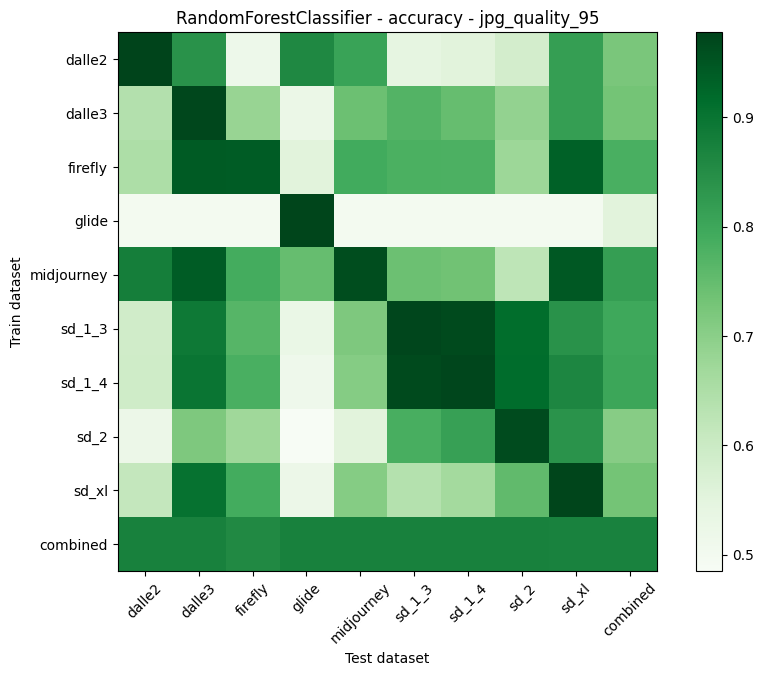

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9775  0.8400   0.5175  0.8600      0.8075  0.5425  0.5525   
dalle3         0.6400  0.9700   0.6825  0.5250      0.7400  0.7700  0.7475   
firefly        0.6500  0.9425   0.9400  0.5525      0.7925  0.7800  0.7775   
glide          0.5000  0.5000   0.5000  0.9750      0.5000  0.5000  0.5000   
midjourney     0.8775  0.9400   0.7875  0.7475      0.9625  0.7400  0.7350   
sd_1_3         0.5900  0.8900   0.7675  0.5275      0.7175  0.9725  0.9675   
sd_1_4         0.5925  0.8975   0.7825  0.5150      0.7075  0.9675  0.9725   
sd_2           0.5225  0.7175   0.6700  0.4850      0.5525  0.7850  0.8125   
sd_xl          0.6125  0.9025   0.7900  0.5225      0.7075  0.6375  0.6650   
combined       0.8725  0.8725   0.8575  0.8725      0.8725  0.8725  0.8725   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.5850  0.8175  0.722222  
dalle3         0.6875  0.8175  0.731111  
firefly        0.6750  0.9325  0.782500  
glide          0.5000  0.5000  0.552778  
midjourney     0.6225  0.9450  0.817500  
sd_1_3         0.9125  0.8400  0.798333  
sd_1_4         0.9150  0.8625  0.801389  
sd_2           0.9650  0.8375  0.705278  
sd_xl          0.7525  0.9750  0.729444  
combined       0.8725  0.8700  0.870556

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9775  0.8400   0.5175  0.8600      0.8075  0.5425  0.5525   
dalle3         0.6400  0.9700   0.6825  0.5250      0.7400  0.7700  0.7475   
firefly        0.6500  0.9425   0.9400  0.5525      0.7925  0.7800  0.7775   
glide          0.5000  0.5000   0.5000  0.9750      0.5000  0.5000  0.5000   
midjourney     0.8775  0.9400   0.7875  0.7475      0.9625  0.7400  0.7350   
sd_1_3         0.5900  0.8900   0.7675  0.5275      0.7175  0.9725  0.9675   
sd_1_4         0.5925  0.8975   0.7825  0.5150      0.7075  0.9675  0.9725   
sd_2           0.5225  0.7175   0.6700  0.4850      0.5525  0.7850  0.8125   
sd_xl          0.6125  0.9025   0.7900  0.5225      0.7075  0.6375  0.6650   
combined       0.8725  0.8725   0.8575  0.8725      0.8725  0.8725  0.8725   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.5850  0.8175  0.722222  
dalle3         0.6875  0.8175  0.731111  
firefly        0.6750  0.9325  0.782500  
glide          0.5000  0.5000  0.552778  
midjourney     0.6225  0.9450  0.817500  
sd_1_3         0.9125  0.8400  0.798333  
sd_1_4         0.9150  0.8625  0.801389  
sd_2           0.9650  0.8375  0.705278  
sd_xl          0.7525  0.9750  0.729444  
combined       0.8725  0.8700  0.870556

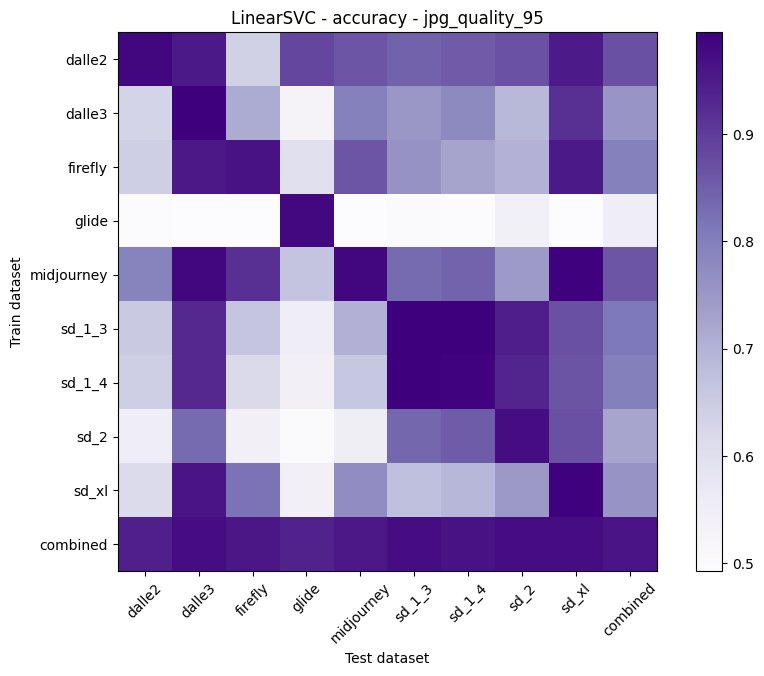

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9850  0.9525   0.6375  0.8850      0.8625  0.8450  0.8550   
dalle3         0.6300  0.9950   0.7125  0.5250      0.7950  0.7500  0.7775   
firefly        0.6425  0.9550   0.9675  0.5975      0.8625  0.7600  0.7250   
glide          0.4975  0.4925   0.4925  0.9800      0.4925  0.5000  0.4950   
midjourney     0.7900  0.9850   0.9200  0.6650      0.9850  0.8325  0.8425   
sd_1_3         0.6525  0.9300   0.6625  0.5525      0.7025  0.9950  0.9950   
sd_1_4         0.6425  0.9300   0.6175  0.5400      0.6575  0.9950  0.9900   
sd_2           0.5525  0.8325   0.5400  0.5000      0.5500  0.8375  0.8525   
sd_xl          0.6150  0.9600   0.8200  0.5400      0.7700  0.6750  0.6900   
combined       0.9425  0.9725   0.9575  0.9400      0.9550  0.9725  0.9650   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.8675  0.9500  0.871111  
dalle3         0.6875  0.9175  0.754444  
firefly        0.7000  0.9525  0.795833  
glide          0.5425  0.4925  0.553889  
midjourney     0.7425  0.9925  0.861667  
sd_1_3         0.9450  0.8700  0.811667  
sd_1_4         0.9350  0.8650  0.796944  
sd_2           0.9725  0.8700  0.723056  
sd_xl          0.7450  0.9925  0.756389  
combined       0.9725  0.9725  0.961111

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9850  0.9525   0.6375  0.8850      0.8625  0.8450  0.8550   
dalle3         0.6300  0.9950   0.7125  0.5250      0.7950  0.7500  0.7775   
firefly        0.6425  0.9550   0.9675  0.5975      0.8625  0.7600  0.7250   
glide          0.4975  0.4925   0.4925  0.9800      0.4925  0.5000  0.4950   
midjourney     0.7900  0.9850   0.9200  0.6650      0.9850  0.8325  0.8425   
sd_1_3         0.6525  0.9300   0.6625  0.5525      0.7025  0.9950  0.9950   
sd_1_4         0.6425  0.9300   0.6175  0.5400      0.6575  0.9950  0.9900   
sd_2           0.5525  0.8325   0.5400  0.5000      0.5500  0.8375  0.8525   
sd_xl          0.6150  0.9600   0.8200  0.5400      0.7700  0.6750  0.6900   
combined       0.9425  0.9725   0.9575  0.9400      0.9550  0.9725  0.9650   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.8675  0.9500  0.871111  
dalle3         0.6875  0.9175  0.754444  
firefly        0.7000  0.9525  0.795833  
glide          0.5425  0.4925  0.553889  
midjourney     0.7425  0.9925  0.861667  
sd_1_3         0.9450  0.8700  0.811667  
sd_1_4         0.9350  0.8650  0.796944  
sd_2           0.9725  0.8700  0.723056  
sd_xl          0.7450  0.9925  0.756389  
combined       0.9725  0.9725  0.961111









 ################ Evaluating models trained on standardAugmented and tested on standard. ################


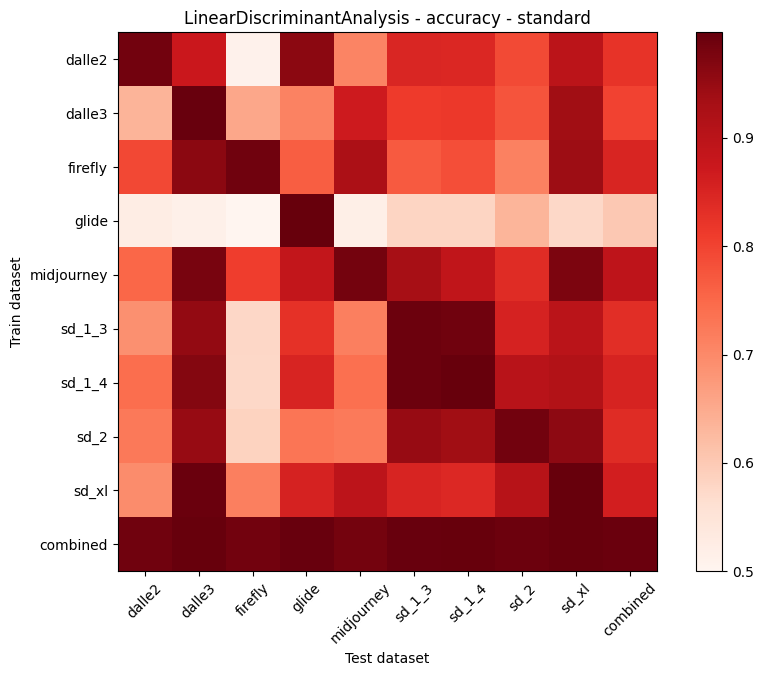

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9850  0.8750   0.5100  0.9600      0.7075  0.8475  0.8450   
dalle3         0.6350  0.9950   0.6550  0.7100      0.8675  0.8125  0.8150   
firefly        0.7925  0.9600   0.9875  0.7625      0.9225  0.7700  0.7850   
glide          0.5250  0.5150   0.5000  0.9975      0.5175  0.5800  0.5800   
midjourney     0.7525  0.9800   0.8075  0.8850      0.9825  0.9300  0.8900   
sd_1_3         0.6900  0.9525   0.5775  0.8275      0.7150  0.9900  0.9875   
sd_1_4         0.7425  0.9675   0.5750  0.8500      0.7375  0.9900  0.9975   
sd_2           0.7250  0.9475   0.5850  0.7300      0.7225  0.9475  0.9375   
sd_xl          0.6950  0.9925   0.7150  0.8550      0.8950  0.8500  0.8425   
combined       0.9875  0.9975   0.9850  0.9950      0.9825  0.9950  0.9975   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.7900  0.8975  0.824167  
dalle3         0.7775  0.9375  0.800556  
firefly        0.7125  0.9425  0.848333  
glide          0.6325  0.5750  0.602500  
midjourney     0.8375  0.9750  0.893333  
sd_1_3         0.8550  0.9000  0.832778  
sd_1_4         0.9025  0.9125  0.852778  
sd_2           0.9850  0.9575  0.837500  
sd_xl          0.9050  0.9975  0.860833  
combined       0.9900  0.9975  0.991944

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9850  0.8750   0.5100  0.9600      0.7075  0.8475  0.8450   
dalle3         0.6350  0.9950   0.6550  0.7100      0.8675  0.8125  0.8150   
firefly        0.7925  0.9600   0.9875  0.7625      0.9225  0.7700  0.7850   
glide          0.5250  0.5150   0.5000  0.9975      0.5175  0.5800  0.5800   
midjourney     0.7525  0.9800   0.8075  0.8850      0.9825  0.9300  0.8900   
sd_1_3         0.6900  0.9525   0.5775  0.8275      0.7150  0.9900  0.9875   
sd_1_4         0.7425  0.9675   0.5750  0.8500      0.7375  0.9900  0.9975   
sd_2           0.7250  0.9475   0.5850  0.7300      0.7225  0.9475  0.9375   
sd_xl          0.6950  0.9925   0.7150  0.8550      0.8950  0.8500  0.8425   
combined       0.9875  0.9975   0.9850  0.9950      0.9825  0.9950  0.9975   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.7900  0.8975  0.824167  
dalle3         0.7775  0.9375  0.800556  
firefly        0.7125  0.9425  0.848333  
glide          0.6325  0.5750  0.602500  
midjourney     0.8375  0.9750  0.893333  
sd_1_3         0.8550  0.9000  0.832778  
sd_1_4         0.9025  0.9125  0.852778  
sd_2           0.9850  0.9575  0.837500  
sd_xl          0.9050  0.9975  0.860833  
combined       0.9900  0.9975  0.991944

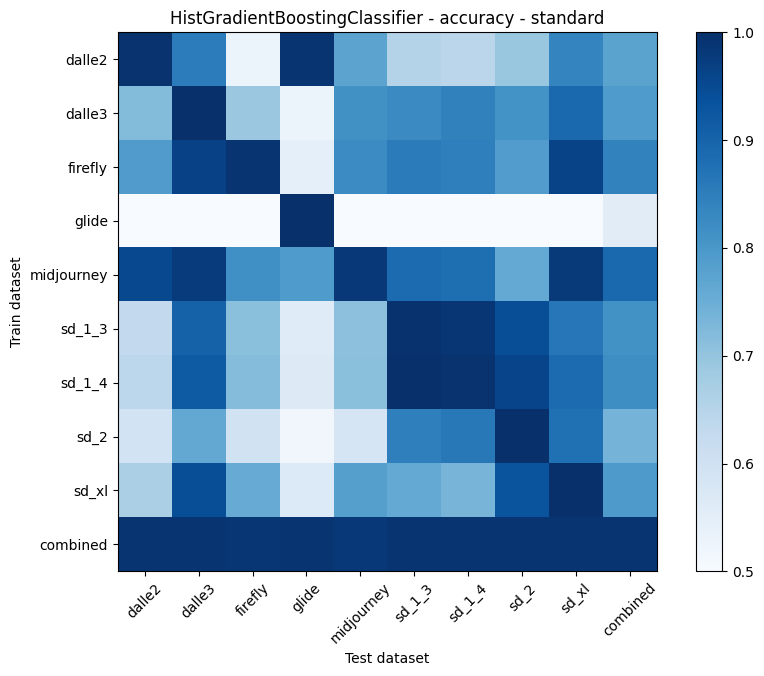

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9925  0.8525   0.5300  0.9900      0.7725  0.6525  0.6425   
dalle3         0.7200  1.0000   0.6900  0.5300      0.8125  0.8250  0.8425   
firefly        0.7900  0.9650   0.9900  0.5450      0.8225  0.8550  0.8475   
glide          0.5000  0.5000   0.5000  1.0000      0.5000  0.5000  0.5000   
midjourney     0.9525  0.9775   0.8150  0.7925      0.9825  0.8850  0.8800   
sd_1_3         0.6300  0.9025   0.7100  0.5600      0.7075  0.9950  0.9875   
sd_1_4         0.6400  0.9175   0.7175  0.5625      0.7100  0.9975  0.9925   
sd_2           0.5925  0.7625   0.5975  0.5175      0.5825  0.8475  0.8600   
sd_xl          0.6675  0.9425   0.7550  0.5675      0.7825  0.7600  0.7350   
combined       0.9900  0.9900   0.9875  0.9900      0.9825  0.9900  0.9900   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.6950  0.8375  0.773889  
dalle3         0.8100  0.8900  0.791111  
firefly        0.7875  0.9625  0.840556  
glide          0.5000  0.5000  0.555556  
midjourney     0.7600  0.9800  0.891667  
sd_1_3         0.9425  0.8625  0.810833  
sd_1_4         0.9600  0.8850  0.820278  
sd_2           0.9975  0.8750  0.736944  
sd_xl          0.9300  0.9975  0.793056  
combined       0.9900  0.9900  0.988889

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9925  0.8525   0.5300  0.9900      0.7725  0.6525  0.6425   
dalle3         0.7200  1.0000   0.6900  0.5300      0.8125  0.8250  0.8425   
firefly        0.7900  0.9650   0.9900  0.5450      0.8225  0.8550  0.8475   
glide          0.5000  0.5000   0.5000  1.0000      0.5000  0.5000  0.5000   
midjourney     0.9525  0.9775   0.8150  0.7925      0.9825  0.8850  0.8800   
sd_1_3         0.6300  0.9025   0.7100  0.5600      0.7075  0.9950  0.9875   
sd_1_4         0.6400  0.9175   0.7175  0.5625      0.7100  0.9975  0.9925   
sd_2           0.5925  0.7625   0.5975  0.5175      0.5825  0.8475  0.8600   
sd_xl          0.6675  0.9425   0.7550  0.5675      0.7825  0.7600  0.7350   
combined       0.9900  0.9900   0.9875  0.9900      0.9825  0.9900  0.9900   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.6950  0.8375  0.773889  
dalle3         0.8100  0.8900  0.791111  
firefly        0.7875  0.9625  0.840556  
glide          0.5000  0.5000  0.555556  
midjourney     0.7600  0.9800  0.891667  
sd_1_3         0.9425  0.8625  0.810833  
sd_1_4         0.9600  0.8850  0.820278  
sd_2           0.9975  0.8750  0.736944  
sd_xl          0.9300  0.9975  0.793056  
combined       0.9900  0.9900  0.988889

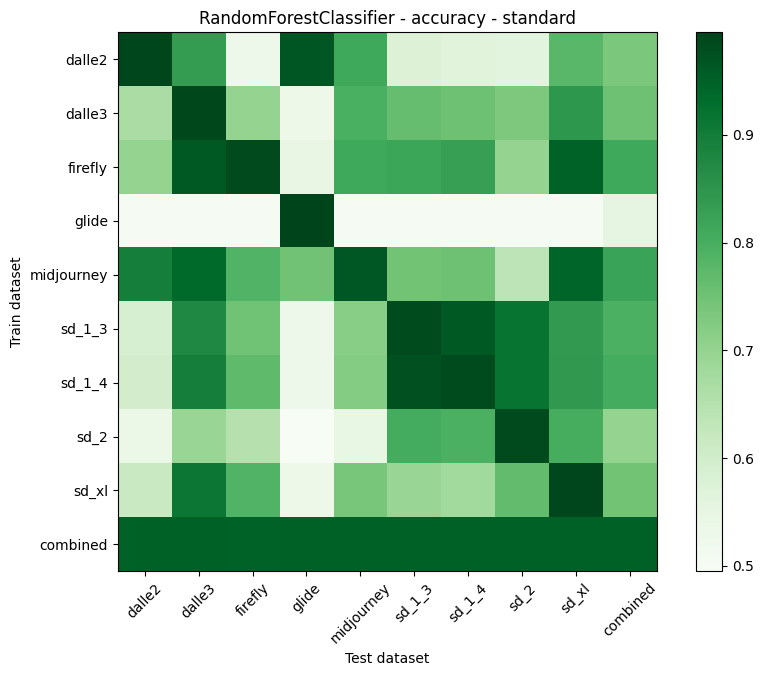

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9900  0.8350   0.5275  0.9675      0.8100  0.5750  0.5650   
dalle3         0.6675  0.9875   0.7000  0.5300      0.7975  0.7625  0.7525   
firefly        0.7000  0.9625   0.9850  0.5475      0.8100  0.8175  0.8300   
glide          0.5000  0.5000   0.5000  0.9950      0.5000  0.5000  0.5000   
midjourney     0.8950  0.9350   0.7875  0.7475      0.9650  0.7450  0.7525   
sd_1_3         0.5875  0.8750   0.7500  0.5275      0.7150  0.9825  0.9625   
sd_1_4         0.5950  0.8950   0.7700  0.5275      0.7225  0.9750  0.9825   
sd_2           0.5350  0.6925   0.6475  0.4950      0.5450  0.8025  0.7925   
sd_xl          0.6175  0.9100   0.7875  0.5300      0.7375  0.6925  0.6800   
combined       0.9500  0.9500   0.9475  0.9500      0.9500  0.9500  0.9500   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.5600  0.7775  0.734167  
dalle3         0.7300  0.8450  0.752500  
firefly        0.7000  0.9475  0.811111  
glide          0.5000  0.5000  0.555000  
midjourney     0.6375  0.9425  0.823056  
sd_1_3         0.9150  0.8400  0.795000  
sd_1_4         0.9150  0.8425  0.802778  
sd_2           0.9850  0.8000  0.699444  
sd_xl          0.7650  0.9900  0.745556  
combined       0.9500  0.9500  0.949722

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9900  0.8350   0.5275  0.9675      0.8100  0.5750  0.5650   
dalle3         0.6675  0.9875   0.7000  0.5300      0.7975  0.7625  0.7525   
firefly        0.7000  0.9625   0.9850  0.5475      0.8100  0.8175  0.8300   
glide          0.5000  0.5000   0.5000  0.9950      0.5000  0.5000  0.5000   
midjourney     0.8950  0.9350   0.7875  0.7475      0.9650  0.7450  0.7525   
sd_1_3         0.5875  0.8750   0.7500  0.5275      0.7150  0.9825  0.9625   
sd_1_4         0.5950  0.8950   0.7700  0.5275      0.7225  0.9750  0.9825   
sd_2           0.5350  0.6925   0.6475  0.4950      0.5450  0.8025  0.7925   
sd_xl          0.6175  0.9100   0.7875  0.5300      0.7375  0.6925  0.6800   
combined       0.9500  0.9500   0.9475  0.9500      0.9500  0.9500  0.9500   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.5600  0.7775  0.734167  
dalle3         0.7300  0.8450  0.752500  
firefly        0.7000  0.9475  0.811111  
glide          0.5000  0.5000  0.555000  
midjourney     0.6375  0.9425  0.823056  
sd_1_3         0.9150  0.8400  0.795000  
sd_1_4         0.9150  0.8425  0.802778  
sd_2           0.9850  0.8000  0.699444  
sd_xl          0.7650  0.9900  0.745556  
combined       0.9500  0.9500  0.949722

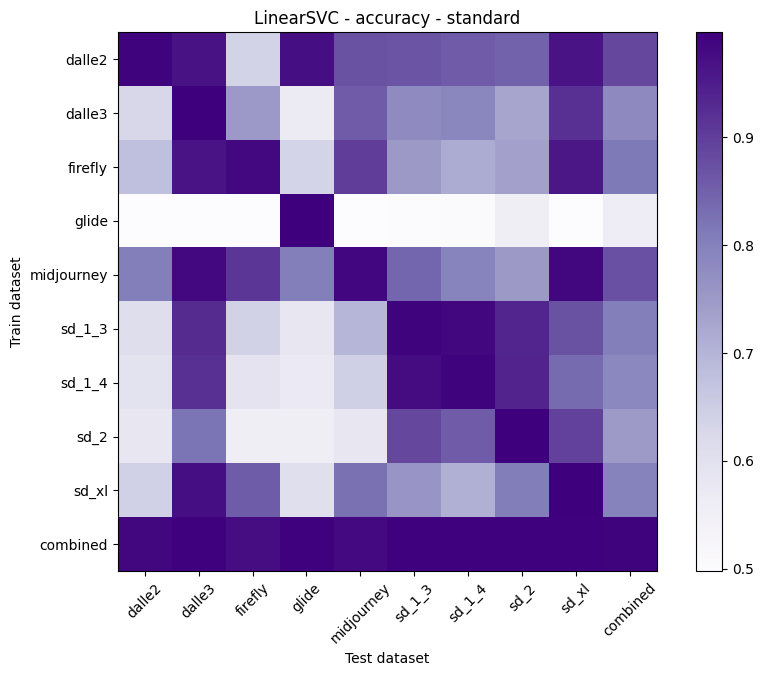

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9900  0.9675   0.6375  0.9725      0.8700  0.8675  0.8575   
dalle3         0.6275  0.9975   0.7500  0.5675      0.8575  0.7775  0.7875   
firefly        0.6775  0.9650   0.9825  0.6350      0.9000  0.7475  0.7175   
glide          0.4975  0.4975   0.4975  0.9975      0.4975  0.5000  0.5050   
midjourney     0.8050  0.9825   0.9100  0.8050      0.9850  0.8425  0.7925   
sd_1_3         0.6075  0.9275   0.6400  0.5825      0.6975  0.9900  0.9875   
sd_1_4         0.5950  0.9200   0.5925  0.5700      0.6450  0.9775  0.9900   
sd_2           0.5825  0.8200   0.5525  0.5525      0.5800  0.8850  0.8575   
sd_xl          0.6425  0.9725   0.8550  0.6050      0.8275  0.7575  0.7100   
combined       0.9875  0.9950   0.9750  0.9950      0.9800  0.9950  0.9950   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.8475  0.9650  0.886111  
dalle3         0.7275  0.9225  0.779444  
firefly        0.7375  0.9600  0.813611  
glide          0.5525  0.4975  0.560278  
midjourney     0.7475  0.9875  0.873056  
sd_1_3         0.9375  0.8700  0.804444  
sd_1_4         0.9400  0.8350  0.785000  
sd_2           0.9975  0.8950  0.746944  
sd_xl          0.8075  0.9975  0.797222  
combined       0.9950  0.9950  0.990278

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9900  0.9675   0.6375  0.9725      0.8700  0.8675  0.8575   
dalle3         0.6275  0.9975   0.7500  0.5675      0.8575  0.7775  0.7875   
firefly        0.6775  0.9650   0.9825  0.6350      0.9000  0.7475  0.7175   
glide          0.4975  0.4975   0.4975  0.9975      0.4975  0.5000  0.5050   
midjourney     0.8050  0.9825   0.9100  0.8050      0.9850  0.8425  0.7925   
sd_1_3         0.6075  0.9275   0.6400  0.5825      0.6975  0.9900  0.9875   
sd_1_4         0.5950  0.9200   0.5925  0.5700      0.6450  0.9775  0.9900   
sd_2           0.5825  0.8200   0.5525  0.5525      0.5800  0.8850  0.8575   
sd_xl          0.6425  0.9725   0.8550  0.6050      0.8275  0.7575  0.7100   
combined       0.9875  0.9950   0.9750  0.9950      0.9800  0.9950  0.9950   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.8475  0.9650  0.886111  
dalle3         0.7275  0.9225  0.779444  
firefly        0.7375  0.9600  0.813611  
glide          0.5525  0.4975  0.560278  
midjourney     0.7475  0.9875  0.873056  
sd_1_3         0.9375  0.8700  0.804444  
sd_1_4         0.9400  0.8350  0.785000  
sd_2           0.9975  0.8950  0.746944  
sd_xl          0.8075  0.9975  0.797222  
combined       0.9950  0.9950  0.990278

In [15]:
print("########################### Accuracy ###########################")
for perturbed_name, results in perturbed_results.items():
    print(f"\n\n\n\n\n\n\n\n ################ Evaluating models trained on {base_perturbed_name} and tested on {perturbed_name}. ################")
    
    # Create a heatmap of results
    df = pd.DataFrame(results).T
    df.reset_index(inplace=True)
    df.columns = ["train_dataset", "test_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

    metric = "accuracy"
    evaluation_data_name = "Test"
    df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)

### MCC - Test

########################### MCC ###########################








 ################ Evaluating models trained on standardAugmented and tested on jpg_quality_50. ################


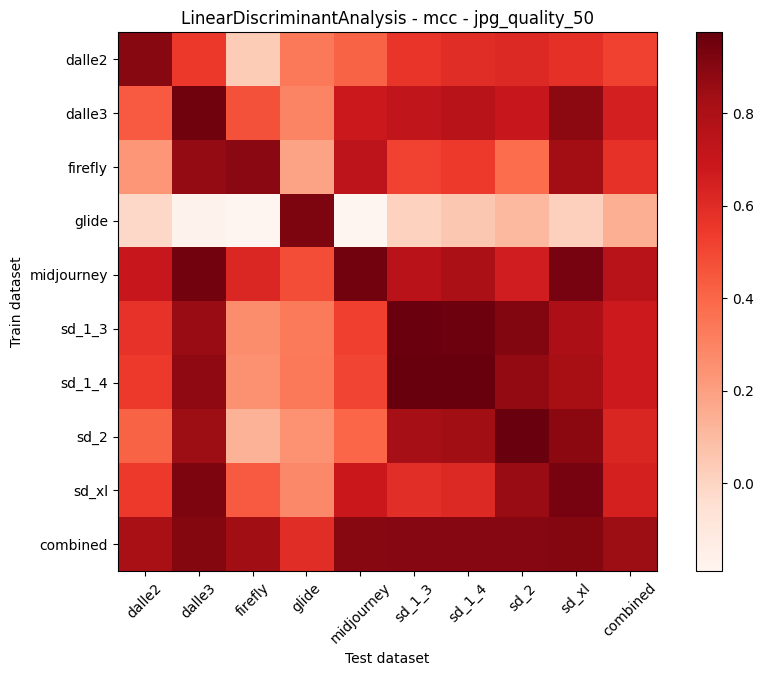

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.896357  0.548860  0.034943  0.333297    0.414779  0.561767   
dalle3         0.440605  0.951190  0.466110  0.295110    0.679871  0.723173   
firefly        0.229482  0.865011  0.890401  0.184348    0.736248  0.514673   
glide         -0.009965 -0.171067 -0.190445  0.921660   -0.190445  0.009641   
midjourney     0.690172  0.945579  0.618580  0.481805    0.945579  0.750930   
sd_1_3         0.570122  0.852733  0.266880  0.331579    0.521148  0.965592   
sd_1_4         0.543159  0.878178  0.250233  0.341198    0.507077  0.975110   
sd_2           0.412055  0.845129  0.131590  0.244406    0.403449  0.822530   
sd_xl          0.546652  0.921152  0.440244  0.279528    0.688211  0.589017   
combined       0.810041  0.904534  0.835512  0.594567    0.893627  0.899066   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.596319  0.609349  0.583333  0.515927  
dalle3         0.754114  0.692763  0.880176  0.649123  
firefly        0.544436  0.380199  0.830374  0.574707  
glide          0.053786  0.107153  0.018983  0.142499  
midjourney     0.804884  0.660465  0.935292  0.752403  
sd_1_3         0.955299  0.910182  0.797858  0.678477  
sd_1_4         0.975110  0.868930  0.814848  0.677332  
sd_2           0.836041  0.970194  0.886876  0.620264  
sd_xl          0.610311  0.855096  0.936981  0.645606  
combined       0.899066  0.899066  0.904534  0.845280

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.896357  0.548860  0.034943  0.333297    0.414779  0.561767   
dalle3         0.440605  0.951190  0.466110  0.295110    0.679871  0.723173   
firefly        0.229482  0.865011  0.890401  0.184348    0.736248  0.514673   
glide         -0.009965 -0.171067 -0.190445  0.921660   -0.190445  0.009641   
midjourney     0.690172  0.945579  0.618580  0.481805    0.945579  0.750930   
sd_1_3         0.570122  0.852733  0.266880  0.331579    0.521148  0.965592   
sd_1_4         0.543159  0.878178  0.250233  0.341198    0.507077  0.975110   
sd_2           0.412055  0.845129  0.131590  0.244406    0.403449  0.822530   
sd_xl          0.546652  0.921152  0.440244  0.279528    0.688211  0.589017   
combined       0.810041  0.904534  0.835512  0.594567    0.893627  0.899066   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.596319  0.609349  0.583333  0.508778  
dalle3         0.754114  0.692763  0.880176  0.653679  
firefly        0.544436  0.380199  0.830374  0.575019  
glide          0.053786  0.107153  0.018983  0.061033  
midjourney     0.804884  0.660465  0.935292  0.759254  
sd_1_3         0.955299  0.910182  0.797858  0.685710  
sd_1_4         0.975110  0.868930  0.814848  0.683760  
sd_2           0.836041  0.970194  0.886876  0.616919  
sd_xl          0.610311  0.855096  0.936981  0.651910  
combined       0.899066  0.899066  0.904534  0.848890

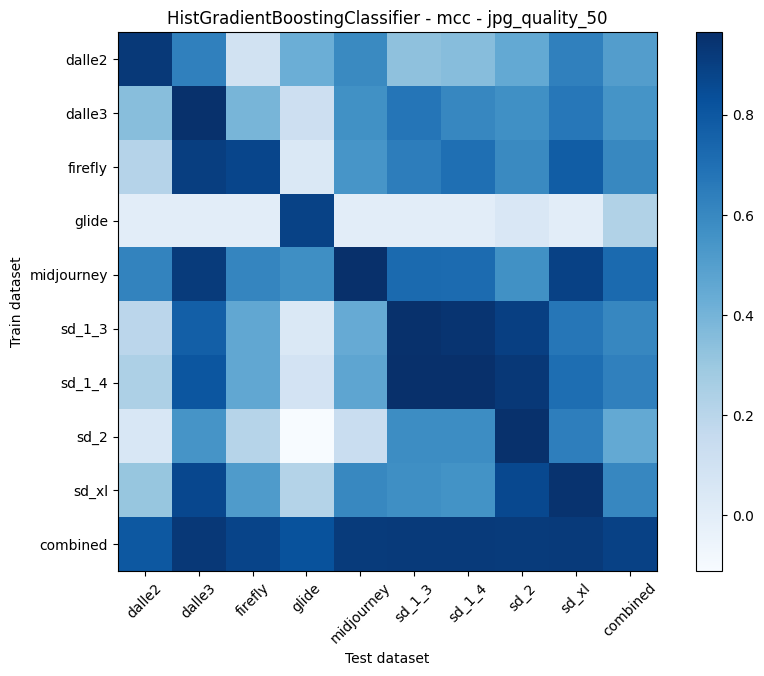

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.926960  0.631992  0.095329  0.422797    0.593012  0.330914   
dalle3         0.347727  0.960192  0.392078  0.117242    0.562106  0.676538   
firefly        0.215718  0.905555  0.876854  0.039477    0.540590  0.642102   
glide          0.000000  0.000000  0.000000  0.886405    0.000000  0.000000   
midjourney     0.616372  0.917584  0.608578  0.573577    0.965302  0.723317   
sd_1_3         0.190822  0.768261  0.458664  0.039477    0.441926  0.960192   
sd_1_4         0.241021  0.808964  0.458831  0.084287    0.466935  0.965109   
sd_2           0.054413  0.547830  0.208996 -0.112509    0.139608  0.579987   
sd_xl          0.309897  0.866260  0.518823  0.216887    0.601338  0.569951   
combined       0.801002  0.927613  0.880396  0.825258    0.916939  0.922262   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.353888  0.451463  0.631992  0.505491  
dalle3         0.605266  0.566029  0.668545  0.552511  
firefly        0.704219  0.593242  0.776990  0.601354  
glide          0.000000  0.050063  0.000000  0.227396  
midjourney     0.719272  0.561915  0.889919  0.724667  
sd_1_3         0.945012  0.900721  0.670902  0.607219  
sd_1_4         0.965109  0.931165  0.704717  0.631516  
sd_2           0.579987  0.960048  0.640513  0.448655  
sd_xl          0.554256  0.861759  0.950428  0.606139  
combined       0.922262  0.916939  0.922262  0.891865

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.926960  0.631992  0.095329  0.422797    0.593012  0.330914   
dalle3         0.347727  0.960192  0.392078  0.117242    0.562106  0.676538   
firefly        0.215718  0.905555  0.876854  0.039477    0.540590  0.642102   
glide          0.000000  0.000000  0.000000  0.886405    0.000000  0.000000   
midjourney     0.616372  0.917584  0.608578  0.573577    0.965302  0.723317   
sd_1_3         0.190822  0.768261  0.458664  0.039477    0.441926  0.960192   
sd_1_4         0.241021  0.808964  0.458831  0.084287    0.466935  0.965109   
sd_2           0.054413  0.547830  0.208996 -0.112509    0.139608  0.579987   
sd_xl          0.309897  0.866260  0.518823  0.216887    0.601338  0.569951   
combined       0.801002  0.927613  0.880396  0.825258    0.916939  0.922262   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.353888  0.451463  0.631992  0.493150  
dalle3         0.605266  0.566029  0.668545  0.543969  
firefly        0.704219  0.593242  0.776990  0.588305  
glide          0.000000  0.050063  0.000000  0.104052  
midjourney     0.719272  0.561915  0.889919  0.730648  
sd_1_3         0.945012  0.900721  0.670902  0.597331  
sd_1_4         0.965109  0.931165  0.704717  0.625126  
sd_2           0.579987  0.960048  0.640513  0.399875  
sd_xl          0.554256  0.861759  0.950428  0.605511  
combined       0.922262  0.916939  0.922262  0.892770

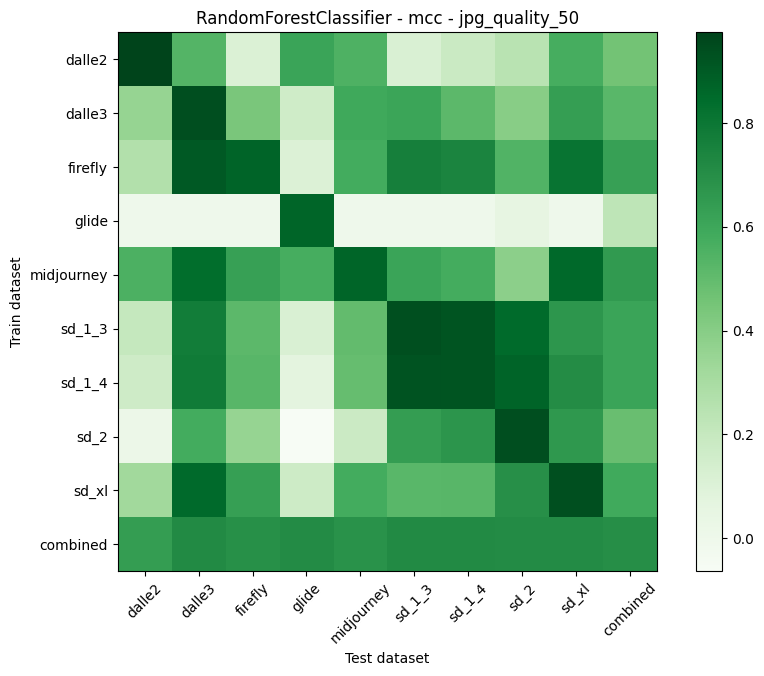

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.975012  0.534601  0.107011  0.613129    0.550329  0.117242   
dalle3         0.355012  0.940188  0.437525  0.161086    0.591034  0.607011   
firefly        0.266346  0.905918  0.872797  0.105780    0.579987  0.761166   
glide          0.000000  0.000000  0.000000  0.868554    0.000000  0.000000   
midjourney     0.556794  0.839641  0.629837  0.572988    0.867443  0.613542   
sd_1_3         0.200000  0.774359  0.513944  0.117579    0.497419  0.935105   
sd_1_4         0.166667  0.781127  0.524750  0.069753    0.491353  0.925289   
sd_2           0.013159  0.578277  0.354827 -0.064051    0.179287  0.639728   
sd_xl          0.318308  0.851680  0.633860  0.168137    0.578332  0.522851   
combined       0.642082  0.717741  0.691868  0.711206    0.685507  0.717741   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.183533  0.241021  0.569951  0.458831  
dalle3         0.515122  0.394996  0.635070  0.520921  
firefly        0.739834  0.543807  0.809155  0.627452  
glide          0.000000  0.050063  0.000000  0.224681  
midjourney     0.577036  0.386033  0.853464  0.651671  
sd_1_3         0.920000  0.847387  0.666667  0.612613  
sd_1_4         0.920184  0.870392  0.710081  0.613121  
sd_2           0.672907  0.940047  0.660419  0.480921  
sd_xl          0.526830  0.698271  0.935573  0.585805  
combined       0.717741  0.711206  0.711206  0.700415

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.975012  0.534601  0.107011  0.613129    0.550329  0.117242   
dalle3         0.355012  0.940188  0.437525  0.161086    0.591034  0.607011   
firefly        0.266346  0.905918  0.872797  0.105780    0.579987  0.761166   
glide          0.000000  0.000000  0.000000  0.868554    0.000000  0.000000   
midjourney     0.556794  0.839641  0.629837  0.572988    0.867443  0.613542   
sd_1_3         0.200000  0.774359  0.513944  0.117579    0.497419  0.935105   
sd_1_4         0.166667  0.781127  0.524750  0.069753    0.491353  0.925289   
sd_2           0.013159  0.578277  0.354827 -0.064051    0.179287  0.639728   
sd_xl          0.318308  0.851680  0.633860  0.168137    0.578332  0.522851   
combined       0.642082  0.717741  0.691868  0.711206    0.685507  0.717741   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.183533  0.241021  0.569951  0.432425  
dalle3         0.515122  0.394996  0.635070  0.515227  
firefly        0.739834  0.543807  0.809155  0.620532  
glide          0.000000  0.050063  0.000000  0.102069  
midjourney     0.577036  0.386033  0.853464  0.655198  
sd_1_3         0.920000  0.847387  0.666667  0.608051  
sd_1_4         0.920184  0.870392  0.710081  0.606622  
sd_2           0.672907  0.940047  0.660419  0.441622  
sd_xl          0.526830  0.698271  0.935573  0.581538  
combined       0.717741  0.711206  0.711206  0.700700

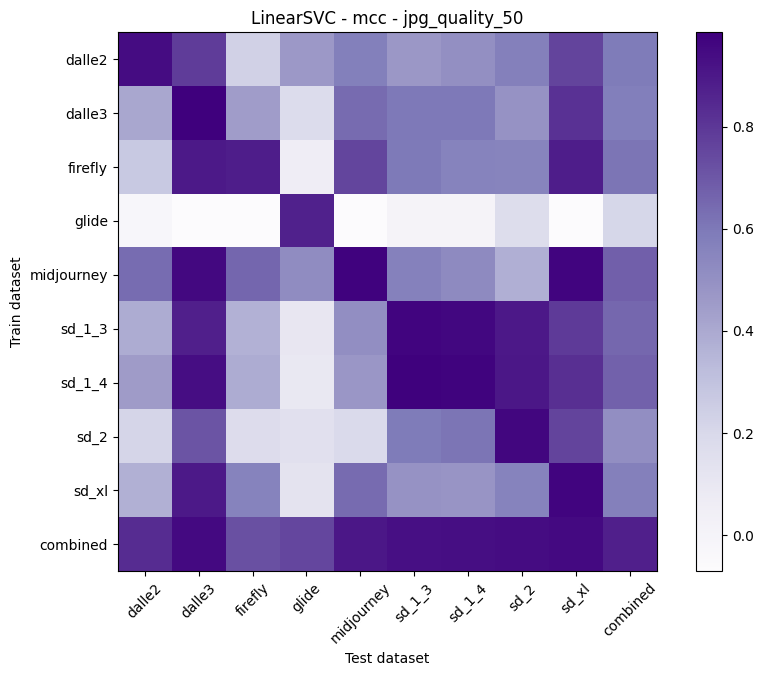

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.941177  0.785132  0.231592  0.463562    0.573577  0.467574   
dalle3         0.406081  0.985012  0.447407  0.178609    0.639822  0.600792   
firefly        0.268603  0.895101  0.885277  0.053695    0.755353  0.593668   
glide         -0.028976 -0.070888 -0.070888  0.870777   -0.070888  0.000000   
midjourney     0.636782  0.955299  0.656598  0.514869    0.975012  0.566029   
sd_1_3         0.390403  0.877471  0.368243  0.105780    0.507472  0.965109   
sd_1_4         0.451463  0.936417  0.389064  0.095329    0.471577  0.980049   
sd_2           0.217072  0.709760  0.175863  0.151717    0.190445  0.592749   
sd_xl          0.373026  0.896897  0.559126  0.129287    0.639093  0.490921   
combined       0.832669  0.950761  0.724641  0.750930    0.905011  0.930186   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.503304  0.569690  0.760129  0.589124  
dalle3         0.600792  0.491461  0.819140  0.577032  
firefly        0.556456  0.552325  0.885277  0.611647  
glide          0.000000  0.168834 -0.070888  0.209108  
midjourney     0.526719  0.374654  0.965109  0.676982  
sd_1_3         0.960048  0.901127  0.787147  0.651357  
sd_1_4         0.970194  0.903667  0.827774  0.669997  
sd_2           0.612022  0.960769  0.762252  0.508234  
sd_xl          0.478735  0.559126  0.965012  0.569761  
combined       0.935292  0.940423  0.950761  0.877154

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.941177  0.785132  0.231592  0.463562    0.573577  0.467574   
dalle3         0.406081  0.985012  0.447407  0.178609    0.639822  0.600792   
firefly        0.268603  0.895101  0.885277  0.053695    0.755353  0.593668   
glide         -0.028976 -0.070888 -0.070888  0.870777   -0.070888  0.000000   
midjourney     0.636782  0.955299  0.656598  0.514869    0.975012  0.566029   
sd_1_3         0.390403  0.877471  0.368243  0.105780    0.507472  0.965109   
sd_1_4         0.451463  0.936417  0.389064  0.095329    0.471577  0.980049   
sd_2           0.217072  0.709760  0.175863  0.151717    0.190445  0.592749   
sd_xl          0.373026  0.896897  0.559126  0.129287    0.639093  0.490921   
combined       0.832669  0.950761  0.724641  0.750930    0.905011  0.930186   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.503304  0.569690  0.760129  0.588415  
dalle3         0.600792  0.491461  0.819140  0.574346  
firefly        0.556456  0.552325  0.885277  0.605084  
glide          0.000000  0.168834 -0.070888  0.080787  
midjourney     0.526719  0.374654  0.965109  0.685674  
sd_1_3         0.960048  0.901127  0.787147  0.651422  
sd_1_4         0.970194  0.903667  0.827774  0.669504  
sd_2           0.612022  0.960769  0.762252  0.485850  
sd_xl          0.478735  0.559126  0.965012  0.565691  
combined       0.935292  0.940423  0.950761  0.880075









 ################ Evaluating models trained on standardAugmented and tested on jpg_quality_70. ################


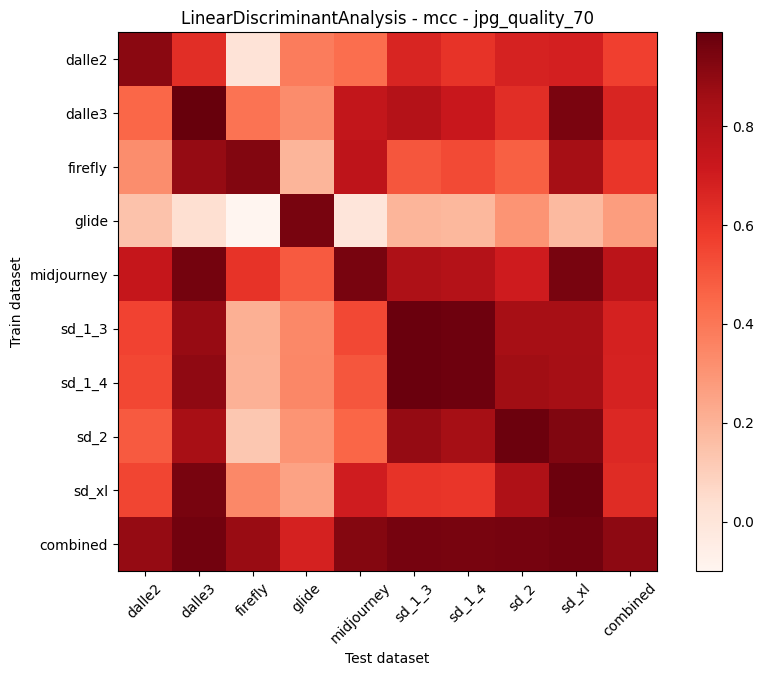

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.910182  0.631176  0.010739  0.385013    0.428856  0.665276   
dalle3         0.450685  0.990050  0.413381  0.329131    0.745644  0.796084   
firefly        0.323388  0.885100  0.926402  0.193278    0.760043  0.504339   
glide          0.145718  0.032026 -0.100504  0.950048    0.000000  0.189329   
midjourney     0.738083  0.960192  0.609477  0.487603    0.950048  0.816932   
sd_1_3         0.559126  0.882830  0.208815  0.341198    0.539162  0.980196   
sd_1_4         0.546673  0.897528  0.202818  0.346573    0.502895  0.980049   
sd_2           0.490855  0.838256  0.127578  0.303621    0.454315  0.883586   
sd_xl          0.547830  0.950000  0.340811  0.255519    0.697917  0.608157   
combined       0.885543  0.960769  0.875887  0.679286    0.925012  0.955585   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.610053  0.678182  0.686827  0.566694  
dalle3         0.725070  0.628885  0.945579  0.663672  
firefly        0.538195  0.474579  0.845264  0.602254  
glide          0.182537  0.302781  0.175575  0.270232  
midjourney     0.794603  0.704219  0.950048  0.772135  
sd_1_3         0.970049  0.841601  0.841601  0.680051  
sd_1_4         0.970000  0.860710  0.847189  0.678878  
sd_2           0.847189  0.975012  0.930745  0.651168  
sd_xl          0.600099  0.813598  0.975305  0.639610  
combined       0.950428  0.955585  0.960769  0.902365

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.910182  0.631176  0.010739  0.385013    0.428856  0.665276   
dalle3         0.450685  0.990050  0.413381  0.329131    0.745644  0.796084   
firefly        0.323388  0.885100  0.926402  0.193278    0.760043  0.504339   
glide          0.145718  0.032026 -0.100504  0.950048    0.000000  0.189329   
midjourney     0.738083  0.960192  0.609477  0.487603    0.950048  0.816932   
sd_1_3         0.559126  0.882830  0.208815  0.341198    0.539162  0.980196   
sd_1_4         0.546673  0.897528  0.202818  0.346573    0.502895  0.980049   
sd_2           0.490855  0.838256  0.127578  0.303621    0.454315  0.883586   
sd_xl          0.547830  0.950000  0.340811  0.255519    0.697917  0.608157   
combined       0.885543  0.960769  0.875887  0.679286    0.925012  0.955585   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.610053  0.678182  0.686827  0.556256  
dalle3         0.725070  0.628885  0.945579  0.669390  
firefly        0.538195  0.474579  0.845264  0.605621  
glide          0.182537  0.302781  0.175575  0.208612  
midjourney     0.794603  0.704219  0.950048  0.779023  
sd_1_3         0.970049  0.841601  0.841601  0.684953  
sd_1_4         0.970000  0.860710  0.847189  0.683826  
sd_2           0.847189  0.975012  0.930745  0.650129  
sd_xl          0.600099  0.813598  0.975305  0.643248  
combined       0.950428  0.955585  0.960769  0.905429

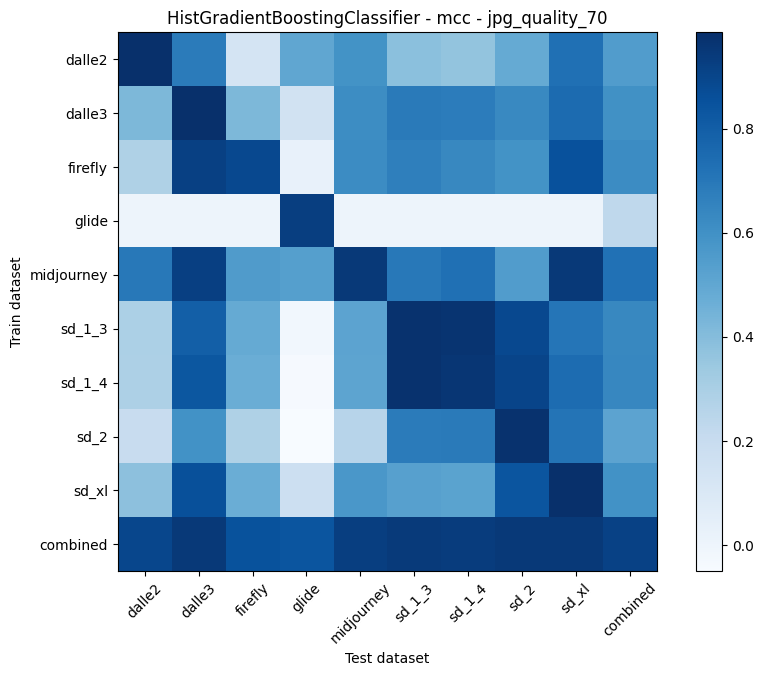

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.985012  0.683213  0.128103  0.503304    0.589124  0.384756   
dalle3         0.420084  0.985111  0.420084  0.151717    0.615882  0.685994   
firefly        0.282131  0.920184  0.886342  0.027206    0.617610  0.666770   
glide          0.000000  0.000000  0.000000  0.927613    0.000000  0.000000   
midjourney     0.697917  0.920414  0.551852  0.535754    0.945012  0.697917   
sd_1_3         0.292739  0.797304  0.486866 -0.019066    0.515122  0.975110   
sd_1_4         0.287641  0.828156  0.470572 -0.041135    0.511102  0.975110   
sd_2           0.192953  0.596901  0.281690 -0.050063    0.254755  0.683213   
sd_xl          0.379046  0.857275  0.470972  0.176300    0.569951  0.530662   
combined       0.895011  0.946433  0.850681  0.836266    0.925567  0.941177   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.362846  0.487500  0.727370  0.546350  
dalle3         0.678125  0.631349  0.750000  0.597885  
firefly        0.633921  0.589188  0.853464  0.619420  
glide          0.000000  0.000000  0.000000  0.232750  
midjourney     0.727162  0.547830  0.945012  0.722957  
sd_1_3         0.965012  0.887500  0.708333  0.635517  
sd_1_4         0.960000  0.901624  0.745888  0.640434  
sd_2           0.687192  0.975110  0.711206  0.515095  
sd_xl          0.518823  0.839498  0.985012  0.593050  
combined       0.935948  0.946433  0.946433  0.913015

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.985012  0.683213  0.128103  0.503304    0.589124  0.384756   
dalle3         0.420084  0.985111  0.420084  0.151717    0.615882  0.685994   
firefly        0.282131  0.920184  0.886342  0.027206    0.617610  0.666770   
glide          0.000000  0.000000  0.000000  0.927613    0.000000  0.000000   
midjourney     0.697917  0.920414  0.551852  0.535754    0.945012  0.697917   
sd_1_3         0.292739  0.797304  0.486866 -0.019066    0.515122  0.975110   
sd_1_4         0.287641  0.828156  0.470572 -0.041135    0.511102  0.975110   
sd_2           0.192953  0.596901  0.281690 -0.050063    0.254755  0.683213   
sd_xl          0.379046  0.857275  0.470972  0.176300    0.569951  0.530662   
combined       0.895011  0.946433  0.850681  0.836266    0.925567  0.941177   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.362846  0.487500  0.727370  0.539025  
dalle3         0.678125  0.631349  0.750000  0.593150  
firefly        0.633921  0.589188  0.853464  0.608535  
glide          0.000000  0.000000  0.000000  0.103068  
midjourney     0.727162  0.547830  0.945012  0.729874  
sd_1_3         0.965012  0.887500  0.708333  0.623213  
sd_1_4         0.960000  0.901624  0.745888  0.626551  
sd_2           0.687192  0.975110  0.711206  0.481440  
sd_xl          0.518823  0.839498  0.985012  0.591949  
combined       0.935948  0.946433  0.946433  0.913772

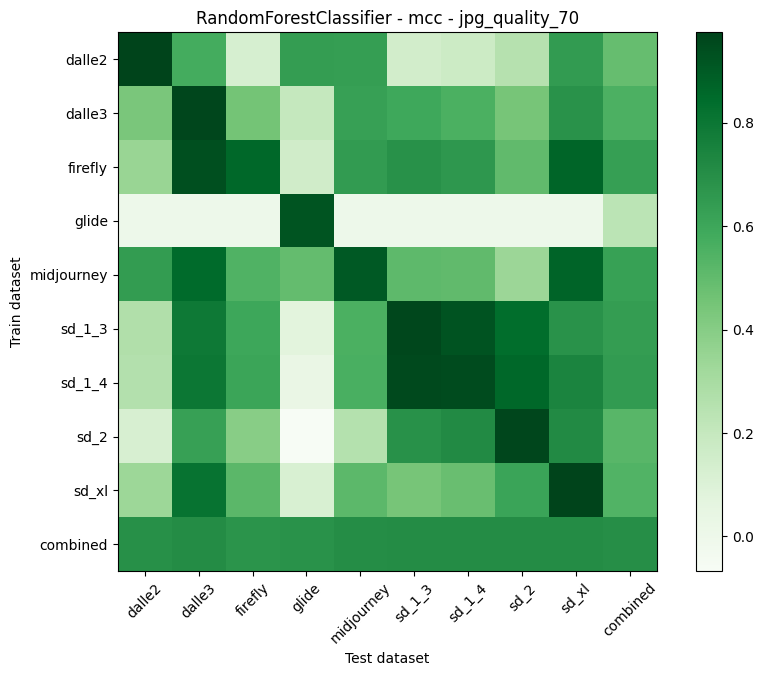

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.975012  0.573873  0.126886  0.640737    0.636782  0.144749   
dalle3         0.436436  0.965592  0.452570  0.197386    0.627478  0.592749   
firefly        0.347727  0.935948  0.857275  0.153093    0.648658  0.688573   
glide          0.000000  0.000000  0.000000  0.918323    0.000000  0.000000   
midjourney     0.643856  0.848069  0.545658  0.492400    0.905283  0.508854   
sd_1_3         0.266439  0.790180  0.597297  0.072357    0.556794  0.960192   
sd_1_4         0.261092  0.799040  0.605414  0.027206    0.560843  0.955107   
sd_2           0.120596  0.627036  0.394996 -0.067505    0.255785  0.687771   
sd_xl          0.332609  0.816187  0.518869  0.118431    0.510892  0.441954   
combined       0.690134  0.709760  0.677270  0.683680    0.703172  0.709760   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.168834  0.252447  0.648658  0.487477  
dalle3         0.558100  0.444528  0.682057  0.553819  
firefly        0.664557  0.498999  0.866260  0.632393  
glide          0.000000  0.000000  0.000000  0.231421  
midjourney     0.500637  0.336288  0.871570  0.623723  
sd_1_3         0.925104  0.839641  0.683340  0.638464  
sd_1_4         0.950048  0.858106  0.742361  0.648478  
sd_2           0.716615  0.965012  0.716615  0.524041  
sd_xl          0.478753  0.610010  0.975012  0.540506  
combined       0.709760  0.709760  0.709760  0.700259

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.975012  0.573873  0.126886  0.640737    0.636782  0.144749   
dalle3         0.436436  0.965592  0.452570  0.197386    0.627478  0.592749   
firefly        0.347727  0.935948  0.857275  0.153093    0.648658  0.688573   
glide          0.000000  0.000000  0.000000  0.918323    0.000000  0.000000   
midjourney     0.643856  0.848069  0.545658  0.492400    0.905283  0.508854   
sd_1_3         0.266439  0.790180  0.597297  0.072357    0.556794  0.960192   
sd_1_4         0.261092  0.799040  0.605414  0.027206    0.560843  0.955107   
sd_2           0.120596  0.627036  0.394996 -0.067505    0.255785  0.687771   
sd_xl          0.332609  0.816187  0.518869  0.118431    0.510892  0.441954   
combined       0.690134  0.709760  0.677270  0.683680    0.703172  0.709760   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.168834  0.252447  0.648658  0.463109  
dalle3         0.558100  0.444528  0.682057  0.550766  
firefly        0.664557  0.498999  0.866260  0.629010  
glide          0.000000  0.000000  0.000000  0.102036  
midjourney     0.500637  0.336288  0.871570  0.628068  
sd_1_3         0.925104  0.839641  0.683340  0.632372  
sd_1_4         0.950048  0.858106  0.742361  0.639913  
sd_2           0.716615  0.965012  0.716615  0.490769  
sd_xl          0.478753  0.610010  0.975012  0.533635  
combined       0.709760  0.709760  0.709760  0.700340

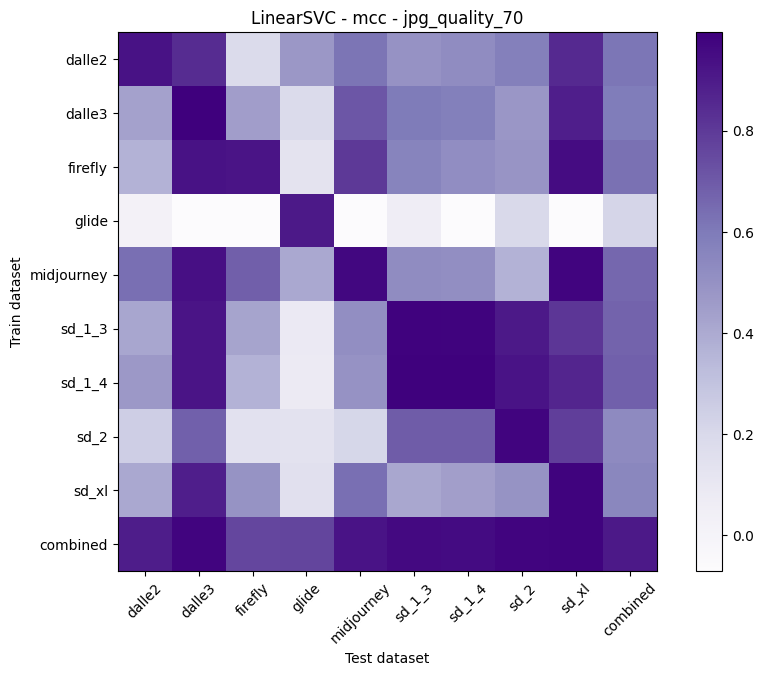

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.931165  0.843919  0.183533  0.470972    0.617063  0.498999   
dalle3         0.436436  0.995012  0.448555  0.183280    0.709760  0.596601   
firefly        0.368562  0.930419  0.920737  0.129287    0.801669  0.559126   
glide          0.022502 -0.070888 -0.070888  0.907556   -0.070888  0.057197   
midjourney     0.633860  0.940423  0.686076  0.404116    0.970000  0.522851   
sd_1_3         0.413381  0.921660  0.421775  0.084287    0.514869  0.985012   
sd_1_4         0.467574  0.922262  0.367281  0.082269    0.495415  0.990000   
sd_2           0.246998  0.682057  0.142857  0.133460    0.210681  0.693889   
sd_xl          0.404918  0.889021  0.495017  0.153093    0.636782  0.409159   
combined       0.892189  0.975110  0.758585  0.762840    0.925567  0.960000   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.522773  0.577795  0.852807  0.612255  
dalle3         0.581199  0.476439  0.890911  0.591893  
firefly        0.519138  0.486866  0.950048  0.630159  
glide         -0.070888  0.197386 -0.070888  0.219665  
midjourney     0.514883  0.369212  0.975012  0.660078  
sd_1_3         0.980000  0.907556  0.808964  0.671650  
sd_1_4         0.990000  0.926960  0.862899  0.678801  
sd_2           0.693889  0.975305  0.782881  0.529795  
sd_xl          0.442492  0.495017  0.980000  0.548584  
combined       0.955012  0.975110  0.980196  0.906372

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.931165  0.843919  0.183533  0.470972    0.617063  0.498999   
dalle3         0.436436  0.995012  0.448555  0.183280    0.709760  0.596601   
firefly        0.368562  0.930419  0.920737  0.129287    0.801669  0.559126   
glide          0.022502 -0.070888 -0.070888  0.907556   -0.070888  0.057197   
midjourney     0.633860  0.940423  0.686076  0.404116    0.970000  0.522851   
sd_1_3         0.413381  0.921660  0.421775  0.084287    0.514869  0.985012   
sd_1_4         0.467574  0.922262  0.367281  0.082269    0.495415  0.990000   
sd_2           0.246998  0.682057  0.142857  0.133460    0.210681  0.693889   
sd_xl          0.404918  0.889021  0.495017  0.153093    0.636782  0.409159   
combined       0.892189  0.975110  0.758585  0.762840    0.925567  0.960000   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.522773  0.577795  0.852807  0.611003  
dalle3         0.581199  0.476439  0.890911  0.590910  
firefly        0.519138  0.486866  0.950048  0.629539  
glide         -0.070888  0.197386 -0.070888  0.092244  
midjourney     0.514883  0.369212  0.975012  0.668493  
sd_1_3         0.980000  0.907556  0.808964  0.670834  
sd_1_4         0.990000  0.926960  0.862899  0.678296  
sd_2           0.693889  0.975305  0.782881  0.506891  
sd_xl          0.442492  0.495017  0.980000  0.545055  
combined       0.955012  0.975110  0.980196  0.909401









 ################ Evaluating models trained on standardAugmented and tested on jpg_quality_90. ################


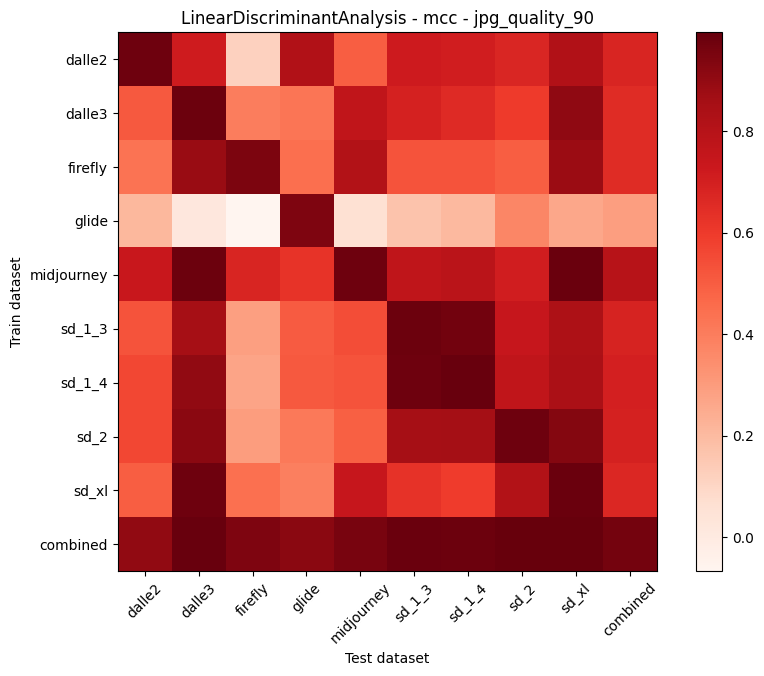

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.975012  0.716904  0.117242  0.817617    0.495017  0.720983   
dalle3         0.511102  0.980196  0.399326  0.424932    0.762840  0.695973   
firefly        0.434524  0.885543  0.945295  0.443026    0.814945  0.526299   
glide          0.208815  0.016857 -0.067505  0.945106    0.058621  0.168430   
midjourney     0.735288  0.980049  0.677980  0.621921    0.975012  0.768837   
sd_1_3         0.527158  0.855190  0.287641  0.503047    0.543159  0.980196   
sd_1_4         0.562106  0.902894  0.268931  0.510909    0.526719  0.975012   
sd_2           0.562106  0.916939  0.294973  0.413381    0.491029  0.857275   
sd_xl          0.495017  0.975012  0.442492  0.392078    0.745644  0.628885   
combined       0.903667  0.990000  0.941177  0.917584    0.955585  0.985012   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.704717  0.672538  0.817617  0.675648  
dalle3         0.655229  0.599019  0.906372  0.653882  
firefly        0.526299  0.493276  0.880705  0.653646  
glide          0.202457  0.368562  0.261262  0.293303  
midjourney     0.785878  0.706438  0.985111  0.797828  
sd_1_3         0.970049  0.745888  0.832622  0.686861  
sd_1_4         0.990050  0.766465  0.839498  0.697528  
sd_2           0.861759  0.975012  0.931165  0.692598  
sd_xl          0.593486  0.813284  0.985012  0.667215  
combined       0.980049  0.995012  0.995012  0.962053

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.975012  0.716904  0.117242  0.817617    0.495017  0.720983   
dalle3         0.511102  0.980196  0.399326  0.424932    0.762840  0.695973   
firefly        0.434524  0.885543  0.945295  0.443026    0.814945  0.526299   
glide          0.208815  0.016857 -0.067505  0.945106    0.058621  0.168430   
midjourney     0.735288  0.980049  0.677980  0.621921    0.975012  0.768837   
sd_1_3         0.527158  0.855190  0.287641  0.503047    0.543159  0.980196   
sd_1_4         0.562106  0.902894  0.268931  0.510909    0.526719  0.975012   
sd_2           0.562106  0.916939  0.294973  0.413381    0.491029  0.857275   
sd_xl          0.495017  0.975012  0.442492  0.392078    0.745644  0.628885   
combined       0.903667  0.990000  0.941177  0.917584    0.955585  0.985012   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.704717  0.672538  0.817617  0.670850  
dalle3         0.655229  0.599019  0.906372  0.659443  
firefly        0.526299  0.493276  0.880705  0.661101  
glide          0.202457  0.368562  0.261262  0.240290  
midjourney     0.785878  0.706438  0.985111  0.804057  
sd_1_3         0.970049  0.745888  0.832622  0.693883  
sd_1_4         0.990050  0.766465  0.839498  0.704732  
sd_2           0.861759  0.975012  0.931165  0.700404  
sd_xl          0.593486  0.813284  0.985012  0.674546  
combined       0.980049  0.995012  0.995012  0.962567

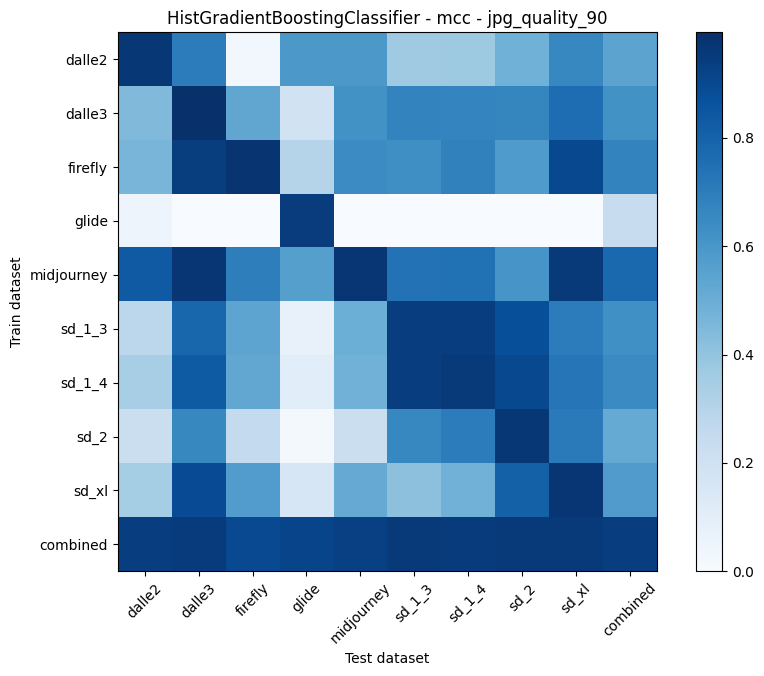

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.965302  0.700027  0.027206  0.593242    0.593242  0.368216   
dalle3         0.444528  0.995012  0.531085  0.190445    0.619744  0.674200   
firefly        0.462888  0.940753  0.975012  0.300000    0.644695  0.632832   
glide          0.050063  0.000000  0.000000  0.946433    0.000000  0.000000   
midjourney     0.833812  0.970000  0.694199  0.562509    0.970000  0.739445   
sd_1_3         0.278002  0.787758  0.538631  0.075173    0.497419  0.940188   
sd_1_4         0.345614  0.829586  0.525239  0.105269    0.480000  0.940047   
sd_2           0.221163  0.659276  0.255785  0.016857    0.221163  0.663328   
sd_xl          0.351161  0.888214  0.574377  0.160591    0.510892  0.412637   
combined       0.940423  0.950761  0.895101  0.915011    0.930186  0.955968   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.372704  0.483492  0.662644  0.541941  
dalle3         0.670280  0.666366  0.758158  0.618457  
firefly        0.680543  0.581717  0.898251  0.673871  
glide          0.000000  0.000000  0.000000  0.236048  
midjourney     0.743613  0.606045  0.955107  0.779228  
sd_1_3         0.940188  0.875887  0.700473  0.629615  
sd_1_4         0.955299  0.900405  0.723553  0.645232  
sd_2           0.700085  0.965012  0.708333  0.514676  
sd_xl          0.478753  0.807460  0.970000  0.575256  
combined       0.950761  0.955968  0.955968  0.938710

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.965302  0.700027  0.027206  0.593242    0.593242  0.368216   
dalle3         0.444528  0.995012  0.531085  0.190445    0.619744  0.674200   
firefly        0.462888  0.940753  0.975012  0.300000    0.644695  0.632832   
glide          0.050063  0.000000  0.000000  0.946433    0.000000  0.000000   
midjourney     0.833812  0.970000  0.694199  0.562509    0.970000  0.739445   
sd_1_3         0.278002  0.787758  0.538631  0.075173    0.497419  0.940188   
sd_1_4         0.345614  0.829586  0.525239  0.105269    0.480000  0.940047   
sd_2           0.221163  0.659276  0.255785  0.016857    0.221163  0.663328   
sd_xl          0.351161  0.888214  0.574377  0.160591    0.510892  0.412637   
combined       0.940423  0.950761  0.895101  0.915011    0.930186  0.955968   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.372704  0.483492  0.662644  0.529564  
dalle3         0.670280  0.666366  0.758158  0.616646  
firefly        0.680543  0.581717  0.898251  0.679632  
glide          0.000000  0.000000  0.000000  0.110722  
midjourney     0.743613  0.606045  0.955107  0.786081  
sd_1_3         0.940188  0.875887  0.700473  0.625969  
sd_1_4         0.955299  0.900405  0.723553  0.645001  
sd_2           0.700085  0.965012  0.708333  0.490111  
sd_xl          0.478753  0.807460  0.970000  0.572676  
combined       0.950761  0.955968  0.955968  0.938905

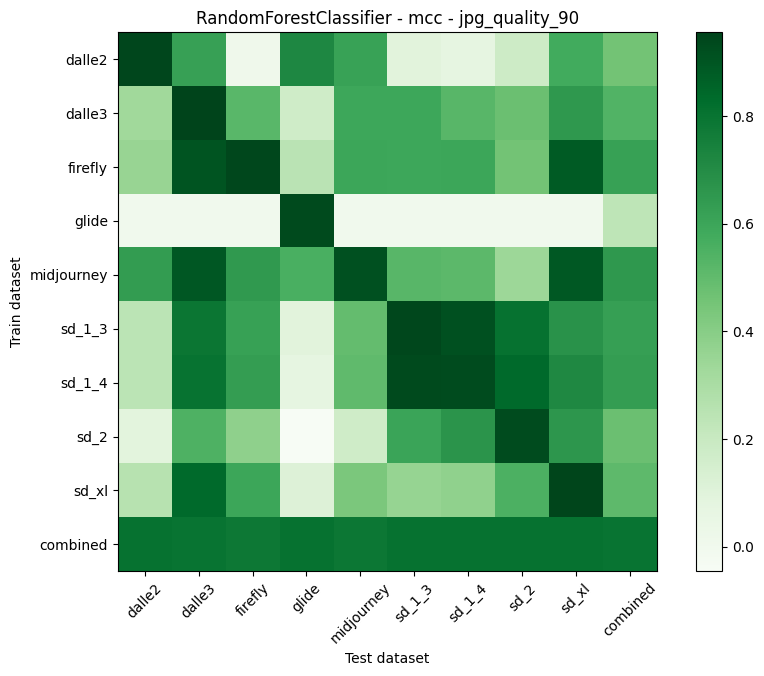

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.945958  0.620571  0.011209  0.718799    0.612190  0.094916   
dalle3         0.326207  0.955585  0.519015  0.171067    0.593012  0.593012   
firefly        0.355717  0.902213  0.940423  0.245343    0.598120  0.594160   
glide          0.000000  0.000000  0.000000  0.932287    0.000000  0.000000   
midjourney     0.636455  0.896357  0.648643  0.559893    0.915561  0.523655   
sd_1_3         0.240672  0.787758  0.616742  0.092952    0.493276  0.940188   
sd_1_4         0.241897  0.800310  0.631090  0.072296    0.502648  0.935292   
sd_2           0.087727  0.545658  0.377420 -0.045862    0.172649  0.606869   
sd_xl          0.255785  0.837104  0.599019  0.111537    0.433341  0.359556   
combined       0.803798  0.797790  0.779973  0.803798    0.785878  0.803798   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.069753  0.179414  0.578808  0.458114  
dalle3         0.522931  0.475570  0.651597  0.539856  
firefly        0.598120  0.458413  0.883586  0.617507  
glide          0.000000  0.000000  0.000000  0.233413  
midjourney     0.511524  0.340811  0.891606  0.653168  
sd_1_3         0.915011  0.805823  0.675072  0.623633  
sd_1_4         0.930186  0.837358  0.715965  0.634340  
sd_2           0.668738  0.930000  0.660419  0.477697  
sd_xl          0.373026  0.551145  0.950048  0.507077  
combined       0.803798  0.803798  0.803798  0.798455

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.945958  0.620571  0.011209  0.718799    0.612190  0.094916   
dalle3         0.326207  0.955585  0.519015  0.171067    0.593012  0.593012   
firefly        0.355717  0.902213  0.940423  0.245343    0.598120  0.594160   
glide          0.000000  0.000000  0.000000  0.932287    0.000000  0.000000   
midjourney     0.636455  0.896357  0.648643  0.559893    0.915561  0.523655   
sd_1_3         0.240672  0.787758  0.616742  0.092952    0.493276  0.940188   
sd_1_4         0.241897  0.800310  0.631090  0.072296    0.502648  0.935292   
sd_2           0.087727  0.545658  0.377420 -0.045862    0.172649  0.606869   
sd_xl          0.255785  0.837104  0.599019  0.111537    0.433341  0.359556   
combined       0.803798  0.797790  0.779973  0.803798    0.785878  0.803798   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.069753  0.179414  0.578808  0.425735  
dalle3         0.522931  0.475570  0.651597  0.534222  
firefly        0.598120  0.458413  0.883586  0.619566  
glide          0.000000  0.000000  0.000000  0.103587  
midjourney     0.511524  0.340811  0.891606  0.658278  
sd_1_3         0.915011  0.805823  0.675072  0.618611  
sd_1_4         0.930186  0.837358  0.715965  0.629671  
sd_2           0.668738  0.930000  0.660419  0.444847  
sd_xl          0.373026  0.551145  0.950048  0.496729  
combined       0.803798  0.803798  0.803798  0.798492

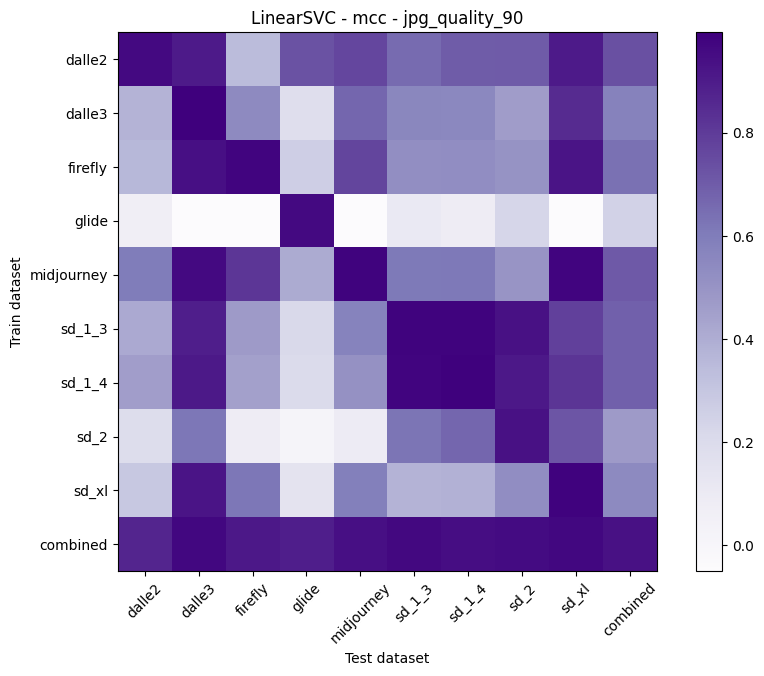

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.960000  0.901624  0.345834  0.729103    0.762840  0.655229   
dalle3         0.376069  0.995012  0.538556  0.178609    0.671316  0.554136   
firefly        0.361321  0.940753  0.975012  0.263517    0.766465  0.522773   
glide          0.067505 -0.050063 -0.050063  0.960432   -0.050063  0.107143   
midjourney     0.603014  0.960000  0.814848  0.407930    0.980196  0.611010   
sd_1_3         0.414474  0.889919  0.471577  0.212973    0.573577  0.980049   
sd_1_4         0.459540  0.908287  0.451463  0.206474    0.511170  0.975110   
sd_2           0.189578  0.618580  0.081127  0.011753    0.089682  0.626915   
sd_xl          0.291967  0.922262  0.616372  0.146553    0.589124  0.376069   
combined       0.867443  0.970437  0.910410  0.891115    0.940000  0.965302   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.700085  0.704205  0.901624  0.735146  
dalle3         0.550244  0.463562  0.849613  0.577463  
firefly        0.526719  0.502975  0.921660  0.637222  
glide          0.082269  0.231592 -0.050063  0.247851  
midjourney     0.615012  0.494969  0.975110  0.708333  
sd_1_3         0.980049  0.936417  0.785132  0.687634  
sd_1_4         0.990000  0.912926  0.819140  0.686307  
sd_2           0.668915  0.935292  0.720298  0.471562  
sd_xl          0.384756  0.526842  0.985012  0.543753  
combined       0.950048  0.955107  0.970437  0.935012

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.960000  0.901624  0.345834  0.729103    0.762840  0.655229   
dalle3         0.376069  0.995012  0.538556  0.178609    0.671316  0.554136   
firefly        0.361321  0.940753  0.975012  0.263517    0.766465  0.522773   
glide          0.067505 -0.050063 -0.050063  0.960432   -0.050063  0.107143   
midjourney     0.603014  0.960000  0.814848  0.407930    0.980196  0.611010   
sd_1_3         0.414474  0.889919  0.471577  0.212973    0.573577  0.980049   
sd_1_4         0.459540  0.908287  0.451463  0.206474    0.511170  0.975110   
sd_2           0.189578  0.618580  0.081127  0.011753    0.089682  0.626915   
sd_xl          0.291967  0.922262  0.616372  0.146553    0.589124  0.376069   
combined       0.867443  0.970437  0.910410  0.891115    0.940000  0.965302   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.700085  0.704205  0.901624  0.740061  
dalle3         0.550244  0.463562  0.849613  0.575235  
firefly        0.526719  0.502975  0.921660  0.642355  
glide          0.082269  0.231592 -0.050063  0.138743  
midjourney     0.615012  0.494969  0.975110  0.718010  
sd_1_3         0.980049  0.936417  0.785132  0.693796  
sd_1_4         0.990000  0.912926  0.819140  0.692679  
sd_2           0.668915  0.935292  0.720298  0.438016  
sd_xl          0.384756  0.526842  0.985012  0.537662  
combined       0.950048  0.955107  0.970437  0.935589









 ################ Evaluating models trained on standardAugmented and tested on jpg_quality_80. ################


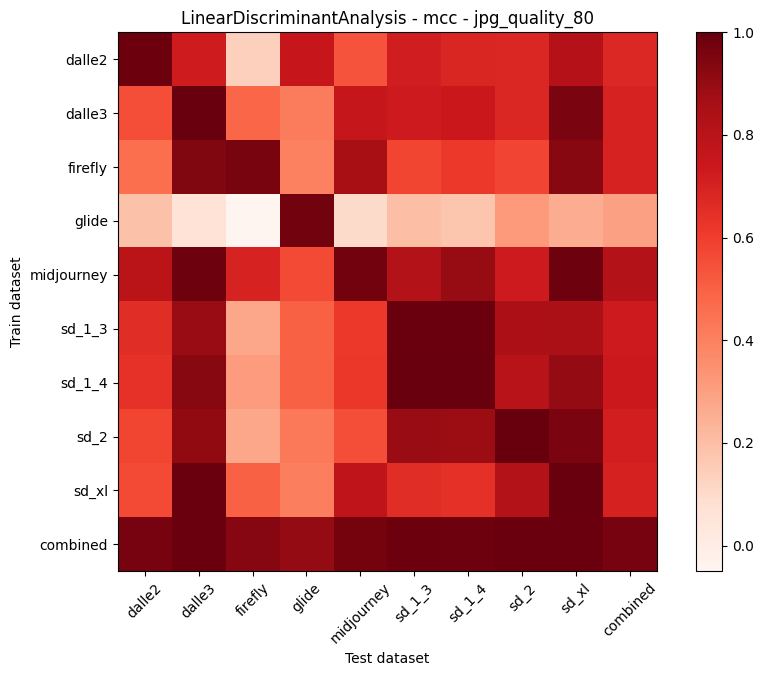

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.985012  0.725070  0.136032  0.749787    0.538537  0.712834   
dalle3         0.550244  0.995012  0.479555  0.414474    0.756000  0.727370   
firefly        0.462487  0.945012  0.960048  0.399119    0.858885  0.575967   
glide          0.189484  0.064051 -0.050252  0.975012    0.098689  0.196231   
midjourney     0.791817  0.980000  0.692598  0.562106    0.975012  0.817617   
sd_1_3         0.659469  0.889919  0.276454  0.495415    0.616372  0.990000   
sd_1_4         0.639822  0.926960  0.311829  0.499363    0.620273  0.995012   
sd_2           0.573501  0.909112  0.274352  0.424195    0.550392  0.890911   
sd_xl          0.561915  0.990000  0.499363  0.401857    0.776753  0.655531   
combined       0.965109  0.990050  0.931165  0.898251    0.970049  0.985012   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.680543  0.676538  0.813284  0.672538  
dalle3         0.739583  0.679242  0.955585  0.692950  
firefly        0.616225  0.579987  0.930186  0.694233  
glide          0.175454  0.318308  0.256577  0.295274  
midjourney     0.893627  0.729167  0.980000  0.818099  
sd_1_3         0.990000  0.840832  0.845215  0.726468  
sd_1_4         0.995012  0.802034  0.899066  0.734145  
sd_2           0.886405  1.000000  0.955968  0.709760  
sd_xl          0.643743  0.819140  0.995012  0.696944  
combined       0.980000  0.990050  0.990050  0.966204

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.985012  0.725070  0.136032  0.749787    0.538537  0.712834   
dalle3         0.550244  0.995012  0.479555  0.414474    0.756000  0.727370   
firefly        0.462487  0.945012  0.960048  0.399119    0.858885  0.575967   
glide          0.189484  0.064051 -0.050252  0.975012    0.098689  0.196231   
midjourney     0.791817  0.980000  0.692598  0.562106    0.975012  0.817617   
sd_1_3         0.659469  0.889919  0.276454  0.495415    0.616372  0.990000   
sd_1_4         0.639822  0.926960  0.311829  0.499363    0.620273  0.995012   
sd_2           0.573501  0.909112  0.274352  0.424195    0.550392  0.890911   
sd_xl          0.561915  0.990000  0.499363  0.401857    0.776753  0.655531   
combined       0.965109  0.990050  0.931165  0.898251    0.970049  0.985012   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.680543  0.676538  0.813284  0.668626  
dalle3         0.739583  0.679242  0.955585  0.699674  
firefly        0.616225  0.579987  0.930186  0.703102  
glide          0.175454  0.318308  0.256577  0.247062  
midjourney     0.893627  0.729167  0.980000  0.824660  
sd_1_3         0.990000  0.840832  0.845215  0.733742  
sd_1_4         0.995012  0.802034  0.899066  0.743263  
sd_2           0.886405  1.000000  0.955968  0.718315  
sd_xl          0.643743  0.819140  0.995012  0.704813  
combined       0.980000  0.990050  0.990050  0.966637

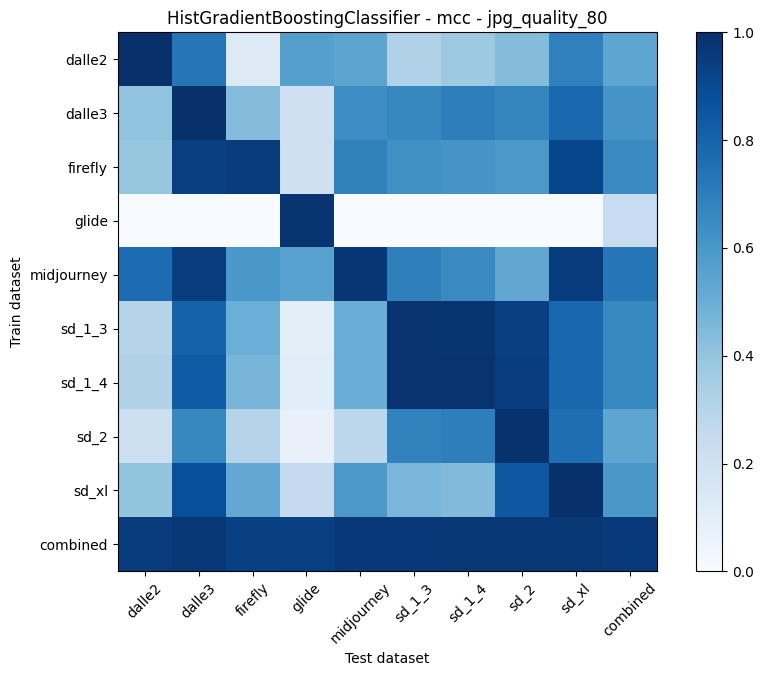

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.995012  0.727370  0.128103  0.565803    0.542454  0.316667   
dalle3         0.403473  1.000000  0.436436  0.210681    0.639101  0.662457   
firefly        0.390645  0.935292  0.955012  0.208815    0.683680  0.627036   
glide          0.000000  0.000000  0.000000  0.980196    0.000000  0.000000   
midjourney     0.767105  0.945106  0.599019  0.551145    0.975110  0.691868   
sd_1_3         0.298630  0.807460  0.498888  0.098689    0.502895  0.985111   
sd_1_4         0.318308  0.829384  0.466577  0.108826    0.502895  0.985111   
sd_2           0.217072  0.662457  0.304789  0.070888    0.279584  0.682057   
sd_xl          0.399275  0.881917  0.527215  0.252646    0.596601  0.464549   
combined       0.950048  0.970437  0.935012  0.940000    0.965302  0.965302   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.371688  0.435165  0.691177  0.538556  
dalle3         0.697846  0.670280  0.782881  0.612450  
firefly        0.611010  0.595026  0.911140  0.654780  
glide          0.000000  0.000000  0.000000  0.239957  
midjourney     0.655229  0.531162  0.955012  0.733285  
sd_1_3         0.980049  0.935573  0.785878  0.656511  
sd_1_4         0.985111  0.945295  0.785878  0.658740  
sd_2           0.697846  0.990050  0.758158  0.537528  
sd_xl          0.444528  0.846604  0.995012  0.598313  
combined       0.970437  0.970437  0.970437  0.959626

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.995012  0.727370  0.128103  0.565803    0.542454  0.316667   
dalle3         0.403473  1.000000  0.436436  0.210681    0.639101  0.662457   
firefly        0.390645  0.935292  0.955012  0.208815    0.683680  0.627036   
glide          0.000000  0.000000  0.000000  0.980196    0.000000  0.000000   
midjourney     0.767105  0.945106  0.599019  0.551145    0.975110  0.691868   
sd_1_3         0.298630  0.807460  0.498888  0.098689    0.502895  0.985111   
sd_1_4         0.318308  0.829384  0.466577  0.108826    0.502895  0.985111   
sd_2           0.217072  0.662457  0.304789  0.070888    0.279584  0.682057   
sd_xl          0.399275  0.881917  0.527215  0.252646    0.596601  0.464549   
combined       0.950048  0.970437  0.935012  0.940000    0.965302  0.965302   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.371688  0.435165  0.691177  0.530382  
dalle3         0.697846  0.670280  0.782881  0.611462  
firefly        0.611010  0.595026  0.911140  0.657517  
glide          0.000000  0.000000  0.000000  0.108911  
midjourney     0.655229  0.531162  0.955012  0.741195  
sd_1_3         0.980049  0.935573  0.785878  0.654797  
sd_1_4         0.985111  0.945295  0.785878  0.658598  
sd_2           0.697846  0.990050  0.758158  0.518100  
sd_xl          0.444528  0.846604  0.995012  0.600927  
combined       0.970437  0.970437  0.970437  0.959712

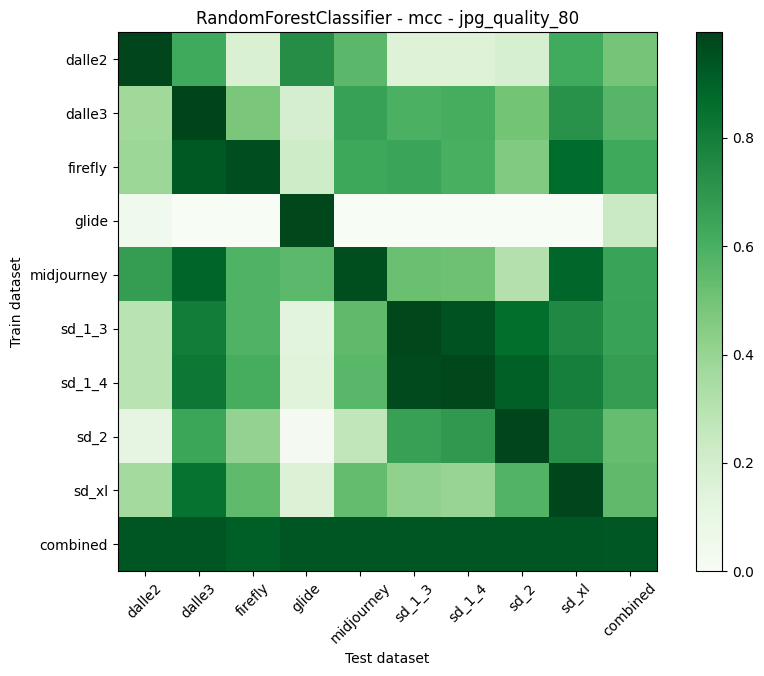

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.990000  0.624176  0.171067  0.735503    0.558026  0.155083   
dalle3         0.369274  0.995012  0.480384  0.190445    0.658553  0.596601   
firefly        0.382470  0.930745  0.960048  0.215562    0.633860  0.645834   
glide          0.050063  0.000000  0.000000  0.980196    0.000000  0.000000   
midjourney     0.673942  0.892862  0.586245  0.554594    0.965012  0.518869   
sd_1_3         0.287641  0.801669  0.583054  0.129287    0.543159  0.980196   
sd_1_4         0.288489  0.820571  0.610010  0.136323    0.562509  0.975012   
sd_2           0.117242  0.644695  0.409159  0.022502    0.268931  0.664557   
sd_xl          0.358382  0.840832  0.546350  0.163239    0.534655  0.418644   
combined       0.936981  0.936981  0.910729  0.936981    0.936981  0.936981   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.155083  0.185895  0.620273  0.491021  
dalle3         0.608164  0.496091  0.717741  0.570935  
firefly        0.606045  0.462500  0.869808  0.632089  
glide          0.000000  0.000000  0.000000  0.240604  
midjourney     0.510892  0.313458  0.888214  0.650723  
sd_1_3         0.945106  0.859753  0.754342  0.655679  
sd_1_4         0.980049  0.906918  0.790169  0.674838  
sd_2           0.688573  0.990050  0.729167  0.530662  
sd_xl          0.397613  0.577463  0.985012  0.540289  
combined       0.936981  0.936981  0.936981  0.934032

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.990000  0.624176  0.171067  0.735503    0.558026  0.155083   
dalle3         0.369274  0.995012  0.480384  0.190445    0.658553  0.596601   
firefly        0.382470  0.930745  0.960048  0.215562    0.633860  0.645834   
glide          0.050063  0.000000  0.000000  0.980196    0.000000  0.000000   
midjourney     0.673942  0.892862  0.586245  0.554594    0.965012  0.518869   
sd_1_3         0.287641  0.801669  0.583054  0.129287    0.543159  0.980196   
sd_1_4         0.288489  0.820571  0.610010  0.136323    0.562509  0.975012   
sd_2           0.117242  0.644695  0.409159  0.022502    0.268931  0.664557   
sd_xl          0.358382  0.840832  0.546350  0.163239    0.534655  0.418644   
combined       0.936981  0.936981  0.910729  0.936981    0.936981  0.936981   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.155083  0.185895  0.620273  0.466123  
dalle3         0.608164  0.496091  0.717741  0.568029  
firefly        0.606045  0.462500  0.869808  0.634097  
glide          0.000000  0.000000  0.000000  0.114473  
midjourney     0.510892  0.313458  0.888214  0.656010  
sd_1_3         0.945106  0.859753  0.754342  0.653801  
sd_1_4         0.980049  0.906918  0.790169  0.674450  
sd_2           0.688573  0.990050  0.729167  0.503875  
sd_xl          0.397613  0.577463  0.985012  0.535799  
combined       0.936981  0.936981  0.936981  0.934065

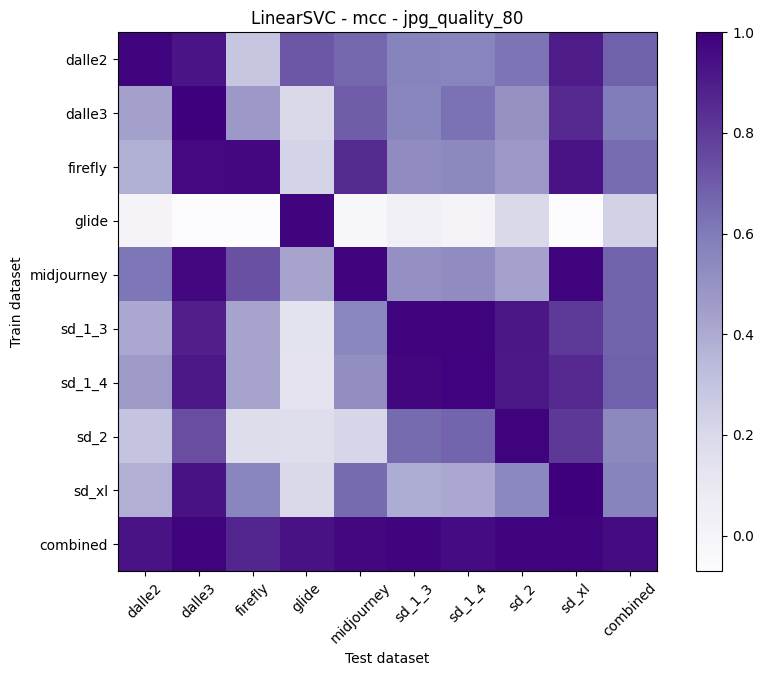

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.980000  0.926402  0.284747  0.712834    0.664557  0.562106   
dalle3         0.440488  1.000000  0.472484  0.197386    0.693889  0.554247   
firefly        0.383413  0.965109  0.970049  0.223100    0.852807  0.526719   
glide          0.000000 -0.070888 -0.070888  0.980000   -0.028976  0.041135   
midjourney     0.615012  0.970049  0.733285  0.424932    0.980196  0.507077   
sd_1_3         0.408386  0.888214  0.425291  0.136323    0.550634  0.980049   
sd_1_4         0.462888  0.912238  0.430105  0.126886    0.518823  0.975012   
sd_2           0.294884  0.741881  0.175863  0.168160    0.217072  0.650759   
sd_xl          0.377964  0.936981  0.554247  0.197386    0.650759  0.395056   
combined       0.930745  0.985111  0.869808  0.935573    0.970000  0.980049   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.558182  0.621001  0.902894  0.685001  
dalle3         0.631349  0.503903  0.855337  0.594889  
firefly        0.542470  0.470972  0.931165  0.646456  
glide          0.000000  0.197386 -0.070888  0.230524  
midjourney     0.523150  0.437525  0.980196  0.675521  
sd_1_3         0.985111  0.916387  0.803118  0.674390  
sd_1_4         0.990050  0.912238  0.857275  0.684555  
sd_2           0.670280  0.985111  0.808018  0.540103  
sd_xl          0.407653  0.546536  1.000000  0.563663  
combined       0.960048  0.980049  0.985111  0.954560

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.980000  0.926402  0.284747  0.712834    0.664557  0.562106   
dalle3         0.440488  1.000000  0.472484  0.197386    0.693889  0.554247   
firefly        0.383413  0.965109  0.970049  0.223100    0.852807  0.526719   
glide          0.000000 -0.070888 -0.070888  0.980000   -0.028976  0.041135   
midjourney     0.615012  0.970049  0.733285  0.424932    0.980196  0.507077   
sd_1_3         0.408386  0.888214  0.425291  0.136323    0.550634  0.980049   
sd_1_4         0.462888  0.912238  0.430105  0.126886    0.518823  0.975012   
sd_2           0.294884  0.741881  0.175863  0.168160    0.217072  0.650759   
sd_xl          0.377964  0.936981  0.554247  0.197386    0.650759  0.395056   
combined       0.930745  0.985111  0.869808  0.935573    0.970000  0.980049   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.558182  0.621001  0.902894  0.690302  
dalle3         0.631349  0.503903  0.855337  0.594343  
firefly        0.542470  0.470972  0.931165  0.651756  
glide          0.000000  0.197386 -0.070888  0.108542  
midjourney     0.523150  0.437525  0.980196  0.685713  
sd_1_3         0.985111  0.916387  0.803118  0.677057  
sd_1_4         0.990050  0.912238  0.857275  0.687279  
sd_2           0.670280  0.985111  0.808018  0.523559  
sd_xl          0.407653  0.546536  1.000000  0.562954  
combined       0.960048  0.980049  0.985111  0.955166









 ################ Evaluating models trained on standardAugmented and tested on jpg_quality_95. ################


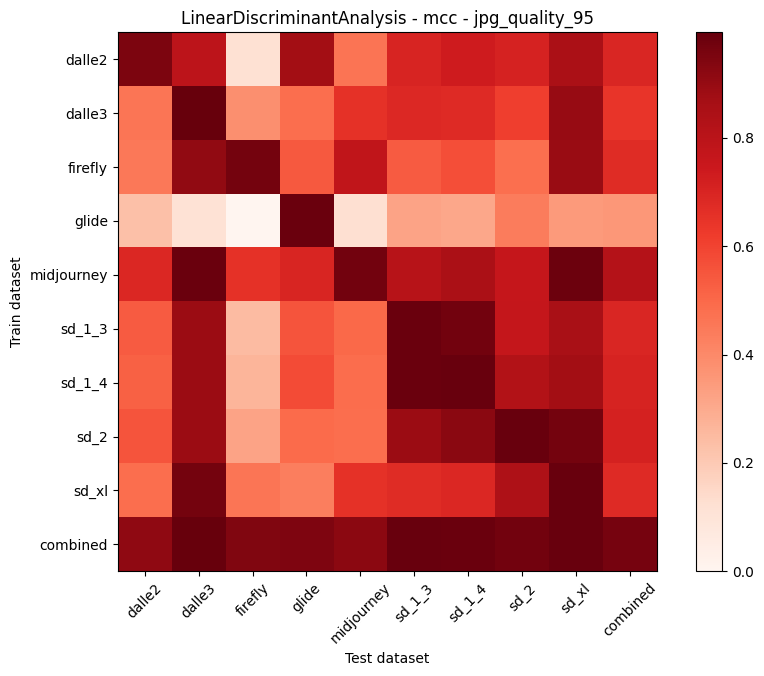

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.950761  0.789339  0.118002  0.871838    0.463562  0.703172   
dalle3         0.459540  0.995012  0.384756  0.483531    0.655531  0.687192   
firefly        0.454201  0.905918  0.965109  0.543807    0.778437  0.535754   
glide          0.229416  0.112509  0.000000  0.985111    0.123404  0.319262   
midjourney     0.691177  0.985012  0.655531  0.699167    0.970194  0.810560   
sd_1_3         0.534775  0.888214  0.245343  0.554594    0.498888  0.985111   
sd_1_4         0.519015  0.889919  0.265764  0.577463    0.487500  0.985012   
sd_2           0.554136  0.889919  0.321459  0.491461    0.483531  0.889919   
sd_xl          0.483030  0.965109  0.458831  0.434248    0.656598  0.672538   
combined       0.912926  0.995012  0.941177  0.945958    0.917584  0.990000   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.731432  0.711206  0.849613  0.692063  
dalle3         0.679242  0.612474  0.894484  0.645051  
firefly        0.567930  0.478947  0.891606  0.672706  
glide          0.309662  0.440488  0.347056  0.357519  
midjourney     0.849613  0.764269  0.980049  0.817228  
sd_1_3         0.970000  0.768837  0.851680  0.693295  
sd_1_4         0.990000  0.827774  0.871838  0.704955  
sd_2           0.922262  0.990000  0.965302  0.712996  
sd_xl          0.688573  0.839498  0.990050  0.680098  
combined       0.985012  0.970194  0.990000  0.960432

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.950761  0.789339  0.118002  0.871838    0.463562  0.703172   
dalle3         0.459540  0.995012  0.384756  0.483531    0.655531  0.687192   
firefly        0.454201  0.905918  0.965109  0.543807    0.778437  0.535754   
glide          0.229416  0.112509  0.000000  0.985111    0.123404  0.319262   
midjourney     0.691177  0.985012  0.655531  0.699167    0.970194  0.810560   
sd_1_3         0.534775  0.888214  0.245343  0.554594    0.498888  0.985111   
sd_1_4         0.519015  0.889919  0.265764  0.577463    0.487500  0.985012   
sd_2           0.554136  0.889919  0.321459  0.491461    0.483531  0.889919   
sd_xl          0.483030  0.965109  0.458831  0.434248    0.656598  0.672538   
combined       0.912926  0.995012  0.941177  0.945958    0.917584  0.990000   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.731432  0.711206  0.849613  0.687658  
dalle3         0.679242  0.612474  0.894484  0.650196  
firefly        0.567930  0.478947  0.891606  0.680190  
glide          0.309662  0.440488  0.347056  0.318545  
midjourney     0.849613  0.764269  0.980049  0.822841  
sd_1_3         0.970000  0.768837  0.851680  0.699716  
sd_1_4         0.990000  0.827774  0.871838  0.712698  
sd_2           0.922262  0.990000  0.965302  0.723110  
sd_xl          0.688573  0.839498  0.990050  0.687608  
combined       0.985012  0.970194  0.990000  0.960874

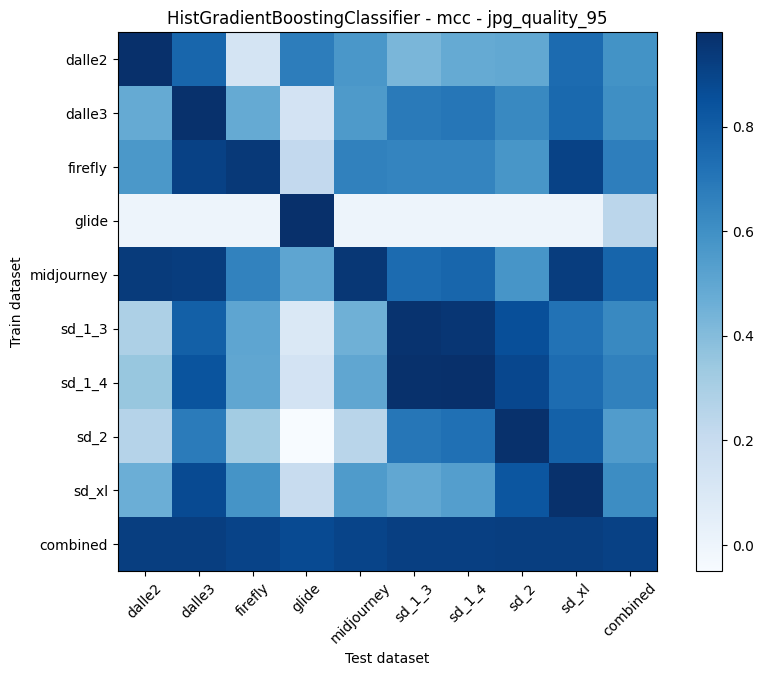

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.980049  0.764605  0.127578  0.673942    0.566465  0.425291   
dalle3         0.482805  0.975110  0.482805  0.137649    0.555136  0.683680   
firefly        0.564891  0.910410  0.940000  0.215718    0.654411  0.642102   
glide          0.000000  0.000000  0.000000  0.980196    0.000000  0.000000   
midjourney     0.935292  0.925104  0.652042  0.502648    0.950761  0.746520   
sd_1_3         0.287253  0.790180  0.503986  0.100882    0.454495  0.965302   
sd_1_4         0.350438  0.837104  0.499011  0.137649    0.499011  0.975110   
sd_2           0.262071  0.682024  0.318308 -0.050252    0.251002  0.702351   
sd_xl          0.463562  0.871838  0.585237  0.192953    0.550244  0.495415   
combined       0.922958  0.922958  0.901624  0.875536    0.896357  0.917584   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.482795  0.490855  0.743613  0.588883  
dalle3         0.700085  0.627036  0.754342  0.603902  
firefly        0.642102  0.572988  0.905555  0.669065  
glide          0.000000  0.000000  0.000000  0.239957  
midjourney     0.764236  0.577115  0.925104  0.767705  
sd_1_3         0.955107  0.858106  0.716847  0.628477  
sd_1_4         0.980196  0.887500  0.741677  0.655229  
sd_2           0.722871  0.975012  0.785878  0.543590  
sd_xl          0.534655  0.827774  0.975110  0.610742  
combined       0.917584  0.922958  0.922958  0.911053

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.980049  0.764605  0.127578  0.673942    0.566465  0.425291   
dalle3         0.482805  0.975110  0.482805  0.137649    0.555136  0.683680   
firefly        0.564891  0.910410  0.940000  0.215718    0.654411  0.642102   
glide          0.000000  0.000000  0.000000  0.980196    0.000000  0.000000   
midjourney     0.935292  0.925104  0.652042  0.502648    0.950761  0.746520   
sd_1_3         0.287253  0.790180  0.503986  0.100882    0.454495  0.965302   
sd_1_4         0.350438  0.837104  0.499011  0.137649    0.499011  0.975110   
sd_2           0.262071  0.682024  0.318308 -0.050252    0.251002  0.702351   
sd_xl          0.463562  0.871838  0.585237  0.192953    0.550244  0.495415   
combined       0.922958  0.922958  0.901624  0.875536    0.896357  0.917584   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.482795  0.490855  0.743613  0.583910  
dalle3         0.700085  0.627036  0.754342  0.599850  
firefly        0.642102  0.572988  0.905555  0.672019  
glide          0.000000  0.000000  0.000000  0.108911  
midjourney     0.764236  0.577115  0.925104  0.775425  
sd_1_3         0.955107  0.858106  0.716847  0.625795  
sd_1_4         0.980196  0.887500  0.741677  0.656411  
sd_2           0.722871  0.975012  0.785878  0.516585  
sd_xl          0.534655  0.827774  0.975110  0.610754  
combined       0.917584  0.922958  0.922958  0.911169

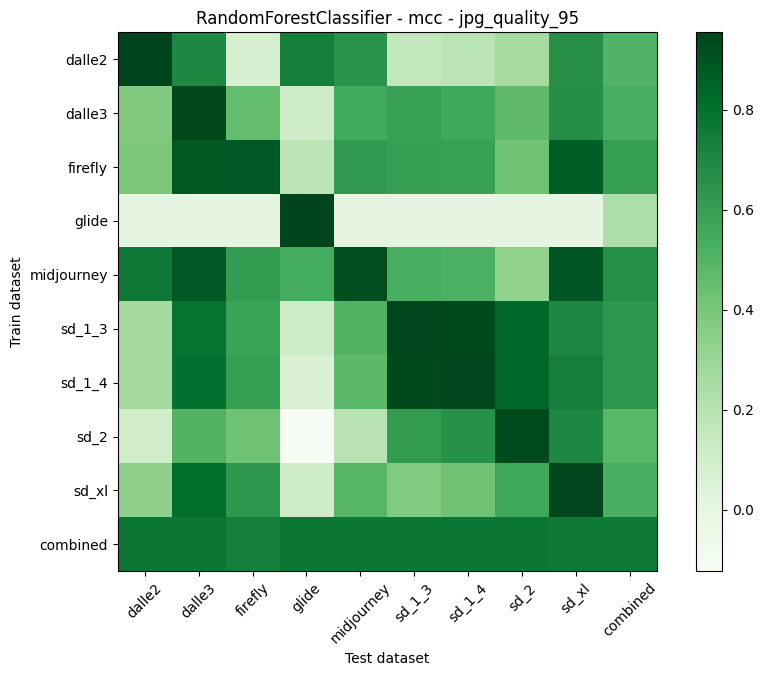

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.955299  0.702301  0.078464  0.736421    0.647988  0.158948   
dalle3         0.381881  0.940188  0.454135  0.120596    0.547153  0.595026   
firefly        0.382360  0.885543  0.880705  0.181203    0.620875  0.600245   
glide          0.000000  0.000000  0.000000  0.951190    0.000000  0.000000   
midjourney     0.764236  0.880396  0.610262  0.544063    0.925104  0.531662   
sd_1_3         0.272134  0.788926  0.582357  0.113608    0.500637  0.945106   
sd_1_4         0.268603  0.800310  0.601959  0.063161    0.477619  0.935292   
sd_2           0.100882  0.503986  0.425000 -0.123404    0.190822  0.613542   
sd_xl          0.331826  0.814848  0.627036  0.111537    0.494969  0.377466   
combined       0.770471  0.770471  0.733816  0.770471    0.770471  0.770471   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.185797  0.261569  0.664575  0.508398  
dalle3         0.559126  0.462373  0.671450  0.532941  
firefly        0.596128  0.425975  0.866311  0.604364  
glide          0.000000  0.000000  0.000000  0.236048  
midjourney     0.523387  0.328047  0.890178  0.660465  
sd_1_3         0.935012  0.829586  0.702301  0.632861  
sd_1_4         0.945579  0.832669  0.737734  0.633411  
sd_2           0.658524  0.930047  0.700027  0.483949  
sd_xl          0.424932  0.567103  0.950048  0.530273  
combined       0.770471  0.770471  0.764269  0.765644

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.955299  0.702301  0.078464  0.736421    0.647988  0.158948   
dalle3         0.381881  0.940188  0.454135  0.120596    0.547153  0.595026   
firefly        0.382360  0.885543  0.880705  0.181203    0.620875  0.600245   
glide          0.000000  0.000000  0.000000  0.951190    0.000000  0.000000   
midjourney     0.764236  0.880396  0.610262  0.544063    0.925104  0.531662   
sd_1_3         0.272134  0.788926  0.582357  0.113608    0.500637  0.945106   
sd_1_4         0.268603  0.800310  0.601959  0.063161    0.477619  0.935292   
sd_2           0.100882  0.503986  0.425000 -0.123404    0.190822  0.613542   
sd_xl          0.331826  0.814848  0.627036  0.111537    0.494969  0.377466   
combined       0.770471  0.770471  0.733816  0.770471    0.770471  0.770471   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.185797  0.261569  0.664575  0.487929  
dalle3         0.559126  0.462373  0.671450  0.525770  
firefly        0.596128  0.425975  0.866311  0.604372  
glide          0.000000  0.000000  0.000000  0.105688  
midjourney     0.523387  0.328047  0.890178  0.666371  
sd_1_3         0.935012  0.829586  0.702301  0.629963  
sd_1_4         0.945579  0.832669  0.737734  0.629214  
sd_2           0.658524  0.930047  0.700027  0.444381  
sd_xl          0.424932  0.567103  0.950048  0.522196  
combined       0.770471  0.770471  0.764269  0.765709

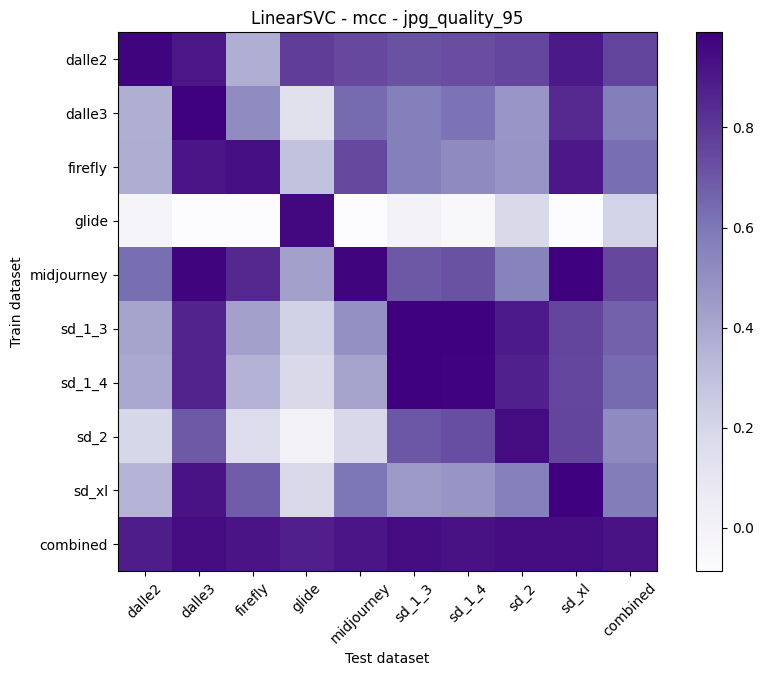

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.970194  0.905918  0.372721  0.782786    0.744079  0.714575   
dalle3         0.374654  0.990050  0.510909  0.136032    0.640737  0.569951   
firefly        0.377169  0.910410  0.935012  0.292326    0.742361  0.572988   
glide         -0.022502 -0.086929 -0.086929  0.960048   -0.086929  0.000000   
midjourney     0.629877  0.970000  0.847189  0.429478    0.970000  0.698271   
sd_1_3         0.413381  0.866260  0.430105  0.216887    0.495017  0.990050   
sd_1_4         0.396378  0.866260  0.352290  0.183533    0.421775  0.990050   
sd_2           0.196347  0.693772  0.162255  0.000000    0.189832  0.702069   
sd_xl          0.347727  0.921660  0.680543  0.183533    0.601338  0.450685   
combined       0.885011  0.946433  0.915286  0.880044    0.910182  0.946433   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.731376  0.752600  0.901127  0.758782  
dalle3         0.613129  0.470972  0.843919  0.576923  
firefly        0.516219  0.475248  0.905555  0.631198  
glide         -0.050252  0.182564 -0.086929  0.212777  
midjourney     0.714638  0.554594  0.985111  0.746397  
sd_1_3         0.990050  0.893627  0.762279  0.667215  
sd_1_4         0.980000  0.875312  0.753941  0.643815  
sd_2           0.727162  0.945012  0.756877  0.516471  
sd_xl          0.475000  0.562106  0.985012  0.579974  
combined       0.930745  0.946433  0.946433  0.922701

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.970194  0.905918  0.372721  0.782786    0.744079  0.714575   
dalle3         0.374654  0.990050  0.510909  0.136032    0.640737  0.569951   
firefly        0.377169  0.910410  0.935012  0.292326    0.742361  0.572988   
glide         -0.022502 -0.086929 -0.086929  0.960048   -0.086929  0.000000   
midjourney     0.629877  0.970000  0.847189  0.429478    0.970000  0.698271   
sd_1_3         0.413381  0.866260  0.430105  0.216887    0.495017  0.990050   
sd_1_4         0.396378  0.866260  0.352290  0.183533    0.421775  0.990050   
sd_2           0.196347  0.693772  0.162255  0.000000    0.189832  0.702069   
sd_xl          0.347727  0.921660  0.680543  0.183533    0.601338  0.450685   
combined       0.885011  0.946433  0.915286  0.880044    0.910182  0.946433   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.731376  0.752600  0.901127  0.763931  
dalle3         0.613129  0.470972  0.843919  0.572261  
firefly        0.516219  0.475248  0.905555  0.636365  
glide         -0.050252  0.182564 -0.086929  0.080238  
midjourney     0.714638  0.554594  0.985111  0.755462  
sd_1_3         0.990050  0.893627  0.762279  0.673073  
sd_1_4         0.980000  0.875312  0.753941  0.646615  
sd_2           0.727162  0.945012  0.756877  0.485925  
sd_xl          0.475000  0.562106  0.985012  0.578623  
combined       0.930745  0.946433  0.946433  0.923000









 ################ Evaluating models trained on standardAugmented and tested on standard. ################


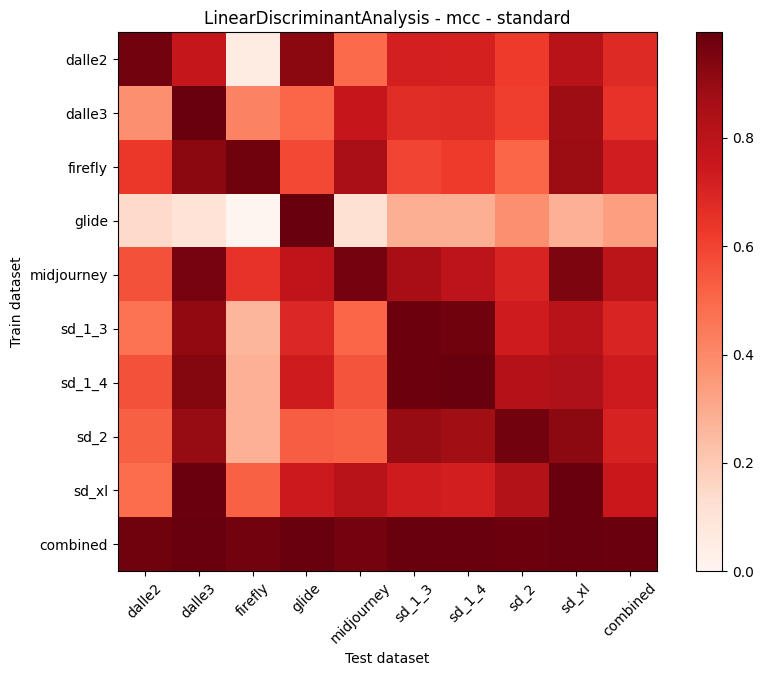

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.970194  0.765466  0.054413  0.920414    0.491210  0.718761   
dalle3         0.383413  0.990050  0.417587  0.506945    0.758105  0.668545   
firefly        0.633860  0.921152  0.975012  0.586245    0.851680  0.598120   
glide          0.146553  0.107143  0.000000  0.995012    0.118002  0.286860   
midjourney     0.560843  0.960192  0.650302  0.781374    0.965302  0.862765   
sd_1_3         0.466477  0.906372  0.261262  0.687771    0.507077  0.980196   
sd_1_4         0.561915  0.936417  0.276454  0.731432    0.554136  0.980049   
sd_2           0.523150  0.896897  0.277276  0.531162    0.519138  0.896897   
sd_xl          0.487500  0.985012  0.519015  0.739583    0.806290  0.731432   
combined       0.975110  0.995012  0.970194  0.990000    0.965302  0.990000   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.714575  0.624306  0.804726  0.680013  
dalle3         0.672538  0.613129  0.879864  0.649539  
firefly        0.621921  0.506896  0.888214  0.724246  
glide          0.286860  0.384756  0.276454  0.330914  
midjourney     0.790180  0.700027  0.950048  0.796081  
sd_1_3         0.975110  0.733285  0.810441  0.696429  
sd_1_4         0.995012  0.819140  0.836465  0.735956  
sd_2           0.878178  0.970049  0.915928  0.704205  
sd_xl          0.719272  0.823450  0.995012  0.749141  
combined       0.995012  0.980049  0.995012  0.983907

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.970194  0.765466  0.054413  0.920414    0.491210  0.718761   
dalle3         0.383413  0.990050  0.417587  0.506945    0.758105  0.668545   
firefly        0.633860  0.921152  0.975012  0.586245    0.851680  0.598120   
glide          0.146553  0.107143  0.000000  0.995012    0.118002  0.286860   
midjourney     0.560843  0.960192  0.650302  0.781374    0.965302  0.862765   
sd_1_3         0.466477  0.906372  0.261262  0.687771    0.507077  0.980196   
sd_1_4         0.561915  0.936417  0.276454  0.731432    0.554136  0.980049   
sd_2           0.523150  0.896897  0.277276  0.531162    0.519138  0.896897   
sd_xl          0.487500  0.985012  0.519015  0.739583    0.806290  0.731432   
combined       0.975110  0.995012  0.970194  0.990000    0.965302  0.990000   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.714575  0.624306  0.804726  0.673785  
dalle3         0.672538  0.613129  0.879864  0.654464  
firefly        0.621921  0.506896  0.888214  0.731456  
glide          0.286860  0.384756  0.276454  0.289071  
midjourney     0.790180  0.700027  0.950048  0.802337  
sd_1_3         0.975110  0.733285  0.810441  0.703110  
sd_1_4         0.995012  0.819140  0.836465  0.743447  
sd_2           0.878178  0.970049  0.915928  0.712075  
sd_xl          0.719272  0.823450  0.995012  0.756285  
combined       0.995012  0.980049  0.995012  0.983966

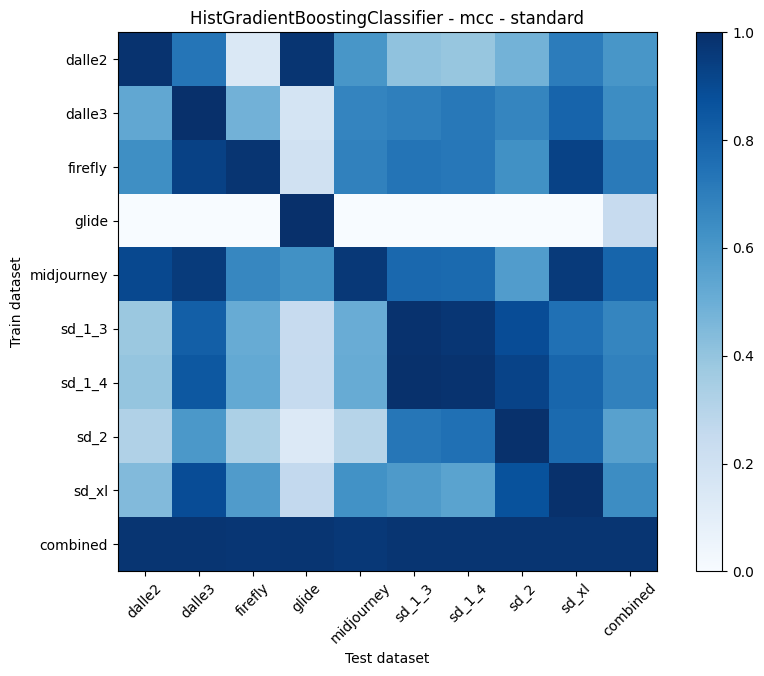

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.985111  0.731139  0.144715  0.980049    0.602081  0.408386   
dalle3         0.531085  1.000000  0.484322  0.175863    0.674200  0.693889   
firefly        0.632832  0.931165  0.980000  0.197386    0.684555  0.737386   
glide          0.000000  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.905918  0.955012  0.664966  0.628352    0.965109  0.782786   
sd_1_3         0.380424  0.819140  0.511170  0.243382    0.507240  0.990000   
sd_1_4         0.397613  0.845215  0.522931  0.249117    0.511170  0.995012   
sd_2           0.319262  0.596601  0.328684  0.133460    0.299864  0.729772   
sd_xl          0.443339  0.889919  0.581350  0.260302    0.624176  0.589124   
combined       0.980196  0.980196  0.975110  0.980196    0.965012  0.980196   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.391192  0.478753  0.706438  0.604283  
dalle3         0.721743  0.670280  0.799590  0.640826  
firefly        0.725070  0.628885  0.926402  0.713738  
glide          0.000000  0.000000  0.000000  0.242536  
midjourney     0.774101  0.575967  0.960048  0.794445  
sd_1_3         0.975110  0.889919  0.751881  0.668679  
sd_1_4         0.985012  0.922262  0.789339  0.683655  
sd_2           0.750000  0.995012  0.774597  0.557244  
sd_xl          0.550244  0.867360  0.995012  0.640693  
combined       0.980196  0.980196  0.980196  0.977932

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.985111  0.731139  0.144715  0.980049    0.602081  0.408386   
dalle3         0.531085  1.000000  0.484322  0.175863    0.674200  0.693889   
firefly        0.632832  0.931165  0.980000  0.197386    0.684555  0.737386   
glide          0.000000  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.905918  0.955012  0.664966  0.628352    0.965109  0.782786   
sd_1_3         0.380424  0.819140  0.511170  0.243382    0.507240  0.990000   
sd_1_4         0.397613  0.845215  0.522931  0.249117    0.511170  0.995012   
sd_2           0.319262  0.596601  0.328684  0.133460    0.299864  0.729772   
sd_xl          0.443339  0.889919  0.581350  0.260302    0.624176  0.589124   
combined       0.980196  0.980196  0.975110  0.980196    0.965012  0.980196   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.391192  0.478753  0.706438  0.603096  
dalle3         0.721743  0.670280  0.799590  0.638997  
firefly        0.725070  0.628885  0.926402  0.715965  
glide          0.000000  0.000000  0.000000  0.111111  
midjourney     0.774101  0.575967  0.960048  0.801362  
sd_1_3         0.975110  0.889919  0.751881  0.674252  
sd_1_4         0.985012  0.922262  0.789339  0.690852  
sd_2           0.750000  0.995012  0.774597  0.547472  
sd_xl          0.550244  0.867360  0.995012  0.644536  
combined       0.980196  0.980196  0.980196  0.977944

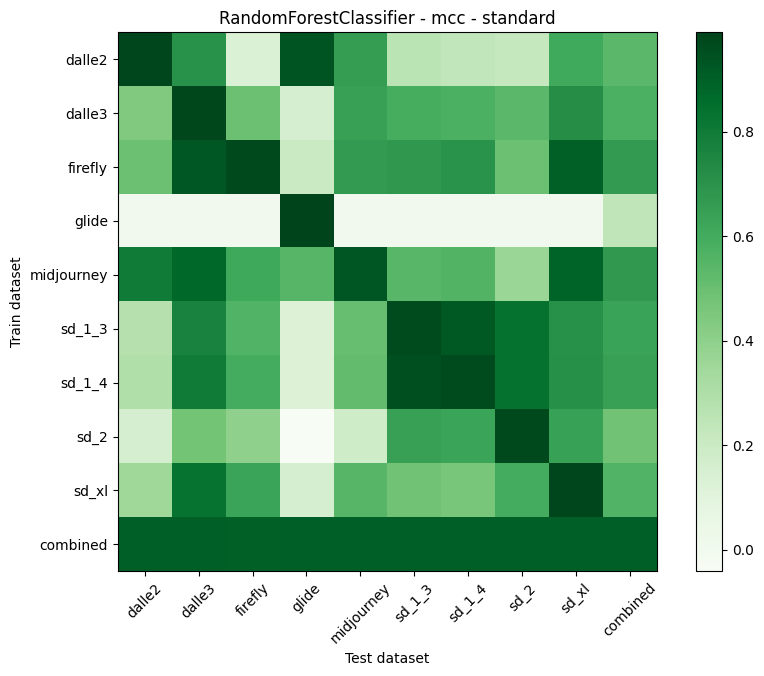

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.980196  0.700085  0.129287  0.935292    0.659276  0.255785   
dalle3         0.438377  0.975012  0.491029  0.153093    0.644695  0.589562   
firefly        0.491029  0.926402  0.970049  0.204042    0.664557  0.676538   
glide          0.000000  0.000000  0.000000  0.990050    0.000000  0.000000   
midjourney     0.797858  0.871570  0.615061  0.549737    0.930000  0.545658   
sd_1_3         0.276916  0.765466  0.559893  0.123300    0.503415  0.965109   
sd_1_4         0.292342  0.800310  0.592050  0.123300    0.515572  0.950000   
sd_2           0.153522  0.470572  0.394996 -0.041135    0.182537  0.647151   
sd_xl          0.352290  0.830702  0.628885  0.153093    0.550329  0.479019   
combined       0.904534  0.904534  0.899066  0.904534    0.904534  0.904534   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.233074  0.221163  0.607011  0.537830  
dalle3         0.573873  0.538537  0.720983  0.573873  
firefly        0.696631  0.491029  0.898251  0.666329  
glide          0.000000  0.000000  0.000000  0.241249  
midjourney     0.557892  0.363935  0.885897  0.673835  
sd_1_3         0.925289  0.836041  0.706229  0.632401  
sd_1_4         0.965109  0.836041  0.710398  0.645027  
sd_2           0.631051  0.970049  0.643120  0.481901  
sd_xl          0.458831  0.593486  0.980000  0.562977  
combined       0.904534  0.904534  0.904534  0.903925

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.980196  0.700085  0.129287  0.935292    0.659276  0.255785   
dalle3         0.438377  0.975012  0.491029  0.153093    0.644695  0.589562   
firefly        0.491029  0.926402  0.970049  0.204042    0.664557  0.676538   
glide          0.000000  0.000000  0.000000  0.990050    0.000000  0.000000   
midjourney     0.797858  0.871570  0.615061  0.549737    0.930000  0.545658   
sd_1_3         0.276916  0.765466  0.559893  0.123300    0.503415  0.965109   
sd_1_4         0.292342  0.800310  0.592050  0.123300    0.515572  0.950000   
sd_2           0.153522  0.470572  0.394996 -0.041135    0.182537  0.647151   
sd_xl          0.352290  0.830702  0.628885  0.153093    0.550329  0.479019   
combined       0.904534  0.904534  0.899066  0.904534    0.904534  0.904534   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.233074  0.221163  0.607011  0.524574  
dalle3         0.573873  0.538537  0.720983  0.569462  
firefly        0.696631  0.491029  0.898251  0.668725  
glide          0.000000  0.000000  0.000000  0.110006  
midjourney     0.557892  0.363935  0.885897  0.679734  
sd_1_3         0.925289  0.836041  0.706229  0.629073  
sd_1_4         0.965109  0.836041  0.710398  0.642791  
sd_2           0.631051  0.970049  0.643120  0.450207  
sd_xl          0.458831  0.593486  0.980000  0.558515  
combined       0.904534  0.904534  0.904534  0.903927

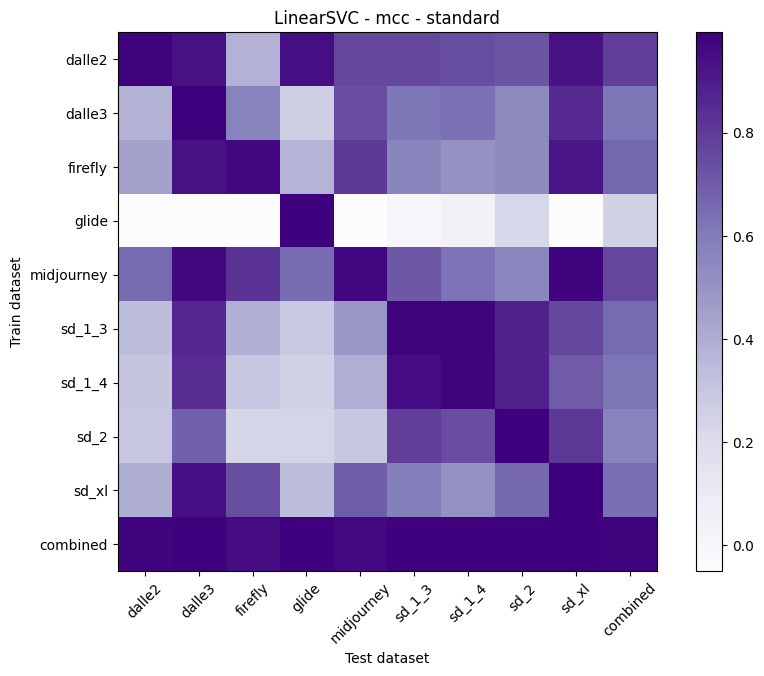

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.980049  0.935573  0.382470  0.945295    0.760385  0.756176   
dalle3         0.376069  0.995012  0.573577  0.260302    0.743673  0.616372   
firefly        0.445854  0.930419  0.965012  0.373026    0.810441  0.559126   
glide         -0.050063 -0.050063 -0.050063  0.995012   -0.050063  0.000000   
midjourney     0.648643  0.965109  0.827018  0.648643    0.970194  0.710398   
sd_1_3         0.333835  0.861759  0.392078  0.284747    0.487033  0.980000   
sd_1_4         0.303621  0.847189  0.298630  0.251002    0.395520  0.955107   
sd_2           0.299864  0.685994  0.235391  0.235391    0.294884  0.791212   
sd_xl          0.401857  0.945958  0.739583  0.335581    0.695168  0.585237   
combined       0.975012  0.990050  0.950428  0.990050    0.960192  0.990050   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.739445  0.722871  0.930745  0.787783  
dalle3         0.631992  0.538556  0.854026  0.619406  
firefly        0.511102  0.543159  0.920737  0.665131  
glide          0.050252  0.225520 -0.050063  0.244024  
midjourney     0.628352  0.555873  0.975305  0.762120  
sd_1_3         0.975012  0.879864  0.762279  0.655714  
sd_1_4         0.980049  0.883586  0.702351  0.621921  
sd_2           0.745936  0.995012  0.808018  0.572646  
sd_xl          0.511170  0.663413  0.995012  0.647231  
combined       0.990050  0.990050  0.990050  0.980556

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.980049  0.935573  0.382470  0.945295    0.760385  0.756176   
dalle3         0.376069  0.995012  0.573577  0.260302    0.743673  0.616372   
firefly        0.445854  0.930419  0.965012  0.373026    0.810441  0.559126   
glide         -0.050063 -0.050063 -0.050063  0.995012   -0.050063  0.000000   
midjourney     0.648643  0.965109  0.827018  0.648643    0.970194  0.710398   
sd_1_3         0.333835  0.861759  0.392078  0.284747    0.487033  0.980000   
sd_1_4         0.303621  0.847189  0.298630  0.251002    0.395520  0.955107   
sd_2           0.299864  0.685994  0.235391  0.235391    0.294884  0.791212   
sd_xl          0.401857  0.945958  0.739583  0.335581    0.695168  0.585237   
combined       0.975012  0.990050  0.950428  0.990050    0.960192  0.990050   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.739445  0.722871  0.930745  0.794779  
dalle3         0.631992  0.538556  0.854026  0.621064  
firefly        0.511102  0.543159  0.920737  0.673208  
glide          0.050252  0.225520 -0.050063  0.113386  
midjourney     0.628352  0.555873  0.975305  0.769948  
sd_1_3         0.975012  0.879864  0.762279  0.661845  
sd_1_4         0.980049  0.883586  0.702351  0.624117  
sd_2           0.745936  0.995012  0.808018  0.565745  
sd_xl          0.511170  0.663413  0.995012  0.652553  
combined       0.990050  0.990050  0.990050  0.980659

In [16]:
print("########################### MCC ###########################")
for perturbed_name, results in perturbed_results.items():
    print(f"\n\n\n\n\n\n\n\n ################ Evaluating models trained on {base_perturbed_name} and tested on {perturbed_name}. ################")
    
    # Create a heatmap of results
    df = pd.DataFrame(results).T
    df.reset_index(inplace=True)
    df.columns = ["train_dataset", "test_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

    df_pivot = df.pivot(index=["train_dataset", "model"], columns="test_dataset", values="mcc")
    df_pivot = df_pivot.reindex(index=X_train.keys())

    metric = "mcc"
    evaluation_data_name = "Test"
    df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)